# Determine the average signal yield and the error on its measure

In [36]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle
import zfit
import mplhep
from numpy import random 

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})

## Définition des paramètres

In [2]:
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [3]:
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
df_gen = tree_gen.arrays(library="pd", how="zip")

In [9]:
N_Z0 = 5*10**(12)
BF_Zbb = 0.1512
f_Bc = 0.0004
f_Bu = 0.43
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

spline_MVA1_log = pickle.load(open('../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
spline_MVA2_log = pickle.load(open('../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

def S_cut(initial_eff_signal, cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion*initial_eff_signal*cut_eff

def B_incl_cut(initial_eff_incl_bkg, cut_eff) :
    return N_Z0*BF_Zbb*2*initial_eff_incl_bkg*cut_eff

def B_cut(initial_eff_signal, cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion*initial_eff_signal*cut_eff

In [10]:
#Initialisation

var1 = 'EVT_MVA1'
var2 = 'EVT_MVA2'

MVA1_cut_log = -np.log(1-0.95)
MVA2_cut_log = -np.log(1-0.95)
max_cut_1_log = 9
max_cut_2_log = 8

bc_init = bc_df[bc_df[var2]> 0.95]
bc_init = bc_init[bc_init[var1]> 0.95]
bu_init = bu_df[bu_df[var2]> 0.95]
bu_init = bu_init[bu_init[var1]> 0.95]
bb_init = bb_df[bb_df[var2]> 0.95]
bb_init = bb_init[bb_init[var1]> 0.95]

nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_init = len(bc_init)
nb_bu_init = len(bu_init)
nb_bb_init = len(bb_init)
nb_bb1_init = interpolate.splint(MVA1_cut_log, max_cut_1_log, spline_MVA1_log)
nb_bb2_init = interpolate.splint(MVA2_cut_log, max_cut_2_log, spline_MVA2_log)

initial_eff_bc = nb_bc_init / nb_total_events
initial_eff_bu = nb_bu_init / nb_total_events
initial_eff_bb = nb_bb_init / nb_total_events


#Best cut

best_MVA1_cut = 0.99986
best_MVA2_cut = 0.99634

best_MVA1_cut_log = -np.log(1-best_MVA1_cut)
best_MVA2_cut_log = -np.log(1-best_MVA2_cut)
max_cut_1_log = 9
max_cut_2_log = 8

bu_cut = bu_df[bu_df['EVT_MVA1'] > best_MVA1_cut]
bu_cut = bu_cut[bu_cut['EVT_MVA2'] > best_MVA2_cut]
bc_cut = bc_df[bc_df['EVT_MVA1'] > best_MVA1_cut]
bc_cut = bc_cut[bc_cut['EVT_MVA2'] > best_MVA2_cut]
bb_cut = bb_df[bb_df['EVT_MVA1'] > best_MVA1_cut]
bb_cut = bb_cut[bb_cut['EVT_MVA2'] > best_MVA2_cut]

nb_bc_cut = len(bc_cut)
nb_bu_cut = len(bu_cut)
nb_bb_cut_i1 = interpolate.splint(best_MVA1_cut_log, max_cut_1_log, spline_MVA1_log)
nb_bb_cut_i2 = interpolate.splint(best_MVA2_cut_log, max_cut_2_log, spline_MVA2_log)

eff_bc = nb_bc_cut/nb_bc_init 
eff_bu = nb_bu_cut/nb_bu_init 
eff_bb = (nb_bb_cut_i1/nb_bb1_init) * (nb_bb_cut_i2/nb_bb2_init)

#Yields
N_BC = S_cut(initial_eff_bc, eff_bc)
N_BU = B_cut(initial_eff_bu, eff_bu)
N_BB = B_incl_cut(initial_eff_bb, eff_bb)

print('N_BC = {}, N_BU = {}, N_BB={}'.format(N_BC, N_BU, N_BB))


N_BC = 4009.2649482816005, N_BU = 241.47796710240002, N_BB=3615.187009498297


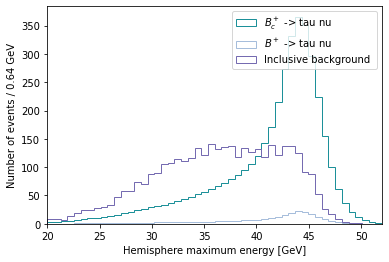

[]

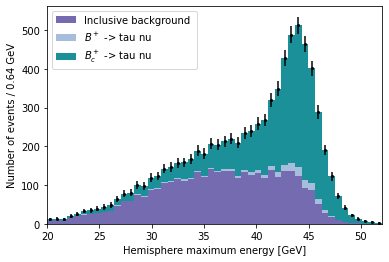

In [11]:
variable = 'EVT_ThrustEmax_E'

nb_bins = 50
min_bin = 20
max_bin = 52

name_bc = "$B_c^+$ -> tau nu "
name_bu = "$B^+$ -> tau nu"
name_bb = "Inclusive background "

counts_bc, bins_bc = np.histogram(bc_init[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_init[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_init[variable], bins = nb_bins, range = (min_bin, max_bin))

counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB

plt.figure()
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= "#1c9099", label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= "#a6bddb", label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= "#756bb1", label=name_bb)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

x = [bins_bc[:-1], bins_bu[:-1], bins_bb[:-1]]
bins = bins_bc
weights = [counts_bb, counts_bu, counts_bc]
colour = ["#756bb1","#a6bddb","#1c9099"]
name = [name_bb, name_bu, name_bc]

plt.figure()
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[2])
plt.errorbar(bin_centres, counts[2], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.legend()
plt.plot()

## Processus du fit

In [12]:
def get_template(yield_sig, yield_incl_bkg):
  return yield_sig*template_process1 + N_BU*template_process2 + yield_incl_bkg*template_process3

def binned_nll(template, sample_hist):
  return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1e-14) / (template + 1e-14)))
  # 1e-14 added in case there are empty bins

def loss(x):
  # by default, `x` is an `OrderedSet` of
  # zfit parameters.
  x = np.array(x)

  print("Value of the parameters", x) # can be commented out, just to see how x evolves during 
  # the minimisation
  
  # The first parameter is the yield of the first template
  yield_sig = x[0]
  # The second parameter is the yield of the third template
  yield_incl_bkg = x[1]

  template = get_template(yield_sig, yield_incl_bkg)

  nll = binned_nll(template, sample_hist)
  return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

In [27]:
n_loop = 2000
sig_yield = np.zeros(n_loop)
bkg_yield = np.zeros(n_loop)

for i in range (n_loop) :
    
    #Toy sample
    data = np.random.poisson(counts[2])
    sample_hist, bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=data)
    
    #Templates and templates normalisation
    template_process1, _ = np.histogram(a=bins_bc[:-1], bins=bins_edges, weights=counts_bc)
    template_process2, _ = np.histogram(a=bins_bu[:-1], bins=bins_edges, weights=counts_bu)
    template_process3, _ = np.histogram(a=bins_bb[:-1], bins=bins_edges, weights=counts_bb)
    
    template_process1 = template_process1/np.sum(template_process1)
    template_process2 = template_process2/np.sum(template_process2)
    template_process3 = template_process3/np.sum(template_process3)
    
    #Initialisation of the parameters
    rand_int = random.randint(0,1000000000000,size=1)
    sig_yield_ = zfit.Parameter(f"sig_yield_{rand_int}", 4000.)

    rand_int = random.randint(0,1000000000000,size=1)
    bkg_yield_ = zfit.Parameter(f"bkg_yield_{rand_int}", 4000.)

    initial_params = [sig_yield_, bkg_yield_]
    
    #Fit
    minimiser = zfit.minimize.Minuit(verbosity=5)
    zfit.run.set_autograd_mode(False)
    zfit.run.set_graph_mode(False)
    result = minimiser.minimize(loss, initial_params)
    param_hesse = result.hesse() #what does it do
    print(' ')
    
    #Extracting the results
    sig_yield[i] = result.params[sig_yield_]['value']
    bkg_yield[i] = result.params[bkg_yield_]['value']
    

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3800.60740758 3554.23479263]
Value of the parameters [3875.8481311  3722.44413439]
Value of the parameters [3876.16112786 3722.44413439]
Value of the parameters [3875.53513434 3722.44413439]
Value of the parameters [3875.8481311  3722.76378254]
Value of the parameters [3875.8481311  3722.12448624]
Value of the parameters [3976.90145147 3631.74296539]
Value of the parameters [4161.90828972 3465.68868395]
Value of the parameters [4162.18872805 3465.68868395]
Value of the parameters [4161.62785138 3465.68868395]
Value of the parameters [4161.90828972 3465.97136917]
Value of the parameters [4161.90828972 3465.40599872]
Value of the parameters [4169.82696704 3470.56884405]
Value of the parameters [4170.11438479 3470.56884405]
Value of the parameters [4169.53954929 3470.56

Value of the parameters [4039.18410425 3619.11803988]
Value of the parameters [4039.18410425 3619.00705277]
Value of the parameters [4039.46837376 3619.34001412]
Value of the parameters [4039.18410425 3619.06254633]
Value of the parameters [4039.24095816 3619.06254633]
Value of the parameters [4039.12725035 3619.06254633]
Value of the parameters [4039.18410425 3619.11803988]
Value of the parameters [4039.18410425 3619.00705277]
Value of the parameters [4039.19547503 3619.06254633]
Value of the parameters [4039.17273347 3619.06254633]
Value of the parameters [4039.18410425 3619.07364504]
Value of the parameters [4039.18410425 3619.05144761]
Value of the parameters [4039.24095816 3619.11803988]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3605.66039327 3611.78724169]
Value of the parameters [3780.76136864 3784.

Value of the parameters [3809.61030564 3730.25051147]
Value of the parameters [3809.61030564 3729.65502486]
Value of the parameters [3809.61030564 3729.95276817]
Value of the parameters [3809.91105699 3729.95276817]
Value of the parameters [3809.30955428 3729.95276817]
Value of the parameters [3809.61030564 3730.25051147]
Value of the parameters [3809.61030564 3729.65502486]
Value of the parameters [3809.67045591 3729.95276817]
Value of the parameters [3809.55015536 3729.95276817]
Value of the parameters [3809.61030564 3730.01231683]
Value of the parameters [3809.61030564 3729.89321951]
Value of the parameters [3809.91105699 3730.25051147]
Value of the parameters [3809.61030564 3729.95276817]
Value of the parameters [3809.67045591 3729.95276817]
Value of the parameters [3809.55015536 3729.95276817]
Value of the parameters [3809.61030564 3730.01231683]
Value of the parameters [3809.61030564 3729.89321951]
Value of the parameters [3809.62233569 3729.95276817]
Value of the parameters [380

Value of the parameters [3930.47328744 3670.81320573]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3801.90232263 3639.18611736]
Value of the parameters [3880.67370467 3782.65982473]
Value of the parameters [3880.95602508 3782.65982473]
Value of the parameters [3880.39138426 3782.65982473]
Value of the parameters [3880.67370467 3782.94546682]
Value of the parameters [3880.67370467 3782.37418264]
Value of the parameters [3947.22868986 3720.7887863 ]
Value of the parameters [4073.90570155 3603.02693516]
Value of the parameters [4074.16786827 3603.02693516]
Value of the parameters [4073.64353483 3603.02693516]
Value of the parameters [4073.90570155 3603.28997203]
Value of the parameters [4073.90570155 3602.76389829]
Value of the parameters [4078.27968004 3606.41579257]
Value of the parameters [4078.54611679 3606.

Value of the parameters [4032.08722329 3592.14829367]
Value of the parameters [4032.08722329 3592.02743571]
Value of the parameters [4032.39704171 3592.39000959]
Value of the parameters [4032.08722329 3592.08786469]
Value of the parameters [4032.14918698 3592.08786469]
Value of the parameters [4032.02525961 3592.08786469]
Value of the parameters [4032.08722329 3592.14829367]
Value of the parameters [4032.08722329 3592.02743571]
Value of the parameters [4032.09961603 3592.08786469]
Value of the parameters [4032.07483056 3592.08786469]
Value of the parameters [4032.08722329 3592.09995048]
Value of the parameters [4032.08722329 3592.07577889]
Value of the parameters [4032.14918698 3592.14829367]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3764.3478761  3577.82290493]
Value of the parameters [3859.80965576 3748.

Value of the parameters [4054.67794153 3516.49484056]
Value of the parameters [4061.97302176 3522.90817195]
Value of the parameters [4061.60767658 3522.60177743]
Value of the parameters [4061.90674159 3522.60177743]
Value of the parameters [4061.30861157 3522.60177743]
Value of the parameters [4061.60767658 3522.89230146]
Value of the parameters [4061.60767658 3522.3112534 ]
Value of the parameters [4061.60767658 3522.60177743]
Value of the parameters [4061.90674159 3522.60177743]
Value of the parameters [4061.30861157 3522.60177743]
Value of the parameters [4061.60767658 3522.89230146]
Value of the parameters [4061.60767658 3522.3112534 ]
Value of the parameters [4061.66748958 3522.60177743]
Value of the parameters [4061.54786358 3522.60177743]
Value of the parameters [4061.60767658 3522.65988224]
Value of the parameters [4061.60767658 3522.54367263]
Value of the parameters [4061.90674159 3522.89230146]
Value of the parameters [4061.60767658 3522.60177743]
Value of the parameters [406

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3626.77470552 3495.9060149 ]
Value of the parameters [3790.81355775 3717.46387808]
Value of the parameters [3791.11327824 3717.46387808]
Value of the parameters [3790.51383726 3717.46387808]
Value of the parameters [3790.81355775 3717.76594249]
Value of the parameters [3790.81355775 3717.16181368]
Value of the parameters [3840.17916404 3664.26820404]
Value of the parameters [3926.38301595 3571.37616136]
Value of the parameters [3926.66049231 3571.37616136]
Value of the parameters [3926.10553958 3571.37616136]
Value of the parameters [3926.38301595 3571.65388634]
Value of the parameters [3926.38301595 3571.09843637]
Value of the parameters [3935.34600706 3577.2891976 ]
Value of the parameters [3935.62621732 3577.2891976 ]
Value of the parameters [3935.0657968 3577.2891976]
Value of the parameters [3935.34600706 3577.563298  ]
Value of the parameters [3935.34600706 3577.0150972 ]
Valu

Value of the parameters [4009.00848784 3688.35630905]
Value of the parameters [4008.87651715 3688.35630905]
Value of the parameters [4008.9425025 3688.4209721]
Value of the parameters [4008.9425025 3688.291646 ]
Value of the parameters [4008.95569956 3688.35630905]
Value of the parameters [4008.92930543 3688.35630905]
Value of the parameters [4008.9425025  3688.36924166]
Value of the parameters [4008.9425025  3688.34337644]
Value of the parameters [4009.00848784 3688.4209721 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3710.6732298  3447.39622433]
Value of the parameters [3828.89219933 3673.19022491]
Value of the parameters [3829.1961369  3673.19022491]
Value of the parameters [3828.58826177 3673.19022491]
Value of the parameters [3828.89219933 3673.50104153]
Value of the parameters [3828.89219933 3672.8794

Value of the parameters [4328.45125977 3288.21771647]
Value of the parameters [4328.45125977 3287.68658681]
Value of the parameters [4328.45125977 3287.95215164]
Value of the parameters [4328.73002492 3287.95215164]
Value of the parameters [4328.17249462 3287.95215164]
Value of the parameters [4328.45125977 3288.21771647]
Value of the parameters [4328.45125977 3287.68658681]
Value of the parameters [4328.5070128  3287.95215164]
Value of the parameters [4328.39550674 3287.95215164]
Value of the parameters [4328.45125977 3288.00526461]
Value of the parameters [4328.45125977 3287.89903867]
Value of the parameters [4328.73002492 3288.21771647]
Value of the parameters [4328.45125977 3287.95215164]
Value of the parameters [4328.5070128  3287.95215164]
Value of the parameters [4328.39550674 3287.95215164]
Value of the parameters [4328.45125977 3288.00526461]
Value of the parameters [4328.45125977 3287.89903867]
Value of the parameters [4328.46241038 3287.95215164]
Value of the parameters [432

Value of the parameters [3816.48609847 3697.4260446 ]
Value of the parameters [3815.82370675 3697.4260446 ]
Value of the parameters [3816.15490261 3697.76261539]
Value of the parameters [3816.15490261 3697.08947381]
Value of the parameters [3896.62839002 3617.93890413]
Value of the parameters [4039.68674206 3476.63398882]
Value of the parameters [4039.98807535 3476.63398882]
Value of the parameters [4039.38540877 3476.63398882]
Value of the parameters [4039.68674206 3476.93699969]
Value of the parameters [4039.68674206 3476.33097796]
Value of the parameters [4048.87758532 3484.21364421]
Value of the parameters [4048.37837253 3483.80194522]
Value of the parameters [4048.68510916 3483.80194522]
Value of the parameters [4048.0716359  3483.80194522]
Value of the parameters [4048.37837253 3484.09951527]
Value of the parameters [4048.37837253 3483.50437517]
Value of the parameters [4048.37837253 3483.80194522]
Value of the parameters [4048.68510916 3483.80194522]
Value of the parameters [404

Value of the parameters [4006.34364816 3608.60399157]
Value of the parameters [4006.34364816 3608.50824606]
Value of the parameters [4006.35344957 3608.55611881]
Value of the parameters [4006.33384674 3608.55611881]
Value of the parameters [4006.34364816 3608.56569337]
Value of the parameters [4006.34364816 3608.54654426]
Value of the parameters [4006.39265524 3608.60399157]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3580.13766535 3436.62671919]
Value of the parameters [3767.1079976  3687.50440171]
Value of the parameters [3767.42378078 3687.50440171]
Value of the parameters [3766.79221442 3687.50440171]
Value of the parameters [3767.1079976  3687.82305995]
Value of the parameters [3767.1079976  3687.18574346]
Value of the parameters [3820.11718256 3628.66001941]
Value of the parameters [3909.63633284 3529.

Value of the parameters [3943.91915617 3696.31749553]
Value of the parameters [3944.22763587 3696.62064058]
Value of the parameters [3944.22763587 3696.01435048]
Value of the parameters [3944.22763587 3696.31749553]
Value of the parameters [3944.53611556 3696.31749553]
Value of the parameters [3943.91915617 3696.31749553]
Value of the parameters [3944.22763587 3696.62064058]
Value of the parameters [3944.22763587 3696.01435048]
Value of the parameters [3944.28933181 3696.31749553]
Value of the parameters [3944.16593993 3696.31749553]
Value of the parameters [3944.22763587 3696.37812454]
Value of the parameters [3944.22763587 3696.25686652]
Value of the parameters [3944.53611556 3696.62064058]
Value of the parameters [3944.22763587 3696.31749553]
Value of the parameters [3944.28933181 3696.31749553]
Value of the parameters [3944.16593993 3696.31749553]
Value of the parameters [3944.22763587 3696.37812454]
Value of the parameters [3944.22763587 3696.25686652]
Value of the parameters [394

Value of the parameters [3776.83542762 3746.2963956 ]
Value of the parameters [3776.17340385 3746.2963956 ]
Value of the parameters [3776.50441574 3746.62723805]
Value of the parameters [3776.50441574 3745.96555316]
Value of the parameters [3795.67072046 3721.22478253]
Value of the parameters [3826.87165739 3680.41056042]
Value of the parameters [3827.18314791 3680.41056042]
Value of the parameters [3826.56016687 3680.41056042]
Value of the parameters [3826.87165739 3680.72086122]
Value of the parameters [3826.87165739 3680.10025962]
Value of the parameters [3836.52712263 3682.08541671]
Value of the parameters [3836.83942073 3682.08541671]
Value of the parameters [3836.21482453 3682.08541671]
Value of the parameters [3836.52712263 3682.39360988]
Value of the parameters [3836.52712263 3681.77722353]
Value of the parameters [3836.52712263 3682.08541671]
Value of the parameters [3836.83942073 3682.08541671]
Value of the parameters [3836.21482453 3682.08541671]
Value of the parameters [383

Value of the parameters [4080.29674606 3611.26918847]
Value of the parameters [4080.30704851 3611.31938808]
Value of the parameters [4080.28644361 3611.31938808]
Value of the parameters [4080.29674606 3611.329428  ]
Value of the parameters [4080.29674606 3611.30934816]
Value of the parameters [4080.34825832 3611.36958769]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3793.55554614 3605.05392964]
Value of the parameters [3874.86051946 3760.59736572]
Value of the parameters [3875.19036792 3760.59736572]
Value of the parameters [3874.530671   3760.59736572]
Value of the parameters [3874.86051946 3760.93203544]
Value of the parameters [3874.86051946 3760.262696  ]
Value of the parameters [3951.74892256 3689.65962606]
Value of the parameters [4094.82413168 3557.65750964]
Value of the parameters [4095.13010571 3557.

Value of the parameters [3898.92656343 3625.39811854]
Value of the parameters [3899.19601903 3625.66266435]
Value of the parameters [3899.19601903 3625.13357274]
Value of the parameters [3899.24991015 3625.39811854]
Value of the parameters [3899.14212791 3625.39811854]
Value of the parameters [3899.19601903 3625.4510277 ]
Value of the parameters [3899.19601903 3625.34520938]
Value of the parameters [3899.46547462 3625.66266435]
Value of the parameters [3899.19601903 3625.39811854]
Value of the parameters [3899.24991015 3625.39811854]
Value of the parameters [3899.14212791 3625.39811854]
Value of the parameters [3899.19601903 3625.4510277 ]
Value of the parameters [3899.19601903 3625.34520938]
Value of the parameters [3899.20679725 3625.39811854]
Value of the parameters [3899.1852408  3625.39811854]
Value of the parameters [3899.19601903 3625.40870037]
Value of the parameters [3899.19601903 3625.38753671]
Value of the parameters [3899.24991015 3625.4510277 ]
 
Value of the parameters [4

Value of the parameters [3822.34976693 3569.26030302]
Value of the parameters [3822.34976693 3568.71687046]
Value of the parameters [3837.90591587 3572.67163467]
Value of the parameters [3838.17923673 3572.67163467]
Value of the parameters [3837.63259501 3572.67163467]
Value of the parameters [3837.90591587 3572.94012371]
Value of the parameters [3837.90591587 3572.40314563]
Value of the parameters [3837.90591587 3572.67163467]
Value of the parameters [3838.17923673 3572.67163467]
Value of the parameters [3837.63259501 3572.67163467]
Value of the parameters [3837.90591587 3572.94012371]
Value of the parameters [3837.90591587 3572.40314563]
Value of the parameters [3837.96058004 3572.67163467]
Value of the parameters [3837.85125169 3572.67163467]
Value of the parameters [3837.90591587 3572.72533248]
Value of the parameters [3837.90591587 3572.61793686]
Value of the parameters [3838.17923673 3572.94012371]
Value of the parameters [3837.90591587 3572.67163467]
Value of the parameters [383

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.30768218 4000.        ]
Value of the parameters [3999.69231782 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.30733173]
Value of the parameters [4000.         3999.69266827]
Value of the parameters [3808.89853025 3759.04524503]
Value of the parameters [3889.59599073 3860.79452432]
Value of the parameters [3889.88134874 3860.79452432]
Value of the parameters [3889.31063273 3860.79452432]
Value of the parameters [3889.59599073 3861.07955688]
Value of the parameters [3889.59599073 3860.50949175]
Value of the parameters [3909.74103048 3840.31596144]
Value of the parameters [3950.01808797 3799.37207328]
Value of the parameters [3950.29418669 3799.37207328]
Value of the parameters [3949.74198925 3799.37207328]
Value of the parameters [3950.01808797 3799.64711477]
Value of the parameters [3950.01808797 3799.09703178]
Value of the par

Value of the parameters [3890.52392518 3633.43266947]
Value of the parameters [3890.57239449 3633.48028505]
Value of the parameters [3890.57239449 3633.38505389]
Value of the parameters [3890.81474102 3633.67074736]
Value of the parameters [3890.57239449 3633.43266947]
Value of the parameters [3890.62086379 3633.43266947]
Value of the parameters [3890.52392518 3633.43266947]
Value of the parameters [3890.57239449 3633.48028505]
Value of the parameters [3890.57239449 3633.38505389]
Value of the parameters [3890.58208835 3633.43266947]
Value of the parameters [3890.56270062 3633.43266947]
Value of the parameters [3890.57239449 3633.44219259]
Value of the parameters [3890.57239449 3633.42314636]
Value of the parameters [3890.62086379 3633.48028505]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3732.98497025 3587.

Value of the parameters [3916.83401354 3565.58214198]
Value of the parameters [3917.1221487  3565.58214198]
Value of the parameters [3916.54587838 3565.58214198]
Value of the parameters [3916.83401354 3565.86409259]
Value of the parameters [3916.83401354 3565.30019137]
Value of the parameters [3916.83401354 3565.58214198]
Value of the parameters [3917.1221487  3565.58214198]
Value of the parameters [3916.54587838 3565.58214198]
Value of the parameters [3916.83401354 3565.86409259]
Value of the parameters [3916.83401354 3565.30019137]
Value of the parameters [3916.89164057 3565.58214198]
Value of the parameters [3916.77638651 3565.58214198]
Value of the parameters [3916.83401354 3565.6385321 ]
Value of the parameters [3916.83401354 3565.52575186]
Value of the parameters [3917.1221487  3565.86409259]
Value of the parameters [3916.83401354 3565.58214198]
Value of the parameters [3916.89164057 3565.58214198]
Value of the parameters [3916.77638651 3565.58214198]
Value of the parameters [391

Value of the parameters [3719.53966906 3542.69928112]
Value of the parameters [3836.8618267 3733.9973048]
Value of the parameters [3837.17154767 3733.9973048 ]
Value of the parameters [3836.55210573 3733.9973048 ]
Value of the parameters [3836.8618267 3734.3110804]
Value of the parameters [3836.8618267  3733.68352919]
Value of the parameters [3906.91704199 3665.64487992]
Value of the parameters [4034.73262495 3540.93603426]
Value of the parameters [4035.01771955 3540.93603426]
Value of the parameters [4034.44753035 3540.93603426]
Value of the parameters [4034.73262495 3541.22224891]
Value of the parameters [4034.73262495 3540.64981961]
Value of the parameters [4041.46282239 3546.64394295]
Value of the parameters [4041.75249241 3546.64394295]
Value of the parameters [4041.17315237 3546.64394295]
Value of the parameters [4041.46282239 3546.92577785]
Value of the parameters [4041.46282239 3546.36210804]
Value of the parameters [4041.46282239 3546.64394295]
Value of the parameters [4041.75

Value of the parameters [4080.91489412 3524.07491735]
Value of the parameters [4080.96976106 3524.12814791]
Value of the parameters [4080.96976106 3524.02168678]
Value of the parameters [4080.98073445 3524.07491735]
Value of the parameters [4080.95878768 3524.07491735]
Value of the parameters [4080.96976106 3524.08556346]
Value of the parameters [4080.96976106 3524.06427123]
Value of the parameters [4081.02462801 3524.12814791]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.30144778 4000.        ]
Value of the parameters [3999.69855222 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.30407255]
Value of the parameters [4000.         3999.69592745]
Value of the parameters [3849.21073201 3713.85628236]
Value of the parameters [3907.38401917 3824.24822787]
Value of the parameters [3907.65887064 3824.

Value of the parameters [4022.69400192 3591.51706733]
Value of the parameters [4022.1966496  3591.51706733]
Value of the parameters [4022.44532576 3591.75967362]
Value of the parameters [4022.44532576 3591.27446104]
Value of the parameters [4022.44532576 3591.51706733]
Value of the parameters [4022.69400192 3591.51706733]
Value of the parameters [4022.1966496  3591.51706733]
Value of the parameters [4022.44532576 3591.75967362]
Value of the parameters [4022.44532576 3591.27446104]
Value of the parameters [4022.49506099 3591.51706733]
Value of the parameters [4022.39559052 3591.51706733]
Value of the parameters [4022.44532576 3591.56558859]
Value of the parameters [4022.44532576 3591.46854608]
Value of the parameters [4022.69400192 3591.75967362]
Value of the parameters [4022.44532576 3591.51706733]
Value of the parameters [4022.49506099 3591.51706733]
Value of the parameters [4022.39559052 3591.51706733]
Value of the parameters [4022.44532576 3591.56558859]
Value of the parameters [402

Value of the parameters [3795.4576489  3780.33446443]
Value of the parameters [3795.77466574 3780.33446443]
Value of the parameters [3795.14063205 3780.33446443]
Value of the parameters [3795.4576489 3780.6503298]
Value of the parameters [3795.4576489  3780.01859907]
Value of the parameters [3804.6407877  3766.51357807]
Value of the parameters [3818.37947262 3745.83646459]
Value of the parameters [3818.68023387 3745.83646459]
Value of the parameters [3818.07871137 3745.83646459]
Value of the parameters [3818.37947262 3746.13553623]
Value of the parameters [3818.37947262 3745.53739296]
Value of the parameters [3825.7346298  3745.54164672]
Value of the parameters [3826.44372072 3745.51322412]
Value of the parameters [3826.7447119  3745.51322412]
Value of the parameters [3826.14272953 3745.51322412]
Value of the parameters [3826.44372072 3745.81114725]
Value of the parameters [3826.44372072 3745.21530099]
Value of the parameters [3826.44372072 3745.51322412]
Value of the parameters [3826.

Value of the parameters [4128.40246889 3415.89945514]
Value of the parameters [4128.40246889 3415.80265697]
Value of the parameters [4128.65339478 3416.09305148]
Value of the parameters [4128.40246889 3415.85105605]
Value of the parameters [4128.45265407 3415.85105605]
Value of the parameters [4128.35228371 3415.85105605]
Value of the parameters [4128.40246889 3415.89945514]
Value of the parameters [4128.40246889 3415.80265697]
Value of the parameters [4128.41250593 3415.85105605]
Value of the parameters [4128.39243186 3415.85105605]
Value of the parameters [4128.40246889 3415.86073587]
Value of the parameters [4128.40246889 3415.84137623]
Value of the parameters [4128.45265407 3415.89945514]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3742.36203736 3510.3665031 ]
Value of the parameters [3846.36879759 3708.

Value of the parameters [3977.22512671 3584.88284252]
Value of the parameters [3977.52080536 3584.88284252]
Value of the parameters [3976.92944805 3584.88284252]
Value of the parameters [3977.22512671 3585.17899836]
Value of the parameters [3977.22512671 3584.58668668]
Value of the parameters [3983.66362085 3590.15784871]
Value of the parameters [3983.96288716 3590.15784871]
Value of the parameters [3983.36435454 3590.15784871]
Value of the parameters [3983.66362085 3590.45013313]
Value of the parameters [3983.66362085 3589.86556429]
Value of the parameters [3983.66362085 3590.15784871]
Value of the parameters [3983.96288716 3590.15784871]
Value of the parameters [3983.36435454 3590.15784871]
Value of the parameters [3983.66362085 3590.45013313]
Value of the parameters [3983.66362085 3589.86556429]
Value of the parameters [3983.72347411 3590.15784871]
Value of the parameters [3983.60376759 3590.15784871]
Value of the parameters [3983.66362085 3590.21630559]
Value of the parameters [398

Value of the parameters [3873.01664031 3791.85649135]
Value of the parameters [3873.01664031 3791.83128479]
Value of the parameters [3873.08033949 3791.90690447]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3586.79888222 3465.50108819]
Value of the parameters [3770.9751407  3703.74344888]
Value of the parameters [3771.26273373 3703.74344888]
Value of the parameters [3770.68754767 3703.74344888]
Value of the parameters [3770.9751407  3704.03296388]
Value of the parameters [3770.9751407  3703.45393388]
Value of the parameters [3815.63795292 3653.26842164]
Value of the parameters [3891.66763185 3567.34458648]
Value of the parameters [3891.93307414 3567.34458648]
Value of the parameters [3891.40218956 3567.34458648]
Value of the parameters [3891.66763185 3567.61007858]
Value of the parameters [3891.66763185 3567.

Value of the parameters [3906.21884641 3595.31811196]
Value of the parameters [3905.70780224 3595.31811196]
Value of the parameters [3905.96332432 3595.56858545]
Value of the parameters [3905.96332432 3595.06763846]
Value of the parameters [3906.01442874 3595.31811196]
Value of the parameters [3905.91221991 3595.31811196]
Value of the parameters [3905.96332432 3595.36820665]
Value of the parameters [3905.96332432 3595.26801726]
Value of the parameters [3906.21884641 3595.56858545]
Value of the parameters [3905.96332432 3595.31811196]
Value of the parameters [3906.01442874 3595.31811196]
Value of the parameters [3905.91221991 3595.31811196]
Value of the parameters [3905.96332432 3595.36820665]
Value of the parameters [3905.96332432 3595.26801726]
Value of the parameters [3905.97354521 3595.31811196]
Value of the parameters [3905.95310344 3595.31811196]
Value of the parameters [3905.96332432 3595.3281309 ]
Value of the parameters [3905.96332432 3595.30809302]
Value of the parameters [390

Value of the parameters [3804.73684049 3751.00765693]
Value of the parameters [3840.63379775 3711.99844872]
Value of the parameters [3904.1185605  3642.46900028]
Value of the parameters [3904.40451628 3642.46900028]
Value of the parameters [3903.83260472 3642.46900028]
Value of the parameters [3904.1185605  3642.75459831]
Value of the parameters [3904.1185605  3642.18340226]
Value of the parameters [3911.0019058  3646.66288801]
Value of the parameters [3911.2899055  3646.66288801]
Value of the parameters [3910.71390611 3646.66288801]
Value of the parameters [3911.0019058  3646.94569941]
Value of the parameters [3911.0019058  3646.38007661]
Value of the parameters [3911.0019058  3646.66288801]
Value of the parameters [3911.2899055  3646.66288801]
Value of the parameters [3910.71390611 3646.66288801]
Value of the parameters [3911.0019058  3646.94569941]
Value of the parameters [3911.0019058  3646.38007661]
Value of the parameters [3911.05950574 3646.66288801]
Value of the parameters [391

Value of the parameters [4000.  3999.6]
Value of the parameters [3761.56206271 3620.74611953]
Value of the parameters [3860.40636569 3777.96558675]
Value of the parameters [3860.71107488 3777.96558675]
Value of the parameters [3860.10165649 3777.96558675]
Value of the parameters [3860.40636569 3778.27310398]
Value of the parameters [3860.40636569 3777.65806952]
Value of the parameters [3916.97409332 3723.23725465]
Value of the parameters [4023.90275948 3619.7855553 ]
Value of the parameters [4024.1884862 3619.7855553]
Value of the parameters [4023.61703276 3619.7855553 ]
Value of the parameters [4023.90275948 3620.07184139]
Value of the parameters [4023.90275948 3619.49926922]
Value of the parameters [4028.37407057 3623.63182285]
Value of the parameters [4028.66360747 3623.63182285]
Value of the parameters [4028.08453366 3623.63182285]
Value of the parameters [4028.37407057 3623.91463045]
Value of the parameters [4028.37407057 3623.34901524]
Value of the parameters [4028.37407057 3623.

Value of the parameters [3949.05373453 3560.52601582]
Value of the parameters [3948.94208661 3560.52601582]
Value of the parameters [3948.99791057 3560.58057311]
Value of the parameters [3948.99791057 3560.47145853]
Value of the parameters [3949.00907536 3560.52601582]
Value of the parameters [3948.98674578 3560.52601582]
Value of the parameters [3948.99791057 3560.53692728]
Value of the parameters [3948.99791057 3560.51510436]
Value of the parameters [3949.05373453 3560.58057311]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3619.5585015  3551.63041111]
Value of the parameters [3788.5680899  3750.81677739]
Value of the parameters [3788.87134759 3750.81677739]
Value of the parameters [3788.2648322  3750.81677739]
Value of the parameters [3788.5680899  3751.12029455]
Value of the parameters [3788.5680899  3750.

Value of the parameters [3890.73189059 3694.19829774]
Value of the parameters [3890.73189059 3693.67180542]
Value of the parameters [3890.73189059 3693.93505158]
Value of the parameters [3890.99917309 3693.93505158]
Value of the parameters [3890.46460809 3693.93505158]
Value of the parameters [3890.73189059 3694.19829774]
Value of the parameters [3890.73189059 3693.67180542]
Value of the parameters [3890.78534709 3693.93505158]
Value of the parameters [3890.67843409 3693.93505158]
Value of the parameters [3890.73189059 3693.98770081]
Value of the parameters [3890.73189059 3693.88240235]
Value of the parameters [3890.99917309 3694.19829774]
Value of the parameters [3890.73189059 3693.93505158]
Value of the parameters [3890.78534709 3693.93505158]
Value of the parameters [3890.67843409 3693.93505158]
Value of the parameters [3890.73189059 3693.98770081]
Value of the parameters [3890.73189059 3693.88240235]
Value of the parameters [3890.74258189 3693.93505158]
Value of the parameters [389

Value of the parameters [3999.7234585 4000.       ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.        4000.2789982]
Value of the parameters [4000.        3999.7210018]
Value of the parameters [3886.60781207 3750.20130416]
Value of the parameters [3927.62668202 3840.56432126]
Value of the parameters [3927.88176025 3840.56432126]
Value of the parameters [3927.37160378 3840.56432126]
Value of the parameters [3927.62668202 3840.8216645 ]
Value of the parameters [3927.62668202 3840.30697802]
Value of the parameters [3985.25749304 3789.87479061]
Value of the parameters [4097.38919902 3691.24866602]
Value of the parameters [4097.63003605 3691.24866602]
Value of the parameters [4097.148362   3691.24866602]
Value of the parameters [4097.38919902 3691.48988259]
Value of the parameters [4097.38919902 3691.00744946]
Value of the parameters [4099.91073811 3692.52851763]
Value of the parameters [4100.15518152 3692.52851763]
Value of

Value of the parameters [3976.96308045 3751.38091273]
Value of the parameters [3976.96308045 3750.85287385]
Value of the parameters [3977.01675953 3751.11689329]
Value of the parameters [3976.90940138 3751.11689329]
Value of the parameters [3976.96308045 3751.16969718]
Value of the parameters [3976.96308045 3751.0640894 ]
Value of the parameters [3977.23147583 3751.38091273]
Value of the parameters [3976.96308045 3751.11689329]
Value of the parameters [3977.01675953 3751.11689329]
Value of the parameters [3976.90940138 3751.11689329]
Value of the parameters [3976.96308045 3751.16969718]
Value of the parameters [3976.96308045 3751.0640894 ]
Value of the parameters [3976.97381627 3751.11689329]
Value of the parameters [3976.95234464 3751.11689329]
Value of the parameters [3976.96308045 3751.12745407]
Value of the parameters [3976.96308045 3751.10633251]
Value of the parameters [3977.01675953 3751.16969718]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4079.63119678 3659.82354052]
Value of the parameters [4079.10069893 3659.82354052]
Value of the parameters [4079.36594785 3660.0893248 ]
Value of the parameters [4079.36594785 3659.55775624]
Value of the parameters [4082.43791197 3661.9327481 ]
Value of the parameters [4082.70712864 3661.9327481 ]
Value of the parameters [4082.16869529 3661.9327481 ]
Value of the parameters [4082.43791197 3662.1955852 ]
Value of the parameters [4082.43791197 3661.66991101]
Value of the parameters [4082.43791197 3661.9327481 ]
Value of the parameters [4082.70712864 3661.9327481 ]
Value of the parameters [4082.16869529 3661.9327481 ]
Value of the parameters [4082.43791197 3662.1955852 ]
Value of the parameters [4082.43791197 3661.66991101]
Value of the parameters [4082.4917553 3661.9327481]
Value of the parameters [4082.38406863 3661.9327481 ]
Value of the parameters [4082.43791197 3661.98531552]
Value of the parameters [4082.43791197 3661.88018069]
Value of the parameters [4082.

Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3626.06554725 3428.08014677]
Value of the parameters [3789.301374   3677.74371586]
Value of the parameters [3789.63566824 3677.74371586]
Value of the parameters [3788.96707975 3677.74371586]
Value of the parameters [3789.301374   3678.08309509]
Value of the parameters [3789.301374   3677.40433662]
Value of the parameters [3865.19928603 3599.3640608 ]
Value of the parameters [4000.29509949 3459.85082552]
Value of the parameters [4000.59842698 3459.85082552]
Value of the parameters [3999.991772   3459.85082552]
Value of the parameters [4000.29509949 3460.15571765]
Value of the parameters [4000.29509949 3459.5459334 ]
Value of the parameters [4011.95120054 3468.8321411 ]
Value of the parameters [4011.32209425 3468.34739906]
Value of the parameters [4011.63018266 3468.34739906]
Value of the parameters [4011.

Value of the parameters [3897.27946962 3683.57285894]
Value of the parameters [3897.27946962 3683.46901627]
Value of the parameters [3897.54326925 3683.78054429]
Value of the parameters [3897.27946962 3683.5209376 ]
Value of the parameters [3897.33222955 3683.5209376 ]
Value of the parameters [3897.22670969 3683.5209376 ]
Value of the parameters [3897.27946962 3683.57285894]
Value of the parameters [3897.27946962 3683.46901627]
Value of the parameters [3897.29002161 3683.5209376 ]
Value of the parameters [3897.26891764 3683.5209376 ]
Value of the parameters [3897.27946962 3683.53132187]
Value of the parameters [3897.27946962 3683.51055334]
Value of the parameters [3897.33222955 3683.57285894]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3724.40692896 3625.61280671]
Value of the parameters [3842.64712962 3786.

Value of the parameters [3956.14177527 3637.84281915]
Value of the parameters [3955.62729668 3637.84281915]
Value of the parameters [3955.88453598 3638.09490547]
Value of the parameters [3955.88453598 3637.59073284]
Value of the parameters [3955.88453598 3637.84281915]
Value of the parameters [3956.14177527 3637.84281915]
Value of the parameters [3955.62729668 3637.84281915]
Value of the parameters [3955.88453598 3638.09490547]
Value of the parameters [3955.88453598 3637.59073284]
Value of the parameters [3955.93598383 3637.84281915]
Value of the parameters [3955.83308812 3637.84281915]
Value of the parameters [3955.88453598 3637.89323642]
Value of the parameters [3955.88453598 3637.79240189]
Value of the parameters [3956.14177527 3638.09490547]
Value of the parameters [3955.88453598 3637.84281915]
Value of the parameters [3955.93598383 3637.84281915]
Value of the parameters [3955.83308812 3637.84281915]
Value of the parameters [3955.88453598 3637.89323642]
Value of the parameters [395

Value of the parameters [3914.00825472 3795.44419175]
Value of the parameters [3914.31741696 3795.44419175]
Value of the parameters [3913.69909248 3795.44419175]
Value of the parameters [3914.00825472 3795.75778804]
Value of the parameters [3914.00825472 3795.13059546]
Value of the parameters [3991.45495723 3727.83613651]
Value of the parameters [4138.35626937 3599.59682219]
Value of the parameters [4138.64449152 3599.59682219]
Value of the parameters [4138.06804722 3599.59682219]
Value of the parameters [4138.35626937 3599.88629066]
Value of the parameters [4138.35626937 3599.30735373]
Value of the parameters [4142.66175523 3601.71058621]
Value of the parameters [4142.9557131  3601.71058621]
Value of the parameters [4142.36779736 3601.71058621]
Value of the parameters [4142.66175523 3601.99624272]
Value of the parameters [4142.66175523 3601.4249297 ]
Value of the parameters [4142.66175523 3601.71058621]
Value of the parameters [4142.9557131  3601.71058621]
Value of the parameters [414

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3640.89346925 3618.03918079]
Value of the parameters [3799.40278247 3786.63635723]
Value of the parameters [3799.69989857 3786.63635723]
Value of the parameters [3799.10566637 3786.63635723]
Value of the parameters [3799.40278247 3786.9322402 ]
Value of the parameters [3799.40278247 3786.34047426]
Value of the parameters [3807.01571451 3774.69973426]
Value of the parameters [3817.85257228 3757.70818821]
Value of the parameters [3818.1348397  3757.70818821]
Value of the parameters [3817.57030485 3757.70818821]
Value of the parameters [3817.85257228 3757.98877799]
Value of the parameters [3817.85257228 3757.42759844]
Value of the parameters [3824.46498194 3757.18263766]
Value of the parameters [3825.24874869 3757.12034432]
Value of the parameters [3825.53116842 3757.12034432]
Value of the parameters [3824.96632895 3757.12034432]
Value of the parameters [3825.24874869 3757.40000621]
Va

Value of the parameters [4141.76763657 3473.24409059]
Value of the parameters [4141.82419683 3473.29873269]
Value of the parameters [4141.82419683 3473.1894485 ]
Value of the parameters [4142.10699814 3473.51730106]
Value of the parameters [4141.82419683 3473.24409059]
Value of the parameters [4141.8807571  3473.24409059]
Value of the parameters [4141.76763657 3473.24409059]
Value of the parameters [4141.82419683 3473.29873269]
Value of the parameters [4141.82419683 3473.1894485 ]
Value of the parameters [4141.83550889 3473.24409059]
Value of the parameters [4141.81288478 3473.24409059]
Value of the parameters [4141.82419683 3473.25501901]
Value of the parameters [4141.82419683 3473.23316217]
Value of the parameters [4141.8807571  3473.29873269]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3833.50986175 3524.

Value of the parameters [4103.50417887 3577.84175324]
Value of the parameters [4103.78057214 3577.84175324]
Value of the parameters [4103.22778561 3577.84175324]
Value of the parameters [4103.50417887 3578.11043531]
Value of the parameters [4103.50417887 3577.57307118]
Value of the parameters [4103.50417887 3577.84175324]
Value of the parameters [4103.78057214 3577.84175324]
Value of the parameters [4103.22778561 3577.84175324]
Value of the parameters [4103.50417887 3578.11043531]
Value of the parameters [4103.50417887 3577.57307118]
Value of the parameters [4103.55945752 3577.84175324]
Value of the parameters [4103.44890022 3577.84175324]
Value of the parameters [4103.50417887 3577.89548966]
Value of the parameters [4103.50417887 3577.78801683]
Value of the parameters [4103.78057214 3578.11043531]
Value of the parameters [4103.50417887 3577.84175324]
Value of the parameters [4103.55945752 3577.84175324]
Value of the parameters [4103.44890022 3577.84175324]
Value of the parameters [410

Value of the parameters [3693.45942005 3455.9485071 ]
Value of the parameters [3820.84661701 3682.03666383]
Value of the parameters [3821.10930219 3682.03666383]
Value of the parameters [3820.58393183 3682.03666383]
Value of the parameters [3820.84661701 3682.30451738]
Value of the parameters [3820.84661701 3681.76881028]
Value of the parameters [3914.19530199 3591.84069985]
Value of the parameters [4077.44980382 3434.09989001]
Value of the parameters [4077.67806554 3434.09989001]
Value of the parameters [4077.22154209 3434.09989001]
Value of the parameters [4077.44980382 3434.32979503]
Value of the parameters [4077.44980382 3433.86998499]
Value of the parameters [4087.42054862 3442.33618401]
Value of the parameters [4086.85001625 3441.86489802]
Value of the parameters [4087.0830433  3441.86489802]
Value of the parameters [4086.6169892  3441.86489802]
Value of the parameters [4086.85001625 3442.09016285]
Value of the parameters [4086.85001625 3441.63963319]
Value of the parameters [408

Value of the parameters [4289.12457877 3462.43857193]
Value of the parameters [4289.12457877 3462.33837238]
Value of the parameters [4289.38502309 3462.63897102]
Value of the parameters [4289.12457877 3462.38847215]
Value of the parameters [4289.17666764 3462.38847215]
Value of the parameters [4289.07248991 3462.38847215]
Value of the parameters [4289.12457877 3462.43857193]
Value of the parameters [4289.12457877 3462.33837238]
Value of the parameters [4289.13499655 3462.38847215]
Value of the parameters [4289.114161   3462.38847215]
Value of the parameters [4289.12457877 3462.39849211]
Value of the parameters [4289.12457877 3462.3784522 ]
Value of the parameters [4289.17666764 3462.43857193]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3719.9208385  3704.64272787]
Value of the parameters [3841.44446042 3832.

Value of the parameters [3867.16968553 3887.08947357]
Value of the parameters [3867.42715754 3887.34416883]
Value of the parameters [3867.42715754 3886.83477831]
Value of the parameters [3853.91693877 3899.5651502 ]
Value of the parameters [3827.02522331 3924.39763825]
Value of the parameters [3827.27443652 3924.39763825]
Value of the parameters [3826.7760101  3924.39763825]
Value of the parameters [3827.02522331 3924.64443152]
Value of the parameters [3827.02522331 3924.15084497]
Value of the parameters [3828.19571713 3926.00137572]
Value of the parameters [3828.4440645  3926.00137572]
Value of the parameters [3827.94736976 3926.00137572]
Value of the parameters [3828.19571713 3926.24880538]
Value of the parameters [3828.19571713 3925.75394606]
Value of the parameters [3828.19571713 3926.00137572]
Value of the parameters [3828.4440645  3926.00137572]
Value of the parameters [3827.94736976 3926.00137572]
Value of the parameters [3828.19571713 3926.24880538]
Value of the parameters [382

Value of the parameters [3877.37664348 3663.94610758]
Value of the parameters [3877.35750112 3663.94610758]
Value of the parameters [3877.3670723  3663.95552655]
Value of the parameters [3877.3670723  3663.93668861]
Value of the parameters [3877.41492818 3663.99320241]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3718.28833722 3609.72080714]
Value of the parameters [3838.86196212 3776.7617331 ]
Value of the parameters [3839.17035334 3776.7617331 ]
Value of the parameters [3838.55357089 3776.7617331 ]
Value of the parameters [3838.86196212 3777.07181998]
Value of the parameters [3838.86196212 3776.45164622]
Value of the parameters [3881.47596725 3733.25473859]
Value of the parameters [3960.92403151 3652.14181613]
Value of the parameters [3961.21500466 3652.14181613]
Value of the parameters [3960.63305836 3652.

Value of the parameters [4029.33150688 3549.64314744]
Value of the parameters [4029.33150688 3549.83969337]
Value of the parameters [4029.53335919 3549.83969337]
Value of the parameters [4029.12965458 3549.83969337]
Value of the parameters [4029.33150688 3550.03623931]
Value of the parameters [4029.33150688 3549.64314744]
Value of the parameters [4029.37187734 3549.83969337]
Value of the parameters [4029.29113642 3549.83969337]
Value of the parameters [4029.33150688 3549.87900256]
Value of the parameters [4029.33150688 3549.80038419]
Value of the parameters [4029.53335919 3550.03623931]
Value of the parameters [4029.33150688 3549.83969337]
Value of the parameters [4029.37187734 3549.83969337]
Value of the parameters [4029.29113642 3549.83969337]
Value of the parameters [4029.33150688 3549.87900256]
Value of the parameters [4029.33150688 3549.80038419]
Value of the parameters [4029.33958097 3549.83969337]
Value of the parameters [4029.32343279 3549.83969337]
Value of the parameters [402

Value of the parameters [3920.3178377  3826.65200962]
Value of the parameters [3920.3178377  3826.03078714]
Value of the parameters [3982.61981666 3771.27995374]
Value of the parameters [4103.14368343 3664.76298065]
Value of the parameters [4103.43519242 3664.76298065]
Value of the parameters [4102.85217444 3664.76298065]
Value of the parameters [4103.14368343 3665.05518088]
Value of the parameters [4103.14368343 3664.47078041]
Value of the parameters [4106.13970856 3666.34718212]
Value of the parameters [4106.43590976 3666.34718212]
Value of the parameters [4105.84350735 3666.34718212]
Value of the parameters [4106.13970856 3666.63620332]
Value of the parameters [4106.13970856 3666.05816091]
Value of the parameters [4106.13970856 3666.34718212]
Value of the parameters [4106.43590976 3666.34718212]
Value of the parameters [4105.84350735 3666.34718212]
Value of the parameters [4106.13970856 3666.63620332]
Value of the parameters [4106.13970856 3666.05816091]
Value of the parameters [410

Value of the parameters [4083.90951488 3679.55715906]
Value of the parameters [4083.88542407 3679.55715906]
Value of the parameters [4083.89746947 3679.5689303 ]
Value of the parameters [4083.89746947 3679.54538782]
Value of the parameters [4083.95769651 3679.61601525]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3722.11469132 3678.68694352]
Value of the parameters [3842.43391267 3817.80957994]
Value of the parameters [3842.72550278 3817.80957994]
Value of the parameters [3842.14232256 3817.80957994]
Value of the parameters [3842.43391267 3818.10062015]
Value of the parameters [3842.43391267 3817.51853974]
Value of the parameters [3859.09795116 3798.98400733]
Value of the parameters [3889.96287781 3764.11551382]
Value of the parameters [3890.24211563 3764.11551382]
Value of the parameters [3889.68363998 3764.

Value of the parameters [3993.1108056 3675.9009883]
Value of the parameters [3993.1108056  3675.38184989]
Value of the parameters [3993.16378206 3675.64141909]
Value of the parameters [3993.05782914 3675.64141909]
Value of the parameters [3993.1108056  3675.69333293]
Value of the parameters [3993.1108056  3675.58950525]
Value of the parameters [3993.37568791 3675.9009883 ]
Value of the parameters [3993.1108056  3675.64141909]
Value of the parameters [3993.16378206 3675.64141909]
Value of the parameters [3993.05782914 3675.64141909]
Value of the parameters [3993.1108056  3675.69333293]
Value of the parameters [3993.1108056  3675.58950525]
Value of the parameters [3993.12140089 3675.64141909]
Value of the parameters [3993.10021031 3675.64141909]
Value of the parameters [3993.1108056  3675.65180186]
Value of the parameters [3993.1108056  3675.63103633]
Value of the parameters [3993.16378206 3675.69333293]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Valu

Value of the parameters [4163.91164574 3605.17869304]
Value of the parameters [4164.17343787 3605.44164697]
Value of the parameters [4164.17343787 3604.91573911]
Value of the parameters [4168.62936783 3606.33864147]
Value of the parameters [4168.89678517 3606.33864147]
Value of the parameters [4168.3619505  3606.33864147]
Value of the parameters [4168.62936783 3606.59831901]
Value of the parameters [4168.62936783 3606.07896392]
Value of the parameters [4168.62936783 3606.33864147]
Value of the parameters [4168.89678517 3606.33864147]
Value of the parameters [4168.3619505  3606.33864147]
Value of the parameters [4168.62936783 3606.59831901]
Value of the parameters [4168.62936783 3606.07896392]
Value of the parameters [4168.6828513  3606.33864147]
Value of the parameters [4168.57588437 3606.33864147]
Value of the parameters [4168.62936783 3606.39057697]
Value of the parameters [4168.62936783 3606.28670596]
Value of the parameters [4168.89678517 3606.59831901]
Value of the parameters [416

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3669.70252538 3617.09384435]
Value of the parameters [3814.50406972 3784.95889612]
Value of the parameters [3814.80814997 3784.95889612]
Value of the parameters [3814.19998948 3784.95889612]
Value of the parameters [3814.50406972 3785.26274293]
Value of the parameters [3814.50406972 3784.65504931]
Value of the parameters [3834.09399853 3761.94442372]
Value of the parameters [3868.81546599 3721.15324666]
Value of the parameters [3869.10429153 3721.15324666]
Value of the parameters [3868.52664044 3721.15324666]
Value of the parameters [3868.81546599 3721.44095432]
Value of the parameters [3868.81546599 3720.865539  ]
Value of the parameters [3874.55961306 3723.46237446]
Value of the parameters [3874.84945742 3723.46237446]
Value of the parameters [3874.2697687  3723.46

Value of the parameters [3891.53753847 3648.50959605]
Value of the parameters [3891.81778403 3648.84013671]
Value of the parameters [3891.53753847 3648.56468616]
Value of the parameters [3891.59358758 3648.56468616]
Value of the parameters [3891.48148935 3648.56468616]
Value of the parameters [3891.53753847 3648.61977627]
Value of the parameters [3891.53753847 3648.50959605]
Value of the parameters [3891.54874829 3648.56468616]
Value of the parameters [3891.52632864 3648.56468616]
Value of the parameters [3891.53753847 3648.57570418]
Value of the parameters [3891.53753847 3648.55366814]
Value of the parameters [3891.59358758 3648.61977627]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3859.54766016 3694.07167203]
Value of the parameters [3911.20700103 3806.59422448]
Value of the parameters [3911.52293231 3806.

Value of the parameters [4018.42575204 3645.6333144 ]
Value of the parameters [4017.74831852 3645.6333144 ]
Value of the parameters [4018.08703528 3645.96449258]
Value of the parameters [4018.08703528 3645.30213622]
Value of the parameters [4018.08703528 3645.6333144 ]
Value of the parameters [4018.42575204 3645.6333144 ]
Value of the parameters [4017.74831852 3645.6333144 ]
Value of the parameters [4018.08703528 3645.96449258]
Value of the parameters [4018.08703528 3645.30213622]
Value of the parameters [4018.15477863 3645.6333144 ]
Value of the parameters [4018.01929193 3645.6333144 ]
Value of the parameters [4018.08703528 3645.69955004]
Value of the parameters [4018.08703528 3645.56707876]
Value of the parameters [4018.42575204 3645.96449258]
Value of the parameters [4018.08703528 3645.6333144 ]
Value of the parameters [4018.15477863 3645.6333144 ]
Value of the parameters [4018.01929193 3645.6333144 ]
Value of the parameters [4018.08703528 3645.69955004]
Value of the parameters [401

Value of the parameters [3826.22213896 3727.71852111]
Value of the parameters [3826.54057953 3727.71852111]
Value of the parameters [3825.9036984  3727.71852111]
Value of the parameters [3826.22213896 3728.04091767]
Value of the parameters [3826.22213896 3727.39612456]
Value of the parameters [3893.33532423 3661.07929896]
Value of the parameters [4014.9249325  3540.34837427]
Value of the parameters [4015.21862241 3540.34837427]
Value of the parameters [4014.6312426  3540.34837427]
Value of the parameters [4014.9249325  3540.64311437]
Value of the parameters [4014.9249325  3540.05363418]
Value of the parameters [4022.13484936 3546.40138964]
Value of the parameters [4022.43295905 3546.40138964]
Value of the parameters [4021.83673968 3546.40138964]
Value of the parameters [4022.13484936 3546.69165495]
Value of the parameters [4022.13484936 3546.11112433]
Value of the parameters [4022.13484936 3546.40138964]
Value of the parameters [4022.43295905 3546.40138964]
Value of the parameters [402

Value of the parameters [4306.20287018 3460.76497314]
Value of the parameters [4306.20287018 3460.6428895 ]
Value of the parameters [4306.21557772 3460.70393132]
Value of the parameters [4306.19016264 3460.70393132]
Value of the parameters [4306.20287018 3460.71613968]
Value of the parameters [4306.20287018 3460.69172295]
Value of the parameters [4306.26640787 3460.76497314]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3769.53997778 3641.09775165]
Value of the parameters [3865.26224132 3790.16888022]
Value of the parameters [3865.53342076 3790.16888022]
Value of the parameters [3864.99106188 3790.16888022]
Value of the parameters [3865.26224132 3790.44217459]
Value of the parameters [3865.26224132 3789.89558584]
Value of the parameters [3917.00472711 3739.97655373]
Value of the parameters [4016.16048047 3643.

Value of the parameters [3717.47964022 3787.52883124]
Value of the parameters [3717.77561557 3787.52883124]
Value of the parameters [3717.18366486 3787.52883124]
Value of the parameters [3717.47964022 3787.82300165]
Value of the parameters [3717.47964022 3787.23466084]
Value of the parameters [3717.53883529 3787.52883124]
Value of the parameters [3717.42044515 3787.52883124]
Value of the parameters [3717.47964022 3787.58766533]
Value of the parameters [3717.47964022 3787.46999716]
Value of the parameters [3717.77561557 3787.82300165]
Value of the parameters [3717.47964022 3787.52883124]
Value of the parameters [3717.53883529 3787.52883124]
Value of the parameters [3717.42044515 3787.52883124]
Value of the parameters [3717.47964022 3787.58766533]
Value of the parameters [3717.47964022 3787.46999716]
Value of the parameters [3717.49147923 3787.52883124]
Value of the parameters [3717.4678012  3787.52883124]
Value of the parameters [3717.47964022 3787.54059806]
Value of the parameters [371

Value of the parameters [3916.9859933  3734.75483842]
Value of the parameters [4018.5125115  3636.36728518]
Value of the parameters [4018.78922201 3636.36728518]
Value of the parameters [4018.23580099 3636.36728518]
Value of the parameters [4018.5125115  3636.64438463]
Value of the parameters [4018.5125115  3636.09018573]
Value of the parameters [4022.62054351 3639.93992271]
Value of the parameters [4022.90072756 3639.93992271]
Value of the parameters [4022.34035946 3639.93992271]
Value of the parameters [4022.62054351 3640.21383423]
Value of the parameters [4022.62054351 3639.66601119]
Value of the parameters [4022.62054351 3639.93992271]
Value of the parameters [4022.90072756 3639.93992271]
Value of the parameters [4022.34035946 3639.93992271]
Value of the parameters [4022.62054351 3640.21383423]
Value of the parameters [4022.62054351 3639.66601119]
Value of the parameters [4022.67658032 3639.93992271]
Value of the parameters [4022.5645067  3639.93992271]
Value of the parameters [402

Value of the parameters [4180.6586224  3483.93347081]
Value of the parameters [4180.67193328 3483.99774857]
Value of the parameters [4180.64531151 3483.99774857]
Value of the parameters [4180.6586224  3484.01060412]
Value of the parameters [4180.6586224  3483.98489302]
Value of the parameters [4180.72517682 3484.06202632]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3680.72426092 3509.0686143 ]
Value of the parameters [3816.85071481 3718.38219645]
Value of the parameters [3817.14794973 3718.38219645]
Value of the parameters [3816.55347989 3718.38219645]
Value of the parameters [3816.85071481 3718.68312209]
Value of the parameters [3816.85071481 3718.0812708 ]
Value of the parameters [3883.60892244 3651.38861949]
Value of the parameters [4001.81674391 3532.76403285]
Value of the parameters [4002.08914645 3532.

Value of the parameters [4022.33034795 3652.3816869 ]
Value of the parameters [4021.686795  3652.3816869]
Value of the parameters [4022.00857147 3652.69638468]
Value of the parameters [4022.00857147 3652.06698912]
Value of the parameters [4022.07292677 3652.3816869 ]
Value of the parameters [4021.94421618 3652.3816869 ]
Value of the parameters [4022.00857147 3652.44462646]
Value of the parameters [4022.00857147 3652.31874735]
Value of the parameters [4022.33034795 3652.69638468]
Value of the parameters [4022.00857147 3652.3816869 ]
Value of the parameters [4022.07292677 3652.3816869 ]
Value of the parameters [4021.94421618 3652.3816869 ]
Value of the parameters [4022.00857147 3652.44462646]
Value of the parameters [4022.00857147 3652.31874735]
Value of the parameters [4022.02144253 3652.3816869 ]
Value of the parameters [4021.99570042 3652.3816869 ]
Value of the parameters [4022.00857147 3652.39427481]
Value of the parameters [4022.00857147 3652.36909899]
Value of the parameters [4022.

Value of the parameters [3856.4131329  3818.99843769]
Value of the parameters [3856.67337702 3819.25884648]
Value of the parameters [3856.67337702 3818.73802889]
Value of the parameters [3882.51363111 3792.05654442]
Value of the parameters [3931.0030824  3741.49985808]
Value of the parameters [3931.25179188 3741.49985808]
Value of the parameters [3930.75437293 3741.49985808]
Value of the parameters [3931.0030824  3741.74782611]
Value of the parameters [3931.0030824  3741.25189005]
Value of the parameters [3934.02025939 3743.78398385]
Value of the parameters [3934.2703848  3743.78398385]
Value of the parameters [3933.77013397 3743.78398385]
Value of the parameters [3934.02025939 3744.03034607]
Value of the parameters [3934.02025939 3743.53762163]
Value of the parameters [3934.02025939 3743.78398385]
Value of the parameters [3934.2703848  3743.78398385]
Value of the parameters [3933.77013397 3743.78398385]
Value of the parameters [3934.02025939 3744.03034607]
Value of the parameters [393

Value of the parameters [3909.05170756 3672.05817496]
Value of the parameters [3909.06297969 3672.11358093]
Value of the parameters [3909.04043543 3672.11358093]
Value of the parameters [3909.05170756 3672.12466212]
Value of the parameters [3909.05170756 3672.10249974]
Value of the parameters [3909.10806823 3672.1689869 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3798.42161196 3757.0105882 ]
Value of the parameters [3883.73534316 3859.85064741]
Value of the parameters [3884.0561361  3859.85064741]
Value of the parameters [3883.41455022 3859.85064741]
Value of the parameters [3883.73534316 3860.17075162]
Value of the parameters [3883.73534316 3859.53054321]
Value of the parameters [3900.29304849 3842.60901885]
Value of the parameters [3932.42234735 3809.1526053 ]
Value of the parameters [3932.73293372 3809.

Value of the parameters [3847.74091425 3711.89078954]
Value of the parameters [3847.98624768 3712.13304711]
Value of the parameters [3847.98624768 3711.64853197]
Value of the parameters [3848.03531437 3711.89078954]
Value of the parameters [3847.937181   3711.89078954]
Value of the parameters [3847.98624768 3711.93924105]
Value of the parameters [3847.98624768 3711.84233803]
Value of the parameters [3848.23158112 3712.13304711]
Value of the parameters [3847.98624768 3711.89078954]
Value of the parameters [3848.03531437 3711.89078954]
Value of the parameters [3847.937181   3711.89078954]
Value of the parameters [3847.98624768 3711.93924105]
Value of the parameters [3847.98624768 3711.84233803]
Value of the parameters [3847.99606102 3711.89078954]
Value of the parameters [3847.97643434 3711.89078954]
Value of the parameters [3847.98624768 3711.90047984]
Value of the parameters [3847.98624768 3711.88109924]
Value of the parameters [3848.03531437 3711.93924105]
 
Value of the parameters [4

Value of the parameters [3879.90002467 3823.591098  ]
Value of the parameters [3918.75183862 3785.97011772]
Value of the parameters [3994.83391163 3711.71072173]
Value of the parameters [3995.11938102 3711.71072173]
Value of the parameters [3994.54844223 3711.71072173]
Value of the parameters [3994.83391163 3711.99597121]
Value of the parameters [3994.83391163 3711.42547225]
Value of the parameters [3997.5132516  3714.06986392]
Value of the parameters [3997.80136421 3714.06986392]
Value of the parameters [3997.22513899 3714.06986392]
Value of the parameters [3997.5132516  3714.35268355]
Value of the parameters [3997.5132516 3713.7870443]
Value of the parameters [3997.5132516  3714.06986392]
Value of the parameters [3997.80136421 3714.06986392]
Value of the parameters [3997.22513899 3714.06986392]
Value of the parameters [3997.5132516  3714.35268355]
Value of the parameters [3997.5132516 3713.7870443]
Value of the parameters [3997.57087412 3714.06986392]
Value of the parameters [3997.45

Value of the parameters [3812.56954437 3670.28504739]
Value of the parameters [3812.58227399 3670.29761932]
Value of the parameters [3812.58227399 3670.27247545]
Value of the parameters [3812.64592205 3670.34790706]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3850.87160261 3731.52617035]
Value of the parameters [3909.12539323 3836.3996789 ]
Value of the parameters [3909.46102072 3836.3996789 ]
Value of the parameters [3908.78976574 3836.3996789 ]
Value of the parameters [3909.12539323 3836.73761821]
Value of the parameters [3909.12539323 3836.06173959]
Value of the parameters [3958.66325185 3790.88468681]
Value of the parameters [4055.51351093 3701.89943596]
Value of the parameters [4055.83519737 3701.89943596]
Value of the parameters [4055.19182449 3701.89943596]
Value of the parameters [4055.51351093 3702.

Value of the parameters [4082.39157319 3629.40152947]
Value of the parameters [4082.45167754 3629.69453664]
Value of the parameters [4082.33146885 3629.69453664]
Value of the parameters [4082.39157319 3629.75313807]
Value of the parameters [4082.39157319 3629.63593521]
Value of the parameters [4082.69209492 3629.98754381]
Value of the parameters [4082.39157319 3629.69453664]
Value of the parameters [4082.45167754 3629.69453664]
Value of the parameters [4082.33146885 3629.69453664]
Value of the parameters [4082.39157319 3629.75313807]
Value of the parameters [4082.39157319 3629.63593521]
Value of the parameters [4082.40359406 3629.69453664]
Value of the parameters [4082.37955232 3629.69453664]
Value of the parameters [4082.39157319 3629.70625693]
Value of the parameters [4082.39157319 3629.68281635]
Value of the parameters [4082.45167754 3629.75313807]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [4056.16132184 3482.19856773]
Value of the parameters [4055.55115742 3482.19856773]
Value of the parameters [4055.85623963 3482.50538782]
Value of the parameters [4055.85623963 3481.89174763]
Value of the parameters [4064.47137714 3489.51456564]
Value of the parameters [4064.01246423 3489.12485557]
Value of the parameters [4064.32313211 3489.12485557]
Value of the parameters [4063.70179635 3489.12485557]
Value of the parameters [4064.01246423 3489.42619333]
Value of the parameters [4064.01246423 3488.82351782]
Value of the parameters [4064.01246423 3489.12485557]
Value of the parameters [4064.32313211 3489.12485557]
Value of the parameters [4063.70179635 3489.12485557]
Value of the parameters [4064.01246423 3489.42619333]
Value of the parameters [4064.01246423 3488.82351782]
Value of the parameters [4064.07459781 3489.12485557]
Value of the parameters [4063.95033066 3489.12485557]
Value of the parameters [4064.01246423 3489.18512312]
Value of the parameters [406

Value of the parameters [3878.72823302 3640.30580663]
Value of the parameters [3878.73778675 3640.35277523]
Value of the parameters [3878.71867929 3640.35277523]
Value of the parameters [3878.72823302 3640.36216895]
Value of the parameters [3878.72823302 3640.34338151]
Value of the parameters [3878.77600168 3640.39974383]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3664.44286007 3569.78922176]
Value of the parameters [3811.14743466 3757.87608297]
Value of the parameters [3811.43528143 3757.87608297]
Value of the parameters [3810.8595879  3757.87608297]
Value of the parameters [3811.14743466 3758.16504618]
Value of the parameters [3811.14743466 3757.58711977]
Value of the parameters [3847.19752923 3718.78029774]
Value of the parameters [3912.29304771 3648.18518721]
Value of the parameters [3912.563463   3648.

Value of the parameters [4032.25625172 3546.17723332]
Value of the parameters [4031.57504689 3546.17723332]
Value of the parameters [4031.9156493  3546.50868554]
Value of the parameters [4031.9156493 3545.8457811]
Value of the parameters [4031.98376979 3546.17723332]
Value of the parameters [4031.84752882 3546.17723332]
Value of the parameters [4031.9156493  3546.24352377]
Value of the parameters [4031.9156493  3546.11094288]
Value of the parameters [4032.25625172 3546.50868554]
Value of the parameters [4031.9156493  3546.17723332]
Value of the parameters [4031.98376979 3546.17723332]
Value of the parameters [4031.84752882 3546.17723332]
Value of the parameters [4031.9156493  3546.24352377]
Value of the parameters [4031.9156493  3546.11094288]
Value of the parameters [4031.9292734  3546.17723332]
Value of the parameters [4031.90202521 3546.17723332]
Value of the parameters [4031.9156493  3546.19049141]
Value of the parameters [4031.9156493  3546.16397523]
Value of the parameters [4031.

Value of the parameters [3828.54203203 3752.73309672]
Value of the parameters [3828.89069179 3753.08463044]
Value of the parameters [3828.89069179 3752.38156299]
Value of the parameters [3880.94462087 3699.92970448]
Value of the parameters [3976.29646882 3603.2049977 ]
Value of the parameters [3976.62358983 3603.2049977 ]
Value of the parameters [3975.9693478 3603.2049977]
Value of the parameters [3976.29646882 3603.53254881]
Value of the parameters [3976.29646882 3602.8774466 ]
Value of the parameters [3982.23189063 3608.05356125]
Value of the parameters [3982.56278863 3608.05356125]
Value of the parameters [3981.90099263 3608.05356125]
Value of the parameters [3982.23189063 3608.37709252]
Value of the parameters [3982.23189063 3607.73002998]
Value of the parameters [3982.23189063 3608.05356125]
Value of the parameters [3982.56278863 3608.05356125]
Value of the parameters [3981.90099263 3608.05356125]
Value of the parameters [3982.23189063 3608.37709252]
Value of the parameters [3982.

Value of the parameters [3872.87050827 3706.57127302]
Value of the parameters [3872.88168587 3706.62638858]
Value of the parameters [3872.85933067 3706.62638858]
Value of the parameters [3872.87050827 3706.63741169]
Value of the parameters [3872.87050827 3706.61536547]
Value of the parameters [3872.92639628 3706.68150414]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3609.21425417 3507.21413169]
Value of the parameters [3782.37019065 3725.56600204]
Value of the parameters [3782.69060224 3725.56600204]
Value of the parameters [3782.04977906 3725.56600204]
Value of the parameters [3782.37019065 3725.88789861]
Value of the parameters [3782.37019065 3725.24410548]
Value of the parameters [3820.05080302 3682.87895882]
Value of the parameters [3884.55017672 3609.80988217]
Value of the parameters [3884.84927613 3609.

Value of the parameters [4003.30757718 3492.56258373]
Value of the parameters [4002.7464215  3492.56258373]
Value of the parameters [4003.02699934 3492.83539024]
Value of the parameters [4003.02699934 3492.28977721]
Value of the parameters [4003.08311491 3492.56258373]
Value of the parameters [4002.97088377 3492.56258373]
Value of the parameters [4003.02699934 3492.61714503]
Value of the parameters [4003.02699934 3492.50802243]
Value of the parameters [4003.30757718 3492.83539024]
Value of the parameters [4003.02699934 3492.56258373]
Value of the parameters [4003.08311491 3492.56258373]
Value of the parameters [4002.97088377 3492.56258373]
Value of the parameters [4003.02699934 3492.61714503]
Value of the parameters [4003.02699934 3492.50802243]
Value of the parameters [4003.03822245 3492.56258373]
Value of the parameters [4003.01577623 3492.56258373]
Value of the parameters [4003.02699934 3492.57349599]
Value of the parameters [4003.02699934 3492.55167147]
Value of the parameters [400

Value of the parameters [3815.96965806 3720.31237426]
Value of the parameters [3891.4961968 3835.0969151]
Value of the parameters [3891.72650761 3835.0969151 ]
Value of the parameters [3891.26588599 3835.0969151 ]
Value of the parameters [3891.4961968  3835.32816934]
Value of the parameters [3891.4961968  3834.86566086]
Value of the parameters [3930.54380546 3797.59606119]
Value of the parameters [4007.13280474 3724.04090705]
Value of the parameters [4007.35167955 3724.04090705]
Value of the parameters [4006.91392992 3724.04090705]
Value of the parameters [4007.13280474 3724.25959721]
Value of the parameters [4007.13280474 3723.82221688]
Value of the parameters [4009.40366525 3726.04818161]
Value of the parameters [4009.62461145 3726.04818161]
Value of the parameters [4009.18271905 3726.04818161]
Value of the parameters [4009.40366525 3726.26505483]
Value of the parameters [4009.40366525 3725.83130839]
Value of the parameters [4009.40366525 3726.04818161]
Value of the parameters [4009.

Value of the parameters [3785.31549687 3824.43729318]
Value of the parameters [3785.3657751  3824.43729318]
Value of the parameters [3785.26521865 3824.43729318]
Value of the parameters [3785.31549687 3824.48723448]
Value of the parameters [3785.31549687 3824.38735189]
Value of the parameters [3785.32555252 3824.43729318]
Value of the parameters [3785.30544123 3824.43729318]
Value of the parameters [3785.31549687 3824.44728144]
Value of the parameters [3785.31549687 3824.42730493]
Value of the parameters [3785.3657751  3824.48723448]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3544.66365396 3433.68557821]
Value of the parameters [3750.22923127 3689.3531788 ]
Value of the parameters [3750.52672982 3689.3531788 ]
Value of the parameters [3749.93173273 3689.3531788 ]
Value of the parameters [3750.22923127 3689.

Value of the parameters [4331.51088943 3363.85123121]
Value of the parameters [4331.77222245 3364.10108937]
Value of the parameters [4331.77222245 3363.60137305]
Value of the parameters [4331.77222245 3363.85123121]
Value of the parameters [4332.03355547 3363.85123121]
Value of the parameters [4331.51088943 3363.85123121]
Value of the parameters [4331.77222245 3364.10108937]
Value of the parameters [4331.77222245 3363.60137305]
Value of the parameters [4331.82448906 3363.85123121]
Value of the parameters [4331.71995585 3363.85123121]
Value of the parameters [4331.77222245 3363.90120284]
Value of the parameters [4331.77222245 3363.80125958]
Value of the parameters [4332.03355547 3364.10108937]
Value of the parameters [4331.77222245 3363.85123121]
Value of the parameters [4331.82448906 3363.85123121]
Value of the parameters [4331.71995585 3363.85123121]
Value of the parameters [4331.77222245 3363.90120284]
Value of the parameters [4331.77222245 3363.80125958]
Value of the parameters [433

Value of the parameters [3860.08839762 3807.99712639]
Value of the parameters [3860.36682311 3807.99712639]
Value of the parameters [3859.80997212 3807.99712639]
Value of the parameters [3860.08839762 3808.27653635]
Value of the parameters [3860.08839762 3807.71771643]
Value of the parameters [3895.99909001 3771.82721496]
Value of the parameters [3964.25261461 3703.08100666]
Value of the parameters [3964.51739238 3703.08100666]
Value of the parameters [3963.98783684 3703.08100666]
Value of the parameters [3964.25261461 3703.34546183]
Value of the parameters [3964.25261461 3702.8165515 ]
Value of the parameters [3967.54543705 3705.85601422]
Value of the parameters [3967.81239117 3705.85601422]
Value of the parameters [3967.27848294 3705.85601422]
Value of the parameters [3967.54543705 3706.11824919]
Value of the parameters [3967.54543705 3705.59377924]
Value of the parameters [3967.54543705 3705.85601422]
Value of the parameters [3967.81239117 3705.85601422]
Value of the parameters [396

Value of the parameters [4090.82921547 3290.62797744]
Value of the parameters [4090.87870263 3290.67550038]
Value of the parameters [4090.87870263 3290.58045451]
Value of the parameters [4090.88860007 3290.62797744]
Value of the parameters [4090.8688052  3290.62797744]
Value of the parameters [4090.87870263 3290.63748203]
Value of the parameters [4090.87870263 3290.61847286]
Value of the parameters [4090.9281898  3290.67550038]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3625.92881266 3498.85021693]
Value of the parameters [3790.80592365 3719.73899748]
Value of the parameters [3791.10038334 3719.73899748]
Value of the parameters [3790.51146396 3719.73899748]
Value of the parameters [3790.80592365 3720.03565286]
Value of the parameters [3790.80592365 3719.4423421 ]
Value of the parameters [3838.76176924 3667.

Value of the parameters [4107.01390394 3519.84525975]
Value of the parameters [4107.35590294 3519.84525975]
Value of the parameters [4106.67190493 3519.84525975]
Value of the parameters [4107.01390394 3520.17677124]
Value of the parameters [4107.01390394 3519.51374826]
Value of the parameters [4107.08230374 3519.84525975]
Value of the parameters [4106.94550414 3519.84525975]
Value of the parameters [4107.01390394 3519.91156204]
Value of the parameters [4107.01390394 3519.77895745]
Value of the parameters [4107.35590294 3520.17677124]
Value of the parameters [4107.01390394 3519.84525975]
Value of the parameters [4107.08230374 3519.84525975]
Value of the parameters [4106.94550414 3519.84525975]
Value of the parameters [4107.01390394 3519.91156204]
Value of the parameters [4107.01390394 3519.77895745]
Value of the parameters [4107.0275839  3519.84525975]
Value of the parameters [4107.00022398 3519.84525975]
Value of the parameters [4107.01390394 3519.85852021]
Value of the parameters [410

Value of the parameters [3868.47845724 3813.22107561]
Value of the parameters [3868.47845724 3812.56786833]
Value of the parameters [3906.90759014 3774.82810209]
Value of the parameters [3980.81033146 3701.62298728]
Value of the parameters [3981.12082285 3701.62298728]
Value of the parameters [3980.49984008 3701.62298728]
Value of the parameters [3980.81033146 3701.93320568]
Value of the parameters [3980.81033146 3701.31276888]
Value of the parameters [3983.8776237  3704.28391818]
Value of the parameters [3984.19090643 3704.28391818]
Value of the parameters [3983.56434096 3704.28391818]
Value of the parameters [3983.8776237  3704.59144643]
Value of the parameters [3983.8776237  3703.97638992]
Value of the parameters [3983.8776237  3704.28391818]
Value of the parameters [3984.19090643 3704.28391818]
Value of the parameters [3983.56434096 3704.28391818]
Value of the parameters [3983.8776237  3704.59144643]
Value of the parameters [3983.8776237  3703.97638992]
Value of the parameters [398

Value of the parameters [3912.7864644  3760.30205202]
Value of the parameters [3912.79804547 3760.31347761]
Value of the parameters [3912.79804547 3760.29062643]
Value of the parameters [3912.85595082 3760.35917998]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3601.48374514 3533.89066978]
Value of the parameters [3779.12301653 3741.65966489]
Value of the parameters [3779.36117193 3741.65966489]
Value of the parameters [3778.88486114 3741.65966489]
Value of the parameters [3779.12301653 3741.89804037]
Value of the parameters [3779.12301653 3741.42128941]
Value of the parameters [3803.36234047 3711.7949036 ]
Value of the parameters [3843.89782648 3661.85198374]
Value of the parameters [3844.12072669 3661.85198374]
Value of the parameters [3843.67492626 3661.85198374]
Value of the parameters [3843.89782648 3662.

Value of the parameters [3944.35503847 3584.50525346]
Value of the parameters [3944.35503847 3584.78596394]
Value of the parameters [3944.64204234 3584.78596394]
Value of the parameters [3944.0680346  3584.78596394]
Value of the parameters [3944.35503847 3585.06667442]
Value of the parameters [3944.35503847 3584.50525346]
Value of the parameters [3944.41243924 3584.78596394]
Value of the parameters [3944.29763769 3584.78596394]
Value of the parameters [3944.35503847 3584.84210604]
Value of the parameters [3944.35503847 3584.72982184]
Value of the parameters [3944.64204234 3585.06667442]
Value of the parameters [3944.35503847 3584.78596394]
Value of the parameters [3944.41243924 3584.78596394]
Value of the parameters [3944.29763769 3584.78596394]
Value of the parameters [3944.35503847 3584.84210604]
Value of the parameters [3944.35503847 3584.72982184]
Value of the parameters [3944.36651862 3584.78596394]
Value of the parameters [3944.34355831 3584.78596394]
Value of the parameters [394

Value of the parameters [3837.63574963 3782.921141  ]
Value of the parameters [3837.63574963 3782.33420182]
Value of the parameters [3875.4331512  3743.47202405]
Value of the parameters [3946.46742167 3669.88514426]
Value of the parameters [3946.74364478 3669.88514426]
Value of the parameters [3946.19119856 3669.88514426]
Value of the parameters [3946.46742167 3670.16110516]
Value of the parameters [3946.46742167 3669.60918337]
Value of the parameters [3951.14411    3673.49708614]
Value of the parameters [3951.42260794 3673.49708614]
Value of the parameters [3950.86561205 3673.49708614]
Value of the parameters [3951.14411    3673.77046831]
Value of the parameters [3951.14411    3673.22370397]
Value of the parameters [3951.14411    3673.49708614]
Value of the parameters [3951.42260794 3673.49708614]
Value of the parameters [3950.86561205 3673.49708614]
Value of the parameters [3951.14411    3673.77046831]
Value of the parameters [3951.14411    3673.22370397]
Value of the parameters [395

Value of the parameters [3874.36407818 3726.43250322]
Value of the parameters [3874.37401152 3726.44230504]
Value of the parameters [3874.37401152 3726.42270139]
Value of the parameters [3874.42367825 3726.48151235]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3759.67541721 3546.40169639]
Value of the parameters [3855.83182287 3727.89117192]
Value of the parameters [3856.13004948 3727.89117192]
Value of the parameters [3855.53359625 3727.89117192]
Value of the parameters [3855.83182287 3728.19455039]
Value of the parameters [3855.83182287 3727.58779344]
Value of the parameters [3941.70036712 3647.7317186 ]
Value of the parameters [4096.94203469 3502.81151165]
Value of the parameters [4097.2119508  3502.81151165]
Value of the parameters [4096.67211857 3502.81151165]
Value of the parameters [4096.94203469 3503.

Value of the parameters [4158.46181157 3542.3087291 ]
Value of the parameters [4158.51958199 3542.58853382]
Value of the parameters [4158.40404114 3542.58853382]
Value of the parameters [4158.46181157 3542.64449477]
Value of the parameters [4158.46181157 3542.53257288]
Value of the parameters [4158.75066368 3542.86833855]
Value of the parameters [4158.46181157 3542.58853382]
Value of the parameters [4158.51958199 3542.58853382]
Value of the parameters [4158.40404114 3542.58853382]
Value of the parameters [4158.46181157 3542.64449477]
Value of the parameters [4158.46181157 3542.53257288]
Value of the parameters [4158.47336565 3542.58853382]
Value of the parameters [4158.45025748 3542.58853382]
Value of the parameters [4158.46181157 3542.59972601]
Value of the parameters [4158.46181157 3542.57734163]
Value of the parameters [4158.51958199 3542.64449477]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [4216.377764   3466.89300048]
Value of the parameters [4216.377764   3466.26010817]
Value of the parameters [4224.38213715 3469.55762157]
Value of the parameters [4224.70479101 3469.55762157]
Value of the parameters [4224.05948329 3469.55762157]
Value of the parameters [4224.38213715 3469.8685247 ]
Value of the parameters [4224.38213715 3469.24671845]
Value of the parameters [4224.38213715 3469.55762157]
Value of the parameters [4224.70479101 3469.55762157]
Value of the parameters [4224.05948329 3469.55762157]
Value of the parameters [4224.38213715 3469.8685247 ]
Value of the parameters [4224.38213715 3469.24671845]
Value of the parameters [4224.44666792 3469.55762157]
Value of the parameters [4224.31760638 3469.55762157]
Value of the parameters [4224.38213715 3469.6198022 ]
Value of the parameters [4224.38213715 3469.49544095]
Value of the parameters [4224.70479101 3469.8685247 ]
Value of the parameters [4224.38213715 3469.55762157]
Value of the parameters [422

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3735.14909476 3516.9655658 ]
Value of the parameters [3843.40304134 3714.39884921]
Value of the parameters [3843.69684357 3714.39884921]
Value of the parameters [3843.10923912 3714.39884921]
Value of the parameters [3843.40304134 3714.69786217]
Value of the parameters [3843.40304134 3714.09983626]
Value of the parameters [3930.80452112 3631.3793977 ]
Value of the parameters [4091.55535979 3478.68808754]
Value of the parameters [4091.81896812 3478.68808754]
Value of the parameters [4091.29175146 3478.68808754]
Value of the parameters [4091.55535979 3478.95340054]
Value of the parameters [4091.55535979 3478.42277454]
Value of the parameters [4099.56697408 3485.32461965]
Value of the parameters [4099.15203879 3484.98090223]
Value of the parameters [4099.42099291 3484.98090223]
Value of the parameters [4098.88308466 3484.98090223]
Value of the par

Value of the parameters [3966.34462295 3685.89634855]
Value of the parameters [3966.04892079 3685.60613271]
Value of the parameters [3966.10806122 3685.60613271]
Value of the parameters [3965.98978036 3685.60613271]
Value of the parameters [3966.04892079 3685.66417588]
Value of the parameters [3966.04892079 3685.54808954]
Value of the parameters [3966.06074887 3685.60613271]
Value of the parameters [3966.0370927  3685.60613271]
Value of the parameters [3966.04892079 3685.61774134]
Value of the parameters [3966.04892079 3685.59452407]
Value of the parameters [3966.10806122 3685.66417588]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3693.25619796 3662.01279892]
Value of the parameters [3826.75853294 3809.11301818]
Value of the parameters [3827.03669044 3809.11301818]
Value of the parameters [3826.48037544 3809.

Value of the parameters [3973.71225904 3642.22452884]
Value of the parameters [3974.00734416 3642.22452884]
Value of the parameters [3973.41717392 3642.22452884]
Value of the parameters [3973.71225904 3642.51350676]
Value of the parameters [3973.71225904 3641.93555092]
Value of the parameters [3973.71225904 3642.22452884]
Value of the parameters [3974.00734416 3642.22452884]
Value of the parameters [3973.41717392 3642.22452884]
Value of the parameters [3973.71225904 3642.51350676]
Value of the parameters [3973.71225904 3641.93555092]
Value of the parameters [3973.77127607 3642.22452884]
Value of the parameters [3973.65324202 3642.22452884]
Value of the parameters [3973.71225904 3642.28232442]
Value of the parameters [3973.71225904 3642.16673325]
Value of the parameters [3974.00734416 3642.51350676]
Value of the parameters [3973.71225904 3642.22452884]
Value of the parameters [3973.77127607 3642.22452884]
Value of the parameters [3973.65324202 3642.22452884]
Value of the parameters [397

Value of the parameters [3825.72426818 3723.9280358 ]
Value of the parameters [3896.21859805 3835.59882271]
Value of the parameters [3896.50119276 3835.59882271]
Value of the parameters [3895.93600334 3835.59882271]
Value of the parameters [3896.21859805 3835.88278724]
Value of the parameters [3896.21859805 3835.31485818]
Value of the parameters [3937.83094719 3796.18198537]
Value of the parameters [4017.79869152 3720.43342427]
Value of the parameters [4018.06891612 3720.43342427]
Value of the parameters [4017.52846693 3720.43342427]
Value of the parameters [4017.79869152 3720.70351872]
Value of the parameters [4017.79869152 3720.16332982]
Value of the parameters [4020.00717213 3722.3122992 ]
Value of the parameters [4020.28016731 3722.3122992 ]
Value of the parameters [4019.73417695 3722.3122992 ]
Value of the parameters [4020.00717213 3722.58008345]
Value of the parameters [4020.00717213 3722.04451494]
Value of the parameters [4020.00717213 3722.3122992 ]
Value of the parameters [402

Value of the parameters [4060.6451408  3771.64890217]
Value of the parameters [4060.6451408  3771.62485829]
Value of the parameters [4060.70530344 3771.69698991]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3719.682199   3562.08669527]
Value of the parameters [3838.11861785 3747.10842201]
Value of the parameters [3838.4376474  3747.10842201]
Value of the parameters [3837.7995883  3747.10842201]
Value of the parameters [3838.11861785 3747.43096414]
Value of the parameters [3838.11861785 3746.78587989]
Value of the parameters [3900.63222098 3685.37687792]
Value of the parameters [4017.92316132 3569.55327325]
Value of the parameters [4018.21952387 3569.55327325]
Value of the parameters [4017.62679878 3569.55327325]
Value of the parameters [4017.92316132 3569.85051794]
Value of the parameters [4017.92316132 3569.

Value of the parameters [4059.47106941 3570.77070509]
Value of the parameters [4059.35999229 3570.77070509]
Value of the parameters [4059.41553085 3570.82475252]
Value of the parameters [4059.41553085 3570.71665767]
Value of the parameters [4059.69322364 3571.04094222]
Value of the parameters [4059.41553085 3570.77070509]
Value of the parameters [4059.47106941 3570.77070509]
Value of the parameters [4059.35999229 3570.77070509]
Value of the parameters [4059.41553085 3570.82475252]
Value of the parameters [4059.41553085 3570.71665767]
Value of the parameters [4059.42663856 3570.77070509]
Value of the parameters [4059.40442314 3570.77070509]
Value of the parameters [4059.41553085 3570.78151458]
Value of the parameters [4059.41553085 3570.75989561]
Value of the parameters [4059.47106941 3570.82475252]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4175.55762957 3586.52020068]
Value of the parameters [4175.83085805 3586.79483246]
Value of the parameters [4175.83085805 3586.2455689 ]
Value of the parameters [4180.69818171 3587.90448344]
Value of the parameters [4180.97746736 3587.90448344]
Value of the parameters [4180.41889606 3587.90448344]
Value of the parameters [4180.69818171 3588.1755112 ]
Value of the parameters [4180.69818171 3587.63345569]
Value of the parameters [4180.69818171 3587.90448344]
Value of the parameters [4180.97746736 3587.90448344]
Value of the parameters [4180.41889606 3587.90448344]
Value of the parameters [4180.69818171 3588.1755112 ]
Value of the parameters [4180.69818171 3587.63345569]
Value of the parameters [4180.75403884 3587.90448344]
Value of the parameters [4180.64232458 3587.90448344]
Value of the parameters [4180.69818171 3587.95868899]
Value of the parameters [4180.69818171 3587.85027789]
Value of the parameters [4180.97746736 3588.1755112 ]
Value of the parameters [418

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3663.91167611 3570.76628303]
Value of the parameters [3810.71231644 3758.2520718 ]
Value of the parameters [3811.02695895 3758.2520718 ]
Value of the parameters [3810.39767392 3758.2520718 ]
Value of the parameters [3810.71231644 3758.56785777]
Value of the parameters [3810.71231644 3757.93628583]
Value of the parameters [3846.12344329 3719.78268681]
Value of the parameters [3909.49772127 3650.93513199]
Value of the parameters [3909.79396614 3650.93513199]
Value of the parameters [3909.2014764  3650.93513199]
Value of the parameters [3909.49772127 3651.23095554]
Value of the parameters [3909.49772127 3650.63930844]
Value of the parameters [3915.88634627 3654.9822012 ]
Value of the parameters [3916.18471025 3654.9822012 ]
Value of the parameters [3915.58798229 3654.98

Value of the parameters [4019.47716106 3761.52364312]
Value of the parameters [4019.47716106 3760.95160633]
Value of the parameters [4019.53537754 3761.23762473]
Value of the parameters [4019.41894458 3761.23762473]
Value of the parameters [4019.47716106 3761.29482841]
Value of the parameters [4019.47716106 3761.18042105]
Value of the parameters [4019.76824344 3761.52364312]
Value of the parameters [4019.47716106 3761.23762473]
Value of the parameters [4019.53537754 3761.23762473]
Value of the parameters [4019.41894458 3761.23762473]
Value of the parameters [4019.47716106 3761.29482841]
Value of the parameters [4019.47716106 3761.18042105]
Value of the parameters [4019.48880436 3761.23762473]
Value of the parameters [4019.46551776 3761.23762473]
Value of the parameters [4019.47716106 3761.24906546]
Value of the parameters [4019.47716106 3761.22618399]
Value of the parameters [4019.53537754 3761.29482841]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4218.26340782 3519.98666062]
Value of the parameters [4217.73029187 3519.98666062]
Value of the parameters [4217.99684985 3520.255099  ]
Value of the parameters [4217.99684985 3519.71822224]
Value of the parameters [4224.66722305 3521.53612084]
Value of the parameters [4224.94084122 3521.53612084]
Value of the parameters [4224.39360488 3521.53612084]
Value of the parameters [4224.66722305 3521.80049379]
Value of the parameters [4224.66722305 3521.2717479 ]
Value of the parameters [4224.66722305 3521.53612084]
Value of the parameters [4224.94084122 3521.53612084]
Value of the parameters [4224.39360488 3521.53612084]
Value of the parameters [4224.66722305 3521.80049379]
Value of the parameters [4224.66722305 3521.2717479 ]
Value of the parameters [4224.72194668 3521.53612084]
Value of the parameters [4224.61249941 3521.53612084]
Value of the parameters [4224.66722305 3521.58899543]
Value of the parameters [4224.66722305 3521.48324625]
Value of the parameters [422

Value of the parameters [4104.35076189 3493.89903574]
Value of the parameters [4104.32782192 3493.89903574]
Value of the parameters [4104.33929191 3493.9101429 ]
Value of the parameters [4104.33929191 3493.88792857]
Value of the parameters [4104.39664182 3493.95457156]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.30280364 4000.        ]
Value of the parameters [3999.69719636 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.30227185]
Value of the parameters [4000.         3999.69772815]
Value of the parameters [3675.74917571 3631.77773097]
Value of the parameters [3817.93680516 3793.24733296]
Value of the parameters [3818.17884595 3793.24733296]
Value of the parameters [3817.69476436 3793.24733296]
Value of the parameters [3817.93680516 3793.48894835]
Value of the parameters [3817.93680516 3793.

Value of the parameters [4010.86255411 3558.12196932]
Value of the parameters [4011.1816821  3558.12196932]
Value of the parameters [4010.54342613 3558.12196932]
Value of the parameters [4010.86255411 3558.43305013]
Value of the parameters [4010.86255411 3557.81088851]
Value of the parameters [4010.92637971 3558.12196932]
Value of the parameters [4010.79872852 3558.12196932]
Value of the parameters [4010.86255411 3558.18418548]
Value of the parameters [4010.86255411 3558.05975316]
Value of the parameters [4011.1816821  3558.43305013]
Value of the parameters [4010.86255411 3558.12196932]
Value of the parameters [4010.92637971 3558.12196932]
Value of the parameters [4010.79872852 3558.12196932]
Value of the parameters [4010.86255411 3558.18418548]
Value of the parameters [4010.86255411 3558.05975316]
Value of the parameters [4010.87531923 3558.12196932]
Value of the parameters [4010.84978899 3558.12196932]
Value of the parameters [4010.86255411 3558.13441255]
Value of the parameters [401

Value of the parameters [3853.04240103 3777.01858984]
Value of the parameters [3853.33527699 3777.01858984]
Value of the parameters [3852.74952506 3777.01858984]
Value of the parameters [3853.04240103 3777.31382233]
Value of the parameters [3853.04240103 3776.72335735]
Value of the parameters [3905.17937623 3725.78707198]
Value of the parameters [4002.61510655 3630.04349769]
Value of the parameters [4002.88986096 3630.04349769]
Value of the parameters [4002.34035213 3630.04349769]
Value of the parameters [4002.61510655 3630.31859555]
Value of the parameters [4002.61510655 3629.76839984]
Value of the parameters [4007.1124919  3633.90829087]
Value of the parameters [4007.3905713  3633.90829087]
Value of the parameters [4006.83441249 3633.90829087]
Value of the parameters [4007.1124919  3634.18020935]
Value of the parameters [4007.1124919  3633.63637239]
Value of the parameters [4007.1124919  3633.90829087]
Value of the parameters [4007.3905713  3633.90829087]
Value of the parameters [400

Value of the parameters [4012.05341683 3473.32818624]
Value of the parameters [4011.93986276 3473.32818624]
Value of the parameters [4011.9966398  3473.38330031]
Value of the parameters [4011.9966398  3473.27307217]
Value of the parameters [4012.0079952  3473.32818624]
Value of the parameters [4011.98528439 3473.32818624]
Value of the parameters [4011.9966398  3473.33920905]
Value of the parameters [4011.9966398  3473.31716342]
Value of the parameters [4012.05341683 3473.38330031]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3795.12586996 3493.13511324]
Value of the parameters [3870.51430766 3679.6484223 ]
Value of the parameters [3870.88636562 3679.6484223 ]
Value of the parameters [3870.14224969 3679.6484223 ]
Value of the parameters [3870.51430766 3680.03068822]
Value of the parameters [3870.51430766 3679.

Value of the parameters [4017.37366204 3386.89652749]
Value of the parameters [4017.05313026 3386.58647735]
Value of the parameters [4017.11723662 3386.58647735]
Value of the parameters [4016.98902391 3386.58647735]
Value of the parameters [4017.05313026 3386.64848738]
Value of the parameters [4017.05313026 3386.52446732]
Value of the parameters [4017.06595153 3386.58647735]
Value of the parameters [4017.04030899 3386.58647735]
Value of the parameters [4017.05313026 3386.59887935]
Value of the parameters [4017.05313026 3386.57407534]
Value of the parameters [4017.11723662 3386.64848738]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3793.99569416 3721.66887858]
Value of the parameters [3880.70218655 3838.81747488]
Value of the parameters [3881.00958033 3838.81747488]
Value of the parameters [3880.39479277 3838.

Value of the parameters [4001.07840869 3623.57409224]
Value of the parameters [4001.07840869 3622.96923906]
Value of the parameters [4001.14026936 3623.27166565]
Value of the parameters [4001.01654802 3623.27166565]
Value of the parameters [4001.07840869 3623.33215097]
Value of the parameters [4001.07840869 3623.21118033]
Value of the parameters [4001.38771202 3623.57409224]
Value of the parameters [4001.07840869 3623.27166565]
Value of the parameters [4001.14026936 3623.27166565]
Value of the parameters [4001.01654802 3623.27166565]
Value of the parameters [4001.07840869 3623.33215097]
Value of the parameters [4001.07840869 3623.21118033]
Value of the parameters [4001.09078082 3623.27166565]
Value of the parameters [4001.06603656 3623.27166565]
Value of the parameters [4001.07840869 3623.28376271]
Value of the parameters [4001.07840869 3623.25956859]
Value of the parameters [4001.14026936 3623.33215097]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [3973.19077736 3642.78718924]
Value of the parameters [3972.60069675 3642.78718924]
Value of the parameters [3972.89573706 3643.08231667]
Value of the parameters [3972.89573706 3642.49206182]
Value of the parameters [3977.71025393 3646.77806634]
Value of the parameters [3978.0083047  3646.77806634]
Value of the parameters [3977.41220317 3646.77806634]
Value of the parameters [3977.71025393 3647.0700281 ]
Value of the parameters [3977.71025393 3646.48610458]
Value of the parameters [3977.71025393 3646.77806634]
Value of the parameters [3978.0083047  3646.77806634]
Value of the parameters [3977.41220317 3646.77806634]
Value of the parameters [3977.71025393 3647.0700281 ]
Value of the parameters [3977.71025393 3646.48610458]
Value of the parameters [3977.76986409 3646.77806634]
Value of the parameters [3977.65064378 3646.77806634]
Value of the parameters [3977.71025393 3646.83645869]
Value of the parameters [3977.71025393 3646.71967399]
Value of the parameters [397

Value of the parameters [4178.54386004 3479.25141863]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3874.68042876 3780.997843  ]
Value of the parameters [3923.61648613 3866.51602674]
Value of the parameters [3923.93416923 3866.51602674]
Value of the parameters [3923.29880302 3866.51602674]
Value of the parameters [3923.61648613 3866.83495342]
Value of the parameters [3923.61648613 3866.19710006]
Value of the parameters [3962.80822629 3830.49197227]
Value of the parameters [4041.53363381 3758.12957249]
Value of the parameters [4041.84086722 3758.12957249]
Value of the parameters [4041.22640039 3758.12957249]
Value of the parameters [4041.53363381 3758.43652557]
Value of the parameters [4041.53363381 3757.82261941]
Value of the parameters [4043.05945164 3759.29108406]
Value of the parameters [4043.36974671 3759.

Value of the parameters [4070.38025073 3583.34748985]
Value of the parameters [4070.43884378 3583.40451365]
Value of the parameters [4070.43884378 3583.29046605]
Value of the parameters [4070.73180901 3583.63260887]
Value of the parameters [4070.43884378 3583.34748985]
Value of the parameters [4070.49743683 3583.34748985]
Value of the parameters [4070.38025073 3583.34748985]
Value of the parameters [4070.43884378 3583.40451365]
Value of the parameters [4070.43884378 3583.29046605]
Value of the parameters [4070.45056239 3583.34748985]
Value of the parameters [4070.42712517 3583.34748985]
Value of the parameters [4070.43884378 3583.35889461]
Value of the parameters [4070.43884378 3583.33608509]
Value of the parameters [4070.49743683 3583.40451365]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.29463678 4000.        ]
Value of the parameters [3999.70536322 4000.        ]
Value of the par

Value of the parameters [3917.58676733 3777.36939491]
Value of the parameters [3995.56336045 3701.47977953]
Value of the parameters [3995.85313824 3701.47977953]
Value of the parameters [3995.27358266 3701.47977953]
Value of the parameters [3995.56336045 3701.76939166]
Value of the parameters [3995.56336045 3701.1901674 ]
Value of the parameters [3998.3693732  3703.94138158]
Value of the parameters [3998.66198245 3703.94138158]
Value of the parameters [3998.07676396 3703.94138158]
Value of the parameters [3998.3693732  3704.22841524]
Value of the parameters [3998.3693732  3703.65434791]
Value of the parameters [3998.3693732  3703.94138158]
Value of the parameters [3998.66198245 3703.94138158]
Value of the parameters [3998.07676396 3703.94138158]
Value of the parameters [3998.3693732  3704.22841524]
Value of the parameters [3998.3693732  3703.65434791]
Value of the parameters [3998.42789505 3703.94138158]
Value of the parameters [3998.31085135 3703.94138158]
Value of the parameters [399

Value of the parameters [3975.31099744 3685.5224164 ]
Value of the parameters [3975.32111557 3685.57205303]
Value of the parameters [3975.30087931 3685.57205303]
Value of the parameters [3975.31099744 3685.58198036]
Value of the parameters [3975.31099744 3685.56212571]
Value of the parameters [3975.36158811 3685.62168967]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3707.76122048 3629.17810687]
Value of the parameters [3833.82252235 3789.13733845]
Value of the parameters [3834.11039216 3789.13733845]
Value of the parameters [3833.53465253 3789.13733845]
Value of the parameters [3833.82252235 3789.42580586]
Value of the parameters [3833.82252235 3788.84887103]
Value of the parameters [3864.19080886 3756.84897622]
Value of the parameters [3919.64286494 3697.89088942]
Value of the parameters [3919.91599213 3697.

Value of the parameters [4271.76538522 3512.65437771]
Value of the parameters [4272.04804577 3512.92694636]
Value of the parameters [4272.04804577 3512.38180906]
Value of the parameters [4272.10457789 3512.65437771]
Value of the parameters [4271.99151366 3512.65437771]
Value of the parameters [4272.04804577 3512.70889144]
Value of the parameters [4272.04804577 3512.59986398]
Value of the parameters [4272.33070633 3512.92694636]
Value of the parameters [4272.04804577 3512.65437771]
Value of the parameters [4272.10457789 3512.65437771]
Value of the parameters [4271.99151366 3512.65437771]
Value of the parameters [4272.04804577 3512.70889144]
Value of the parameters [4272.04804577 3512.59986398]
Value of the parameters [4272.0593522  3512.65437771]
Value of the parameters [4272.03673935 3512.65437771]
Value of the parameters [4272.04804577 3512.66528046]
Value of the parameters [4272.04804577 3512.64347496]
Value of the parameters [4272.10457789 3512.70889144]
 
Value of the parameters [4

Value of the parameters [3807.69901879 3715.32412413]
Value of the parameters [3807.24627764 3715.32412413]
Value of the parameters [3807.47264821 3715.55304692]
Value of the parameters [3807.47264821 3715.09520135]
Value of the parameters [3869.99969536 3651.30019208]
Value of the parameters [3980.78201667 3537.86576435]
Value of the parameters [3980.98511021 3537.86576435]
Value of the parameters [3980.57892312 3537.86576435]
Value of the parameters [3980.78201667 3538.06943091]
Value of the parameters [3980.78201667 3537.66209779]
Value of the parameters [3989.03077762 3544.41732001]
Value of the parameters [3989.2365435  3544.41732001]
Value of the parameters [3988.82501175 3544.41732001]
Value of the parameters [3989.03077762 3544.61787396]
Value of the parameters [3989.03077762 3544.21676605]
Value of the parameters [3989.03077762 3544.41732001]
Value of the parameters [3989.2365435  3544.41732001]
Value of the parameters [3988.82501175 3544.41732001]
Value of the parameters [398

Value of the parameters [4016.21547906 3605.4976577 ]
Value of the parameters [4015.95335047 3605.24176291]
Value of the parameters [4016.00577618 3605.24176291]
Value of the parameters [4015.90092475 3605.24176291]
Value of the parameters [4015.95335047 3605.29294187]
Value of the parameters [4015.95335047 3605.19058395]
Value of the parameters [4015.96383561 3605.24176291]
Value of the parameters [4015.94286532 3605.24176291]
Value of the parameters [4015.95335047 3605.2519987 ]
Value of the parameters [4015.95335047 3605.23152712]
Value of the parameters [4016.00577618 3605.29294187]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3800.00288808 3520.72564663]
Value of the parameters [3873.98616953 3698.0196537 ]
Value of the parameters [3874.3115311 3698.0196537]
Value of the parameters [3873.66080795 3698.01

Value of the parameters [3787.39823022 3750.31382646]
Value of the parameters [3793.94248299 3748.39495642]
Value of the parameters [3796.2927609  3747.59144407]
Value of the parameters [3796.61319443 3747.59144407]
Value of the parameters [3795.97232736 3747.59144407]
Value of the parameters [3796.2927609  3747.90910089]
Value of the parameters [3796.2927609  3747.27378725]
Value of the parameters [3796.2927609  3747.59144407]
Value of the parameters [3796.61319443 3747.59144407]
Value of the parameters [3795.97232736 3747.59144407]
Value of the parameters [3796.2927609  3747.90910089]
Value of the parameters [3796.2927609  3747.27378725]
Value of the parameters [3796.3568476  3747.59144407]
Value of the parameters [3796.22867419 3747.59144407]
Value of the parameters [3796.2927609  3747.65497543]
Value of the parameters [3796.2927609  3747.52791271]
Value of the parameters [3796.61319443 3747.90910089]
Value of the parameters [3796.2927609  3747.59144407]
Value of the parameters [379

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3727.37067497 3613.83432997]
Value of the parameters [3843.32863685 3778.08292663]
Value of the parameters [3843.60834877 3778.08292663]
Value of the parameters [3843.04892493 3778.08292663]
Value of the parameters [3843.32863685 3778.36432144]
Value of the parameters [3843.32863685 3777.80153181]
Value of the parameters [3888.07050659 3732.93461723]
Value of the parameters [3971.18580119 3649.06429491]
Value of the parameters [3971.44880066 3649.06429491]
Value of the parameters [3970.92280171 3649.06429491]
Value of the parameters [3971.18580119 3649.3273113 ]
Value of the parameters [3971.18580119 3648.80127851]
Value of the parameters [3975.7628909  3652.85905152]
Value of the parameters [3976.02854148 3652.85905152]
Value of the parameters [3975.49724031 3652.85905152]
Value of the parameters [3975.7628909  3653.11931329]
Value of the par

Value of the parameters [4064.46621703 3434.5587328 ]
Value of the parameters [4064.17537134 3434.27740593]
Value of the parameters [4064.23354048 3434.27740593]
Value of the parameters [4064.11720221 3434.27740593]
Value of the parameters [4064.17537134 3434.3336713 ]
Value of the parameters [4064.17537134 3434.22114056]
Value of the parameters [4064.18700517 3434.27740593]
Value of the parameters [4064.16373752 3434.27740593]
Value of the parameters [4064.17537134 3434.28865901]
Value of the parameters [4064.17537134 3434.26615286]
Value of the parameters [4064.23354048 3434.3336713 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3630.47771953 3606.50575006]
Value of the parameters [3794.54258821 3781.21397701]
Value of the parameters [3794.85376417 3781.21397701]
Value of the parameters [3794.23141224 3781.

Value of the parameters [4077.66035545 3564.96447419]
Value of the parameters [4077.99746233 3564.96447419]
Value of the parameters [4077.32324856 3564.96447419]
Value of the parameters [4077.66035545 3565.29241155]
Value of the parameters [4077.66035545 3564.63653683]
Value of the parameters [4077.66035545 3564.96447419]
Value of the parameters [4077.99746233 3564.96447419]
Value of the parameters [4077.32324856 3564.96447419]
Value of the parameters [4077.66035545 3565.29241155]
Value of the parameters [4077.66035545 3564.63653683]
Value of the parameters [4077.72777682 3564.96447419]
Value of the parameters [4077.59293407 3564.96447419]
Value of the parameters [4077.66035545 3565.03006166]
Value of the parameters [4077.66035545 3564.89888672]
Value of the parameters [4077.99746233 3565.29241155]
Value of the parameters [4077.66035545 3564.96447419]
Value of the parameters [4077.72777682 3564.96447419]
Value of the parameters [4077.59293407 3564.96447419]
Value of the parameters [407

Value of the parameters [3621.59176126 3544.4122464 ]
Value of the parameters [3789.01433951 3745.98205519]
Value of the parameters [3789.36930777 3745.98205519]
Value of the parameters [3788.65937125 3745.98205519]
Value of the parameters [3789.01433951 3746.33767041]
Value of the parameters [3789.01433951 3745.62643997]
Value of the parameters [3817.34410558 3712.88812452]
Value of the parameters [3865.77567566 3656.31190648]
Value of the parameters [3866.10975779 3656.31190648]
Value of the parameters [3865.44159353 3656.31190648]
Value of the parameters [3865.77567566 3656.64513306]
Value of the parameters [3865.77567566 3655.97867989]
Value of the parameters [3873.90434747 3659.79213134]
Value of the parameters [3874.24012246 3659.79213134]
Value of the parameters [3873.56857248 3659.79213134]
Value of the parameters [3873.90434747 3660.1225233 ]
Value of the parameters [3873.90434747 3659.46173939]
Value of the parameters [3873.90434747 3659.79213134]
Value of the parameters [387

Value of the parameters [4056.60023802 3724.99939964]
Value of the parameters [4056.65536456 3725.26951156]
Value of the parameters [4056.54511148 3725.26951156]
Value of the parameters [4056.60023802 3725.32353395]
Value of the parameters [4056.60023802 3725.21548918]
Value of the parameters [4056.87587072 3725.53962349]
Value of the parameters [4056.60023802 3725.26951156]
Value of the parameters [4056.65536456 3725.26951156]
Value of the parameters [4056.54511148 3725.26951156]
Value of the parameters [4056.60023802 3725.32353395]
Value of the parameters [4056.60023802 3725.21548918]
Value of the parameters [4056.61126333 3725.26951156]
Value of the parameters [4056.58921271 3725.26951156]
Value of the parameters [4056.60023802 3725.28031604]
Value of the parameters [4056.60023802 3725.25870709]
Value of the parameters [4056.65536456 3725.32353395]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [4082.00742319 3543.52854032]
Value of the parameters [4081.52025515 3543.52854032]
Value of the parameters [4081.76383917 3543.77328968]
Value of the parameters [4081.76383917 3543.28379095]
Value of the parameters [4087.69428544 3548.24416681]
Value of the parameters [4087.94234703 3548.24416681]
Value of the parameters [4087.44622385 3548.24416681]
Value of the parameters [4087.69428544 3548.48513428]
Value of the parameters [4087.69428544 3548.00319933]
Value of the parameters [4087.69428544 3548.24416681]
Value of the parameters [4087.94234703 3548.24416681]
Value of the parameters [4087.44622385 3548.24416681]
Value of the parameters [4087.69428544 3548.48513428]
Value of the parameters [4087.69428544 3548.00319933]
Value of the parameters [4087.74389776 3548.24416681]
Value of the parameters [4087.64467312 3548.24416681]
Value of the parameters [4087.69428544 3548.2923603 ]
Value of the parameters [4087.69428544 3548.19597331]
Value of the parameters [408

Value of the parameters [4145.85256317 3513.4536771 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3694.33042408 3584.26630669]
Value of the parameters [3826.18182393 3763.59416182]
Value of the parameters [3826.49489053 3763.59416182]
Value of the parameters [3825.86875733 3763.59416182]
Value of the parameters [3826.18182393 3763.90897035]
Value of the parameters [3826.18182393 3763.27935329]
Value of the parameters [3868.90448117 3719.22641055]
Value of the parameters [3947.09545741 3638.02458443]
Value of the parameters [3947.38997053 3638.02458443]
Value of the parameters [3946.8009443  3638.02458443]
Value of the parameters [3947.09545741 3638.31902379]
Value of the parameters [3947.09545741 3637.73014506]
Value of the parameters [3952.66613001 3642.2819603 ]
Value of the parameters [3952.96335951 3642.

Value of the parameters [4288.43119237 3360.17213073]
Value of the parameters [4288.43119237 3360.07302133]
Value of the parameters [4288.68997468 3360.37034953]
Value of the parameters [4288.43119237 3360.12257603]
Value of the parameters [4288.48294883 3360.12257603]
Value of the parameters [4288.37943591 3360.12257603]
Value of the parameters [4288.43119237 3360.17213073]
Value of the parameters [4288.43119237 3360.07302133]
Value of the parameters [4288.44154366 3360.12257603]
Value of the parameters [4288.42084108 3360.12257603]
Value of the parameters [4288.43119237 3360.13248697]
Value of the parameters [4288.43119237 3360.11266509]
Value of the parameters [4288.48294883 3360.17213073]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3667.04929279 3476.84228417]
Value of the parameters [3809.5205492  3700.

Value of the parameters [3869.19591883 3665.69977742]
Value of the parameters [3869.46625774 3665.69977742]
Value of the parameters [3868.92557992 3665.69977742]
Value of the parameters [3869.19591883 3665.96939433]
Value of the parameters [3869.19591883 3665.43016051]
Value of the parameters [3876.79255481 3669.06527036]
Value of the parameters [3877.06422295 3669.06527036]
Value of the parameters [3876.52088667 3669.06527036]
Value of the parameters [3876.79255481 3669.33266164]
Value of the parameters [3876.79255481 3668.79787909]
Value of the parameters [3876.79255481 3669.06527036]
Value of the parameters [3877.06422295 3669.06527036]
Value of the parameters [3876.52088667 3669.06527036]
Value of the parameters [3876.79255481 3669.33266164]
Value of the parameters [3876.79255481 3668.79787909]
Value of the parameters [3876.84688844 3669.06527036]
Value of the parameters [3876.73822118 3669.06527036]
Value of the parameters [3876.79255481 3669.11874862]
Value of the parameters [387

Value of the parameters [4001.99885978 3650.45226856]
Value of the parameters [4002.0526572 3650.5154625]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3580.42399759 3694.22461764]
Value of the parameters [3762.55301203 3826.95520449]
Value of the parameters [3762.85729562 3826.95520449]
Value of the parameters [3762.24872845 3826.95520449]
Value of the parameters [3762.55301203 3827.25367375]
Value of the parameters [3762.55301203 3826.65673524]
Value of the parameters [3717.83890676 3869.17680596]
Value of the parameters [3633.52480429 3948.79097717]
Value of the parameters [3633.80920438 3948.79097717]
Value of the parameters [3633.2404042  3948.79097717]
Value of the parameters [3633.52480429 3949.07115078]
Value of the parameters [3633.52480429 3948.51080356]
Value of the parameters [3638.36076806 3954.14

Value of the parameters [4061.7265015  3621.05893419]
Value of the parameters [4061.79033369 3621.12118682]
Value of the parameters [4061.79033369 3620.99668157]
Value of the parameters [4062.10949465 3621.3701973 ]
Value of the parameters [4061.79033369 3621.05893419]
Value of the parameters [4061.85416588 3621.05893419]
Value of the parameters [4061.7265015  3621.05893419]
Value of the parameters [4061.79033369 3621.12118682]
Value of the parameters [4061.79033369 3620.99668157]
Value of the parameters [4061.80310013 3621.05893419]
Value of the parameters [4061.77756725 3621.05893419]
Value of the parameters [4061.79033369 3621.07138472]
Value of the parameters [4061.79033369 3621.04648367]
Value of the parameters [4061.85416588 3621.12118682]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3816.09825516 3693.

Value of the parameters [3984.80540564 3589.16100272]
Value of the parameters [3990.98404855 3594.51822304]
Value of the parameters [3991.26774933 3594.51822304]
Value of the parameters [3990.70034777 3594.51822304]
Value of the parameters [3990.98404855 3594.79533549]
Value of the parameters [3990.98404855 3594.24111058]
Value of the parameters [3990.98404855 3594.51822304]
Value of the parameters [3991.26774933 3594.51822304]
Value of the parameters [3990.70034777 3594.51822304]
Value of the parameters [3990.98404855 3594.79533549]
Value of the parameters [3990.98404855 3594.24111058]
Value of the parameters [3991.04078871 3594.51822304]
Value of the parameters [3990.92730839 3594.51822304]
Value of the parameters [3990.98404855 3594.57364553]
Value of the parameters [3990.98404855 3594.46280055]
Value of the parameters [3991.26774933 3594.79533549]
Value of the parameters [3990.98404855 3594.51822304]
Value of the parameters [3991.04078871 3594.51822304]
Value of the parameters [399

Value of the parameters [4090.43200734 3574.13404896]
Value of the parameters [4090.47192112 3574.18061734]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3807.28663906 3627.91123122]
Value of the parameters [3882.53643179 3773.20267646]
Value of the parameters [3882.84495857 3773.20267646]
Value of the parameters [3882.227905   3773.20267646]
Value of the parameters [3882.53643179 3773.51539518]
Value of the parameters [3882.53643179 3772.88995773]
Value of the parameters [3956.03617843 3705.78961168]
Value of the parameters [4093.54453011 3579.6686406 ]
Value of the parameters [4093.83093802 3579.6686406 ]
Value of the parameters [4093.2581222 3579.6686406]
Value of the parameters [4093.54453011 3579.95622955]
Value of the parameters [4093.54453011 3579.38105166]
Value of the parameters [4098.36095446 3583.17

Value of the parameters [4160.63777273 3528.86355159]
Value of the parameters [4160.51871259 3528.86355159]
Value of the parameters [4160.57824266 3528.92121027]
Value of the parameters [4160.57824266 3528.8058929 ]
Value of the parameters [4160.87589301 3529.15184501]
Value of the parameters [4160.57824266 3528.86355159]
Value of the parameters [4160.63777273 3528.86355159]
Value of the parameters [4160.51871259 3528.86355159]
Value of the parameters [4160.57824266 3528.92121027]
Value of the parameters [4160.57824266 3528.8058929 ]
Value of the parameters [4160.59014867 3528.86355159]
Value of the parameters [4160.56633665 3528.86355159]
Value of the parameters [4160.57824266 3528.87508332]
Value of the parameters [4160.57824266 3528.85201985]
Value of the parameters [4160.63777273 3528.92121027]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3921.80733296 3614.56915267]
Value of the parameters [3921.80733296 3614.02045027]
Value of the parameters [3929.4142217  3619.22908368]
Value of the parameters [3929.69093516 3619.22908368]
Value of the parameters [3929.13750825 3619.22908368]
Value of the parameters [3929.4142217  3619.50036526]
Value of the parameters [3929.4142217  3618.95780211]
Value of the parameters [3929.4142217  3619.22908368]
Value of the parameters [3929.69093516 3619.22908368]
Value of the parameters [3929.13750825 3619.22908368]
Value of the parameters [3929.4142217  3619.50036526]
Value of the parameters [3929.4142217  3618.95780211]
Value of the parameters [3929.46956439 3619.22908368]
Value of the parameters [3929.35887901 3619.22908368]
Value of the parameters [3929.4142217 3619.28334  ]
Value of the parameters [3929.4142217  3619.17482737]
Value of the parameters [3929.69093516 3619.50036526]
Value of the parameters [3929.4142217  3619.22908368]
Value of the parameters [3929.

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3677.92321471 3640.87876558]
Value of the parameters [3819.34236801 3798.56358865]
Value of the parameters [3819.62275235 3798.56358865]
Value of the parameters [3819.06198368 3798.56358865]
Value of the parameters [3819.34236801 3798.84324703]
Value of the parameters [3819.34236801 3798.28393027]
Value of the parameters [3832.99627156 3781.57823202]
Value of the parameters [3857.08653816 3751.61011571]
Value of the parameters [3857.35371635 3751.61011571]
Value of the parameters [3856.81935996 3751.61011571]
Value of the parameters [3857.08653816 3751.87597523]
Value of the parameters [3857.08653816 3751.34425619]
Value of the parameters [3862.6134237  3753.05198682]
Value of the parameters [3862.88117618 3753.05198682]
Value of the parameters [3862.34567121 3753.05198682]
Value of the parameters [3862.6134237  3753.31662883]
Value of the par

Value of the parameters [4173.72327292 3544.8735542 ]
Value of the parameters [4173.69971557 3544.8735542 ]
Value of the parameters [4173.71149424 3544.88496293]
Value of the parameters [4173.71149424 3544.86214547]
Value of the parameters [4173.77038761 3544.93059784]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3700.42884756 3645.60713488]
Value of the parameters [3830.47775193 3799.455072  ]
Value of the parameters [3830.73567962 3799.455072  ]
Value of the parameters [3830.21982423 3799.455072  ]
Value of the parameters [3830.47775193 3799.71283761]
Value of the parameters [3830.47775193 3799.19730639]
Value of the parameters [3851.35300878 3776.050444  ]
Value of the parameters [3889.17697479 3733.64349973]
Value of the parameters [3889.4225087  3733.64349973]
Value of the parameters [3888.93144087 3733.

Value of the parameters [3948.32748403 3609.56920811]
Value of the parameters [3948.32748403 3609.85425087]
Value of the parameters [3948.61861463 3609.85425087]
Value of the parameters [3948.03635343 3609.85425087]
Value of the parameters [3948.32748403 3610.13929363]
Value of the parameters [3948.32748403 3609.56920811]
Value of the parameters [3948.38571015 3609.85425087]
Value of the parameters [3948.26925791 3609.85425087]
Value of the parameters [3948.32748403 3609.91125942]
Value of the parameters [3948.32748403 3609.79724232]
Value of the parameters [3948.61861463 3610.13929363]
Value of the parameters [3948.32748403 3609.85425087]
Value of the parameters [3948.38571015 3609.85425087]
Value of the parameters [3948.26925791 3609.85425087]
Value of the parameters [3948.32748403 3609.91125942]
Value of the parameters [3948.32748403 3609.79724232]
Value of the parameters [3948.33912925 3609.85425087]
Value of the parameters [3948.3158388  3609.85425087]
Value of the parameters [394

Value of the parameters [3905.61560879 3813.48755137]
Value of the parameters [3905.61560879 3812.91737934]
Value of the parameters [3967.65567457 3757.14497682]
Value of the parameters [4086.4864715  3649.77313648]
Value of the parameters [4086.7517229  3649.77313648]
Value of the parameters [4086.2212201  3649.77313648]
Value of the parameters [4086.4864715  3650.03902998]
Value of the parameters [4086.4864715  3649.50724298]
Value of the parameters [4089.74861889 3651.91138307]
Value of the parameters [4090.01803684 3651.91138307]
Value of the parameters [4089.47920095 3651.91138307]
Value of the parameters [4089.74861889 3652.17423306]
Value of the parameters [4089.74861889 3651.64853307]
Value of the parameters [4089.74861889 3651.91138307]
Value of the parameters [4090.01803684 3651.91138307]
Value of the parameters [4089.47920095 3651.91138307]
Value of the parameters [4089.74861889 3652.17423306]
Value of the parameters [4089.74861889 3651.64853307]
Value of the parameters [408

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3802.9805114  3752.07381483]
Value of the parameters [3886.13988854 3856.72024997]
Value of the parameters [3886.45294889 3856.72024997]
Value of the parameters [3885.82682819 3856.72024997]
Value of the parameters [3886.13988854 3857.03300457]
Value of the parameters [3886.13988854 3856.40749538]
Value of the parameters [3906.6144443  3835.85073395]
Value of the parameters [3946.8778497  3794.81063551]
Value of the parameters [3947.18064242 3794.81063551]
Value of the parameters [3946.57505697 3794.81063551]
Value of the parameters [3946.8778497  3795.11229332]
Value of the parameters [3946.8778497  3794.50897771]
Value of the parameters [3948.63500972 3796.26647839]
Value of the parameters [3948.93923024 3796.26647839]
Value of the parameters [3948.3307892  3796.26

Value of the parameters [4157.94485703 3468.35206517]
Value of the parameters [4157.94485703 3468.24450471]
Value of the parameters [4158.2232234  3468.56718608]
Value of the parameters [4157.94485703 3468.29828494]
Value of the parameters [4158.0005303  3468.29828494]
Value of the parameters [4157.88918376 3468.29828494]
Value of the parameters [4157.94485703 3468.35206517]
Value of the parameters [4157.94485703 3468.24450471]
Value of the parameters [4157.95599169 3468.29828494]
Value of the parameters [4157.93372238 3468.29828494]
Value of the parameters [4157.94485703 3468.30904098]
Value of the parameters [4157.94485703 3468.28752889]
Value of the parameters [4158.0005303  3468.35206517]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3729.95553625 3552.02775686]
Value of the parameters [3841.99823042 3737.

Value of the parameters [4037.09272154 3739.11505271]
Value of the parameters [4036.49690083 3739.11505271]
Value of the parameters [4036.79481118 3739.40738375]
Value of the parameters [4036.79481118 3738.82272168]
Value of the parameters [4036.79481118 3739.11505271]
Value of the parameters [4037.09272154 3739.11505271]
Value of the parameters [4036.49690083 3739.11505271]
Value of the parameters [4036.79481118 3739.40738375]
Value of the parameters [4036.79481118 3738.82272168]
Value of the parameters [4036.85439325 3739.11505271]
Value of the parameters [4036.73522911 3739.11505271]
Value of the parameters [4036.79481118 3739.17351892]
Value of the parameters [4036.79481118 3739.0565865 ]
Value of the parameters [4037.09272154 3739.40738375]
Value of the parameters [4036.79481118 3739.11505271]
Value of the parameters [4036.85439325 3739.11505271]
Value of the parameters [4036.73522911 3739.11505271]
Value of the parameters [4036.79481118 3739.17351892]
Value of the parameters [403

Value of the parameters [3885.79014055 3666.91886963]
Value of the parameters [3923.01586527 3775.48380903]
Value of the parameters [3923.3206279  3775.48380903]
Value of the parameters [3922.71110265 3775.48380903]
Value of the parameters [3923.01586527 3775.79418552]
Value of the parameters [3923.01586527 3775.17343254]
Value of the parameters [4015.87855878 3697.2954887 ]
Value of the parameters [4188.1622952  3552.23641857]
Value of the parameters [4188.44148673 3552.23641857]
Value of the parameters [4187.88310368 3552.23641857]
Value of the parameters [4188.1622952  3552.51727608]
Value of the parameters [4188.1622952  3551.95556105]
Value of the parameters [4193.86343456 3553.8814452 ]
Value of the parameters [4194.14939974 3553.8814452 ]
Value of the parameters [4193.57746939 3553.8814452 ]
Value of the parameters [4193.86343456 3554.15828713]
Value of the parameters [4193.86343456 3553.60460328]
Value of the parameters [4193.86343456 3553.8814452 ]
Value of the parameters [419

Value of the parameters [3936.35691238 3559.41820785]
Value of the parameters [3936.41578546 3559.47575668]
Value of the parameters [3936.41578546 3559.36065901]
Value of the parameters [3936.42756008 3559.41820785]
Value of the parameters [3936.40401085 3559.41820785]
Value of the parameters [3936.41578546 3559.42971761]
Value of the parameters [3936.41578546 3559.40669808]
Value of the parameters [3936.47465855 3559.47575668]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3877.59530486 3688.2087193 ]
Value of the parameters [3919.96833882 3796.14201801]
Value of the parameters [3920.29330605 3796.14201801]
Value of the parameters [3919.64337158 3796.14201801]
Value of the parameters [3919.96833882 3796.47185458]
Value of the parameters [3919.96833882 3795.81218145]
Value of the parameters [4000.08607448 3727.

Value of the parameters [4092.51285799 3669.97535734]
Value of the parameters [4092.81969278 3669.97535734]
Value of the parameters [4092.20602321 3669.97535734]
Value of the parameters [4092.51285799 3670.27493205]
Value of the parameters [4092.51285799 3669.67578263]
Value of the parameters [4092.57422495 3669.97535734]
Value of the parameters [4092.45149104 3669.97535734]
Value of the parameters [4092.51285799 3670.03527228]
Value of the parameters [4092.51285799 3669.9154424 ]
Value of the parameters [4092.81969278 3670.27493205]
Value of the parameters [4092.51285799 3669.97535734]
Value of the parameters [4092.57422495 3669.97535734]
Value of the parameters [4092.45149104 3669.97535734]
Value of the parameters [4092.51285799 3670.03527228]
Value of the parameters [4092.51285799 3669.9154424 ]
Value of the parameters [4092.52513138 3669.97535734]
Value of the parameters [4092.5005846  3669.97535734]
Value of the parameters [4092.51285799 3669.98734033]
Value of the parameters [409

Value of the parameters [3813.18248621 3730.19367282]
Value of the parameters [3869.46708404 3672.65336597]
Value of the parameters [3970.90368466 3568.34186405]
Value of the parameters [3971.21652424 3568.34186405]
Value of the parameters [3970.59084507 3568.34186405]
Value of the parameters [3970.90368466 3568.65532073]
Value of the parameters [3970.90368466 3568.02840737]
Value of the parameters [3978.31949114 3574.16958124]
Value of the parameters [3978.63612232 3574.16958124]
Value of the parameters [3978.00285997 3574.16958124]
Value of the parameters [3978.31949114 3574.47876399]
Value of the parameters [3978.31949114 3573.86039848]
Value of the parameters [3978.31949114 3574.16958124]
Value of the parameters [3978.63612232 3574.16958124]
Value of the parameters [3978.00285997 3574.16958124]
Value of the parameters [3978.31949114 3574.47876399]
Value of the parameters [3978.31949114 3573.86039848]
Value of the parameters [3978.38281738 3574.16958124]
Value of the parameters [397

Value of the parameters [4169.91460071 3564.85698417]
Value of the parameters [4169.92481691 3564.86688655]
Value of the parameters [4169.92481691 3564.84708179]
Value of the parameters [4169.97589795 3564.90649607]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3724.2319299  3659.05854758]
Value of the parameters [3843.52920177 3806.54982576]
Value of the parameters [3843.8043351  3806.54982576]
Value of the parameters [3843.25406844 3806.54982576]
Value of the parameters [3843.52920177 3806.8251569 ]
Value of the parameters [3843.52920177 3806.27449462]
Value of the parameters [3868.92259516 3779.33338566]
Value of the parameters [3917.36059852 3727.41791312]
Value of the parameters [3917.62286648 3727.41791312]
Value of the parameters [3917.09833056 3727.41791312]
Value of the parameters [3917.36059852 3727.

Value of the parameters [3985.42919889 3540.21184725]
Value of the parameters [3985.48633604 3540.49044903]
Value of the parameters [3985.37206174 3540.49044903]
Value of the parameters [3985.42919889 3540.54616939]
Value of the parameters [3985.42919889 3540.43472867]
Value of the parameters [3985.71488464 3540.76905081]
Value of the parameters [3985.42919889 3540.49044903]
Value of the parameters [3985.48633604 3540.49044903]
Value of the parameters [3985.37206174 3540.49044903]
Value of the parameters [3985.42919889 3540.54616939]
Value of the parameters [3985.42919889 3540.43472867]
Value of the parameters [3985.44062632 3540.49044903]
Value of the parameters [3985.41777146 3540.49044903]
Value of the parameters [3985.42919889 3540.5015931 ]
Value of the parameters [3985.42919889 3540.47930496]
Value of the parameters [3985.48633604 3540.54616939]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [3958.6985197  3624.86075524]
Value of the parameters [3958.98505397 3625.1474176 ]
Value of the parameters [3958.98505397 3624.57409288]
Value of the parameters [3964.84575222 3629.41078976]
Value of the parameters [3965.13513762 3629.41078976]
Value of the parameters [3964.55636682 3629.41078976]
Value of the parameters [3964.84575222 3629.69423613]
Value of the parameters [3964.84575222 3629.12734339]
Value of the parameters [3964.84575222 3629.41078976]
Value of the parameters [3965.13513762 3629.41078976]
Value of the parameters [3964.55636682 3629.41078976]
Value of the parameters [3964.84575222 3629.69423613]
Value of the parameters [3964.84575222 3629.12734339]
Value of the parameters [3964.9036293  3629.41078976]
Value of the parameters [3964.78787514 3629.41078976]
Value of the parameters [3964.84575222 3629.46747903]
Value of the parameters [3964.84575222 3629.35410049]
Value of the parameters [3965.13513762 3629.69423613]
Value of the parameters [396

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3796.95459923 3706.20296463]
Value of the parameters [3881.36033412 3828.33404756]
Value of the parameters [3881.71202055 3828.33404756]
Value of the parameters [3881.0086477  3828.33404756]
Value of the parameters [3881.36033412 3828.68697053]
Value of the parameters [3881.36033412 3827.98112458]
Value of the parameters [3918.06025406 3792.46340078]
Value of the parameters [3989.19065181 3722.94026892]
Value of the parameters [3989.52825392 3722.94026892]
Value of the parameters [3988.8530497  3722.94026892]
Value of the parameters [3989.19065181 3723.27746115]
Value of the parameters [3989.19065181 3722.60307668]
Value of the parameters [3991.67003795 3725.12841433]
Value of the parameters [3992.01059878 3725.12841433]
Value of the parameters [3991.32947711 3725.12

Value of the parameters [4058.03993434 3580.68484811]
Value of the parameters [4058.30695577 3580.99681497]
Value of the parameters [4058.03993434 3580.73684259]
Value of the parameters [4058.09333863 3580.73684259]
Value of the parameters [4057.98653006 3580.73684259]
Value of the parameters [4058.03993434 3580.78883706]
Value of the parameters [4058.03993434 3580.68484811]
Value of the parameters [4058.0506152  3580.73684259]
Value of the parameters [4058.02925349 3580.73684259]
Value of the parameters [4058.03993434 3580.74724148]
Value of the parameters [4058.03993434 3580.72644369]
Value of the parameters [4058.09333863 3580.78883706]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3821.84951611 3676.26819694]
Value of the parameters [3891.94646444 3803.6470902 ]
Value of the parameters [3892.30561228 3803.

Value of the parameters [4010.15210699 3632.20001306]
Value of the parameters [4010.45264147 3632.50098641]
Value of the parameters [4010.45264147 3631.89903972]
Value of the parameters [4014.80020077 3635.90548582]
Value of the parameters [4015.10446757 3635.90548582]
Value of the parameters [4014.49593398 3635.90548582]
Value of the parameters [4014.80020077 3636.20299506]
Value of the parameters [4014.80020077 3635.60797659]
Value of the parameters [4014.80020077 3635.90548582]
Value of the parameters [4015.10446757 3635.90548582]
Value of the parameters [4014.49593398 3635.90548582]
Value of the parameters [4014.80020077 3636.20299506]
Value of the parameters [4014.80020077 3635.60797659]
Value of the parameters [4014.86105413 3635.90548582]
Value of the parameters [4014.73934741 3635.90548582]
Value of the parameters [4014.80020077 3635.96498767]
Value of the parameters [4014.80020077 3635.84598398]
Value of the parameters [4015.10446757 3636.20299506]
Value of the parameters [401

Value of the parameters [4170.53044551 3527.81101653]
Value of the parameters [4170.53044551 3527.78736999]
Value of the parameters [4170.59152631 3527.85830961]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3454.58600925 3446.13919266]
Value of the parameters [3705.43109906 3700.86911582]
Value of the parameters [3705.71746539 3700.86911582]
Value of the parameters [3705.14473272 3700.86911582]
Value of the parameters [3705.43109906 3701.15391306]
Value of the parameters [3705.43109906 3700.58431859]
Value of the parameters [3704.05865328 3690.57116286]
Value of the parameters [3703.9221369  3689.54683145]
Value of the parameters [3704.18801609 3689.54683145]
Value of the parameters [3703.65625771 3689.54683145]
Value of the parameters [3703.9221369  3689.81085758]
Value of the parameters [3703.9221369  3689.

Value of the parameters [4078.05085393 3553.1960059 ]
Value of the parameters [4078.05085393 3552.63677775]
Value of the parameters [4078.10839709 3552.91639182]
Value of the parameters [4077.99331077 3552.91639182]
Value of the parameters [4078.05085393 3552.97231464]
Value of the parameters [4078.05085393 3552.86046901]
Value of the parameters [4078.33856973 3553.1960059 ]
Value of the parameters [4078.05085393 3552.91639182]
Value of the parameters [4078.10839709 3552.91639182]
Value of the parameters [4077.99331077 3552.91639182]
Value of the parameters [4078.05085393 3552.97231464]
Value of the parameters [4078.05085393 3552.86046901]
Value of the parameters [4078.06236256 3552.91639182]
Value of the parameters [4078.0393453  3552.91639182]
Value of the parameters [4078.05085393 3552.92757638]
Value of the parameters [4078.05085393 3552.90520726]
Value of the parameters [4078.10839709 3552.97231464]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4195.29440917 3450.53572015]
Value of the parameters [4195.57680727 3450.82058603]
Value of the parameters [4195.57680727 3450.25085427]
Value of the parameters [4204.01070195 3454.71034656]
Value of the parameters [4204.30081776 3454.71034656]
Value of the parameters [4203.72058614 3454.71034656]
Value of the parameters [4204.01070195 3454.98992931]
Value of the parameters [4204.01070195 3454.43076381]
Value of the parameters [4204.01070195 3454.71034656]
Value of the parameters [4204.30081776 3454.71034656]
Value of the parameters [4203.72058614 3454.71034656]
Value of the parameters [4204.01070195 3454.98992931]
Value of the parameters [4204.01070195 3454.43076381]
Value of the parameters [4204.06872511 3454.71034656]
Value of the parameters [4203.95267879 3454.71034656]
Value of the parameters [4204.01070195 3454.76626311]
Value of the parameters [4204.01070195 3454.65443001]
Value of the parameters [4204.30081776 3454.98992931]
Value of the parameters [420

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3841.05339038 3626.5308426 ]
Value of the parameters [3898.86256312 3762.36225848]
Value of the parameters [3899.17476932 3762.36225848]
Value of the parameters [3898.55035693 3762.36225848]
Value of the parameters [3898.86256312 3762.68000851]
Value of the parameters [3898.86256312 3762.04450845]
Value of the parameters [3988.22354096 3683.65552692]
Value of the parameters [4155.56849397 3536.26261992]
Value of the parameters [4155.85444555 3536.26261992]
Value of the parameters [4155.28254239 3536.26261992]
Value of the parameters [4155.56849397 3536.55032857]
Value of the parameters [4155.56849397 3535.97491128]
Value of the parameters [4161.42070439 3539.38379187]
Value of the parameters [4161.71312062 3539.38379187]
Value of the parameters [4161.12828815 3539.38

Value of the parameters [3984.12480553 3623.96409551]
Value of the parameters [3984.39707736 3624.28372185]
Value of the parameters [3984.12480553 3624.01736657]
Value of the parameters [3984.1792599  3624.01736657]
Value of the parameters [3984.07035117 3624.01736657]
Value of the parameters [3984.12480553 3624.07063762]
Value of the parameters [3984.12480553 3623.96409551]
Value of the parameters [3984.1356964  3624.01736657]
Value of the parameters [3984.11391466 3624.01736657]
Value of the parameters [3984.12480553 3624.02802078]
Value of the parameters [3984.12480553 3624.00671236]
Value of the parameters [3984.1792599  3624.07063762]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3771.19328216 3545.26106118]
Value of the parameters [3861.47990063 3724.7000281 ]
Value of the parameters [3861.78751581 3724.

Value of the parameters [3781.71912004 3736.81171667]
Value of the parameters [3781.71912004 3736.26064402]
Value of the parameters [3789.47314191 3734.06688169]
Value of the parameters [3791.98916677 3733.26564371]
Value of the parameters [3792.26633934 3733.26564371]
Value of the parameters [3791.7119942  3733.26564371]
Value of the parameters [3791.98916677 3733.54032693]
Value of the parameters [3791.98916677 3732.9909605 ]
Value of the parameters [3791.98916677 3733.26564371]
Value of the parameters [3792.26633934 3733.26564371]
Value of the parameters [3791.7119942  3733.26564371]
Value of the parameters [3791.98916677 3733.54032693]
Value of the parameters [3791.98916677 3732.9909605 ]
Value of the parameters [3792.04460128 3733.26564371]
Value of the parameters [3791.93373225 3733.26564371]
Value of the parameters [3791.98916677 3733.32058036]
Value of the parameters [3791.98916677 3733.21070707]
Value of the parameters [3792.26633934 3733.54032693]
Value of the parameters [379

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.29807525]
Value of the parameters [4000.         3999.70192475]
Value of the parameters [3815.75860864 3668.39462917]
Value of the parameters [3888.66841328 3799.62074848]
Value of the parameters [3888.92595422 3799.62074848]
Value of the parameters [3888.41087235 3799.62074848]
Value of the parameters [3888.66841328 3799.88086115]
Value of the parameters [3888.66841328 3799.36063582]
Value of the parameters [3949.0968826  3743.61575031]
Value of the parameters [4063.89267042 3637.22321779]
Value of the parameters [4064.13259502 3637.22321779]
Value of the parameters [4063.65274582 3637.22321779]
Value of the parameters [4063.89267042 3637.46368816]
Value of the parameters [4063.89267042 3636.98274741]
Value of the parameters [4067.47825982 3640.00

Value of the parameters [3939.24072488 3666.77603112]
Value of the parameters [3939.29043116 3666.82482393]
Value of the parameters [3939.29043116 3666.72723832]
Value of the parameters [3939.5389626  3667.01999516]
Value of the parameters [3939.29043116 3666.77603112]
Value of the parameters [3939.34013745 3666.77603112]
Value of the parameters [3939.24072488 3666.77603112]
Value of the parameters [3939.29043116 3666.82482393]
Value of the parameters [3939.29043116 3666.72723832]
Value of the parameters [3939.30037242 3666.77603112]
Value of the parameters [3939.28048991 3666.77603112]
Value of the parameters [3939.29043116 3666.78578969]
Value of the parameters [3939.29043116 3666.76627256]
Value of the parameters [3939.34013745 3666.82482393]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3869.73020624 3750.

Value of the parameters [4153.9755934  3586.77943452]
Value of the parameters [4158.67953596 3589.01284705]
Value of the parameters [4158.94821572 3589.01284705]
Value of the parameters [4158.4108562  3589.01284705]
Value of the parameters [4158.67953596 3589.27374254]
Value of the parameters [4158.67953596 3588.75195156]
Value of the parameters [4158.67953596 3589.01284705]
Value of the parameters [4158.94821572 3589.01284705]
Value of the parameters [4158.4108562  3589.01284705]
Value of the parameters [4158.67953596 3589.27374254]
Value of the parameters [4158.67953596 3588.75195156]
Value of the parameters [4158.73327191 3589.01284705]
Value of the parameters [4158.6258     3589.01284705]
Value of the parameters [4158.67953596 3589.06502614]
Value of the parameters [4158.67953596 3588.96066795]
Value of the parameters [4158.94821572 3589.27374254]
Value of the parameters [4158.67953596 3589.01284705]
Value of the parameters [4158.73327191 3589.01284705]
Value of the parameters [415

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3692.71144575 3526.5256584 ]
Value of the parameters [3823.27676281 3727.7024568 ]
Value of the parameters [3823.58607607 3727.7024568 ]
Value of the parameters [3822.96744954 3727.7024568 ]
Value of the parameters [3823.27676281 3728.01542954]
Value of the parameters [3823.27676281 3727.38948406]
Value of the parameters [3888.2345924  3662.84401932]
Value of the parameters [4004.57937606 3546.67725506]
Value of the parameters [4004.86459321 3546.67725506]
Value of the parameters [4004.29415892 3546.67725506]
Value of the parameters [4004.57937606 3546.96337387]
Value of the parameters [4004.57937606 3546.39113625]
Value of the parameters [4011.76147747 3552.60582441]
Value of the parameters [4012.05083323 3552.60582441]
Value of the parameters [4011.47212172 3552.60582441]
Value of the parameters [4011.76147747 3552.88770519]
Value of the parameters [4011.76147747 3552.32394362]
Va

Value of the parameters [4022.77753069 3497.55968372]
Value of the parameters [4022.8300999  3497.55968372]
Value of the parameters [4022.72496148 3497.55968372]
Value of the parameters [4022.77753069 3497.61075922]
Value of the parameters [4022.77753069 3497.50860823]
Value of the parameters [4022.78804453 3497.55968372]
Value of the parameters [4022.76701685 3497.55968372]
Value of the parameters [4022.77753069 3497.56989882]
Value of the parameters [4022.77753069 3497.54946863]
Value of the parameters [4022.8300999  3497.61075922]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3591.7386639  3535.97907269]
Value of the parameters [3774.21996256 3743.38333543]
Value of the parameters [3774.45178911 3743.38333543]
Value of the parameters [3773.988136   3743.38333543]
Value of the parameters [3774.21996256 3743.

Value of the parameters [4140.98389231 3483.94118351]
Value of the parameters [4140.98389231 3484.22457919]
Value of the parameters [4141.27694586 3484.22457919]
Value of the parameters [4140.69083875 3484.22457919]
Value of the parameters [4140.98389231 3484.50797487]
Value of the parameters [4140.98389231 3483.94118351]
Value of the parameters [4141.04250302 3484.22457919]
Value of the parameters [4140.9252816  3484.22457919]
Value of the parameters [4140.98389231 3484.28125833]
Value of the parameters [4140.98389231 3484.16790005]
Value of the parameters [4141.27694586 3484.50797487]
Value of the parameters [4140.98389231 3484.22457919]
Value of the parameters [4141.04250302 3484.22457919]
Value of the parameters [4140.9252816  3484.22457919]
Value of the parameters [4140.98389231 3484.28125833]
Value of the parameters [4140.98389231 3484.16790005]
Value of the parameters [4140.99561445 3484.22457919]
Value of the parameters [4140.97217017 3484.22457919]
Value of the parameters [414

Value of the parameters [3853.77525377 3748.02673275]
Value of the parameters [3853.77525377 3747.35954242]
Value of the parameters [3926.0228313  3678.76243983]
Value of the parameters [4060.60523103 3550.35870596]
Value of the parameters [4060.91007739 3550.35870596]
Value of the parameters [4060.30038467 3550.35870596]
Value of the parameters [4060.60523103 3550.66486089]
Value of the parameters [4060.60523103 3550.05255103]
Value of the parameters [4066.6124107  3555.37350715]
Value of the parameters [4066.9224528  3555.37350715]
Value of the parameters [4066.30236859 3555.37350715]
Value of the parameters [4066.6124107  3555.67505367]
Value of the parameters [4066.6124107  3555.07196064]
Value of the parameters [4066.6124107  3555.37350715]
Value of the parameters [4066.9224528  3555.37350715]
Value of the parameters [4066.30236859 3555.37350715]
Value of the parameters [4066.6124107  3555.67505367]
Value of the parameters [4066.6124107  3555.07196064]
Value of the parameters [406

Value of the parameters [3891.51479529 3758.13179705]
Value of the parameters [3891.52550665 3758.14237333]
Value of the parameters [3891.52550665 3758.12122077]
Value of the parameters [3891.57906344 3758.18467845]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3822.66608965 3738.44435587]
Value of the parameters [3895.57414571 3845.97885691]
Value of the parameters [3895.87348564 3845.97885691]
Value of the parameters [3895.27480578 3845.97885691]
Value of the parameters [3895.57414571 3846.2790313 ]
Value of the parameters [3895.57414571 3845.67868251]
Value of the parameters [3929.94713688 3812.82437046]
Value of the parameters [3997.35930007 3747.80193351]
Value of the parameters [3997.64730251 3747.80193351]
Value of the parameters [3997.07129763 3747.80193351]
Value of the parameters [3997.35930007 3748.

Value of the parameters [3973.98610196 3431.14872416]
Value of the parameters [3973.98610196 3430.50123151]
Value of the parameters [3974.05283458 3430.82497784]
Value of the parameters [3973.91936933 3430.82497784]
Value of the parameters [3973.98610196 3430.8897271 ]
Value of the parameters [3973.98610196 3430.76022857]
Value of the parameters [3974.31976509 3431.14872416]
Value of the parameters [3973.98610196 3430.82497784]
Value of the parameters [3974.05283458 3430.82497784]
Value of the parameters [3973.91936933 3430.82497784]
Value of the parameters [3973.98610196 3430.8897271 ]
Value of the parameters [3973.98610196 3430.76022857]
Value of the parameters [3973.99944848 3430.82497784]
Value of the parameters [3973.97275543 3430.82497784]
Value of the parameters [3973.98610196 3430.83792769]
Value of the parameters [3973.98610196 3430.81202798]
Value of the parameters [3974.05283458 3430.8897271 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [3912.64726444 3812.70531896]
Value of the parameters [3912.64726444 3811.99046385]
Value of the parameters [3979.18017748 3753.27177928]
Value of the parameters [4106.24997727 3640.44356541]
Value of the parameters [4106.58549765 3640.44356541]
Value of the parameters [4105.91445689 3640.44356541]
Value of the parameters [4106.24997727 3640.78006699]
Value of the parameters [4106.24997727 3640.10706384]
Value of the parameters [4109.69119071 3642.38969824]
Value of the parameters [4110.0324321  3642.38969824]
Value of the parameters [4109.34994932 3642.38969824]
Value of the parameters [4109.69119071 3642.72224303]
Value of the parameters [4109.69119071 3642.05715346]
Value of the parameters [4109.69119071 3642.38969824]
Value of the parameters [4110.0324321  3642.38969824]
Value of the parameters [4109.34994932 3642.38969824]
Value of the parameters [4109.69119071 3642.72224303]
Value of the parameters [4109.69119071 3642.05715346]
Value of the parameters [410

Value of the parameters [4000.20422786 3598.15336964]
Value of the parameters [4000.21558629 3598.16446273]
Value of the parameters [4000.21558629 3598.14227656]
Value of the parameters [4000.27237845 3598.20883507]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3741.61313509 3583.20337992]
Value of the parameters [3849.47715071 3757.19580463]
Value of the parameters [3849.77485308 3757.19580463]
Value of the parameters [3849.17944834 3757.19580463]
Value of the parameters [3849.47715071 3757.49684863]
Value of the parameters [3849.47715071 3756.89476063]
Value of the parameters [3912.87044387 3695.53930549]
Value of the parameters [4033.02957316 3578.67219096]
Value of the parameters [4033.30559363 3578.67219096]
Value of the parameters [4032.75355269 3578.67219096]
Value of the parameters [4033.02957316 3578.

Value of the parameters [4077.84202508 3615.96099473]
Value of the parameters [4077.84202508 3616.16720239]
Value of the parameters [4078.05363436 3616.16720239]
Value of the parameters [4077.6304158  3616.16720239]
Value of the parameters [4077.84202508 3616.37341005]
Value of the parameters [4077.84202508 3615.96099473]
Value of the parameters [4077.88434694 3616.16720239]
Value of the parameters [4077.79970323 3616.16720239]
Value of the parameters [4077.84202508 3616.20844392]
Value of the parameters [4077.84202508 3616.12596086]
Value of the parameters [4078.05363436 3616.37341005]
Value of the parameters [4077.84202508 3616.16720239]
Value of the parameters [4077.88434694 3616.16720239]
Value of the parameters [4077.79970323 3616.16720239]
Value of the parameters [4077.84202508 3616.20844392]
Value of the parameters [4077.84202508 3616.12596086]
Value of the parameters [4077.85048945 3616.16720239]
Value of the parameters [4077.83356071 3616.16720239]
Value of the parameters [407

Value of the parameters [3981.18978466 3523.86276943]
Value of the parameters [3981.18978466 3523.2261556 ]
Value of the parameters [3990.05651579 3530.48671767]
Value of the parameters [3989.60866052 3530.13606696]
Value of the parameters [3989.93034318 3530.13606696]
Value of the parameters [3989.28697785 3530.13606696]
Value of the parameters [3989.60866052 3530.44941105]
Value of the parameters [3989.60866052 3529.82272287]
Value of the parameters [3989.60866052 3530.13606696]
Value of the parameters [3989.93034318 3530.13606696]
Value of the parameters [3989.28697785 3530.13606696]
Value of the parameters [3989.60866052 3530.44941105]
Value of the parameters [3989.60866052 3529.82272287]
Value of the parameters [3989.67299705 3530.13606696]
Value of the parameters [3989.54432398 3530.13606696]
Value of the parameters [3989.60866052 3530.19873578]
Value of the parameters [3989.60866052 3530.07339815]
Value of the parameters [3989.93034318 3530.44941105]
Value of the parameters [398

Value of the parameters [3890.73329765 3767.93457062]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3624.72815188 3519.67861307]
Value of the parameters [3790.67103955 3732.07375637]
Value of the parameters [3790.94338115 3732.07375637]
Value of the parameters [3790.39869794 3732.07375637]
Value of the parameters [3790.67103955 3732.34746241]
Value of the parameters [3790.67103955 3731.80005032]
Value of the parameters [3829.99720122 3688.34332854]
Value of the parameters [3899.45211845 3611.10992677]
Value of the parameters [3899.70551483 3611.10992677]
Value of the parameters [3899.19872206 3611.10992677]
Value of the parameters [3899.45211845 3611.36316836]
Value of the parameters [3899.45211845 3610.85668517]
Value of the parameters [3908.11471781 3615.98742706]
Value of the parameters [3908.37000431 3615.

Value of the parameters [4008.1703397  3759.21732738]
Value of the parameters [4008.1703397  3759.10069337]
Value of the parameters [4008.46698324 3759.45059539]
Value of the parameters [4008.1703397  3759.15901038]
Value of the parameters [4008.22966841 3759.15901038]
Value of the parameters [4008.111011   3759.15901038]
Value of the parameters [4008.1703397  3759.21732738]
Value of the parameters [4008.1703397  3759.10069337]
Value of the parameters [4008.18220544 3759.15901038]
Value of the parameters [4008.15847396 3759.15901038]
Value of the parameters [4008.1703397  3759.17067378]
Value of the parameters [4008.1703397  3759.14734698]
Value of the parameters [4008.22966841 3759.21732738]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.28705256 4000.        ]
Value of the parameters [3999.71294744 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3960.87005329 3578.43297553]
Value of the parameters [4160.8352536  3394.54748247]
Value of the parameters [4161.08893962 3394.54748247]
Value of the parameters [4160.58156758 3394.54748247]
Value of the parameters [4160.8352536  3394.80363526]
Value of the parameters [4160.8352536  3394.29132968]
Value of the parameters [4171.28950062 3402.00780399]
Value of the parameters [4170.72344612 3401.60385825]
Value of the parameters [4170.98382014 3401.60385825]
Value of the parameters [4170.46307209 3401.60385825]
Value of the parameters [4170.72344612 3401.85449464]
Value of the parameters [4170.72344612 3401.35322185]
Value of the parameters [4170.72344612 3401.60385825]
Value of the parameters [4170.98382014 3401.60385825]
Value of the parameters [4170.46307209 3401.60385825]
Value of the parameters [4170.72344612 3401.85449464]
Value of the parameters [4170.72344612 3401.35322185]
Value of the parameters [4170.77552092 3401.60385825]
Value of the parameters [417

Value of the parameters [3997.22530582 3636.52711925]
Value of the parameters [3997.28100849 3636.59249735]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3808.13893722 3661.1666427 ]
Value of the parameters [3884.70252683 3796.38062379]
Value of the parameters [3884.9948957  3796.38062379]
Value of the parameters [3884.41015796 3796.38062379]
Value of the parameters [3884.70252683 3796.67590273]
Value of the parameters [3884.70252683 3796.08534486]
Value of the parameters [3944.83837113 3740.28819067]
Value of the parameters [4059.58521745 3633.25668762]
Value of the parameters [4059.85962594 3633.25668762]
Value of the parameters [4059.31080896 3633.25668762]
Value of the parameters [4059.58521745 3633.53173087]
Value of the parameters [4059.58521745 3632.98164437]
Value of the parameters [4063.32849569 3636.

Value of the parameters [4008.4027605  3565.47142071]
Value of the parameters [4008.45107583 3565.518525  ]
Value of the parameters [4008.45107583 3565.42431643]
Value of the parameters [4008.69265246 3565.70694213]
Value of the parameters [4008.45107583 3565.47142071]
Value of the parameters [4008.49939116 3565.47142071]
Value of the parameters [4008.4027605  3565.47142071]
Value of the parameters [4008.45107583 3565.518525  ]
Value of the parameters [4008.45107583 3565.42431643]
Value of the parameters [4008.46073889 3565.47142071]
Value of the parameters [4008.44141276 3565.47142071]
Value of the parameters [4008.45107583 3565.48084157]
Value of the parameters [4008.45107583 3565.46199985]
Value of the parameters [4008.49939116 3565.518525  ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.3028304 4000.       ]
Value of the parameters [3999.6971696 4000.       ]
Value of the paramet

Value of the parameters [3853.45702814 3800.53788161]
Value of the parameters [3889.69347843 3764.05079988]
Value of the parameters [3958.27504795 3694.38955855]
Value of the parameters [3958.5783951  3694.38955855]
Value of the parameters [3957.97170081 3694.38955855]
Value of the parameters [3958.27504795 3694.69251227]
Value of the parameters [3958.27504795 3694.08660482]
Value of the parameters [3961.91062128 3697.39301896]
Value of the parameters [3962.21644959 3697.39301896]
Value of the parameters [3961.60479296 3697.39301896]
Value of the parameters [3961.91062128 3697.6933628 ]
Value of the parameters [3961.91062128 3697.09267511]
Value of the parameters [3961.91062128 3697.39301896]
Value of the parameters [3962.21644959 3697.39301896]
Value of the parameters [3961.60479296 3697.39301896]
Value of the parameters [3961.91062128 3697.6933628 ]
Value of the parameters [3961.91062128 3697.09267511]
Value of the parameters [3961.97178694 3697.39301896]
Value of the parameters [396

Value of the parameters [4018.54568191 3542.25960065]
Value of the parameters [4018.52411035 3542.25960065]
Value of the parameters [4018.53489613 3542.27010275]
Value of the parameters [4018.53489613 3542.24909855]
Value of the parameters [4018.58882501 3542.31211114]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3641.17455973 3607.95542897]
Value of the parameters [3800.04341096 3781.53194736]
Value of the parameters [3800.35191042 3781.53194736]
Value of the parameters [3799.73491151 3781.53194736]
Value of the parameters [3800.04341096 3781.83953673]
Value of the parameters [3800.04341096 3781.224358  ]
Value of the parameters [3811.69156965 3765.5075603 ]
Value of the parameters [3830.51943603 3739.60604002]
Value of the parameters [3830.8122346  3739.60604002]
Value of the parameters [3830.22663745 3739.

Value of the parameters [4006.16064676 3563.81533488]
Value of the parameters [4006.16064676 3563.24714475]
Value of the parameters [4006.2189221  3563.53123981]
Value of the parameters [4006.10237141 3563.53123981]
Value of the parameters [4006.16064676 3563.58805883]
Value of the parameters [4006.16064676 3563.4744208 ]
Value of the parameters [4006.45202349 3563.81533488]
Value of the parameters [4006.16064676 3563.53123981]
Value of the parameters [4006.2189221  3563.53123981]
Value of the parameters [4006.10237141 3563.53123981]
Value of the parameters [4006.16064676 3563.58805883]
Value of the parameters [4006.16064676 3563.4744208 ]
Value of the parameters [4006.17230183 3563.53123981]
Value of the parameters [4006.14899169 3563.53123981]
Value of the parameters [4006.16064676 3563.54260362]
Value of the parameters [4006.16064676 3563.51987601]
Value of the parameters [4006.2189221  3563.58805883]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4102.73650905 3502.27410851]
Value of the parameters [4103.03411961 3502.27410851]
Value of the parameters [4102.43889848 3502.27410851]
Value of the parameters [4102.73650905 3502.57355319]
Value of the parameters [4102.73650905 3501.97466383]
Value of the parameters [4109.69938161 3507.67912543]
Value of the parameters [4110.00317576 3507.67912543]
Value of the parameters [4109.39558746 3507.67912543]
Value of the parameters [4109.69938161 3507.97345082]
Value of the parameters [4109.69938161 3507.38480004]
Value of the parameters [4109.69938161 3507.67912543]
Value of the parameters [4110.00317576 3507.67912543]
Value of the parameters [4109.39558746 3507.67912543]
Value of the parameters [4109.69938161 3507.97345082]
Value of the parameters [4109.69938161 3507.38480004]
Value of the parameters [4109.76014044 3507.67912543]
Value of the parameters [4109.63862278 3507.67912543]
Value of the parameters [4109.69938161 3507.73799051]
Value of the parameters [410

Value of the parameters [3575.49844544 3490.62756699]
Value of the parameters [3766.02647517 3719.24799256]
Value of the parameters [3766.3246216  3719.24799256]
Value of the parameters [3765.72832874 3719.24799256]
Value of the parameters [3766.02647517 3719.54695327]
Value of the parameters [3766.02647517 3718.94903186]
Value of the parameters [3796.41054405 3682.22085988]
Value of the parameters [3847.05461859 3620.50414658]
Value of the parameters [3847.33255129 3620.50414658]
Value of the parameters [3846.7766859  3620.50414658]
Value of the parameters [3847.05461859 3620.78151641]
Value of the parameters [3847.05461859 3620.22677674]
Value of the parameters [3858.26370625 3624.16170615]
Value of the parameters [3858.54295844 3624.16170615]
Value of the parameters [3857.98445406 3624.16170615]
Value of the parameters [3858.26370625 3624.43634855]
Value of the parameters [3858.26370625 3623.88706376]
Value of the parameters [3858.26370625 3624.16170615]
Value of the parameters [385

Value of the parameters [4050.0304287  3656.79221427]
Value of the parameters [4050.08845284 3656.84892828]
Value of the parameters [4050.08845284 3656.73550027]
Value of the parameters [4050.10005767 3656.79221427]
Value of the parameters [4050.07684801 3656.79221427]
Value of the parameters [4050.08845284 3656.80355708]
Value of the parameters [4050.08845284 3656.78087147]
Value of the parameters [4050.14647698 3656.84892828]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3804.64566998 3645.10310993]
Value of the parameters [3882.03063732 3785.68706445]
Value of the parameters [3882.40035979 3785.68706445]
Value of the parameters [3881.66091485 3785.68706445]
Value of the parameters [3882.03063732 3786.06100738]
Value of the parameters [3882.03063732 3785.31312151]
Value of the parameters [3947.15067153 3725.

Value of the parameters [3825.98309335 3598.91371748]
Value of the parameters [3826.24840206 3598.91371748]
Value of the parameters [3825.71778464 3598.91371748]
Value of the parameters [3825.98309335 3599.17483512]
Value of the parameters [3825.98309335 3598.65259983]
Value of the parameters [3826.03615509 3598.91371748]
Value of the parameters [3825.93003161 3598.91371748]
Value of the parameters [3825.98309335 3598.96594101]
Value of the parameters [3825.98309335 3598.86149395]
Value of the parameters [3826.24840206 3599.17483512]
Value of the parameters [3825.98309335 3598.91371748]
Value of the parameters [3826.03615509 3598.91371748]
Value of the parameters [3825.93003161 3598.91371748]
Value of the parameters [3825.98309335 3598.96594101]
Value of the parameters [3825.98309335 3598.86149395]
Value of the parameters [3825.9937057  3598.91371748]
Value of the parameters [3825.972481   3598.91371748]
Value of the parameters [3825.98309335 3598.92416218]
Value of the parameters [382

Value of the parameters [3758.40102764 3617.80643299]
Value of the parameters [3858.60201978 3776.31776369]
Value of the parameters [3858.90000333 3776.31776369]
Value of the parameters [3858.30403623 3776.31776369]
Value of the parameters [3858.60201978 3776.61846802]
Value of the parameters [3858.60201978 3776.01705935]
Value of the parameters [3914.93660761 3721.73758268]
Value of the parameters [4020.28928627 3619.66586276]
Value of the parameters [4020.56838227 3619.66586276]
Value of the parameters [4020.01019027 3619.66586276]
Value of the parameters [4020.28928627 3619.94546956]
Value of the parameters [4020.28928627 3619.38625596]
Value of the parameters [4024.76207267 3623.54186258]
Value of the parameters [4025.04486355 3623.54186258]
Value of the parameters [4024.47928178 3623.54186258]
Value of the parameters [4024.76207267 3623.8180709 ]
Value of the parameters [4024.76207267 3623.26565425]
Value of the parameters [4024.76207267 3623.54186258]
Value of the parameters [402

Value of the parameters [3859.42481155 3771.86356996]
Value of the parameters [3859.47407419 3771.9122997 ]
Value of the parameters [3859.47407419 3771.81484022]
Value of the parameters [3859.48392672 3771.86356996]
Value of the parameters [3859.46422166 3771.86356996]
Value of the parameters [3859.47407419 3771.87331591]
Value of the parameters [3859.47407419 3771.85382401]
Value of the parameters [3859.52333684 3771.9122997 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3629.40053012 3645.91389449]
Value of the parameters [3792.9910001  3802.21501503]
Value of the parameters [3793.29173724 3802.21501503]
Value of the parameters [3792.69026295 3802.21501503]
Value of the parameters [3792.9910001  3802.51322618]
Value of the parameters [3792.9910001  3801.91680387]
Value of the parameters [3785.32679777 3805.

Value of the parameters [3907.59084814 3762.27621176]
Value of the parameters [3907.87078102 3762.27621176]
Value of the parameters [3907.31091526 3762.27621176]
Value of the parameters [3907.59084814 3762.55244446]
Value of the parameters [3907.59084814 3761.99997905]
Value of the parameters [3907.64683471 3762.27621176]
Value of the parameters [3907.53486156 3762.27621176]
Value of the parameters [3907.59084814 3762.3314583 ]
Value of the parameters [3907.59084814 3762.22096521]
Value of the parameters [3907.87078102 3762.55244446]
Value of the parameters [3907.59084814 3762.27621176]
Value of the parameters [3907.64683471 3762.27621176]
Value of the parameters [3907.53486156 3762.27621176]
Value of the parameters [3907.59084814 3762.3314583 ]
Value of the parameters [3907.59084814 3762.22096521]
Value of the parameters [3907.60204545 3762.27621176]
Value of the parameters [3907.57965082 3762.27621176]
Value of the parameters [3907.59084814 3762.28726106]
Value of the parameters [390

Value of the parameters [3881.8360391  3737.06087625]
Value of the parameters [3881.14991701 3737.06087625]
Value of the parameters [3881.49297806 3737.41060336]
Value of the parameters [3881.49297806 3736.71114915]
Value of the parameters [3976.56948978 3651.99023811]
Value of the parameters [4150.13378668 3496.69188707]
Value of the parameters [4150.44760912 3496.69188707]
Value of the parameters [4149.81996423 3496.69188707]
Value of the parameters [4150.13378668 3497.00787951]
Value of the parameters [4150.13378668 3496.37589462]
Value of the parameters [4157.00881239 3501.0273807 ]
Value of the parameters [4157.3300264 3501.0273807]
Value of the parameters [4156.68759838 3501.0273807 ]
Value of the parameters [4157.00881239 3501.33795067]
Value of the parameters [4157.00881239 3500.71681074]
Value of the parameters [4157.00881239 3501.0273807 ]
Value of the parameters [4157.3300264 3501.0273807]
Value of the parameters [4156.68759838 3501.0273807 ]
Value of the parameters [4157.00

Value of the parameters [4053.60479772 3407.63913336]
Value of the parameters [4053.60479772 3407.52156363]
Value of the parameters [4053.61696142 3407.58034849]
Value of the parameters [4053.59263402 3407.58034849]
Value of the parameters [4053.60479772 3407.59210546]
Value of the parameters [4053.60479772 3407.56859152]
Value of the parameters [4053.66561623 3407.63913336]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3683.09051743 3392.88826899]
Value of the parameters [3813.91194015 3643.50626803]
Value of the parameters [3814.2189634  3643.50626803]
Value of the parameters [3813.60491689 3643.50626803]
Value of the parameters [3813.91194015 3643.82108696]
Value of the parameters [3813.91194015 3643.1914491 ]
Value of the parameters [3928.01795141 3534.20612763]
Value of the parameters [4126.78215556 3343.

Value of the parameters [3820.04776176 3828.25944904]
Value of the parameters [3819.92218513 3828.25944904]
Value of the parameters [3819.98497345 3828.32174548]
Value of the parameters [3819.98497345 3828.19715261]
Value of the parameters [3820.29891502 3828.57093123]
Value of the parameters [3819.98497345 3828.25944904]
Value of the parameters [3820.04776176 3828.25944904]
Value of the parameters [3819.92218513 3828.25944904]
Value of the parameters [3819.98497345 3828.32174548]
Value of the parameters [3819.98497345 3828.19715261]
Value of the parameters [3819.99753111 3828.25944904]
Value of the parameters [3819.97241578 3828.25944904]
Value of the parameters [3819.98497345 3828.27190833]
Value of the parameters [3819.98497345 3828.24698976]
Value of the parameters [3820.04776176 3828.32174548]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4080.47315588 3428.65257547]
Value of the parameters [4080.47315588 3428.10339449]
Value of the parameters [4090.74602501 3436.9042866 ]
Value of the parameters [4090.15695654 3436.41537007]
Value of the parameters [4090.43525392 3436.41537007]
Value of the parameters [4089.87865915 3436.41537007]
Value of the parameters [4090.15695654 3436.68438451]
Value of the parameters [4090.15695654 3436.14635563]
Value of the parameters [4090.15695654 3436.41537007]
Value of the parameters [4090.43525392 3436.41537007]
Value of the parameters [4089.87865915 3436.41537007]
Value of the parameters [4090.15695654 3436.68438451]
Value of the parameters [4090.15695654 3436.14635563]
Value of the parameters [4090.21261601 3436.41537007]
Value of the parameters [4090.10129706 3436.41537007]
Value of the parameters [4090.15695654 3436.46917296]
Value of the parameters [4090.15695654 3436.36156718]
Value of the parameters [4090.43525392 3436.68438451]
Value of the parameters [409

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3605.76663566 3476.38546078]
Value of the parameters [3780.65401341 3708.66811872]
Value of the parameters [3780.96077081 3708.66811872]
Value of the parameters [3780.34725601 3708.66811872]
Value of the parameters [3780.65401341 3708.97722572]
Value of the parameters [3780.65401341 3708.35901171]
Value of the parameters [3829.0203523  3655.41771501]
Value of the parameters [3913.6335914  3562.26017519]
Value of the parameters [3913.91721031 3562.26017519]
Value of the parameters [3913.34997249 3562.26017519]
Value of the parameters [3913.6335914  3562.54403914]
Value of the parameters [3913.6335914  3561.97631124]
Value of the parameters [3923.93271337 3568.40357387]
Value of the parameters [3924.21895207 3568.40357387]
Value of the parameters [3923.64647466 3568.40

Value of the parameters [4004.52052608 3610.99008755]
Value of the parameters [4004.82055484 3611.34192869]
Value of the parameters [4004.52052608 3611.04872774]
Value of the parameters [4004.58053184 3611.04872774]
Value of the parameters [4004.46052033 3611.04872774]
Value of the parameters [4004.52052608 3611.10736793]
Value of the parameters [4004.52052608 3610.99008755]
Value of the parameters [4004.53252723 3611.04872774]
Value of the parameters [4004.50852493 3611.04872774]
Value of the parameters [4004.52052608 3611.06045578]
Value of the parameters [4004.52052608 3611.03699971]
Value of the parameters [4004.58053184 3611.10736793]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3816.53049579 3690.5194221 ]
Value of the parameters [3890.35218386 3815.04354279]
Value of the parameters [3890.63080802 3815.

Value of the parameters [4180.95246564 3470.63054027]
Value of the parameters [4181.18932989 3470.85915946]
Value of the parameters [4181.18932989 3470.40192107]
Value of the parameters [4181.18932989 3470.63054027]
Value of the parameters [4181.42619414 3470.63054027]
Value of the parameters [4180.95246564 3470.63054027]
Value of the parameters [4181.18932989 3470.85915946]
Value of the parameters [4181.18932989 3470.40192107]
Value of the parameters [4181.23670274 3470.63054027]
Value of the parameters [4181.14195704 3470.63054027]
Value of the parameters [4181.18932989 3470.67626411]
Value of the parameters [4181.18932989 3470.58481643]
Value of the parameters [4181.42619414 3470.85915946]
Value of the parameters [4181.18932989 3470.63054027]
Value of the parameters [4181.23670274 3470.63054027]
Value of the parameters [4181.14195704 3470.63054027]
Value of the parameters [4181.18932989 3470.67626411]
Value of the parameters [4181.18932989 3470.58481643]
Value of the parameters [418

Value of the parameters [3808.17160682 3740.13191662]
Value of the parameters [3808.4311912  3740.13191662]
Value of the parameters [3807.91202244 3740.13191662]
Value of the parameters [3808.17160682 3740.39324215]
Value of the parameters [3808.17160682 3739.87059109]
Value of the parameters [3854.35206995 3691.27172895]
Value of the parameters [3937.28207721 3603.52952274]
Value of the parameters [3937.52277393 3603.52952274]
Value of the parameters [3937.04138048 3603.52952274]
Value of the parameters [3937.28207721 3603.77030316]
Value of the parameters [3937.28207721 3603.28874231]
Value of the parameters [3944.48105441 3608.65763303]
Value of the parameters [3944.72404124 3608.65763303]
Value of the parameters [3944.23806759 3608.65763303]
Value of the parameters [3944.48105441 3608.89554799]
Value of the parameters [3944.48105441 3608.41971806]
Value of the parameters [3944.48105441 3608.65763303]
Value of the parameters [3944.72404124 3608.65763303]
Value of the parameters [394

Value of the parameters [3896.67750585 3508.9521033 ]
Value of the parameters [3896.74516702 3509.01821888]
Value of the parameters [3896.74516702 3508.88598772]
Value of the parameters [3896.75869926 3508.9521033 ]
Value of the parameters [3896.73163479 3508.9521033 ]
Value of the parameters [3896.74516702 3508.96532642]
Value of the parameters [3896.74516702 3508.93888019]
Value of the parameters [3896.8128282  3509.01821888]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3712.44202854 3536.89209976]
Value of the parameters [3833.1641917  3731.31337492]
Value of the parameters [3833.42592939 3731.31337492]
Value of the parameters [3832.90245401 3731.31337492]
Value of the parameters [3833.1641917  3731.57848087]
Value of the parameters [3833.1641917  3731.04826897]
Value of the parameters [3902.46295195 3663.

Value of the parameters [3884.5656166  3855.83400188]
Value of the parameters [3884.5656166  3856.12258551]
Value of the parameters [3884.85662555 3856.12258551]
Value of the parameters [3884.27460765 3856.12258551]
Value of the parameters [3884.5656166  3856.41116914]
Value of the parameters [3884.5656166  3855.83400188]
Value of the parameters [3884.62381839 3856.12258551]
Value of the parameters [3884.50741481 3856.12258551]
Value of the parameters [3884.5656166  3856.18030224]
Value of the parameters [3884.5656166  3856.06486878]
Value of the parameters [3884.85662555 3856.41116914]
Value of the parameters [3884.5656166  3856.12258551]
Value of the parameters [3884.62381839 3856.12258551]
Value of the parameters [3884.50741481 3856.12258551]
Value of the parameters [3884.5656166  3856.18030224]
Value of the parameters [3884.5656166  3856.06486878]
Value of the parameters [3884.57725696 3856.12258551]
Value of the parameters [3884.55397624 3856.12258551]
Value of the parameters [388

Value of the parameters [4000.  3999.6]
Value of the parameters [3662.62616659 3529.13111137]
Value of the parameters [3809.29745163 3733.83858463]
Value of the parameters [3809.54714631 3733.83858463]
Value of the parameters [3809.04775696 3733.83858463]
Value of the parameters [3809.29745163 3734.09031628]
Value of the parameters [3809.29745163 3733.58685298]
Value of the parameters [3860.67340145 3680.16759739]
Value of the parameters [3953.48105077 3583.21409714]
Value of the parameters [3953.71077268 3583.21409714]
Value of the parameters [3953.25132886 3583.21409714]
Value of the parameters [3953.48105077 3583.44409521]
Value of the parameters [3953.48105077 3582.98409907]
Value of the parameters [3960.95885869 3588.80322987]
Value of the parameters [3961.19103837 3588.80322987]
Value of the parameters [3960.72667902 3588.80322987]
Value of the parameters [3960.95885869 3589.03024503]
Value of the parameters [3960.95885869 3588.57621471]
Value of the parameters [3960.95885869 358

Value of the parameters [4037.51597928 3651.43964889]
Value of the parameters [4037.51597928 3651.34170543]
Value of the parameters [4037.76646933 3651.63553581]
Value of the parameters [4037.51597928 3651.39067716]
Value of the parameters [4037.56607729 3651.39067716]
Value of the parameters [4037.46588127 3651.39067716]
Value of the parameters [4037.51597928 3651.43964889]
Value of the parameters [4037.51597928 3651.34170543]
Value of the parameters [4037.52599888 3651.39067716]
Value of the parameters [4037.50595968 3651.39067716]
Value of the parameters [4037.51597928 3651.40047151]
Value of the parameters [4037.51597928 3651.38088281]
Value of the parameters [4037.56607729 3651.43964889]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3859.77038889 3672.73424408]
Value of the parameters [3910.30430524 3790.

Value of the parameters [3938.19794967 3635.94486068]
Value of the parameters [3938.46861947 3635.94486068]
Value of the parameters [3937.92727986 3635.94486068]
Value of the parameters [3938.19794967 3636.2102365 ]
Value of the parameters [3938.19794967 3635.67948486]
Value of the parameters [3938.19794967 3635.94486068]
Value of the parameters [3938.46861947 3635.94486068]
Value of the parameters [3937.92727986 3635.94486068]
Value of the parameters [3938.19794967 3636.2102365 ]
Value of the parameters [3938.19794967 3635.67948486]
Value of the parameters [3938.25208363 3635.94486068]
Value of the parameters [3938.1438157  3635.94486068]
Value of the parameters [3938.19794967 3635.99793584]
Value of the parameters [3938.19794967 3635.89178552]
Value of the parameters [3938.46861947 3636.2102365 ]
Value of the parameters [3938.19794967 3635.94486068]
Value of the parameters [3938.25208363 3635.94486068]
Value of the parameters [3938.1438157  3635.94486068]
Value of the parameters [393

Value of the parameters [4000.  3999.6]
Value of the parameters [3697.72351345 3609.09285983]
Value of the parameters [3828.69769823 3778.47005681]
Value of the parameters [3828.95391373 3778.47005681]
Value of the parameters [3828.44148272 3778.47005681]
Value of the parameters [3828.69769823 3778.7271077 ]
Value of the parameters [3828.69769823 3778.21300592]
Value of the parameters [3862.98651679 3742.1115869 ]
Value of the parameters [3926.45704997 3674.81001257]
Value of the parameters [3926.69850631 3674.81001257]
Value of the parameters [3926.21559362 3674.81001257]
Value of the parameters [3926.45704997 3675.05111201]
Value of the parameters [3926.45704997 3674.56891313]
Value of the parameters [3931.54153792 3678.38146848]
Value of the parameters [3931.78473554 3678.38146848]
Value of the parameters [3931.2983403  3678.38146848]
Value of the parameters [3931.54153792 3678.62043053]
Value of the parameters [3931.54153792 3678.14250642]
Value of the parameters [3931.54153792 367

Value of the parameters [3795.60563428 3715.69067512]
Value of the parameters [3795.66184541 3715.69067512]
Value of the parameters [3795.54942315 3715.69067512]
Value of the parameters [3795.60563428 3715.74633364]
Value of the parameters [3795.60563428 3715.6350166 ]
Value of the parameters [3795.61687651 3715.69067512]
Value of the parameters [3795.59439205 3715.69067512]
Value of the parameters [3795.60563428 3715.70180682]
Value of the parameters [3795.60563428 3715.67954342]
Value of the parameters [3795.66184541 3715.74633364]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3778.20085809 3500.17172988]
Value of the parameters [3862.82024865 3690.86301587]
Value of the parameters [3863.11515108 3690.86301587]
Value of the parameters [3862.52534622 3690.86301587]
Value of the parameters [3862.82024865 3691.

Value of the parameters [4041.92283073 3582.40276846]
Value of the parameters [4041.92283073 3581.83948096]
Value of the parameters [4041.92283073 3582.12112471]
Value of the parameters [4042.21181527 3582.12112471]
Value of the parameters [4041.63384619 3582.12112471]
Value of the parameters [4041.92283073 3582.40276846]
Value of the parameters [4041.92283073 3581.83948096]
Value of the parameters [4041.98062764 3582.12112471]
Value of the parameters [4041.86503382 3582.12112471]
Value of the parameters [4041.92283073 3582.17745346]
Value of the parameters [4041.92283073 3582.06479596]
Value of the parameters [4042.21181527 3582.40276846]
Value of the parameters [4041.92283073 3582.12112471]
Value of the parameters [4041.98062764 3582.12112471]
Value of the parameters [4041.86503382 3582.12112471]
Value of the parameters [4041.92283073 3582.17745346]
Value of the parameters [4041.92283073 3582.06479596]
Value of the parameters [4041.93439011 3582.12112471]
Value of the parameters [404

Value of the parameters [3816.1076593  3766.12426215]
Value of the parameters [3816.39357358 3766.12426215]
Value of the parameters [3815.82174502 3766.12426215]
Value of the parameters [3816.1076593  3766.41109847]
Value of the parameters [3816.1076593  3765.83742584]
Value of the parameters [3850.02871643 3729.34513512]
Value of the parameters [3911.99100575 3662.16211955]
Value of the parameters [3912.26031099 3662.16211955]
Value of the parameters [3911.7217005  3662.16211955]
Value of the parameters [3911.99100575 3662.43100704]
Value of the parameters [3911.99100575 3661.89323206]
Value of the parameters [3918.0426587  3666.00510029]
Value of the parameters [3918.31381397 3666.00510029]
Value of the parameters [3917.77150344 3666.00510029]
Value of the parameters [3918.0426587 3666.2715384]
Value of the parameters [3918.0426587  3665.73866218]
Value of the parameters [3918.0426587  3666.00510029]
Value of the parameters [3918.31381397 3666.00510029]
Value of the parameters [3917.

Value of the parameters [3886.99994287 3733.41529607]
Value of the parameters [3886.72115542 3733.14024949]
Value of the parameters [3886.77691291 3733.14024949]
Value of the parameters [3886.66539793 3733.14024949]
Value of the parameters [3886.72115542 3733.19525881]
Value of the parameters [3886.72115542 3733.08524018]
Value of the parameters [3886.73230692 3733.14024949]
Value of the parameters [3886.71000392 3733.14024949]
Value of the parameters [3886.72115542 3733.15125136]
Value of the parameters [3886.72115542 3733.12924763]
Value of the parameters [3886.77691291 3733.19525881]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3735.62296371 3587.28161777]
Value of the parameters [3846.58260046 3760.50045105]
Value of the parameters [3846.88216574 3760.50045105]
Value of the parameters [3846.28303518 3760.

Value of the parameters [4186.67167977 3583.17705331]
Value of the parameters [4191.73788328 3584.39656432]
Value of the parameters [4191.99637189 3584.39656432]
Value of the parameters [4191.47939468 3584.39656432]
Value of the parameters [4191.73788328 3584.64717239]
Value of the parameters [4191.73788328 3584.14595625]
Value of the parameters [4191.73788328 3584.39656432]
Value of the parameters [4191.99637189 3584.39656432]
Value of the parameters [4191.47939468 3584.39656432]
Value of the parameters [4191.73788328 3584.64717239]
Value of the parameters [4191.73788328 3584.14595625]
Value of the parameters [4191.78958101 3584.39656432]
Value of the parameters [4191.68618556 3584.39656432]
Value of the parameters [4191.73788328 3584.44668594]
Value of the parameters [4191.73788328 3584.34644271]
Value of the parameters [4191.99637189 3584.64717239]
Value of the parameters [4191.73788328 3584.39656432]
Value of the parameters [4191.78958101 3584.39656432]
Value of the parameters [419

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3707.36086325 3665.20359659]
Value of the parameters [3834.92918188 3811.14926449]
Value of the parameters [3835.22604937 3811.14926449]
Value of the parameters [3834.63231439 3811.14926449]
Value of the parameters [3834.92918188 3811.44554198]
Value of the parameters [3834.92918188 3810.852987  ]
Value of the parameters [3850.95986394 3792.56354572]
Value of the parameters [3880.69033713 3758.09450618]
Value of the parameters [3880.97416688 3758.09450618]
Value of the parameters [3880.40650737 3758.09450618]
Value of the parameters [3880.69033713 3758.3770575 ]
Value of the parameters [3880.69033713 3757.81195487]
Value of the parameters [3885.05205094 3759.9591251 ]
Value of the parameters [3885.33672072 3759.9591251 ]
Value of the parameters [3884.76738117 3759.9591251 ]
Value of the parameters [3885.05205094 3760.24030765]
Value of the parameters [3885.05205094 3759.67794254]
Va

Value of the parameters [3906.62777778 3742.12595746]
Value of the parameters [3906.52488521 3742.12595746]
Value of the parameters [3906.57633149 3742.17669317]
Value of the parameters [3906.57633149 3742.07522176]
Value of the parameters [3906.58662075 3742.12595746]
Value of the parameters [3906.56604224 3742.12595746]
Value of the parameters [3906.57633149 3742.1361046 ]
Value of the parameters [3906.57633149 3742.11581032]
Value of the parameters [3906.62777778 3742.17669317]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3729.27003284 3603.18383037]
Value of the parameters [3843.76260594 3770.99866367]
Value of the parameters [3844.05361411 3770.99866367]
Value of the parameters [3843.47159776 3770.99866367]
Value of the parameters [3843.76260594 3771.29182832]
Value of the parameters [3843.76260594 3770.

Value of the parameters [3920.81142807 3831.23224709]
Value of the parameters [3921.09889687 3831.23224709]
Value of the parameters [3920.52395928 3831.23224709]
Value of the parameters [3920.81142807 3831.51658806]
Value of the parameters [3920.81142807 3830.94790613]
Value of the parameters [3920.81142807 3831.23224709]
Value of the parameters [3921.09889687 3831.23224709]
Value of the parameters [3920.52395928 3831.23224709]
Value of the parameters [3920.81142807 3831.51658806]
Value of the parameters [3920.81142807 3830.94790613]
Value of the parameters [3920.86892183 3831.23224709]
Value of the parameters [3920.75393431 3831.23224709]
Value of the parameters [3920.81142807 3831.28911529]
Value of the parameters [3920.81142807 3831.1753789 ]
Value of the parameters [3921.09889687 3831.51658806]
Value of the parameters [3920.81142807 3831.23224709]
Value of the parameters [3920.86892183 3831.23224709]
Value of the parameters [3920.75393431 3831.23224709]
Value of the parameters [392

Value of the parameters [4000.28876924 4000.        ]
Value of the parameters [3999.71123076 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.29026859]
Value of the parameters [4000.         3999.70973141]
Value of the parameters [3797.68737613 3691.84702946]
Value of the parameters [3881.00864377 3818.75802316]
Value of the parameters [3881.26190047 3818.75802316]
Value of the parameters [3880.75538707 3818.75802316]
Value of the parameters [3881.00864377 3819.01259404]
Value of the parameters [3881.00864377 3818.50345228]
Value of the parameters [3923.88971301 3777.40133922]
Value of the parameters [4006.09996595 3698.11359037]
Value of the parameters [4006.33998138 3698.11359037]
Value of the parameters [4005.85995052 3698.11359037]
Value of the parameters [4006.09996595 3698.35352726]
Value of the parameters [4006.09996595 3697.87365348]
Value of the parameters [4008.85407702 3700.54463538]
Va

Value of the parameters [3848.40563472 3728.55103981]
Value of the parameters [3848.40563472 3728.4477681 ]
Value of the parameters [3848.66700069 3728.75758323]
Value of the parameters [3848.40563472 3728.49940396]
Value of the parameters [3848.45790791 3728.49940396]
Value of the parameters [3848.35336152 3728.49940396]
Value of the parameters [3848.40563472 3728.55103981]
Value of the parameters [3848.40563472 3728.4477681 ]
Value of the parameters [3848.41608936 3728.49940396]
Value of the parameters [3848.39518008 3728.49940396]
Value of the parameters [3848.40563472 3728.50973113]
Value of the parameters [3848.40563472 3728.48907679]
Value of the parameters [3848.45790791 3728.55103981]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3640.27457703 3568.27533843]
Value of the parameters [3799.21267889 3759.

Value of the parameters [3883.31167832 3570.1192836 ]
Value of the parameters [3883.57958791 3570.1192836 ]
Value of the parameters [3883.04376874 3570.1192836 ]
Value of the parameters [3883.31167832 3570.38189164]
Value of the parameters [3883.31167832 3569.85667556]
Value of the parameters [3883.31167832 3570.1192836 ]
Value of the parameters [3883.57958791 3570.1192836 ]
Value of the parameters [3883.04376874 3570.1192836 ]
Value of the parameters [3883.31167832 3570.38189164]
Value of the parameters [3883.31167832 3569.85667556]
Value of the parameters [3883.36526024 3570.1192836 ]
Value of the parameters [3883.25809641 3570.1192836 ]
Value of the parameters [3883.31167832 3570.17180521]
Value of the parameters [3883.31167832 3570.066762  ]
Value of the parameters [3883.57958791 3570.38189164]
Value of the parameters [3883.31167832 3570.1192836 ]
Value of the parameters [3883.36526024 3570.1192836 ]
Value of the parameters [3883.25809641 3570.1192836 ]
Value of the parameters [388

Value of the parameters [4000.  3999.6]
Value of the parameters [3673.19109809 3485.54717156]
Value of the parameters [3812.51433485 3704.86565646]
Value of the parameters [3812.83680026 3704.86565646]
Value of the parameters [3812.19186945 3704.86565646]
Value of the parameters [3812.51433485 3705.19266117]
Value of the parameters [3812.51433485 3704.53865176]
Value of the parameters [3885.44256981 3631.89134216]
Value of the parameters [4013.95065851 3503.30205626]
Value of the parameters [4014.24556337 3503.30205626]
Value of the parameters [4013.65575364 3503.30205626]
Value of the parameters [4013.95065851 3503.59822401]
Value of the parameters [4013.95065851 3503.00588851]
Value of the parameters [4022.52740767 3510.49001909]
Value of the parameters [4022.07344865 3510.10956718]
Value of the parameters [4022.37306602 3510.10956718]
Value of the parameters [4021.77383127 3510.10956718]
Value of the parameters [4022.07344865 3510.40075755]
Value of the parameters [4022.07344865 350

Value of the parameters [3892.64131985 3706.92464921]
Value of the parameters [3892.69055898 3706.97317282]
Value of the parameters [3892.69055898 3706.8761256 ]
Value of the parameters [3892.93675464 3707.16726726]
Value of the parameters [3892.69055898 3706.92464921]
Value of the parameters [3892.73979811 3706.92464921]
Value of the parameters [3892.64131985 3706.92464921]
Value of the parameters [3892.69055898 3706.97317282]
Value of the parameters [3892.69055898 3706.8761256 ]
Value of the parameters [3892.7004068  3706.92464921]
Value of the parameters [3892.68071115 3706.92464921]
Value of the parameters [3892.69055898 3706.93435393]
Value of the parameters [3892.69055898 3706.91494449]
Value of the parameters [3892.73979811 3706.97317282]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3656.16825645 3610.

Value of the parameters [4049.07398872 3509.84516474]
Value of the parameters [4056.64628222 3516.50986114]
Value of the parameters [4056.25838302 3516.18028645]
Value of the parameters [4056.49220975 3516.18028645]
Value of the parameters [4056.02455628 3516.18028645]
Value of the parameters [4056.25838302 3516.4073804 ]
Value of the parameters [4056.25838302 3515.95319251]
Value of the parameters [4056.25838302 3516.18028645]
Value of the parameters [4056.49220975 3516.18028645]
Value of the parameters [4056.02455628 3516.18028645]
Value of the parameters [4056.25838302 3516.4073804 ]
Value of the parameters [4056.25838302 3515.95319251]
Value of the parameters [4056.30514836 3516.18028645]
Value of the parameters [4056.21161767 3516.18028645]
Value of the parameters [4056.25838302 3516.22570524]
Value of the parameters [4056.25838302 3516.13486766]
Value of the parameters [4056.49220975 3516.4073804 ]
Value of the parameters [4056.25838302 3516.18028645]
Value of the parameters [405

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3751.00180658 3606.53575942]
Value of the parameters [3854.42897174 3769.97024236]
Value of the parameters [3854.69070569 3769.97024236]
Value of the parameters [3854.16723779 3769.97024236]
Value of the parameters [3854.42897174 3770.23446769]
Value of the parameters [3854.42897174 3769.70601704]
Value of the parameters [3912.11443207 3713.96123802]
Value of the parameters [4018.81425051 3610.36233183]
Value of the parameters [4019.05698316 3610.36233183]
Value of the parameters [4018.57151785 3610.36233183]
Value of the parameters [4018.81425051 3610.60554495]
Value of the parameters [4018.81425051 3610.1191187 ]
Value of the parameters [4023.56074518 3614.4262042 ]
Value of the parameters [4023.80675228 3614.4262042 ]
Value of the parameters [4023.31473809 3614.4262042 ]
Value of the parameters [4023.56074518 3614.66637953]
Value of the par

Value of the parameters [3766.75477691 3697.89403192]
Value of the parameters [3767.07621908 3698.27631115]
Value of the parameters [3766.75477691 3697.95774513]
Value of the parameters [3766.81906535 3697.95774513]
Value of the parameters [3766.69048848 3697.95774513]
Value of the parameters [3766.75477691 3698.02145833]
Value of the parameters [3766.75477691 3697.89403192]
Value of the parameters [3766.7676346  3697.95774513]
Value of the parameters [3766.74191923 3697.95774513]
Value of the parameters [3766.75477691 3697.97048777]
Value of the parameters [3766.75477691 3697.94500249]
Value of the parameters [3766.81906535 3698.02145833]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3659.61008319 3372.65643383]
Value of the parameters [3802.26283836 3635.56753586]
Value of the parameters [3802.58887968 3635.

Value of the parameters [4167.60050505 3514.76416359]
Value of the parameters [4174.06465797 3518.38890718]
Value of the parameters [4174.40445037 3518.38890718]
Value of the parameters [4173.72486557 3518.38890718]
Value of the parameters [4174.06465797 3518.71763143]
Value of the parameters [4174.06465797 3518.06018293]
Value of the parameters [4174.06465797 3518.38890718]
Value of the parameters [4174.40445037 3518.38890718]
Value of the parameters [4173.72486557 3518.38890718]
Value of the parameters [4174.06465797 3518.71763143]
Value of the parameters [4174.06465797 3518.06018293]
Value of the parameters [4174.13261645 3518.38890718]
Value of the parameters [4173.99669949 3518.38890718]
Value of the parameters [4174.06465797 3518.45465203]
Value of the parameters [4174.06465797 3518.32316233]
Value of the parameters [4174.40445037 3518.71763143]
Value of the parameters [4174.06465797 3518.38890718]
Value of the parameters [4174.13261645 3518.38890718]
Value of the parameters [417

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.2824833 4000.       ]
Value of the parameters [3999.7175167 4000.       ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.28438984]
Value of the parameters [4000.         3999.71561016]
Value of the parameters [3806.02090825 3687.40390265]
Value of the parameters [3884.92281342 3814.55383107]
Value of the parameters [3885.16880584 3814.55383107]
Value of the parameters [3884.676821   3814.55383107]
Value of the parameters [3884.92281342 3814.80148289]
Value of the parameters [3884.92281342 3814.30617924]
Value of the parameters [3933.23157603 3768.64530716]
Value of the parameters [4025.96940583 3680.51519065]
Value of the parameters [4026.20109023 3680.51519065]
Value of the parameters [4025.73772142 3680.51519065]
Value of the parameters [4025.96940583 3680.747011

Value of the parameters [4038.57546609 3575.87209255]
Value of the parameters [4038.46355968 3575.87209255]
Value of the parameters [4038.51951289 3575.92658973]
Value of the parameters [4038.51951289 3575.81759536]
Value of the parameters [4038.7992789  3576.14457848]
Value of the parameters [4038.51951289 3575.87209255]
Value of the parameters [4038.57546609 3575.87209255]
Value of the parameters [4038.46355968 3575.87209255]
Value of the parameters [4038.51951289 3575.92658973]
Value of the parameters [4038.51951289 3575.81759536]
Value of the parameters [4038.53070353 3575.87209255]
Value of the parameters [4038.50832225 3575.87209255]
Value of the parameters [4038.51951289 3575.88299199]
Value of the parameters [4038.51951289 3575.86119311]
Value of the parameters [4038.57546609 3575.92658973]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4142.54329736 3567.66460504]
Value of the parameters [4141.97398008 3567.66460504]
Value of the parameters [4142.25863872 3567.95073825]
Value of the parameters [4142.25863872 3567.37847183]
Value of the parameters [4147.33889437 3570.30021004]
Value of the parameters [4147.62956755 3570.30021004]
Value of the parameters [4147.04822119 3570.30021004]
Value of the parameters [4147.33889437 3570.58224729]
Value of the parameters [4147.33889437 3570.01817279]
Value of the parameters [4147.33889437 3570.30021004]
Value of the parameters [4147.62956755 3570.30021004]
Value of the parameters [4147.04822119 3570.30021004]
Value of the parameters [4147.33889437 3570.58224729]
Value of the parameters [4147.33889437 3570.01817279]
Value of the parameters [4147.397029   3570.30021004]
Value of the parameters [4147.28075973 3570.30021004]
Value of the parameters [4147.33889437 3570.35661749]
Value of the parameters [4147.33889437 3570.24380259]
Value of the parameters [414

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3629.94490377 3472.87684103]
Value of the parameters [3792.03529121 3703.76569498]
Value of the parameters [3792.3715804  3703.76569498]
Value of the parameters [3791.69900202 3703.76569498]
Value of the parameters [3792.03529121 3704.10559157]
Value of the parameters [3792.03529121 3703.42579839]
Value of the parameters [3851.8324913  3640.77282391]
Value of the parameters [3957.46042267 3529.49994406]
Value of the parameters [3957.77057949 3529.49994406]
Value of the parameters [3957.15026584 3529.49994406]
Value of the parameters [3957.46042267 3529.81090418]
Value of the parameters [3957.46042267 3529.18898394]
Value of the parameters [3967.18979381 3536.52266276]
Value of the parameters [3967.5037585  3536.52266276]
Value of the parameters [3966.87582911 3536.52

Value of the parameters [3995.69708385 3595.68919904]
Value of the parameters [3995.69708385 3595.57612997]
Value of the parameters [3995.70865879 3595.63266451]
Value of the parameters [3995.68550891 3595.63266451]
Value of the parameters [3995.69708385 3595.64397142]
Value of the parameters [3995.69708385 3595.6213576 ]
Value of the parameters [3995.75495855 3595.68919904]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.29758022 4000.        ]
Value of the parameters [3999.70241978 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.29825205]
Value of the parameters [4000.         3999.70174795]
Value of the parameters [3717.91727548 3638.09786903]
Value of the parameters [3839.44134828 3794.00894436]
Value of the parameters [3839.68507594 3794.00894436]
Value of the parameters [3839.19762063 3794.

Value of the parameters [4003.9766531  3607.70670295]
Value of the parameters [4004.25221414 3607.97590357]
Value of the parameters [4004.25221414 3607.43750232]
Value of the parameters [4004.25221414 3607.70670295]
Value of the parameters [4004.52777519 3607.70670295]
Value of the parameters [4003.9766531  3607.70670295]
Value of the parameters [4004.25221414 3607.97590357]
Value of the parameters [4004.25221414 3607.43750232]
Value of the parameters [4004.30732635 3607.70670295]
Value of the parameters [4004.19710193 3607.70670295]
Value of the parameters [4004.25221414 3607.76054307]
Value of the parameters [4004.25221414 3607.65286282]
Value of the parameters [4004.52777519 3607.97590357]
Value of the parameters [4004.25221414 3607.70670295]
Value of the parameters [4004.30732635 3607.70670295]
Value of the parameters [4004.19710193 3607.70670295]
Value of the parameters [4004.25221414 3607.76054307]
Value of the parameters [4004.25221414 3607.65286282]
Value of the parameters [400

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3700.46508654 3653.32760277]
Value of the parameters [3830.9604235  3804.35884907]
Value of the parameters [3831.27290055 3804.35884907]
Value of the parameters [3830.64794645 3804.35884907]
Value of the parameters [3830.9604235  3804.67087934]
Value of the parameters [3830.9604235 3804.0468188]
Value of the parameters [3848.84591021 3783.81867915]
Value of the parameters [3881.60038931 3746.20256185]
Value of the parameters [3881.89870685 3746.20256185]
Value of the parameters [3881.30207176 3746.20256185]
Value of the parameters [3881.60038931 3746.49962343]
Value of the parameters [3881.60038931 3745.90550028]
Value of the parameters [3886.14220591 3748.27804249]
Value of the parameters [3886.44153235 3748.27804249]
Value of the parameters [3885.84287948 3748.27804249]
Value of the parameters [3886.14220591 3748.57353362]
Value of the parameters [3886.14220591 3747.98255136]
Valu

Value of the parameters [3859.9816107  3630.60899112]
Value of the parameters [3859.87995947 3630.60899112]
Value of the parameters [3859.93078509 3630.6589889 ]
Value of the parameters [3859.93078509 3630.55899334]
Value of the parameters [3859.94095021 3630.60899112]
Value of the parameters [3859.92061996 3630.60899112]
Value of the parameters [3859.93078509 3630.61899068]
Value of the parameters [3859.93078509 3630.59899157]
Value of the parameters [3859.9816107 3630.6589889]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3739.45299012 3639.27887176]
Value of the parameters [3850.15054831 3792.53700395]
Value of the parameters [3850.48910761 3792.53700395]
Value of the parameters [3849.811989   3792.53700395]
Value of the parameters [3850.15054831 3792.8770761 ]
Value of the parameters [3850.15054831 3792.19

Value of the parameters [3916.0747105  3608.15738617]
Value of the parameters [3916.0747105  3608.43704674]
Value of the parameters [3916.35998438 3608.43704674]
Value of the parameters [3915.78943663 3608.43704674]
Value of the parameters [3916.0747105 3608.7167073]
Value of the parameters [3916.0747105  3608.15738617]
Value of the parameters [3916.13176528 3608.43704674]
Value of the parameters [3916.01765573 3608.43704674]
Value of the parameters [3916.0747105  3608.49297885]
Value of the parameters [3916.0747105  3608.38111462]
Value of the parameters [3916.35998438 3608.7167073 ]
Value of the parameters [3916.0747105  3608.43704674]
Value of the parameters [3916.13176528 3608.43704674]
Value of the parameters [3916.01765573 3608.43704674]
Value of the parameters [3916.0747105  3608.49297885]
Value of the parameters [3916.0747105  3608.38111462]
Value of the parameters [3916.08612146 3608.43704674]
Value of the parameters [3916.06329955 3608.43704674]
Value of the parameters [3916.

Value of the parameters [3792.93790646 3759.27781077]
Value of the parameters [3792.3493106  3759.27781077]
Value of the parameters [3792.64360853 3759.57209395]
Value of the parameters [3792.64360853 3758.98352759]
Value of the parameters [3814.39134338 3732.85018844]
Value of the parameters [3851.37475263 3687.90833224]
Value of the parameters [3851.65235091 3687.90833224]
Value of the parameters [3851.09715434 3687.90833224]
Value of the parameters [3851.37475263 3688.18493494]
Value of the parameters [3851.37475263 3687.63172954]
Value of the parameters [3859.09088557 3690.43373781]
Value of the parameters [3859.36947339 3690.43373781]
Value of the parameters [3858.81229775 3690.43373781]
Value of the parameters [3859.09088557 3690.70840631]
Value of the parameters [3859.09088557 3690.1590693 ]
Value of the parameters [3859.09088557 3690.43373781]
Value of the parameters [3859.36947339 3690.43373781]
Value of the parameters [3858.81229775 3690.43373781]
Value of the parameters [385

Value of the parameters [4056.19090576 3643.85575391]
Value of the parameters [4056.24035974 3643.85575391]
Value of the parameters [4056.14145178 3643.85575391]
Value of the parameters [4056.19090576 3643.90404092]
Value of the parameters [4056.19090576 3643.8074669 ]
Value of the parameters [4056.20079656 3643.85575391]
Value of the parameters [4056.18101496 3643.85575391]
Value of the parameters [4056.19090576 3643.86541131]
Value of the parameters [4056.19090576 3643.84609651]
Value of the parameters [4056.24035974 3643.90404092]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.29294441 4000.        ]
Value of the parameters [3999.70705559 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.29461523]
Value of the parameters [4000.         3999.70538477]
Value of the parameters [3752.93884479 3642.

Value of the parameters [4006.87522485 3548.81480712]
Value of the parameters [4014.054982   3555.04750977]
Value of the parameters [4014.3147943  3555.04750977]
Value of the parameters [4013.7951697  3555.04750977]
Value of the parameters [4014.054982   3555.30068873]
Value of the parameters [4014.054982  3554.7943308]
Value of the parameters [4014.054982   3555.04750977]
Value of the parameters [4014.3147943  3555.04750977]
Value of the parameters [4013.7951697  3555.04750977]
Value of the parameters [4014.054982   3555.30068873]
Value of the parameters [4014.054982  3554.7943308]
Value of the parameters [4014.10694446 3555.04750977]
Value of the parameters [4014.00301954 3555.04750977]
Value of the parameters [4014.054982   3555.09814556]
Value of the parameters [4014.054982   3554.99687397]
Value of the parameters [4014.3147943  3555.30068873]
Value of the parameters [4014.054982   3555.04750977]
Value of the parameters [4014.10694446 3555.04750977]
Value of the parameters [4014.00

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3717.17665031 3588.12598197]
Value of the parameters [3837.59830103 3763.49533953]
Value of the parameters [3837.92419402 3763.49533953]
Value of the parameters [3837.27240803 3763.49533953]
Value of the parameters [3837.59830103 3763.82377143]
Value of the parameters [3837.59830103 3763.16690763]
Value of the parameters [3888.42175805 3712.38635159]
Value of the parameters [3982.81800687 3617.45977586]
Value of the parameters [3983.12405102 3617.45977586]
Value of the parameters [3982.51196272 3617.45977586]
Value of the parameters [3982.81800687 3617.76615654]
Value of the parameters [3982.81800687 3617.15339518]
Value of the parameters [3988.14118154 3621.91350382]
Value of the parameters [3988.45072026 3621.91350382]
Value of the parameters [3987.83164282 3621.91350382]
Value of the parameters [3988.14118154 3622.21626534]
Value of the parameters [3988.14118154 3621.61074229]
Va

Value of the parameters [3881.6944574  3708.54656789]
Value of the parameters [3881.6944574  3708.43386981]
Value of the parameters [3881.98031917 3708.77196404]
Value of the parameters [3881.6944574  3708.49021885]
Value of the parameters [3881.75162975 3708.49021885]
Value of the parameters [3881.63728505 3708.49021885]
Value of the parameters [3881.6944574  3708.54656789]
Value of the parameters [3881.6944574  3708.43386981]
Value of the parameters [3881.70589187 3708.49021885]
Value of the parameters [3881.68302293 3708.49021885]
Value of the parameters [3881.6944574  3708.50148866]
Value of the parameters [3881.6944574  3708.47894904]
Value of the parameters [3881.75162975 3708.54656789]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3564.76059846 3507.73983082]
Value of the parameters [3760.84643881 3729.

Value of the parameters [3864.2006449  3584.79048566]
Value of the parameters [3876.05164774 3589.96739935]
Value of the parameters [3876.33675449 3589.96739935]
Value of the parameters [3875.76654099 3589.96739935]
Value of the parameters [3876.05164774 3590.24717843]
Value of the parameters [3876.05164774 3589.68762027]
Value of the parameters [3876.05164774 3589.96739935]
Value of the parameters [3876.33675449 3589.96739935]
Value of the parameters [3875.76654099 3589.96739935]
Value of the parameters [3876.05164774 3590.24717843]
Value of the parameters [3876.05164774 3589.68762027]
Value of the parameters [3876.10866909 3589.96739935]
Value of the parameters [3875.99462639 3589.96739935]
Value of the parameters [3876.05164774 3590.02335517]
Value of the parameters [3876.05164774 3589.91144354]
Value of the parameters [3876.33675449 3590.24717843]
Value of the parameters [3876.05164774 3589.96739935]
Value of the parameters [3876.10866909 3589.96739935]
Value of the parameters [387

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3687.95440363 3588.27803881]
Value of the parameters [3823.36926693 3766.94831566]
Value of the parameters [3823.62653117 3766.94831566]
Value of the parameters [3823.1120027  3766.94831566]
Value of the parameters [3823.36926693 3767.20672408]
Value of the parameters [3823.36926693 3766.68990725]
Value of the parameters [3861.89596295 3726.26691101]
Value of the parameters [3932.96687993 3651.2211627 ]
Value of the parameters [3933.20810338 3651.2211627 ]
Value of the parameters [3932.72565648 3651.2211627 ]
Value of the parameters [3932.96687993 3651.46218649]
Value of the parameters [3932.96687993 3650.9801389 ]
Value of the parameters [3938.64633677 3655.28081702]
Value of the parameters [3938.88951194 3655.28081702]
Value of the parameters [3938.40316159 3655.28081702]
Value of the parameters [3938.64633677 3655.51945801]
Value of the par

Value of the parameters [4196.9434242  3495.21667835]
Value of the parameters [4197.00016612 3495.21667835]
Value of the parameters [4196.88668229 3495.21667835]
Value of the parameters [4196.9434242  3495.27146463]
Value of the parameters [4196.9434242  3495.16189207]
Value of the parameters [4196.95477259 3495.21667835]
Value of the parameters [4196.93207582 3495.21667835]
Value of the parameters [4196.9434242 3495.2276356]
Value of the parameters [4196.9434242  3495.20572109]
Value of the parameters [4197.00016612 3495.27146463]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3728.06728007 3447.63056424]
Value of the parameters [3836.85074465 3668.59941627]
Value of the parameters [3837.15757334 3668.59941627]
Value of the parameters [3836.54391596 3668.59941627]
Value of the parameters [3836.85074465 3668.91

Value of the parameters [3930.89252292 3590.62575154]
Value of the parameters [3930.34646276 3590.62575154]
Value of the parameters [3930.61949284 3590.89308773]
Value of the parameters [3930.61949284 3590.35841534]
Value of the parameters [3930.61949284 3590.62575154]
Value of the parameters [3930.89252292 3590.62575154]
Value of the parameters [3930.34646276 3590.62575154]
Value of the parameters [3930.61949284 3590.89308773]
Value of the parameters [3930.61949284 3590.35841534]
Value of the parameters [3930.67409886 3590.62575154]
Value of the parameters [3930.56488683 3590.62575154]
Value of the parameters [3930.61949284 3590.67921878]
Value of the parameters [3930.61949284 3590.5722843 ]
Value of the parameters [3930.89252292 3590.89308773]
Value of the parameters [3930.61949284 3590.62575154]
Value of the parameters [3930.67409886 3590.62575154]
Value of the parameters [3930.56488683 3590.62575154]
Value of the parameters [3930.61949284 3590.67921878]
Value of the parameters [393

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3892.24310943 3705.73159732]
Value of the parameters [3928.09165603 3803.6287665 ]
Value of the parameters [3928.39684046 3803.6287665 ]
Value of the parameters [3927.7864716 3803.6287665]
Value of the parameters [3928.09165603 3803.93843746]
Value of the parameters [3928.09165603 3803.31909553]
Value of the parameters [4007.35741641 3736.35489045]
Value of the parameters [4156.59976947 3609.69097513]
Value of the parameters [4156.88459148 3609.69097513]
Value of the parameters [4156.31494747 3609.69097513]
Value of the parameters [4156.59976947 3609.97700373]
Value of the parameters [4156.59976947 3609.40494653]
Value of the parameters [4160.86805942 3611.03883224]
Value of the parameters [4161.15880825 3611.03883224]
Value of the parameters [4160.5773106  3611.03883224]
Value of the parameters [4160.86805942 3611.32129749]
Value of the param

Value of the parameters [3956.17847393 3625.95324869]
Value of the parameters [3956.43992396 3626.26053663]
Value of the parameters [3956.17847393 3626.00446335]
Value of the parameters [3956.23076394 3626.00446335]
Value of the parameters [3956.12618393 3626.00446335]
Value of the parameters [3956.17847393 3626.055678  ]
Value of the parameters [3956.17847393 3625.95324869]
Value of the parameters [3956.18893193 3626.00446335]
Value of the parameters [3956.16801593 3626.00446335]
Value of the parameters [3956.17847393 3626.01470628]
Value of the parameters [3956.17847393 3625.99422042]
Value of the parameters [3956.23076394 3626.055678  ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3674.12916964 3498.80346821]
Value of the parameters [3813.42606093 3713.04516246]
Value of the parameters [3813.73418088 3713.

Value of the parameters [4101.76870765 3614.29132017]
Value of the parameters [4102.02948716 3614.29132017]
Value of the parameters [4101.50792814 3614.29132017]
Value of the parameters [4101.76870765 3614.54524779]
Value of the parameters [4101.76870765 3614.03739255]
Value of the parameters [4101.76870765 3614.29132017]
Value of the parameters [4102.02948716 3614.29132017]
Value of the parameters [4101.50792814 3614.29132017]
Value of the parameters [4101.76870765 3614.54524779]
Value of the parameters [4101.76870765 3614.03739255]
Value of the parameters [4101.82086355 3614.29132017]
Value of the parameters [4101.71655175 3614.29132017]
Value of the parameters [4101.76870765 3614.3421057 ]
Value of the parameters [4101.76870765 3614.24053465]
Value of the parameters [4102.02948716 3614.54524779]
Value of the parameters [4101.76870765 3614.29132017]
Value of the parameters [4101.82086355 3614.29132017]
Value of the parameters [4101.71655175 3614.29132017]
Value of the parameters [410

Value of the parameters [3903.76213974 3700.93216111]
Value of the parameters [3933.8541688  3794.44585805]
Value of the parameters [3934.16263034 3794.44585805]
Value of the parameters [3933.54570726 3794.44585805]
Value of the parameters [3933.8541688  3794.75944046]
Value of the parameters [3933.8541688  3794.13227564]
Value of the parameters [4020.65437983 3722.29642258]
Value of the parameters [4183.06236503 3587.30084703]
Value of the parameters [4183.3484231  3587.30084703]
Value of the parameters [4182.77630696 3587.30084703]
Value of the parameters [4183.06236503 3587.58831697]
Value of the parameters [4183.06236503 3587.01337708]
Value of the parameters [4188.00432496 3588.3248919 ]
Value of the parameters [4188.29695467 3588.3248919 ]
Value of the parameters [4187.71169524 3588.3248919 ]
Value of the parameters [4188.00432496 3588.6086636 ]
Value of the parameters [4188.00432496 3588.04112019]
Value of the parameters [4188.00432496 3588.3248919 ]
Value of the parameters [418

Value of the parameters [4121.85428032 3470.66761716]
Value of the parameters [4121.73145756 3470.66761716]
Value of the parameters [4121.79286894 3470.72701119]
Value of the parameters [4121.79286894 3470.60822313]
Value of the parameters [4121.80515122 3470.66761716]
Value of the parameters [4121.78058667 3470.66761716]
Value of the parameters [4121.79286894 3470.67949597]
Value of the parameters [4121.79286894 3470.65573835]
Value of the parameters [4121.85428032 3470.72701119]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3746.38482125 3527.89391464]
Value of the parameters [3849.04880948 3719.00350765]
Value of the parameters [3849.34792615 3719.00350765]
Value of the parameters [3848.74969281 3719.00350765]
Value of the parameters [3849.04880948 3719.30796945]
Value of the parameters [3849.04880948 3718.

Value of the parameters [3967.49833263 3584.6900755 ]
Value of the parameters [3967.49833263 3584.11296883]
Value of the parameters [3967.49833263 3584.40152217]
Value of the parameters [3967.79356197 3584.40152217]
Value of the parameters [3967.20310329 3584.40152217]
Value of the parameters [3967.49833263 3584.6900755 ]
Value of the parameters [3967.49833263 3584.11296883]
Value of the parameters [3967.5573785  3584.40152217]
Value of the parameters [3967.43928676 3584.40152217]
Value of the parameters [3967.49833263 3584.45923283]
Value of the parameters [3967.49833263 3584.3438115 ]
Value of the parameters [3967.79356197 3584.6900755 ]
Value of the parameters [3967.49833263 3584.40152217]
Value of the parameters [3967.5573785  3584.40152217]
Value of the parameters [3967.43928676 3584.40152217]
Value of the parameters [3967.49833263 3584.45923283]
Value of the parameters [3967.49833263 3584.3438115 ]
Value of the parameters [3967.5101418  3584.40152217]
Value of the parameters [396

Value of the parameters [3849.71161337 3848.40728179]
Value of the parameters [3850.03623887 3848.72978314]
Value of the parameters [3850.03623887 3848.08478044]
Value of the parameters [3850.83444057 3845.56563652]
Value of the parameters [3851.38139592 3843.6184431 ]
Value of the parameters [3851.69425188 3843.6184431 ]
Value of the parameters [3851.06853997 3843.6184431 ]
Value of the parameters [3851.38139592 3843.92903861]
Value of the parameters [3851.38139592 3843.30784758]
Value of the parameters [3851.38139592 3843.6184431 ]
Value of the parameters [3851.69425188 3843.6184431 ]
Value of the parameters [3851.06853997 3843.6184431 ]
Value of the parameters [3851.38139592 3843.92903861]
Value of the parameters [3851.38139592 3843.30784758]
Value of the parameters [3851.44396711 3843.6184431 ]
Value of the parameters [3851.31882473 3843.6184431 ]
Value of the parameters [3851.38139592 3843.6805622 ]
Value of the parameters [3851.38139592 3843.55632399]
Value of the parameters [385

Value of the parameters [4064.72027288 3583.5760662 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3695.29748986 3524.81471698]
Value of the parameters [3824.34788883 3726.06954198]
Value of the parameters [3824.66338949 3726.06954198]
Value of the parameters [3824.03238816 3726.06954198]
Value of the parameters [3824.34788883 3726.38888534]
Value of the parameters [3824.34788883 3725.75019863]
Value of the parameters [3891.06376807 3659.772123  ]
Value of the parameters [4009.94204438 3541.6394838 ]
Value of the parameters [4010.23293262 3541.6394838 ]
Value of the parameters [4009.65115614 3541.6394838 ]
Value of the parameters [4009.94204438 3541.93131564]
Value of the parameters [4009.94204438 3541.34765196]
Value of the parameters [4017.08368786 3547.66451078]
Value of the parameters [4017.37891666 3547.

Value of the parameters [3898.70448171 3806.73720075]
Value of the parameters [3898.7497445  3806.96102171]
Value of the parameters [3898.65921892 3806.96102171]
Value of the parameters [3898.70448171 3807.0057859 ]
Value of the parameters [3898.70448171 3806.91625752]
Value of the parameters [3898.93079566 3807.18484266]
Value of the parameters [3898.70448171 3806.96102171]
Value of the parameters [3898.7497445  3806.96102171]
Value of the parameters [3898.65921892 3806.96102171]
Value of the parameters [3898.70448171 3807.0057859 ]
Value of the parameters [3898.70448171 3806.91625752]
Value of the parameters [3898.71353427 3806.96102171]
Value of the parameters [3898.69542916 3806.96102171]
Value of the parameters [3898.70448171 3806.96997454]
Value of the parameters [3898.70448171 3806.95206887]
Value of the parameters [3898.7497445 3807.0057859]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the param

Value of the parameters [3952.50900066 3751.10869131]
Value of the parameters [3952.78144822 3751.38040565]
Value of the parameters [3952.78144822 3750.83697697]
Value of the parameters [3955.22348662 3753.15573717]
Value of the parameters [3955.49764688 3753.15573717]
Value of the parameters [3954.94932636 3753.15573717]
Value of the parameters [3955.22348662 3753.42567681]
Value of the parameters [3955.22348662 3752.88579752]
Value of the parameters [3955.22348662 3753.15573717]
Value of the parameters [3955.49764688 3753.15573717]
Value of the parameters [3954.94932636 3753.15573717]
Value of the parameters [3955.22348662 3753.42567681]
Value of the parameters [3955.22348662 3752.88579752]
Value of the parameters [3955.27831867 3753.15573717]
Value of the parameters [3955.16865457 3753.15573717]
Value of the parameters [3955.22348662 3753.2097251 ]
Value of the parameters [3955.22348662 3753.10174924]
Value of the parameters [3955.49764688 3753.42567681]
Value of the parameters [395

Value of the parameters [3999.15674269 3741.20855577]
Value of the parameters [3999.15674269 3741.09401967]
Value of the parameters [3999.16839874 3741.15128772]
Value of the parameters [3999.14508663 3741.15128772]
Value of the parameters [3999.15674269 3741.16274133]
Value of the parameters [3999.15674269 3741.13983411]
Value of the parameters [3999.21502296 3741.20855577]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3776.47717803 3610.18423495]
Value of the parameters [3866.95004847 3767.96566817]
Value of the parameters [3867.25351887 3767.96566817]
Value of the parameters [3866.64657808 3767.96566817]
Value of the parameters [3866.95004847 3768.2728032 ]
Value of the parameters [3866.95004847 3767.65853314]
Value of the parameters [3934.22646955 3704.48443158]
Value of the parameters [4059.83119402 3585.

Value of the parameters [3999.08678765 3563.40352316]
Value of the parameters [3999.32057887 3563.40352316]
Value of the parameters [3998.85299644 3563.40352316]
Value of the parameters [3999.08678765 3563.63146518]
Value of the parameters [3999.08678765 3563.17558114]
Value of the parameters [3999.13354589 3563.40352316]
Value of the parameters [3999.04002941 3563.40352316]
Value of the parameters [3999.08678765 3563.44911157]
Value of the parameters [3999.08678765 3563.35793476]
Value of the parameters [3999.32057887 3563.63146518]
Value of the parameters [3999.08678765 3563.40352316]
Value of the parameters [3999.13354589 3563.40352316]
Value of the parameters [3999.04002941 3563.40352316]
Value of the parameters [3999.08678765 3563.44911157]
Value of the parameters [3999.08678765 3563.35793476]
Value of the parameters [3999.0961393  3563.40352316]
Value of the parameters [3999.077436   3563.40352316]
Value of the parameters [3999.08678765 3563.41264084]
Value of the parameters [399

Value of the parameters [3836.91960139 3709.66624189]
Value of the parameters [3922.42716975 3628.30030737]
Value of the parameters [4074.51200724 3483.00728312]
Value of the parameters [4074.79995752 3483.00728312]
Value of the parameters [4074.22405696 3483.00728312]
Value of the parameters [4074.51200724 3483.29695866]
Value of the parameters [4074.51200724 3482.71760758]
Value of the parameters [4082.48563833 3489.66207333]
Value of the parameters [4082.06434803 3489.31046456]
Value of the parameters [4082.35799322 3489.31046456]
Value of the parameters [4081.77070284 3489.31046456]
Value of the parameters [4082.06434803 3489.59495464]
Value of the parameters [4082.06434803 3489.02597448]
Value of the parameters [4082.06434803 3489.31046456]
Value of the parameters [4082.35799322 3489.31046456]
Value of the parameters [4081.77070284 3489.31046456]
Value of the parameters [4082.06434803 3489.59495464]
Value of the parameters [4082.06434803 3489.02597448]
Value of the parameters [408

Value of the parameters [4170.31428006 3396.2205853 ]
Value of the parameters [4170.28976499 3396.2205853 ]
Value of the parameters [4170.30202253 3396.23238098]
Value of the parameters [4170.30202253 3396.20878962]
Value of the parameters [4170.36331019 3396.2795637 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3667.52822248 3597.81787461]
Value of the parameters [3813.36359671 3774.23098613]
Value of the parameters [3813.61405013 3774.23098613]
Value of the parameters [3813.1131433  3774.23098613]
Value of the parameters [3813.36359671 3774.48170164]
Value of the parameters [3813.36359671 3773.98027061]
Value of the parameters [3839.68511669 3744.57421112]
Value of the parameters [3887.33447984 3690.88709719]
Value of the parameters [3887.57088911 3690.88709719]
Value of the parameters [3887.09807057 3690.

Value of the parameters [4166.62257786 3537.81489833]
Value of the parameters [4166.97411272 3538.15539967]
Value of the parameters [4166.97411272 3537.47439699]
Value of the parameters [4167.04441969 3537.81489833]
Value of the parameters [4166.90380575 3537.81489833]
Value of the parameters [4166.97411272 3537.8829986 ]
Value of the parameters [4166.97411272 3537.74679806]
Value of the parameters [4167.32564758 3538.15539967]
Value of the parameters [4166.97411272 3537.81489833]
Value of the parameters [4167.04441969 3537.81489833]
Value of the parameters [4166.90380575 3537.81489833]
Value of the parameters [4166.97411272 3537.8829986 ]
Value of the parameters [4166.97411272 3537.74679806]
Value of the parameters [4166.98817411 3537.81489833]
Value of the parameters [4166.96005132 3537.81489833]
Value of the parameters [4166.97411272 3537.82851838]
Value of the parameters [4166.97411272 3537.80127828]
Value of the parameters [4167.04441969 3537.8829986 ]
 
Value of the parameters [4

Value of the parameters [4049.83842206 3585.75210529]
Value of the parameters [4050.0823386  3585.75210529]
Value of the parameters [4049.59450552 3585.75210529]
Value of the parameters [4049.83842206 3585.99680842]
Value of the parameters [4049.83842206 3585.50740216]
Value of the parameters [4054.87837443 3590.00121995]
Value of the parameters [4055.12608605 3590.00121995]
Value of the parameters [4054.63066281 3590.00121995]
Value of the parameters [4054.87837443 3590.24257282]
Value of the parameters [4054.87837443 3589.75986709]
Value of the parameters [4054.87837443 3590.00121995]
Value of the parameters [4055.12608605 3590.00121995]
Value of the parameters [4054.63066281 3590.00121995]
Value of the parameters [4054.87837443 3590.24257282]
Value of the parameters [4054.87837443 3589.75986709]
Value of the parameters [4054.92791675 3590.00121995]
Value of the parameters [4054.82883211 3590.00121995]
Value of the parameters [4054.87837443 3590.04949053]
Value of the parameters [405

Value of the parameters [4114.44044779 3659.35138608]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3743.48068032 3547.60868781]
Value of the parameters [3848.49996173 3732.81817059]
Value of the parameters [3848.74809845 3732.81817059]
Value of the parameters [3848.25182501 3732.81817059]
Value of the parameters [3848.49996173 3733.07011033]
Value of the parameters [3848.49996173 3732.56623085]
Value of the parameters [3926.98556282 3658.07385767]
Value of the parameters [4071.39952126 3520.54389104]
Value of the parameters [4071.62078982 3520.54389104]
Value of the parameters [4071.17825269 3520.54389104]
Value of the parameters [4071.39952126 3520.76630397]
Value of the parameters [4071.39952126 3520.3214781 ]
Value of the parameters [4078.2499479  3526.14482137]
Value of the parameters [4078.4752706  3526.

Value of the parameters [3899.57733919 3537.85728255]
Value of the parameters [3899.84905353 3538.1761968 ]
Value of the parameters [3899.57733919 3537.91043493]
Value of the parameters [3899.63168206 3537.91043493]
Value of the parameters [3899.52299632 3537.91043493]
Value of the parameters [3899.57733919 3537.9635873 ]
Value of the parameters [3899.57733919 3537.85728255]
Value of the parameters [3899.58820776 3537.91043493]
Value of the parameters [3899.56647062 3537.91043493]
Value of the parameters [3899.57733919 3537.9210654 ]
Value of the parameters [3899.57733919 3537.89980445]
Value of the parameters [3899.63168206 3537.9635873 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3710.60749435 3558.63290126]
Value of the parameters [3833.48674726 3746.04224425]
Value of the parameters [3833.77674867 3746.

Value of the parameters [4046.04736321 3551.05342846]
Value of the parameters [4046.35771296 3551.05342846]
Value of the parameters [4045.73701346 3551.05342846]
Value of the parameters [4046.04736321 3551.35536599]
Value of the parameters [4046.04736321 3550.75149093]
Value of the parameters [4046.04736321 3551.05342846]
Value of the parameters [4046.35771296 3551.05342846]
Value of the parameters [4045.73701346 3551.05342846]
Value of the parameters [4046.04736321 3551.35536599]
Value of the parameters [4046.04736321 3550.75149093]
Value of the parameters [4046.10943316 3551.05342846]
Value of the parameters [4045.98529326 3551.05342846]
Value of the parameters [4046.04736321 3551.11381597]
Value of the parameters [4046.04736321 3550.99304095]
Value of the parameters [4046.35771296 3551.35536599]
Value of the parameters [4046.04736321 3551.05342846]
Value of the parameters [4046.10943316 3551.05342846]
Value of the parameters [4045.98529326 3551.05342846]
Value of the parameters [404

Value of the parameters [4000.  3999.6]
Value of the parameters [3750.37365433 3491.07714427]
Value of the parameters [3849.02535521 3692.20217055]
Value of the parameters [3849.38432136 3692.20217055]
Value of the parameters [3848.66638906 3692.20217055]
Value of the parameters [3849.02535521 3692.56917594]
Value of the parameters [3849.02535521 3691.83516515]
Value of the parameters [3953.27879913 3595.85165823]
Value of the parameters [4138.70015738 3424.48616478]
Value of the parameters [4139.02380923 3424.48616478]
Value of the parameters [4138.37650554 3424.48616478]
Value of the parameters [4138.70015738 3424.81259029]
Value of the parameters [4138.70015738 3424.15973927]
Value of the parameters [4148.04229771 3431.53952621]
Value of the parameters [4147.54173013 3431.16159526]
Value of the parameters [4147.87338867 3431.16159526]
Value of the parameters [4147.2100716  3431.16159526]
Value of the parameters [4147.54173013 3431.48140331]
Value of the parameters [4147.54173013 343

Value of the parameters [3980.47396591 3805.99579722]
Value of the parameters [3980.4499878  3805.99579722]
Value of the parameters [3980.46197686 3806.00774718]
Value of the parameters [3980.46197686 3805.98384726]
Value of the parameters [3980.52192212 3806.05554702]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3794.1767669  3777.58620286]
Value of the parameters [3882.01653523 3872.50637353]
Value of the parameters [3882.3632986  3872.50637353]
Value of the parameters [3881.66977186 3872.50637353]
Value of the parameters [3882.01653523 3872.85138031]
Value of the parameters [3882.01653523 3872.16136676]
Value of the parameters [3888.59588479 3864.80172761]
Value of the parameters [3901.18141686 3850.06363421]
Value of the parameters [3901.51796143 3850.06363421]
Value of the parameters [3900.84487229 3850.

Value of the parameters [4137.08415426 3566.53151805]
Value of the parameters [4137.32712111 3566.53151805]
Value of the parameters [4136.84118741 3566.53151805]
Value of the parameters [4137.08415426 3566.76730332]
Value of the parameters [4137.08415426 3566.29573277]
Value of the parameters [4137.08415426 3566.53151805]
Value of the parameters [4137.32712111 3566.53151805]
Value of the parameters [4136.84118741 3566.53151805]
Value of the parameters [4137.08415426 3566.76730332]
Value of the parameters [4137.08415426 3566.29573277]
Value of the parameters [4137.13274763 3566.53151805]
Value of the parameters [4137.03556089 3566.53151805]
Value of the parameters [4137.08415426 3566.5786751 ]
Value of the parameters [4137.08415426 3566.48436099]
Value of the parameters [4137.32712111 3566.76730332]
Value of the parameters [4137.08415426 3566.53151805]
Value of the parameters [4137.13274763 3566.53151805]
Value of the parameters [4137.03556089 3566.53151805]
Value of the parameters [413

Value of the parameters [3890.5705485  3602.66104826]
Value of the parameters [3923.11765467 3720.83977317]
Value of the parameters [3923.39531043 3720.83977317]
Value of the parameters [3922.83999891 3720.83977317]
Value of the parameters [3923.11765467 3721.12476011]
Value of the parameters [3923.11765467 3720.55478624]
Value of the parameters [4045.69962998 3620.64420374]
Value of the parameters [4267.81715813 3439.0906584 ]
Value of the parameters [4268.05435304 3439.0906584 ]
Value of the parameters [4267.57996321 3439.0906584 ]
Value of the parameters [4267.81715813 3439.33006254]
Value of the parameters [4267.81715813 3438.85125426]
Value of the parameters [4277.30709401 3440.48209259]
Value of the parameters [4277.55187551 3440.48209259]
Value of the parameters [4277.06231251 3440.48209259]
Value of the parameters [4277.30709401 3440.71733752]
Value of the parameters [4277.30709401 3440.24684767]
Value of the parameters [4277.30709401 3440.48209259]
Value of the parameters [427

Value of the parameters [3955.64911564 3479.91020626]
Value of the parameters [3955.92038572 3480.2271355 ]
Value of the parameters [3955.64911564 3479.9630278 ]
Value of the parameters [3955.70336965 3479.9630278 ]
Value of the parameters [3955.59486162 3479.9630278 ]
Value of the parameters [3955.64911564 3480.01584934]
Value of the parameters [3955.64911564 3479.91020626]
Value of the parameters [3955.65996644 3479.9630278 ]
Value of the parameters [3955.63826483 3479.9630278 ]
Value of the parameters [3955.64911564 3479.9735921 ]
Value of the parameters [3955.64911564 3479.95246349]
Value of the parameters [3955.70336965 3480.01584934]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3470.90532577 3377.24527408]
Value of the parameters [3714.79197065 3664.30460029]
Value of the parameters [3715.05215837 3664.

Value of the parameters [3983.49979562 3657.97568363]
Value of the parameters [3983.80080662 3658.27058459]
Value of the parameters [3983.80080662 3657.68078267]
Value of the parameters [3983.80080662 3657.97568363]
Value of the parameters [3984.10181762 3657.97568363]
Value of the parameters [3983.49979562 3657.97568363]
Value of the parameters [3983.80080662 3658.27058459]
Value of the parameters [3983.80080662 3657.68078267]
Value of the parameters [3983.86100882 3657.97568363]
Value of the parameters [3983.74060442 3657.97568363]
Value of the parameters [3983.80080662 3658.03466382]
Value of the parameters [3983.80080662 3657.91670344]
Value of the parameters [3984.10181762 3658.27058459]
Value of the parameters [3983.80080662 3657.97568363]
Value of the parameters [3983.86100882 3657.97568363]
Value of the parameters [3983.74060442 3657.97568363]
Value of the parameters [3983.80080662 3658.03466382]
Value of the parameters [3983.80080662 3657.91670344]
Value of the parameters [398

Value of the parameters [3747.72470211 3768.01598633]
Value of the parameters [3747.16735034 3768.01598633]
Value of the parameters [3747.44602623 3768.29170449]
Value of the parameters [3747.44602623 3767.74026816]
Value of the parameters [3730.78009689 3777.96274329]
Value of the parameters [3708.77941532 3791.09345015]
Value of the parameters [3709.04124915 3791.09345015]
Value of the parameters [3708.5175815  3791.09345015]
Value of the parameters [3708.77941532 3791.35270141]
Value of the parameters [3708.77941532 3790.8341989 ]
Value of the parameters [3707.5411887  3800.66122065]
Value of the parameters [3707.36424532 3802.02846119]
Value of the parameters [3707.62484291 3802.02846119]
Value of the parameters [3707.10364773 3802.02846119]
Value of the parameters [3707.36424532 3802.28777984]
Value of the parameters [3707.36424532 3801.76914254]
Value of the parameters [3707.36424532 3802.02846119]
Value of the parameters [3707.62484291 3802.02846119]
Value of the parameters [370

Value of the parameters [3981.49185863 3690.00871335]
Value of the parameters [3981.54794564 3690.06374369]
Value of the parameters [3981.54794564 3689.95368301]
Value of the parameters [3981.55916304 3690.00871335]
Value of the parameters [3981.53672824 3690.00871335]
Value of the parameters [3981.54794564 3690.01971942]
Value of the parameters [3981.54794564 3689.99770728]
Value of the parameters [3981.60403265 3690.06374369]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3881.06621014 3738.15422157]
Value of the parameters [3924.33321855 3833.41128444]
Value of the parameters [3924.63310842 3833.41128444]
Value of the parameters [3924.03332868 3833.41128444]
Value of the parameters [3924.33321855 3833.7140675 ]
Value of the parameters [3924.33321855 3833.10850139]
Value of the parameters [3984.70678703 3780.

Value of the parameters [4287.72097284 3420.15628739]
Value of the parameters [4287.15533963 3420.15628739]
Value of the parameters [4287.43815623 3420.42766584]
Value of the parameters [4287.43815623 3419.88490895]
Value of the parameters [4287.43815623 3420.15628739]
Value of the parameters [4287.72097284 3420.15628739]
Value of the parameters [4287.15533963 3420.15628739]
Value of the parameters [4287.43815623 3420.42766584]
Value of the parameters [4287.43815623 3419.88490895]
Value of the parameters [4287.49471955 3420.15628739]
Value of the parameters [4287.38159291 3420.15628739]
Value of the parameters [4287.43815623 3420.21056308]
Value of the parameters [4287.43815623 3420.1020117 ]
Value of the parameters [4287.72097284 3420.42766584]
Value of the parameters [4287.43815623 3420.15628739]
Value of the parameters [4287.49471955 3420.15628739]
Value of the parameters [4287.38159291 3420.15628739]
Value of the parameters [4287.43815623 3420.21056308]
Value of the parameters [428

Value of the parameters [3794.53965789 3824.52560999]
Value of the parameters [3794.85986107 3824.52560999]
Value of the parameters [3794.21945472 3824.52560999]
Value of the parameters [3794.53965789 3824.84179164]
Value of the parameters [3794.53965789 3824.20942833]
Value of the parameters [3772.95460499 3842.79822598]
Value of the parameters [3733.81861066 3875.92842023]
Value of the parameters [3734.12295546 3875.92842023]
Value of the parameters [3733.51426587 3875.92842023]
Value of the parameters [3733.81861066 3876.22945069]
Value of the parameters [3733.81861066 3875.62738977]
Value of the parameters [3736.08733142 3880.89129729]
Value of the parameters [3736.38990844 3880.89129729]
Value of the parameters [3735.78475441 3880.89129729]
Value of the parameters [3736.08733142 3881.19326763]
Value of the parameters [3736.08733142 3880.58932696]
Value of the parameters [3736.08733142 3880.89129729]
Value of the parameters [3736.38990844 3880.89129729]
Value of the parameters [373

Value of the parameters [4011.16121046 3420.28308235]
Value of the parameters [4011.04418935 3420.28308235]
Value of the parameters [4011.1026999  3420.33975399]
Value of the parameters [4011.1026999 3420.2264107]
Value of the parameters [4011.11440201 3420.28308235]
Value of the parameters [4011.09099779 3420.28308235]
Value of the parameters [4011.1026999  3420.29441668]
Value of the parameters [4011.1026999  3420.27174802]
Value of the parameters [4011.16121046 3420.33975399]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3736.33884299 3665.41091474]
Value of the parameters [3849.54965634 3809.07675809]
Value of the parameters [3849.85256365 3809.07675809]
Value of the parameters [3849.24674903 3809.07675809]
Value of the parameters [3849.54965634 3809.38004486]
Value of the parameters [3849.54965634 3808.77

Value of the parameters [4212.01241379 3431.23122646]
Value of the parameters [4212.01241379 3430.79697336]
Value of the parameters [4212.01241379 3431.01409991]
Value of the parameters [4212.23796419 3431.01409991]
Value of the parameters [4211.78686339 3431.01409991]
Value of the parameters [4212.01241379 3431.23122646]
Value of the parameters [4212.01241379 3430.79697336]
Value of the parameters [4212.05752387 3431.01409991]
Value of the parameters [4211.96730371 3431.01409991]
Value of the parameters [4212.01241379 3431.05752522]
Value of the parameters [4212.01241379 3430.9706746 ]
Value of the parameters [4212.23796419 3431.23122646]
Value of the parameters [4212.01241379 3431.01409991]
Value of the parameters [4212.05752387 3431.01409991]
Value of the parameters [4211.96730371 3431.01409991]
Value of the parameters [4212.01241379 3431.05752522]
Value of the parameters [4212.01241379 3430.9706746 ]
Value of the parameters [4212.02143581 3431.01409991]
Value of the parameters [421

Value of the parameters [3830.04912102 3753.98463362]
Value of the parameters [3829.34306335 3753.98463362]
Value of the parameters [3829.69609219 3754.34048085]
Value of the parameters [3829.69609219 3753.6287864 ]
Value of the parameters [3881.13649187 3701.96439953]
Value of the parameters [3973.19821589 3608.86495895]
Value of the parameters [3973.52986261 3608.86495895]
Value of the parameters [3972.86656917 3608.86495895]
Value of the parameters [3973.19821589 3609.1969328 ]
Value of the parameters [3973.19821589 3608.5329851 ]
Value of the parameters [3978.81885442 3613.50032298]
Value of the parameters [3979.15430919 3613.50032298]
Value of the parameters [3978.48339964 3613.50032298]
Value of the parameters [3978.81885442 3613.82830187]
Value of the parameters [3978.81885442 3613.17234408]
Value of the parameters [3978.81885442 3613.50032298]
Value of the parameters [3979.15430919 3613.50032298]
Value of the parameters [3978.48339964 3613.50032298]
Value of the parameters [397

Value of the parameters [4005.49023182 3619.35948581]
Value of the parameters [4005.53670888 3619.40490211]
Value of the parameters [4005.53670888 3619.31406952]
Value of the parameters [4005.54600429 3619.35948581]
Value of the parameters [4005.52741346 3619.35948581]
Value of the parameters [4005.53670888 3619.36856907]
Value of the parameters [4005.53670888 3619.35040255]
Value of the parameters [4005.58318593 3619.40490211]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3612.92008149 3588.43172072]
Value of the parameters [3785.47518162 3771.90340769]
Value of the parameters [3785.7519885  3771.90340769]
Value of the parameters [3785.19837474 3771.90340769]
Value of the parameters [3785.47518162 3772.17912554]
Value of the parameters [3785.47518162 3771.62768984]
Value of the parameters [3793.33257131 3758.

Value of the parameters [3867.45502294 3657.35376828]
Value of the parameters [3867.45502294 3656.74201628]
Value of the parameters [3867.45502294 3657.04789228]
Value of the parameters [3867.76577454 3657.04789228]
Value of the parameters [3867.14427135 3657.04789228]
Value of the parameters [3867.45502294 3657.35376828]
Value of the parameters [3867.45502294 3656.74201628]
Value of the parameters [3867.51717326 3657.04789228]
Value of the parameters [3867.39287262 3657.04789228]
Value of the parameters [3867.45502294 3657.10906748]
Value of the parameters [3867.45502294 3656.98671708]
Value of the parameters [3867.76577454 3657.35376828]
Value of the parameters [3867.45502294 3657.04789228]
Value of the parameters [3867.51717326 3657.04789228]
Value of the parameters [3867.39287262 3657.04789228]
Value of the parameters [3867.45502294 3657.10906748]
Value of the parameters [3867.45502294 3656.98671708]
Value of the parameters [3867.46745301 3657.04789228]
Value of the parameters [386

Value of the parameters [3907.40385254 3881.49913898]
Value of the parameters [3906.79438088 3881.49913898]
Value of the parameters [3907.09911671 3881.80330421]
Value of the parameters [3907.09911671 3881.19497375]
Value of the parameters [3924.96745463 3863.68359402]
Value of the parameters [3960.34955324 3828.40603374]
Value of the parameters [3960.64611696 3828.40603374]
Value of the parameters [3960.05298951 3828.40603374]
Value of the parameters [3960.34955324 3828.70133192]
Value of the parameters [3960.34955324 3828.11073556]
Value of the parameters [3960.34955324 3828.40603374]
Value of the parameters [3960.64611696 3828.40603374]
Value of the parameters [3960.05298951 3828.40603374]
Value of the parameters [3960.34955324 3828.70133192]
Value of the parameters [3960.34955324 3828.11073556]
Value of the parameters [3960.40886598 3828.40603374]
Value of the parameters [3960.29024049 3828.40603374]
Value of the parameters [3960.34955324 3828.46509337]
Value of the parameters [396

Value of the parameters [3907.85449911 3634.75816405]
Value of the parameters [3907.85449911 3634.64674652]
Value of the parameters [3907.86585032 3634.70245528]
Value of the parameters [3907.84314791 3634.70245528]
Value of the parameters [3907.85449911 3634.71359704]
Value of the parameters [3907.85449911 3634.69131353]
Value of the parameters [3907.91125512 3634.75816405]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3734.64390653 3579.19813205]
Value of the parameters [3845.78717314 3755.4491975 ]
Value of the parameters [3846.08158094 3755.4491975 ]
Value of the parameters [3845.49276533 3755.4491975 ]
Value of the parameters [3845.78717314 3755.74677696]
Value of the parameters [3845.78717314 3755.15161805]
Value of the parameters [3907.71940903 3694.89767628]
Value of the parameters [4023.58846729 3581.

Value of the parameters [3964.66680869 3591.91342822]
Value of the parameters [3964.15666617 3591.91342822]
Value of the parameters [3964.41173743 3592.16283504]
Value of the parameters [3964.41173743 3591.6640214 ]
Value of the parameters [3964.46275168 3591.91342822]
Value of the parameters [3964.36072318 3591.91342822]
Value of the parameters [3964.41173743 3591.96330959]
Value of the parameters [3964.41173743 3591.86354686]
Value of the parameters [3964.66680869 3592.16283504]
Value of the parameters [3964.41173743 3591.91342822]
Value of the parameters [3964.46275168 3591.91342822]
Value of the parameters [3964.36072318 3591.91342822]
Value of the parameters [3964.41173743 3591.96330959]
Value of the parameters [3964.41173743 3591.86354686]
Value of the parameters [3964.42194028 3591.91342822]
Value of the parameters [3964.40153458 3591.91342822]
Value of the parameters [3964.41173743 3591.92340449]
Value of the parameters [3964.41173743 3591.90345195]
Value of the parameters [396

Value of the parameters [3945.17645848 3820.9806885 ]
Value of the parameters [4018.02061649 3752.2198565 ]
Value of the parameters [4018.32385771 3752.2198565 ]
Value of the parameters [4017.71737526 3752.2198565 ]
Value of the parameters [4018.02061649 3752.52272562]
Value of the parameters [4018.02061649 3751.91698738]
Value of the parameters [4019.72409452 3753.69572822]
Value of the parameters [4020.03009228 3753.69572822]
Value of the parameters [4019.41809676 3753.69572822]
Value of the parameters [4019.72409452 3753.99631978]
Value of the parameters [4019.72409452 3753.39513666]
Value of the parameters [4019.72409452 3753.69572822]
Value of the parameters [4020.03009228 3753.69572822]
Value of the parameters [4019.41809676 3753.69572822]
Value of the parameters [4019.72409452 3753.99631978]
Value of the parameters [4019.72409452 3753.39513666]
Value of the parameters [4019.78529407 3753.69572822]
Value of the parameters [4019.66289497 3753.69572822]
Value of the parameters [401

Value of the parameters [4013.91080064 3601.62269393]
Value of the parameters [4013.92202    3601.67745796]
Value of the parameters [4013.89958129 3601.67745796]
Value of the parameters [4013.91080064 3601.68841077]
Value of the parameters [4013.91080064 3601.66650516]
Value of the parameters [4013.96689744 3601.732222  ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3680.88017791 3598.908975  ]
Value of the parameters [3820.03929014 3773.81340618]
Value of the parameters [3820.34101445 3773.81340618]
Value of the parameters [3819.73756582 3773.81340618]
Value of the parameters [3820.03929014 3774.11585455]
Value of the parameters [3820.03929014 3773.51095782]
Value of the parameters [3851.41339415 3739.71545991]
Value of the parameters [3908.8307211  3677.31326579]
Value of the parameters [3909.11596763 3677.

Value of the parameters [4006.68630885 3440.72703352]
Value of the parameters [4006.952912   3440.98556618]
Value of the parameters [4006.952912   3440.46850087]
Value of the parameters [4006.952912   3440.72703352]
Value of the parameters [4007.21951514 3440.72703352]
Value of the parameters [4006.68630885 3440.72703352]
Value of the parameters [4006.952912   3440.98556618]
Value of the parameters [4006.952912   3440.46850087]
Value of the parameters [4007.00623263 3440.72703352]
Value of the parameters [4006.89959137 3440.72703352]
Value of the parameters [4006.952912   3440.77874005]
Value of the parameters [4006.952912   3440.67532699]
Value of the parameters [4007.21951514 3440.98556618]
Value of the parameters [4006.952912   3440.72703352]
Value of the parameters [4007.00623263 3440.72703352]
Value of the parameters [4006.89959137 3440.72703352]
Value of the parameters [4006.952912   3440.77874005]
Value of the parameters [4006.952912   3440.67532699]
Value of the parameters [400

Value of the parameters [3913.26996785 3855.06828878]
Value of the parameters [3912.6019317  3855.06828878]
Value of the parameters [3912.93594977 3855.4037152 ]
Value of the parameters [3912.93594977 3854.73286236]
Value of the parameters [3952.85224491 3817.85046151]
Value of the parameters [4032.71373575 3743.38786019]
Value of the parameters [4033.03607012 3743.38786019]
Value of the parameters [4032.39140138 3743.38786019]
Value of the parameters [4032.71373575 3743.70996364]
Value of the parameters [4032.71373575 3743.06575674]
Value of the parameters [4034.49072005 3744.83954987]
Value of the parameters [4034.81628048 3744.83954987]
Value of the parameters [4034.16515963 3744.83954987]
Value of the parameters [4034.49072005 3745.15909078]
Value of the parameters [4034.49072005 3744.52000897]
Value of the parameters [4034.49072005 3744.83954987]
Value of the parameters [4034.81628048 3744.83954987]
Value of the parameters [4034.16515963 3744.83954987]
Value of the parameters [403

Value of the parameters [4245.72080541 3503.05718191]
Value of the parameters [4245.77854445 3503.05718191]
Value of the parameters [4245.66306637 3503.05718191]
Value of the parameters [4245.72080541 3503.11285222]
Value of the parameters [4245.72080541 3503.0015116 ]
Value of the parameters [4245.73235321 3503.05718191]
Value of the parameters [4245.7092576  3503.05718191]
Value of the parameters [4245.72080541 3503.06831597]
Value of the parameters [4245.72080541 3503.04604784]
Value of the parameters [4245.77854445 3503.11285222]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3768.47939056 3696.75295355]
Value of the parameters [3866.69821494 3825.40054337]
Value of the parameters [3867.0017503  3825.40054337]
Value of the parameters [3866.39467959 3825.40054337]
Value of the parameters [3866.69821494 3825.

Value of the parameters [4036.283193   3469.82922063]
Value of the parameters [4036.58850187 3470.12531978]
Value of the parameters [4036.58850187 3469.53312149]
Value of the parameters [4036.58850187 3469.82922063]
Value of the parameters [4036.89381075 3469.82922063]
Value of the parameters [4036.283193   3469.82922063]
Value of the parameters [4036.58850187 3470.12531978]
Value of the parameters [4036.58850187 3469.53312149]
Value of the parameters [4036.64956365 3469.82922063]
Value of the parameters [4036.5274401  3469.82922063]
Value of the parameters [4036.58850187 3469.88844046]
Value of the parameters [4036.58850187 3469.7700008 ]
Value of the parameters [4036.89381075 3470.12531978]
Value of the parameters [4036.58850187 3469.82922063]
Value of the parameters [4036.64956365 3469.82922063]
Value of the parameters [4036.5274401  3469.82922063]
Value of the parameters [4036.58850187 3469.88844046]
Value of the parameters [4036.58850187 3469.7700008 ]
Value of the parameters [403

Value of the parameters [3846.21290932 3752.19397833]
Value of the parameters [3846.49161308 3752.19397833]
Value of the parameters [3845.93420555 3752.19397833]
Value of the parameters [3846.21290932 3752.47583561]
Value of the parameters [3846.21290932 3751.91212105]
Value of the parameters [3910.13671454 3690.1389893 ]
Value of the parameters [4026.27419135 3577.39679845]
Value of the parameters [4026.53133419 3577.39679845]
Value of the parameters [4026.0170485  3577.39679845]
Value of the parameters [4026.27419135 3577.65468162]
Value of the parameters [4026.27419135 3577.13891528]
Value of the parameters [4031.83363531 3582.15749433]
Value of the parameters [4032.09459102 3582.15749433]
Value of the parameters [4031.5726796  3582.15749433]
Value of the parameters [4031.83363531 3582.41180842]
Value of the parameters [4031.83363531 3581.90318024]
Value of the parameters [4031.83363531 3582.15749433]
Value of the parameters [4032.09459102 3582.15749433]
Value of the parameters [403

Value of the parameters [4048.97569593 3630.13961867]
Value of the parameters [4049.03756172 3630.20000841]
Value of the parameters [4049.03756172 3630.07922893]
Value of the parameters [4049.04993488 3630.13961867]
Value of the parameters [4049.02518856 3630.13961867]
Value of the parameters [4049.03756172 3630.15169662]
Value of the parameters [4049.03756172 3630.12754072]
Value of the parameters [4049.09942751 3630.20000841]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3840.30198394 3708.38452229]
Value of the parameters [3902.60555688 3822.15353854]
Value of the parameters [3902.91891055 3822.15353854]
Value of the parameters [3902.2922032  3822.15353854]
Value of the parameters [3902.60555688 3822.46948573]
Value of the parameters [3902.60555688 3821.83759135]
Value of the parameters [3957.11532959 3772.

Value of the parameters [3934.35051403 3704.36311108]
Value of the parameters [3934.35051403 3704.67006886]
Value of the parameters [3934.66266861 3704.67006886]
Value of the parameters [3934.03835946 3704.67006886]
Value of the parameters [3934.35051403 3704.97702663]
Value of the parameters [3934.35051403 3704.36311108]
Value of the parameters [3934.41294495 3704.67006886]
Value of the parameters [3934.28808312 3704.67006886]
Value of the parameters [3934.35051403 3704.73146041]
Value of the parameters [3934.35051403 3704.6086773 ]
Value of the parameters [3934.66266861 3704.97702663]
Value of the parameters [3934.35051403 3704.67006886]
Value of the parameters [3934.41294495 3704.67006886]
Value of the parameters [3934.28808312 3704.67006886]
Value of the parameters [3934.35051403 3704.73146041]
Value of the parameters [3934.35051403 3704.6086773 ]
Value of the parameters [3934.36300022 3704.67006886]
Value of the parameters [3934.33802785 3704.67006886]
Value of the parameters [393

Value of the parameters [3881.87433141 3795.09566146]
Value of the parameters [3881.25985562 3795.09566146]
Value of the parameters [3881.56709351 3795.40586221]
Value of the parameters [3881.56709351 3794.7854607 ]
Value of the parameters [3940.68096721 3739.59628353]
Value of the parameters [4054.24347813 3632.97750999]
Value of the parameters [4054.53261122 3632.97750999]
Value of the parameters [4053.95434504 3632.97750999]
Value of the parameters [4054.24347813 3633.26727169]
Value of the parameters [4054.24347813 3632.6877483 ]
Value of the parameters [4058.03421624 3636.06216218]
Value of the parameters [4058.32751764 3636.06216218]
Value of the parameters [4057.74091484 3636.06216218]
Value of the parameters [4058.03421624 3636.3484729 ]
Value of the parameters [4058.03421624 3635.77585146]
Value of the parameters [4058.03421624 3636.06216218]
Value of the parameters [4058.32751764 3636.06216218]
Value of the parameters [4057.74091484 3636.06216218]
Value of the parameters [405

Value of the parameters [3980.49409182 3662.50328411]
Value of the parameters [3980.49409182 3662.3945172 ]
Value of the parameters [3980.50518999 3662.44890065]
Value of the parameters [3980.48299366 3662.44890065]
Value of the parameters [3980.49409182 3662.45977735]
Value of the parameters [3980.49409182 3662.43802396]
Value of the parameters [3980.54958263 3662.50328411]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3605.97020324 3561.04561024]
Value of the parameters [3781.30804202 3756.37427487]
Value of the parameters [3781.60846493 3756.37427487]
Value of the parameters [3781.00761912 3756.37427487]
Value of the parameters [3781.30804202 3756.67419299]
Value of the parameters [3781.30804202 3756.07435675]
Value of the parameters [3796.8885679  3735.31959233]
Value of the parameters [3821.43043962 3702.

Value of the parameters [3908.03139947 3613.30313581]
Value of the parameters [3908.302613   3613.56923334]
Value of the parameters [3908.302613   3613.03703828]
Value of the parameters [3908.302613   3613.30313581]
Value of the parameters [3908.57382653 3613.30313581]
Value of the parameters [3908.03139947 3613.30313581]
Value of the parameters [3908.302613   3613.56923334]
Value of the parameters [3908.302613   3613.03703828]
Value of the parameters [3908.35685571 3613.30313581]
Value of the parameters [3908.2483703  3613.30313581]
Value of the parameters [3908.302613   3613.35635532]
Value of the parameters [3908.302613  3613.2499163]
Value of the parameters [3908.57382653 3613.56923334]
Value of the parameters [3908.302613   3613.30313581]
Value of the parameters [3908.35685571 3613.30313581]
Value of the parameters [3908.2483703  3613.30313581]
Value of the parameters [3908.302613   3613.35635532]
Value of the parameters [3908.302613  3613.2499163]
Value of the parameters [3908.31

Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3808.85686003 3625.85354712]
Value of the parameters [3883.15682011 3771.28940486]
Value of the parameters [3883.43676054 3771.28940486]
Value of the parameters [3882.87687968 3771.28940486]
Value of the parameters [3883.15682011 3771.57329696]
Value of the parameters [3883.15682011 3771.00551277]
Value of the parameters [3958.16230538 3702.70125968]
Value of the parameters [4098.01054795 3574.81819179]
Value of the parameters [4098.26784482 3574.81819179]
Value of the parameters [4097.75325108 3574.81819179]
Value of the parameters [4098.01054795 3575.07662976]
Value of the parameters [4098.01054795 3574.55975383]
Value of the parameters [4102.95895237 3578.29292132]
Value of the parameters [4103.2210214  3578.29292132]
Value of the parameters [4102.69688333 3578.29292132]
Value of the parameters [4102.

Value of the parameters [4168.78391881 3570.33424582]
Value of the parameters [4168.4835492  3570.04293375]
Value of the parameters [4168.54362312 3570.04293375]
Value of the parameters [4168.42347528 3570.04293375]
Value of the parameters [4168.4835492  3570.10119616]
Value of the parameters [4168.4835492  3569.98467133]
Value of the parameters [4168.49556399 3570.04293375]
Value of the parameters [4168.47153442 3570.04293375]
Value of the parameters [4168.4835492  3570.05458623]
Value of the parameters [4168.4835492  3570.03128127]
Value of the parameters [4168.54362312 3570.10119616]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3752.02557066 3658.76098014]
Value of the parameters [3857.15241023 3803.42662084]
Value of the parameters [3857.47727016 3803.42662084]
Value of the parameters [3856.82755031 3803.

Value of the parameters [3888.19132774 3727.11560882]
Value of the parameters [3887.63161797 3727.11560882]
Value of the parameters [3887.91147285 3727.39163754]
Value of the parameters [3887.91147285 3726.8395801 ]
Value of the parameters [3887.91147285 3727.11560882]
Value of the parameters [3888.19132774 3727.11560882]
Value of the parameters [3887.63161797 3727.11560882]
Value of the parameters [3887.91147285 3727.39163754]
Value of the parameters [3887.91147285 3726.8395801 ]
Value of the parameters [3887.96744383 3727.11560882]
Value of the parameters [3887.85550188 3727.11560882]
Value of the parameters [3887.91147285 3727.17081456]
Value of the parameters [3887.91147285 3727.06040307]
Value of the parameters [3888.19132774 3727.39163754]
Value of the parameters [3887.91147285 3727.11560882]
Value of the parameters [3887.96744383 3727.11560882]
Value of the parameters [3887.85550188 3727.11560882]
Value of the parameters [3887.91147285 3727.17081456]
Value of the parameters [388

Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.29670801]
Value of the parameters [4000.         3999.70329199]
Value of the parameters [3711.54810265 3670.39413667]
Value of the parameters [3837.35365192 3814.14859646]
Value of the parameters [3837.60258011 3814.14859646]
Value of the parameters [3837.10472373 3814.14859646]
Value of the parameters [3837.35365192 3814.39702325]
Value of the parameters [3837.35365192 3813.90016967]
Value of the parameters [3853.04611856 3795.97334534]
Value of the parameters [3882.49869576 3761.86092699]
Value of the parameters [3882.73663906 3761.86092699]
Value of the parameters [3882.26075247 3761.86092699]
Value of the parameters [3882.49869576 3762.09781027]
Value of the parameters [3882.49869576 3761.62404371]
Value of the parameters [3886.77520227 3763.68593589]
Value of the parameters [3887.013832   3763.68593589]
Value of the parameters [3886.53657253 3763.68593589]
Value of the parameters [3886.77520227 376

Value of the parameters [3922.73965691 3704.34292939]
Value of the parameters [3923.02805207 3704.68351308]
Value of the parameters [3922.73965691 3704.39969334]
Value of the parameters [3922.79733594 3704.39969334]
Value of the parameters [3922.68197788 3704.39969334]
Value of the parameters [3922.73965691 3704.45645729]
Value of the parameters [3922.73965691 3704.34292939]
Value of the parameters [3922.75119272 3704.39969334]
Value of the parameters [3922.7281211  3704.39969334]
Value of the parameters [3922.73965691 3704.41104613]
Value of the parameters [3922.73965691 3704.38834055]
Value of the parameters [3922.79733594 3704.45645729]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3688.24430197 3527.29189447]
Value of the parameters [3821.42569004 3729.23181744]
Value of the parameters [3821.75188732 3729.

Value of the parameters [3935.54497299 3687.95494436]
Value of the parameters [3934.99948534 3687.95494436]
Value of the parameters [3935.27222916 3688.22298644]
Value of the parameters [3935.27222916 3687.68690229]
Value of the parameters [3935.27222916 3687.95494436]
Value of the parameters [3935.54497299 3687.95494436]
Value of the parameters [3934.99948534 3687.95494436]
Value of the parameters [3935.27222916 3688.22298644]
Value of the parameters [3935.27222916 3687.68690229]
Value of the parameters [3935.32677793 3687.95494436]
Value of the parameters [3935.2176804  3687.95494436]
Value of the parameters [3935.27222916 3688.00855278]
Value of the parameters [3935.27222916 3687.90133595]
Value of the parameters [3935.54497299 3688.22298644]
Value of the parameters [3935.27222916 3687.95494436]
Value of the parameters [3935.32677793 3687.95494436]
Value of the parameters [3935.2176804  3687.95494436]
Value of the parameters [3935.27222916 3688.00855278]
Value of the parameters [393

Value of the parameters [3683.85198406 3498.87794925]
Value of the parameters [3817.93951632 3711.41832831]
Value of the parameters [3818.23913446 3711.41832831]
Value of the parameters [3817.63989818 3711.41832831]
Value of the parameters [3817.93951632 3711.72207802]
Value of the parameters [3817.93951632 3711.1145786 ]
Value of the parameters [3890.08067264 3639.69867125]
Value of the parameters [4017.38691159 3513.13624467]
Value of the parameters [4017.66008978 3513.13624467]
Value of the parameters [4017.11373339 3513.13624467]
Value of the parameters [4017.38691159 3513.41054315]
Value of the parameters [4017.38691159 3512.8619462 ]
Value of the parameters [4025.4698375  3519.87474239]
Value of the parameters [4025.04854971 3519.52352714]
Value of the parameters [4025.32609952 3519.52352714]
Value of the parameters [4024.77099989 3519.52352714]
Value of the parameters [4025.04854971 3519.79333485]
Value of the parameters [4025.04854971 3519.25371944]
Value of the parameters [402

Value of the parameters [4099.17606285 3591.44989078]
Value of the parameters [4099.06478751 3591.44989078]
Value of the parameters [4099.12042518 3591.50403446]
Value of the parameters [4099.12042518 3591.39574711]
Value of the parameters [4099.13155272 3591.44989078]
Value of the parameters [4099.10929765 3591.44989078]
Value of the parameters [4099.12042518 3591.46071952]
Value of the parameters [4099.12042518 3591.43906205]
Value of the parameters [4099.17606285 3591.50403446]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3568.05230774 3610.27996663]
Value of the parameters [3760.589648   3783.99465481]
Value of the parameters [3760.88206767 3783.99465481]
Value of the parameters [3760.29722833 3783.99465481]
Value of the parameters [3760.589648  3784.2838017]
Value of the parameters [3760.589648   3783.70

Value of the parameters [3992.39119628 3542.80712512]
Value of the parameters [3992.39119628 3542.16706943]
Value of the parameters [3992.39119628 3542.48709727]
Value of the parameters [3992.71960002 3542.48709727]
Value of the parameters [3992.06279253 3542.48709727]
Value of the parameters [3992.39119628 3542.80712512]
Value of the parameters [3992.39119628 3542.16706943]
Value of the parameters [3992.45687702 3542.48709727]
Value of the parameters [3992.32551553 3542.48709727]
Value of the parameters [3992.39119628 3542.55110284]
Value of the parameters [3992.39119628 3542.4230917 ]
Value of the parameters [3992.71960002 3542.80712512]
Value of the parameters [3992.39119628 3542.48709727]
Value of the parameters [3992.45687702 3542.48709727]
Value of the parameters [3992.32551553 3542.48709727]
Value of the parameters [3992.39119628 3542.55110284]
Value of the parameters [3992.39119628 3542.4230917 ]
Value of the parameters [3992.40433243 3542.48709727]
Value of the parameters [399

Value of the parameters [3829.93748108 3626.33814653]
Value of the parameters [3829.49808964 3626.33814653]
Value of the parameters [3829.71778536 3626.55727401]
Value of the parameters [3829.71778536 3626.11901904]
Value of the parameters [3841.33379352 3629.31500306]
Value of the parameters [3841.55432037 3629.31500306]
Value of the parameters [3841.11326667 3629.31500306]
Value of the parameters [3841.33379352 3629.5320661 ]
Value of the parameters [3841.33379352 3629.09794002]
Value of the parameters [3841.33379352 3629.31500306]
Value of the parameters [3841.55432037 3629.31500306]
Value of the parameters [3841.11326667 3629.31500306]
Value of the parameters [3841.33379352 3629.5320661 ]
Value of the parameters [3841.33379352 3629.09794002]
Value of the parameters [3841.37789889 3629.31500306]
Value of the parameters [3841.28968815 3629.31500306]
Value of the parameters [3841.33379352 3629.35841567]
Value of the parameters [3841.33379352 3629.27159045]
Value of the parameters [384

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3628.05777263 3407.68664804]
Value of the parameters [3789.14366994 3664.21392774]
Value of the parameters [3789.43929332 3664.21392774]
Value of the parameters [3788.84804656 3664.21392774]
Value of the parameters [3789.14366994 3664.51475942]
Value of the parameters [3789.14366994 3663.91309605]
Value of the parameters [3873.66092742 3578.11498537]
Value of the parameters [4020.73187159 3428.29170521]
Value of the parameters [4020.9944481  3428.29170521]
Value of the parameters [4020.46929509 3428.29170521]
Value of the parameters [4020.73187159 3428.55593307]
Value of the parameters [4020.73187159 3428.02747735]
Value of the parameters [4032.97020057 3437.99250662]
Value of the parameters [4032.26697891 3437.4350928 ]
Value of the parameters [4032.53417026 3437.43

Value of the parameters [4015.99922908 3593.76781808]
Value of the parameters [4016.05031392 3593.81767217]
Value of the parameters [4016.05031392 3593.71796398]
Value of the parameters [4016.30573811 3594.01708856]
Value of the parameters [4016.05031392 3593.76781808]
Value of the parameters [4016.10139876 3593.76781808]
Value of the parameters [4015.99922908 3593.76781808]
Value of the parameters [4016.05031392 3593.81767217]
Value of the parameters [4016.05031392 3593.71796398]
Value of the parameters [4016.06053089 3593.76781808]
Value of the parameters [4016.04009695 3593.76781808]
Value of the parameters [4016.05031392 3593.7777889 ]
Value of the parameters [4016.05031392 3593.75784726]
Value of the parameters [4016.10139876 3593.81767217]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3740.30722325 3670.

Value of the parameters [4093.15745258 3537.62244099]
Value of the parameters [4099.14727583 3542.58379779]
Value of the parameters [4099.44409479 3542.58379779]
Value of the parameters [4098.85045687 3542.58379779]
Value of the parameters [4099.14727583 3542.87196482]
Value of the parameters [4099.14727583 3542.29563075]
Value of the parameters [4099.14727583 3542.58379779]
Value of the parameters [4099.44409479 3542.58379779]
Value of the parameters [4098.85045687 3542.58379779]
Value of the parameters [4099.14727583 3542.87196482]
Value of the parameters [4099.14727583 3542.29563075]
Value of the parameters [4099.20663962 3542.58379779]
Value of the parameters [4099.08791204 3542.58379779]
Value of the parameters [4099.14727583 3542.64143119]
Value of the parameters [4099.14727583 3542.52616438]
Value of the parameters [4099.44409479 3542.87196482]
Value of the parameters [4099.14727583 3542.58379779]
Value of the parameters [4099.20663962 3542.58379779]
Value of the parameters [409

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3687.09467232 3559.38448551]
Value of the parameters [3822.10826753 3749.5029637 ]
Value of the parameters [3822.40304175 3749.5029637 ]
Value of the parameters [3821.81349331 3749.5029637 ]
Value of the parameters [3822.10826753 3749.7999569 ]
Value of the parameters [3822.10826753 3749.2059705 ]
Value of the parameters [3871.77856983 3698.35579054]
Value of the parameters [3963.03321791 3604.38782437]
Value of the parameters [3963.30812167 3604.38782437]
Value of the parameters [3962.75831414 3604.38782437]
Value of the parameters [3963.03321791 3604.66297224]
Value of the parameters [3963.03321791 3604.11267651]
Value of the parameters [3969.39005936 3609.37877252]
Value of the parameters [3969.66791129 3609.37877252]
Value of the parameters [3969.11220743 3609.37877252]
Value of the parameters [3969.39005936 3609.65058461]
Value of the parameters [3969.39005936 3609.10696044]
Va

Value of the parameters [3941.52939056 3677.89516988]
Value of the parameters [3941.58935943 3677.89516988]
Value of the parameters [3941.46942169 3677.89516988]
Value of the parameters [3941.52939056 3677.95406108]
Value of the parameters [3941.52939056 3677.83627867]
Value of the parameters [3941.54138433 3677.89516988]
Value of the parameters [3941.51739678 3677.89516988]
Value of the parameters [3941.52939056 3677.90694812]
Value of the parameters [3941.52939056 3677.88339164]
Value of the parameters [3941.58935943 3677.95406108]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3709.47111795 3616.04325829]
Value of the parameters [3834.8378796  3781.72528268]
Value of the parameters [3835.12712431 3781.72528268]
Value of the parameters [3834.54863489 3781.72528268]
Value of the parameters [3834.8378796  3782.

Value of the parameters [4319.91186453 3343.35357103]
Value of the parameters [4319.91186453 3342.84139342]
Value of the parameters [4319.91186453 3343.09748222]
Value of the parameters [4320.17977722 3343.09748222]
Value of the parameters [4319.64395185 3343.09748222]
Value of the parameters [4319.91186453 3343.35357103]
Value of the parameters [4319.91186453 3342.84139342]
Value of the parameters [4319.96544707 3343.09748222]
Value of the parameters [4319.858282   3343.09748222]
Value of the parameters [4319.91186453 3343.14869998]
Value of the parameters [4319.91186453 3343.04626446]
Value of the parameters [4320.17977722 3343.35357103]
Value of the parameters [4319.91186453 3343.09748222]
Value of the parameters [4319.96544707 3343.09748222]
Value of the parameters [4319.858282   3343.09748222]
Value of the parameters [4319.91186453 3343.14869998]
Value of the parameters [4319.91186453 3343.04626446]
Value of the parameters [4319.92258104 3343.09748222]
Value of the parameters [431

Value of the parameters [3845.54434229 3763.54490887]
Value of the parameters [3845.81872563 3763.82183199]
Value of the parameters [3845.81872563 3763.26798575]
Value of the parameters [3902.04297542 3708.2138801 ]
Value of the parameters [4005.61534749 3606.28693717]
Value of the parameters [4005.87039123 3606.28693717]
Value of the parameters [4005.36030376 3606.28693717]
Value of the parameters [4005.61534749 3606.54245779]
Value of the parameters [4005.61534749 3606.03141655]
Value of the parameters [4010.73230172 3610.64291416]
Value of the parameters [4010.9906474  3610.64291416]
Value of the parameters [4010.47395603 3610.64291416]
Value of the parameters [4010.73230172 3610.8952412 ]
Value of the parameters [4010.73230172 3610.39058713]
Value of the parameters [4010.73230172 3610.64291416]
Value of the parameters [4010.9906474  3610.64291416]
Value of the parameters [4010.47395603 3610.64291416]
Value of the parameters [4010.73230172 3610.8952412 ]
Value of the parameters [401

Value of the parameters [3837.27513508 3819.16460313]
Value of the parameters [3837.0288291  3818.92021912]
Value of the parameters [3837.0780903  3818.92021912]
Value of the parameters [3836.97956791 3818.92021912]
Value of the parameters [3837.0288291  3818.96909592]
Value of the parameters [3837.0288291  3818.87134232]
Value of the parameters [3837.03868134 3818.92021912]
Value of the parameters [3837.01897686 3818.92021912]
Value of the parameters [3837.0288291  3818.92999448]
Value of the parameters [3837.0288291  3818.91044376]
Value of the parameters [3837.0780903  3818.96909592]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3693.63871063 3627.44073577]
Value of the parameters [3826.95680377 3789.56595333]
Value of the parameters [3827.22926021 3789.56595333]
Value of the parameters [3826.68434733 3789.

Value of the parameters [4091.00887319 3459.77122396]
Value of the parameters [4090.4185395  3459.77122396]
Value of the parameters [4090.71370635 3460.05680474]
Value of the parameters [4090.71370635 3459.48564317]
Value of the parameters [4090.71370635 3459.77122396]
Value of the parameters [4091.00887319 3459.77122396]
Value of the parameters [4090.4185395  3459.77122396]
Value of the parameters [4090.71370635 3460.05680474]
Value of the parameters [4090.71370635 3459.48564317]
Value of the parameters [4090.77273972 3459.77122396]
Value of the parameters [4090.65467298 3459.77122396]
Value of the parameters [4090.71370635 3459.82834011]
Value of the parameters [4090.71370635 3459.7141078 ]
Value of the parameters [4091.00887319 3460.05680474]
Value of the parameters [4090.71370635 3459.77122396]
Value of the parameters [4090.77273972 3459.77122396]
Value of the parameters [4090.65467298 3459.77122396]
Value of the parameters [4090.71370635 3459.82834011]
Value of the parameters [409

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3635.63505131 3501.466024  ]
Value of the parameters [3795.43216005 3720.10474944]
Value of the parameters [3795.72651543 3720.10474944]
Value of the parameters [3795.13780468 3720.10474944]
Value of the parameters [3795.43216005 3720.4015279 ]
Value of the parameters [3795.43216005 3719.80797099]
Value of the parameters [3846.37158139 3665.74824142]
Value of the parameters [3936.56907571 3569.50017471]
Value of the parameters [3936.8413112  3569.50017471]
Value of the parameters [3936.29684022 3569.50017471]
Value of the parameters [3936.56907571 3569.77273716]
Value of the parameters [3936.56907571 3569.22761227]
Value of the parameters [3945.28669483 3575.48091888]
Value of the parameters [3945.56173782 3575.48091888]
Value of the parameters [3945.01165184 3575.48091888]
Value of the parameters [3945.28669483 3575.74986837]
Value of the par

Value of the parameters [4191.2710862 3606.0901216]
Value of the parameters [4191.32497428 3606.0901216 ]
Value of the parameters [4191.21719813 3606.0901216 ]
Value of the parameters [4191.2710862  3606.14242935]
Value of the parameters [4191.2710862  3606.03781386]
Value of the parameters [4191.28186382 3606.0901216 ]
Value of the parameters [4191.26030859 3606.0901216 ]
Value of the parameters [4191.2710862  3606.10058315]
Value of the parameters [4191.2710862  3606.07966005]
Value of the parameters [4191.32497428 3606.14242935]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3663.95321481 3470.22683821]
Value of the parameters [3807.86366833 3697.09970038]
Value of the parameters [3808.11627876 3697.09970038]
Value of the parameters [3807.61105791 3697.09970038]
Value of the parameters [3807.86366833 3697.35

Value of the parameters [4134.80241492 3494.77420462]
Value of the parameters [4135.12815928 3495.08931806]
Value of the parameters [4135.12815928 3494.45909119]
Value of the parameters [4135.12815928 3494.77420462]
Value of the parameters [4135.45390364 3494.77420462]
Value of the parameters [4134.80241492 3494.77420462]
Value of the parameters [4135.12815928 3495.08931806]
Value of the parameters [4135.12815928 3494.45909119]
Value of the parameters [4135.19330815 3494.77420462]
Value of the parameters [4135.06301041 3494.77420462]
Value of the parameters [4135.12815928 3494.83722731]
Value of the parameters [4135.12815928 3494.71118194]
Value of the parameters [4135.45390364 3495.08931806]
Value of the parameters [4135.12815928 3494.77420462]
Value of the parameters [4135.19330815 3494.77420462]
Value of the parameters [4135.06301041 3494.77420462]
Value of the parameters [4135.12815928 3494.83722731]
Value of the parameters [4135.12815928 3494.71118194]
Value of the parameters [413

Value of the parameters [3788.86141788 3771.23919159]
Value of the parameters [3789.17238117 3771.23919159]
Value of the parameters [3788.55045459 3771.23919159]
Value of the parameters [3788.86141788 3771.54923771]
Value of the parameters [3788.86141788 3770.92914547]
Value of the parameters [3799.58974863 3755.46089823]
Value of the parameters [3815.82916585 3731.57737943]
Value of the parameters [3816.12352996 3731.57737943]
Value of the parameters [3815.53480174 3731.57737943]
Value of the parameters [3815.82916585 3731.87022776]
Value of the parameters [3815.82916585 3731.28453111]
Value of the parameters [3823.86893509 3731.49726162]
Value of the parameters [3824.5222213 3731.4907515]
Value of the parameters [3824.81687663 3731.4907515 ]
Value of the parameters [3824.22756598 3731.4907515 ]
Value of the parameters [3824.5222213  3731.78232037]
Value of the parameters [3824.5222213  3731.19918263]
Value of the parameters [3824.5222213 3731.4907515]
Value of the parameters [3824.81

Value of the parameters [4089.46178906 3640.77067278]
Value of the parameters [4089.33849739 3640.77067278]
Value of the parameters [4089.40014322 3640.83080485]
Value of the parameters [4089.40014322 3640.7105407 ]
Value of the parameters [4089.41247239 3640.77067278]
Value of the parameters [4089.38781405 3640.77067278]
Value of the parameters [4089.40014322 3640.78269919]
Value of the parameters [4089.40014322 3640.75864636]
Value of the parameters [4089.46178906 3640.83080485]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3722.39988695 3647.73869103]
Value of the parameters [3842.13837725 3799.68112673]
Value of the parameters [3842.43315204 3799.68112673]
Value of the parameters [3841.84360246 3799.68112673]
Value of the parameters [3842.13837725 3799.97640574]
Value of the parameters [3842.13837725 3799.

Value of the parameters [4054.09104219 3687.82248163]
Value of the parameters [4054.40046921 3688.12518029]
Value of the parameters [4054.40046921 3687.51978297]
Value of the parameters [4054.40046921 3687.82248163]
Value of the parameters [4054.70989623 3687.82248163]
Value of the parameters [4054.09104219 3687.82248163]
Value of the parameters [4054.40046921 3688.12518029]
Value of the parameters [4054.40046921 3687.51978297]
Value of the parameters [4054.46235462 3687.82248163]
Value of the parameters [4054.33858381 3687.82248163]
Value of the parameters [4054.40046921 3687.88302136]
Value of the parameters [4054.40046921 3687.7619419 ]
Value of the parameters [4054.70989623 3688.12518029]
Value of the parameters [4054.40046921 3687.82248163]
Value of the parameters [4054.46235462 3687.82248163]
Value of the parameters [4054.33858381 3687.82248163]
Value of the parameters [4054.40046921 3687.88302136]
Value of the parameters [4054.40046921 3687.7619419 ]
Value of the parameters [405

Value of the parameters [3855.03078418 3805.11431091]
Value of the parameters [3854.47296781 3805.11431091]
Value of the parameters [3854.75187599 3805.39403698]
Value of the parameters [3854.75187599 3804.83458483]
Value of the parameters [3888.99896737 3770.19432817]
Value of the parameters [3954.1800264  3703.73258312]
Value of the parameters [3954.44521611 3703.73258312]
Value of the parameters [3953.91483669 3703.73258312]
Value of the parameters [3954.1800264  3703.99733746]
Value of the parameters [3954.1800264  3703.46782879]
Value of the parameters [3957.68286792 3706.60580943]
Value of the parameters [3957.95009485 3706.60580943]
Value of the parameters [3957.41564098 3706.60580943]
Value of the parameters [3957.68286792 3706.86838361]
Value of the parameters [3957.68286792 3706.34323525]
Value of the parameters [3957.68286792 3706.60580943]
Value of the parameters [3957.95009485 3706.60580943]
Value of the parameters [3957.41564098 3706.60580943]
Value of the parameters [395

Value of the parameters [4222.44087194 3451.07592421]
Value of the parameters [4222.44087194 3450.94910735]
Value of the parameters [4222.45404069 3451.01251578]
Value of the parameters [4222.4277032  3451.01251578]
Value of the parameters [4222.44087194 3451.02519746]
Value of the parameters [4222.44087194 3450.99983409]
Value of the parameters [4222.50671567 3451.07592421]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3563.01280126 3488.25364909]
Value of the parameters [3759.95151622 3718.88436099]
Value of the parameters [3760.24429792 3718.88436099]
Value of the parameters [3759.65873452 3718.88436099]
Value of the parameters [3759.95151622 3719.17762212]
Value of the parameters [3759.95151622 3718.59109985]
Value of the parameters [3786.17787523 3685.42891047]
Value of the parameters [3828.76399666 3631.

Value of the parameters [3920.26589304 3750.55616986]
Value of the parameters [3920.57399324 3750.85988259]
Value of the parameters [3920.57399324 3750.25245713]
Value of the parameters [3920.57399324 3750.55616986]
Value of the parameters [3920.88209343 3750.55616986]
Value of the parameters [3920.26589304 3750.55616986]
Value of the parameters [3920.57399324 3750.85988259]
Value of the parameters [3920.57399324 3750.25245713]
Value of the parameters [3920.63561328 3750.55616986]
Value of the parameters [3920.5123732  3750.55616986]
Value of the parameters [3920.57399324 3750.61691241]
Value of the parameters [3920.57399324 3750.49542731]
Value of the parameters [3920.88209343 3750.85988259]
Value of the parameters [3920.57399324 3750.55616986]
Value of the parameters [3920.63561328 3750.55616986]
Value of the parameters [3920.5123732  3750.55616986]
Value of the parameters [3920.57399324 3750.61691241]
Value of the parameters [3920.57399324 3750.49542731]
Value of the parameters [392

Value of the parameters [3801.656566   3781.88835296]
Value of the parameters [3800.93499166 3781.88835296]
Value of the parameters [3801.29577883 3782.24816931]
Value of the parameters [3801.29577883 3781.5285366 ]
Value of the parameters [3813.59469649 3765.27055822]
Value of the parameters [3833.82742083 3737.93292824]
Value of the parameters [3834.17001209 3737.93292824]
Value of the parameters [3833.48482957 3737.93292824]
Value of the parameters [3833.82742083 3738.27381045]
Value of the parameters [3833.82742083 3737.59204604]
Value of the parameters [3840.90135388 3738.70728774]
Value of the parameters [3841.24448059 3738.70728774]
Value of the parameters [3840.55822717 3738.70728774]
Value of the parameters [3840.90135388 3739.04662021]
Value of the parameters [3840.90135388 3738.36795528]
Value of the parameters [3840.90135388 3738.70728774]
Value of the parameters [3841.24448059 3738.70728774]
Value of the parameters [3840.55822717 3738.70728774]
Value of the parameters [384

Value of the parameters [4201.18264426 3429.46778299]
Value of the parameters [4201.23647447 3429.46778299]
Value of the parameters [4201.12881405 3429.46778299]
Value of the parameters [4201.18264426 3429.51958456]
Value of the parameters [4201.18264426 3429.41598141]
Value of the parameters [4201.19341031 3429.46778299]
Value of the parameters [4201.17187822 3429.46778299]
Value of the parameters [4201.18264426 3429.4781433 ]
Value of the parameters [4201.18264426 3429.45742267]
Value of the parameters [4201.23647447 3429.51958456]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3814.16663284 3694.96532277]
Value of the parameters [3889.30334887 3818.29787748]
Value of the parameters [3889.62223593 3818.29787748]
Value of the parameters [3888.9844618  3818.29787748]
Value of the parameters [3889.30334887 3818.

Value of the parameters [3914.58489418 3653.49257923]
Value of the parameters [3914.58489418 3652.90381091]
Value of the parameters [3914.58489418 3653.19819507]
Value of the parameters [3914.88453374 3653.19819507]
Value of the parameters [3914.28525462 3653.19819507]
Value of the parameters [3914.58489418 3653.49257923]
Value of the parameters [3914.58489418 3652.90381091]
Value of the parameters [3914.64482209 3653.19819507]
Value of the parameters [3914.52496627 3653.19819507]
Value of the parameters [3914.58489418 3653.2570719 ]
Value of the parameters [3914.58489418 3653.13931824]
Value of the parameters [3914.88453374 3653.49257923]
Value of the parameters [3914.58489418 3653.19819507]
Value of the parameters [3914.64482209 3653.19819507]
Value of the parameters [3914.52496627 3653.19819507]
Value of the parameters [3914.58489418 3653.2570719 ]
Value of the parameters [3914.58489418 3653.13931824]
Value of the parameters [3914.59687976 3653.19819507]
Value of the parameters [391

Value of the parameters [3774.31516817 3693.77065588]
Value of the parameters [3773.70416086 3693.77065588]
Value of the parameters [3774.00966452 3694.07900765]
Value of the parameters [3774.00966452 3693.46230412]
Value of the parameters [3827.89650189 3634.61148174]
Value of the parameters [3921.44315904 3531.91213529]
Value of the parameters [3921.72370858 3531.91213529]
Value of the parameters [3921.16260951 3531.91213529]
Value of the parameters [3921.44315904 3532.19318947]
Value of the parameters [3921.44315904 3531.63108112]
Value of the parameters [3932.95353755 3538.86004422]
Value of the parameters [3933.23696297 3538.86004422]
Value of the parameters [3932.67011214 3538.86004422]
Value of the parameters [3932.95353755 3539.13695834]
Value of the parameters [3932.95353755 3538.5831301 ]
Value of the parameters [3932.95353755 3538.86004422]
Value of the parameters [3933.23696297 3538.86004422]
Value of the parameters [3932.67011214 3538.86004422]
Value of the parameters [393

Value of the parameters [4127.87981402 3527.17024889]
Value of the parameters [4127.87981402 3527.05202105]
Value of the parameters [4127.8920115  3527.11113497]
Value of the parameters [4127.86761654 3527.11113497]
Value of the parameters [4127.87981402 3527.12295775]
Value of the parameters [4127.87981402 3527.09931218]
Value of the parameters [4127.94080144 3527.17024889]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3691.40785376 3523.58394168]
Value of the parameters [3822.95618359 3726.67315682]
Value of the parameters [3823.24327518 3726.67315682]
Value of the parameters [3822.66909201 3726.67315682]
Value of the parameters [3822.95618359 3726.96370021]
Value of the parameters [3822.95618359 3726.38261343]
Value of the parameters [3888.73136989 3660.88096313]
Value of the parameters [4008.80734562 3540.

Value of the parameters [4144.9008921  3501.80821863]
Value of the parameters [4144.33836079 3501.80821863]
Value of the parameters [4144.61962644 3502.08037064]
Value of the parameters [4144.61962644 3501.53606661]
Value of the parameters [4144.67587957 3501.80821863]
Value of the parameters [4144.56337331 3501.80821863]
Value of the parameters [4144.61962644 3501.86264903]
Value of the parameters [4144.61962644 3501.75378822]
Value of the parameters [4144.9008921  3502.08037064]
Value of the parameters [4144.61962644 3501.80821863]
Value of the parameters [4144.67587957 3501.80821863]
Value of the parameters [4144.56337331 3501.80821863]
Value of the parameters [4144.61962644 3501.86264903]
Value of the parameters [4144.61962644 3501.75378822]
Value of the parameters [4144.63087707 3501.80821863]
Value of the parameters [4144.60837582 3501.80821863]
Value of the parameters [4144.61962644 3501.81910471]
Value of the parameters [4144.61962644 3501.79733255]
Value of the parameters [414

Value of the parameters [3980.41084313 3901.45288125]
Value of the parameters [3979.90403445 3901.45288125]
Value of the parameters [3980.15743879 3901.70753671]
Value of the parameters [3980.15743879 3901.19822579]
Value of the parameters [4025.43197388 3866.30083989]
Value of the parameters [4113.14680243 3798.19731822]
Value of the parameters [4113.39281392 3798.19731822]
Value of the parameters [4112.90079094 3798.19731822]
Value of the parameters [4113.14680243 3798.44300385]
Value of the parameters [4113.14680243 3797.95163258]
Value of the parameters [4113.14680243 3798.19731822]
Value of the parameters [4113.39281392 3798.19731822]
Value of the parameters [4112.90079094 3798.19731822]
Value of the parameters [4113.14680243 3798.44300385]
Value of the parameters [4113.14680243 3797.95163258]
Value of the parameters [4113.19600473 3798.19731822]
Value of the parameters [4113.09760013 3798.19731822]
Value of the parameters [4113.14680243 3798.24645534]
Value of the parameters [411

Value of the parameters [3945.6075747 3677.1436009]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3816.30255421 3637.94383995]
Value of the parameters [3887.50049455 3778.27052098]
Value of the parameters [3887.82786834 3778.27052098]
Value of the parameters [3887.17312076 3778.27052098]
Value of the parameters [3887.50049455 3778.60234587]
Value of the parameters [3887.50049455 3777.9386961 ]
Value of the parameters [3960.93623445 3711.23987791]
Value of the parameters [4100.22701482 3584.09809933]
Value of the parameters [4100.53254168 3584.09809933]
Value of the parameters [4099.92148797 3584.09809933]
Value of the parameters [4100.22701482 3584.4049217 ]
Value of the parameters [4100.22701482 3583.79127697]
Value of the parameters [4104.97715661 3587.34491831]
Value of the parameters [4105.28826693 3587.34

Value of the parameters [4035.39547058 3476.98657821]
Value of the parameters [4035.45772878 3477.04697788]
Value of the parameters [4035.45772878 3476.92617854]
Value of the parameters [4035.76901979 3477.28857657]
Value of the parameters [4035.45772878 3476.98657821]
Value of the parameters [4035.51998699 3476.98657821]
Value of the parameters [4035.39547058 3476.98657821]
Value of the parameters [4035.45772878 3477.04697788]
Value of the parameters [4035.45772878 3476.92617854]
Value of the parameters [4035.47018042 3476.98657821]
Value of the parameters [4035.44527714 3476.98657821]
Value of the parameters [4035.45772878 3476.99865814]
Value of the parameters [4035.45772878 3476.97449827]
Value of the parameters [4035.51998699 3477.04697788]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3619.69083124 3485.

Value of the parameters [3918.61419347 3643.98023798]
Value of the parameters [3918.61419347 3643.36966621]
Value of the parameters [3925.07911185 3647.91688947]
Value of the parameters [3925.38704186 3647.91688947]
Value of the parameters [3924.77118185 3647.91688947]
Value of the parameters [3925.07911185 3648.21914914]
Value of the parameters [3925.07911185 3647.61462979]
Value of the parameters [3925.07911185 3647.91688947]
Value of the parameters [3925.38704186 3647.91688947]
Value of the parameters [3924.77118185 3647.91688947]
Value of the parameters [3925.07911185 3648.21914914]
Value of the parameters [3925.07911185 3647.61462979]
Value of the parameters [3925.14069785 3647.91688947]
Value of the parameters [3925.01752585 3647.91688947]
Value of the parameters [3925.07911185 3647.9773414 ]
Value of the parameters [3925.07911185 3647.85643753]
Value of the parameters [3925.38704186 3648.21914914]
Value of the parameters [3925.07911185 3647.91688947]
Value of the parameters [392

Value of the parameters [3978.04294201 3731.02748158]
Value of the parameters [3978.04294201 3731.00691966]
Value of the parameters [3978.09524531 3731.06860541]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3640.69329049 3446.75989709]
Value of the parameters [3796.21329925 3686.22079046]
Value of the parameters [3796.51980069 3686.22079046]
Value of the parameters [3795.90679782 3686.22079046]
Value of the parameters [3796.21329925 3686.53181676]
Value of the parameters [3796.21329925 3685.90976415]
Value of the parameters [3870.75381607 3610.04330774]
Value of the parameters [4001.66191212 3476.26037128]
Value of the parameters [4001.93926219 3476.26037128]
Value of the parameters [4001.38456205 3476.26037128]
Value of the parameters [4001.66191212 3476.53904005]
Value of the parameters [4001.66191212 3475.

Value of the parameters [3967.84180972 3554.65934453]
Value of the parameters [3967.88663753 3554.87812133]
Value of the parameters [3967.7969819  3554.87812133]
Value of the parameters [3967.84180972 3554.9218767 ]
Value of the parameters [3967.84180972 3554.83436597]
Value of the parameters [3968.06594879 3555.09689814]
Value of the parameters [3967.84180972 3554.87812133]
Value of the parameters [3967.88663753 3554.87812133]
Value of the parameters [3967.7969819  3554.87812133]
Value of the parameters [3967.84180972 3554.9218767 ]
Value of the parameters [3967.84180972 3554.83436597]
Value of the parameters [3967.85077528 3554.87812133]
Value of the parameters [3967.83284415 3554.87812133]
Value of the parameters [3967.84180972 3554.88687241]
Value of the parameters [3967.84180972 3554.86937026]
Value of the parameters [3967.88663753 3554.9218767 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [3882.53131928 3607.35956475]
Value of the parameters [3882.76373808 3607.59176239]
Value of the parameters [3882.76373808 3607.12736712]
Value of the parameters [3892.14714136 3612.13349679]
Value of the parameters [3892.38114385 3612.13349679]
Value of the parameters [3891.91313887 3612.13349679]
Value of the parameters [3892.14714136 3612.3631309 ]
Value of the parameters [3892.14714136 3611.90386267]
Value of the parameters [3892.14714136 3612.13349679]
Value of the parameters [3892.38114385 3612.13349679]
Value of the parameters [3891.91313887 3612.13349679]
Value of the parameters [3892.14714136 3612.3631309 ]
Value of the parameters [3892.14714136 3611.90386267]
Value of the parameters [3892.19394186 3612.13349679]
Value of the parameters [3892.10034086 3612.13349679]
Value of the parameters [3892.14714136 3612.17942361]
Value of the parameters [3892.14714136 3612.08756997]
Value of the parameters [3892.38114385 3612.3631309 ]
Value of the parameters [389

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3770.2670391  3623.89901023]
Value of the parameters [3864.72628059 3778.54035589]
Value of the parameters [3865.03901244 3778.54035589]
Value of the parameters [3864.41354873 3778.54035589]
Value of the parameters [3864.72628059 3778.85615627]
Value of the parameters [3864.72628059 3778.22455551]
Value of the parameters [3923.76032648 3721.95785327]
Value of the parameters [4035.38923542 3614.96462696]
Value of the parameters [4035.68253562 3614.96462696]
Value of the parameters [4035.09593522 3614.96462696]
Value of the parameters [4035.38923542 3615.25858861]
Value of the parameters [4035.38923542 3614.6706653 ]
Value of the parameters [4039.80410767 3618.7669233 ]
Value of the parameters [4040.10152057 3618.7669233 ]
Value of the parameters [4039.50669477 3618.76

Value of the parameters [4043.47353363 3621.21935402]
Value of the parameters [4043.47353363 3621.11993386]
Value of the parameters [4043.72819602 3621.41819432]
Value of the parameters [4043.47353363 3621.16964394]
Value of the parameters [4043.52446611 3621.16964394]
Value of the parameters [4043.42260115 3621.16964394]
Value of the parameters [4043.47353363 3621.21935402]
Value of the parameters [4043.47353363 3621.11993386]
Value of the parameters [4043.48372013 3621.16964394]
Value of the parameters [4043.46334714 3621.16964394]
Value of the parameters [4043.47353363 3621.17958595]
Value of the parameters [4043.47353363 3621.15970192]
Value of the parameters [4043.52446611 3621.21935402]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3878.73989681 3644.43202387]
Value of the parameters [3918.32158377 3760.

Value of the parameters [4105.18164174 3460.74873117]
Value of the parameters [4104.69557778 3460.74873117]
Value of the parameters [4104.93860976 3460.99349112]
Value of the parameters [4104.93860976 3460.50397121]
Value of the parameters [4113.36254688 3467.33856209]
Value of the parameters [4112.92003236 3466.99239427]
Value of the parameters [4113.16839659 3466.99239427]
Value of the parameters [4112.67166813 3466.99239427]
Value of the parameters [4112.92003236 3467.23253491]
Value of the parameters [4112.92003236 3466.75225364]
Value of the parameters [4112.92003236 3466.99239427]
Value of the parameters [4113.16839659 3466.99239427]
Value of the parameters [4112.67166813 3466.99239427]
Value of the parameters [4112.92003236 3467.23253491]
Value of the parameters [4112.92003236 3466.75225364]
Value of the parameters [4112.96970521 3466.99239427]
Value of the parameters [4112.87035952 3466.99239427]
Value of the parameters [4112.92003236 3467.0404224 ]
Value of the parameters [411

Value of the parameters [3938.75802738 3894.53614023]
Value of the parameters [3938.73505294 3894.53614023]
Value of the parameters [3938.74654016 3894.54755606]
Value of the parameters [3938.74654016 3894.52472441]
Value of the parameters [3938.80397628 3894.59321937]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3667.73974252 3606.99411945]
Value of the parameters [3813.1942956  3779.04146315]
Value of the parameters [3813.48871487 3779.04146315]
Value of the parameters [3812.89987634 3779.04146315]
Value of the parameters [3813.1942956  3779.33589279]
Value of the parameters [3813.1942956  3778.74703351]
Value of the parameters [3835.93212756 3752.92125342]
Value of the parameters [3876.1598447  3706.70944175]
Value of the parameters [3876.43893345 3706.70944175]
Value of the parameters [3875.88075594 3706.

Value of the parameters [3778.0239329  3744.76043713]
Value of the parameters [3778.27614277 3745.01068001]
Value of the parameters [3778.27614277 3744.51019426]
Value of the parameters [3778.32658475 3744.76043713]
Value of the parameters [3778.2257008  3744.76043713]
Value of the parameters [3778.27614277 3744.81048571]
Value of the parameters [3778.27614277 3744.71038856]
Value of the parameters [3778.52835264 3745.01068001]
Value of the parameters [3778.27614277 3744.76043713]
Value of the parameters [3778.32658475 3744.76043713]
Value of the parameters [3778.2257008  3744.76043713]
Value of the parameters [3778.27614277 3744.81048571]
Value of the parameters [3778.27614277 3744.71038856]
Value of the parameters [3778.28623117 3744.76043713]
Value of the parameters [3778.26605438 3744.76043713]
Value of the parameters [3778.27614277 3744.77044685]
Value of the parameters [3778.27614277 3744.75042742]
Value of the parameters [3778.32658475 3744.81048571]
 
Value of the parameters [4

Value of the parameters [4078.91684441 3632.82685425]
Value of the parameters [4079.17636684 3632.82685425]
Value of the parameters [4078.65732198 3632.82685425]
Value of the parameters [4078.91684441 3633.08708627]
Value of the parameters [4078.91684441 3632.56662223]
Value of the parameters [4082.58330759 3635.41455226]
Value of the parameters [4082.846929   3635.41455226]
Value of the parameters [4082.31968617 3635.41455226]
Value of the parameters [4082.58330759 3635.67166148]
Value of the parameters [4082.58330759 3635.15744305]
Value of the parameters [4082.58330759 3635.41455226]
Value of the parameters [4082.846929   3635.41455226]
Value of the parameters [4082.31968617 3635.41455226]
Value of the parameters [4082.58330759 3635.67166148]
Value of the parameters [4082.58330759 3635.15744305]
Value of the parameters [4082.63603187 3635.41455226]
Value of the parameters [4082.53058331 3635.41455226]
Value of the parameters [4082.58330759 3635.46597411]
Value of the parameters [408

Value of the parameters [4148.85916395 3602.97748714]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3708.16731338 3588.30601427]
Value of the parameters [3833.12276964 3764.58308051]
Value of the parameters [3833.43677036 3764.58308051]
Value of the parameters [3832.80876893 3764.58308051]
Value of the parameters [3833.12276964 3764.8991884 ]
Value of the parameters [3833.12276964 3764.26697262]
Value of the parameters [3880.04117727 3716.77744968]
Value of the parameters [3966.54695684 3628.63585298]
Value of the parameters [3966.84201014 3628.63585298]
Value of the parameters [3966.25190353 3628.63585298]
Value of the parameters [3966.54695684 3628.93103653]
Value of the parameters [3966.54695684 3628.34066943]
Value of the parameters [3971.88451647 3632.96863085]
Value of the parameters [3972.18263216 3632.

Value of the parameters [4150.88334476 3655.20769309]
Value of the parameters [4150.88334476 3655.09099375]
Value of the parameters [4151.18296048 3655.44109178]
Value of the parameters [4150.88334476 3655.14934342]
Value of the parameters [4150.9432679  3655.14934342]
Value of the parameters [4150.82342161 3655.14934342]
Value of the parameters [4150.88334476 3655.20769309]
Value of the parameters [4150.88334476 3655.09099375]
Value of the parameters [4150.89532939 3655.14934342]
Value of the parameters [4150.87136013 3655.14934342]
Value of the parameters [4150.88334476 3655.16101335]
Value of the parameters [4150.88334476 3655.13767348]
Value of the parameters [4150.9432679  3655.20769309]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3814.36066544 3588.75204572]
Value of the parameters [3883.96730004 3742.

Value of the parameters [4077.76575132 3522.81965459]
Value of the parameters [4084.37705321 3528.56080143]
Value of the parameters [4084.64919085 3528.56080143]
Value of the parameters [4084.10491558 3528.56080143]
Value of the parameters [4084.37705321 3528.82498536]
Value of the parameters [4084.37705321 3528.29661751]
Value of the parameters [4084.37705321 3528.56080143]
Value of the parameters [4084.64919085 3528.56080143]
Value of the parameters [4084.10491558 3528.56080143]
Value of the parameters [4084.37705321 3528.82498536]
Value of the parameters [4084.37705321 3528.29661751]
Value of the parameters [4084.43148074 3528.56080143]
Value of the parameters [4084.32262569 3528.56080143]
Value of the parameters [4084.37705321 3528.61363822]
Value of the parameters [4084.37705321 3528.50796465]
Value of the parameters [4084.64919085 3528.82498536]
Value of the parameters [4084.37705321 3528.56080143]
Value of the parameters [4084.43148074 3528.56080143]
Value of the parameters [408

Value of the parameters [3826.09621573 3696.81769076]
Value of the parameters [3826.09621573 3696.13678069]
Value of the parameters [3913.76935333 3611.6229845 ]
Value of the parameters [4070.56346488 3459.87015237]
Value of the parameters [4070.8664022  3459.87015237]
Value of the parameters [4070.26052755 3459.87015237]
Value of the parameters [4070.56346488 3460.17506238]
Value of the parameters [4070.56346488 3459.56524236]
Value of the parameters [4079.67127238 3467.47558305]
Value of the parameters [4079.17090782 3467.05775604]
Value of the parameters [4079.4798762  3467.05775604]
Value of the parameters [4078.86193945 3467.05775604]
Value of the parameters [4079.17090782 3467.35692506]
Value of the parameters [4079.17090782 3466.75858703]
Value of the parameters [4079.17090782 3467.05775604]
Value of the parameters [4079.4798762  3467.05775604]
Value of the parameters [4078.86193945 3467.05775604]
Value of the parameters [4079.17090782 3467.35692506]
Value of the parameters [407

Value of the parameters [3875.6018998  3817.51531905]
Value of the parameters [3875.57989107 3817.51531905]
Value of the parameters [3875.59089543 3817.52621819]
Value of the parameters [3875.59089543 3817.50441991]
Value of the parameters [3875.64591725 3817.56981476]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3714.93523664 3545.00624375]
Value of the parameters [3834.88028354 3736.45132729]
Value of the parameters [3835.16966382 3736.45132729]
Value of the parameters [3834.59090326 3736.45132729]
Value of the parameters [3834.88028354 3736.74426871]
Value of the parameters [3834.88028354 3736.15838586]
Value of the parameters [3902.09333797 3670.4006577 ]
Value of the parameters [4025.47416737 3549.15358056]
Value of the parameters [4025.73987635 3549.15358056]
Value of the parameters [4025.20845839 3549.

Value of the parameters [3875.15814761 3595.97159538]
Value of the parameters [3875.45975383 3596.26760172]
Value of the parameters [3875.45975383 3595.67558905]
Value of the parameters [3875.52007507 3595.97159538]
Value of the parameters [3875.39943258 3595.97159538]
Value of the parameters [3875.45975383 3596.03079665]
Value of the parameters [3875.45975383 3595.91239412]
Value of the parameters [3875.76136005 3596.26760172]
Value of the parameters [3875.45975383 3595.97159538]
Value of the parameters [3875.52007507 3595.97159538]
Value of the parameters [3875.39943258 3595.97159538]
Value of the parameters [3875.45975383 3596.03079665]
Value of the parameters [3875.45975383 3595.91239412]
Value of the parameters [3875.47181808 3595.97159538]
Value of the parameters [3875.44768958 3595.97159538]
Value of the parameters [3875.45975383 3595.98343564]
Value of the parameters [3875.45975383 3595.95975513]
Value of the parameters [3875.52007507 3596.03079665]
 
Value of the parameters [4

Value of the parameters [3883.07348367 3769.63976475]
Value of the parameters [3883.07348367 3769.07784937]
Value of the parameters [3959.25827109 3699.79384844]
Value of the parameters [4101.18719143 3570.19737905]
Value of the parameters [4101.44108711 3570.19737905]
Value of the parameters [4100.93329576 3570.19737905]
Value of the parameters [4101.18719143 3570.45241452]
Value of the parameters [4101.18719143 3569.94234358]
Value of the parameters [4106.2331939  3573.72954973]
Value of the parameters [4106.49186953 3573.72954973]
Value of the parameters [4105.97451828 3573.72954973]
Value of the parameters [4106.2331939  3573.98091469]
Value of the parameters [4106.2331939  3573.47818476]
Value of the parameters [4106.2331939  3573.72954973]
Value of the parameters [4106.49186953 3573.72954973]
Value of the parameters [4105.97451828 3573.72954973]
Value of the parameters [4106.2331939  3573.98091469]
Value of the parameters [4106.2331939  3573.47818476]
Value of the parameters [410

Value of the parameters [3869.29903314 3599.13583756]
Value of the parameters [3869.31084937 3599.14744017]
Value of the parameters [3869.31084937 3599.12423495]
Value of the parameters [3869.36993052 3599.19385063]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3843.2470545  3629.12265468]
Value of the parameters [3899.99340501 3763.38447519]
Value of the parameters [3900.30195125 3763.38447519]
Value of the parameters [3899.68485877 3763.38447519]
Value of the parameters [3899.99340501 3763.69849693]
Value of the parameters [3899.99340501 3763.07045346]
Value of the parameters [3989.18134771 3685.02964111]
Value of the parameters [4155.18440016 3539.18995428]
Value of the parameters [4155.46687098 3539.18995428]
Value of the parameters [4154.90192934 3539.18995428]
Value of the parameters [4155.18440016 3539.

Value of the parameters [3904.27424743 3790.73513335]
Value of the parameters [3904.15284637 3790.73513335]
Value of the parameters [3904.2135469  3790.79511415]
Value of the parameters [3904.2135469  3790.67515255]
Value of the parameters [3904.51704956 3791.03503735]
Value of the parameters [3904.2135469  3790.73513335]
Value of the parameters [3904.27424743 3790.73513335]
Value of the parameters [3904.15284637 3790.73513335]
Value of the parameters [3904.2135469  3790.79511415]
Value of the parameters [3904.2135469  3790.67515255]
Value of the parameters [3904.22568701 3790.73513335]
Value of the parameters [3904.2014068  3790.73513335]
Value of the parameters [3904.2135469  3790.74712951]
Value of the parameters [3904.2135469  3790.72313719]
Value of the parameters [3904.27424743 3790.79511415]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4039.09860572 3604.5547268 ]
Value of the parameters [4039.09860572 3604.81394415]
Value of the parameters [4039.36433651 3604.81394415]
Value of the parameters [4038.83287494 3604.81394415]
Value of the parameters [4039.09860572 3605.07316151]
Value of the parameters [4039.09860572 3604.5547268 ]
Value of the parameters [4039.15175188 3604.81394415]
Value of the parameters [4039.04545957 3604.81394415]
Value of the parameters [4039.09860572 3604.86578762]
Value of the parameters [4039.09860572 3604.76210068]
Value of the parameters [4039.36433651 3605.07316151]
Value of the parameters [4039.09860572 3604.81394415]
Value of the parameters [4039.15175188 3604.81394415]
Value of the parameters [4039.04545957 3604.81394415]
Value of the parameters [4039.09860572 3604.86578762]
Value of the parameters [4039.09860572 3604.76210068]
Value of the parameters [4039.10923496 3604.81394415]
Value of the parameters [4039.08797649 3604.81394415]
Value of the parameters [403

Value of the parameters [4071.66688276 3677.57107219]
Value of the parameters [4071.01863197 3677.57107219]
Value of the parameters [4071.34275737 3677.89567545]
Value of the parameters [4071.34275737 3677.24646894]
Value of the parameters [4074.07307717 3679.49633832]
Value of the parameters [4074.40176164 3679.49633832]
Value of the parameters [4073.74439269 3679.49633832]
Value of the parameters [4074.07307717 3679.81754613]
Value of the parameters [4074.07307717 3679.17513051]
Value of the parameters [4074.07307717 3679.49633832]
Value of the parameters [4074.40176164 3679.49633832]
Value of the parameters [4073.74439269 3679.49633832]
Value of the parameters [4074.07307717 3679.81754613]
Value of the parameters [4074.07307717 3679.17513051]
Value of the parameters [4074.13881406 3679.49633832]
Value of the parameters [4074.00734027 3679.49633832]
Value of the parameters [4074.07307717 3679.56057988]
Value of the parameters [4074.07307717 3679.43209676]
Value of the parameters [407

Value of the parameters [3905.53381004 3676.8560349 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3769.64128702 3511.66348589]
Value of the parameters [3858.95267347 3700.99433673]
Value of the parameters [3859.25894651 3700.99433673]
Value of the parameters [3858.64640042 3700.99433673]
Value of the parameters [3858.95267347 3701.30745067]
Value of the parameters [3858.95267347 3700.68122279]
Value of the parameters [3963.34631654 3605.79006362]
Value of the parameters [4149.22515885 3436.27341924]
Value of the parameters [4149.49623711 3436.27341924]
Value of the parameters [4148.95408059 3436.27341924]
Value of the parameters [4149.22515885 3436.54678637]
Value of the parameters [4149.22515885 3436.00005212]
Value of the parameters [4158.1037186  3442.46039532]
Value of the parameters [4157.65634959 3442.

Value of the parameters [4082.09345533 3529.44603822]
Value of the parameters [4082.14973492 3529.50069152]
Value of the parameters [4082.14973492 3529.39138493]
Value of the parameters [4082.43113284 3529.7193047 ]
Value of the parameters [4082.14973492 3529.44603822]
Value of the parameters [4082.2060145  3529.44603822]
Value of the parameters [4082.09345533 3529.44603822]
Value of the parameters [4082.14973492 3529.50069152]
Value of the parameters [4082.14973492 3529.39138493]
Value of the parameters [4082.16099083 3529.44603822]
Value of the parameters [4082.138479   3529.44603822]
Value of the parameters [4082.14973492 3529.45696888]
Value of the parameters [4082.14973492 3529.43510756]
Value of the parameters [4082.2060145  3529.50069152]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3707.84005004 3575.

Value of the parameters [4180.50653621 3395.48389829]
Value of the parameters [4190.8101499  3402.57735988]
Value of the parameters [4190.28297541 3402.23008248]
Value of the parameters [4190.59421867 3402.23008248]
Value of the parameters [4189.97173214 3402.23008248]
Value of the parameters [4190.28297541 3402.52953745]
Value of the parameters [4190.28297541 3401.9306275 ]
Value of the parameters [4190.28297541 3402.23008248]
Value of the parameters [4190.59421867 3402.23008248]
Value of the parameters [4189.97173214 3402.23008248]
Value of the parameters [4190.28297541 3402.52953745]
Value of the parameters [4190.28297541 3401.9306275 ]
Value of the parameters [4190.34522406 3402.23008248]
Value of the parameters [4190.22072676 3402.23008248]
Value of the parameters [4190.28297541 3402.28997347]
Value of the parameters [4190.28297541 3402.17019148]
Value of the parameters [4190.59421867 3402.52953745]
Value of the parameters [4190.28297541 3402.23008248]
Value of the parameters [419

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3771.89827861 3492.90198059]
Value of the parameters [3859.27652405 3687.15450499]
Value of the parameters [3859.63457632 3687.15450499]
Value of the parameters [3858.91847177 3687.15450499]
Value of the parameters [3859.27652405 3687.52140591]
Value of the parameters [3859.27652405 3686.78760406]
Value of the parameters [3972.39883871 3584.76909025]
Value of the parameters [4173.53962517 3402.71939561]
Value of the parameters [4173.85991026 3402.71939561]
Value of the parameters [4173.21934009 3402.71939561]
Value of the parameters [4173.53962517 3403.04276364]
Value of the parameters [4173.53962517 3402.39602758]
Value of the parameters [4183.52840477 3409.35157909]
Value of the parameters [4183.01593388 3409.01131721]
Value of the parameters [4183.34496835 3409.01131721]
Value of the parameters [4182.6868994  3409.01131721]
Value of the parameters [4183.01593388 3409.3279262 ]
Va

Value of the parameters [4067.51118937 3618.12510633]
Value of the parameters [4067.24320896 3617.86374662]
Value of the parameters [4067.29680504 3617.86374662]
Value of the parameters [4067.18961287 3617.86374662]
Value of the parameters [4067.24320896 3617.91601856]
Value of the parameters [4067.24320896 3617.81147468]
Value of the parameters [4067.25392817 3617.86374662]
Value of the parameters [4067.23248974 3617.86374662]
Value of the parameters [4067.24320896 3617.87420101]
Value of the parameters [4067.24320896 3617.85329223]
Value of the parameters [4067.29680504 3617.91601856]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3764.83901946 3670.6668317 ]
Value of the parameters [3864.02951925 3809.57899939]
Value of the parameters [3864.29820949 3809.57899939]
Value of the parameters [3863.76082902 3809.

Value of the parameters [4105.47009366 3495.72853759]
Value of the parameters [4105.73169418 3495.98193549]
Value of the parameters [4105.73169418 3495.4751397 ]
Value of the parameters [4105.73169418 3495.72853759]
Value of the parameters [4105.99329471 3495.72853759]
Value of the parameters [4105.47009366 3495.72853759]
Value of the parameters [4105.73169418 3495.98193549]
Value of the parameters [4105.73169418 3495.4751397 ]
Value of the parameters [4105.78401429 3495.72853759]
Value of the parameters [4105.67937408 3495.72853759]
Value of the parameters [4105.73169418 3495.77921717]
Value of the parameters [4105.73169418 3495.67785801]
Value of the parameters [4105.99329471 3495.98193549]
Value of the parameters [4105.73169418 3495.72853759]
Value of the parameters [4105.78401429 3495.72853759]
Value of the parameters [4105.67937408 3495.72853759]
Value of the parameters [4105.73169418 3495.77921717]
Value of the parameters [4105.73169418 3495.67785801]
Value of the parameters [410

Value of the parameters [3825.41647061 3737.87500318]
Value of the parameters [3825.73606604 3737.87500318]
Value of the parameters [3825.09687518 3737.87500318]
Value of the parameters [3825.41647061 3738.19791778]
Value of the parameters [3825.41647061 3737.55208858]
Value of the parameters [3885.05054138 3677.96084223]
Value of the parameters [3992.80743275 3569.69783672]
Value of the parameters [3993.10427504 3569.69783672]
Value of the parameters [3992.51059047 3569.69783672]
Value of the parameters [3992.80743275 3569.99540377]
Value of the parameters [3992.80743275 3569.40026967]
Value of the parameters [3999.45039371 3575.1880394 ]
Value of the parameters [3999.75117869 3575.1880394 ]
Value of the parameters [3999.14960873 3575.1880394 ]
Value of the parameters [3999.45039371 3575.48150348]
Value of the parameters [3999.45039371 3574.89457532]
Value of the parameters [3999.45039371 3575.1880394 ]
Value of the parameters [3999.75117869 3575.1880394 ]
Value of the parameters [399

Value of the parameters [3927.58682151 3732.43822538]
Value of the parameters [3927.29488262 3732.15069858]
Value of the parameters [3927.3532704  3732.15069858]
Value of the parameters [3927.23649484 3732.15069858]
Value of the parameters [3927.29488262 3732.20820394]
Value of the parameters [3927.29488262 3732.09319322]
Value of the parameters [3927.30656017 3732.15069858]
Value of the parameters [3927.28320506 3732.15069858]
Value of the parameters [3927.29488262 3732.16219965]
Value of the parameters [3927.29488262 3732.13919751]
Value of the parameters [3927.3532704  3732.20820394]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3736.06263982 3699.15001973]
Value of the parameters [3850.08439397 3829.11813968]
Value of the parameters [3850.37090715 3829.11813968]
Value of the parameters [3849.79788079 3829.

Value of the parameters [4023.25971583 3559.02512115]
Value of the parameters [4023.51548001 3559.27422232]
Value of the parameters [4023.51548001 3558.77601998]
Value of the parameters [4023.56663285 3559.02512115]
Value of the parameters [4023.46432718 3559.02512115]
Value of the parameters [4023.51548001 3559.07494139]
Value of the parameters [4023.51548001 3558.97530092]
Value of the parameters [4023.77124419 3559.27422232]
Value of the parameters [4023.51548001 3559.02512115]
Value of the parameters [4023.56663285 3559.02512115]
Value of the parameters [4023.46432718 3559.02512115]
Value of the parameters [4023.51548001 3559.07494139]
Value of the parameters [4023.51548001 3558.97530092]
Value of the parameters [4023.52571058 3559.02512115]
Value of the parameters [4023.50524944 3559.02512115]
Value of the parameters [4023.51548001 3559.0350852 ]
Value of the parameters [4023.51548001 3559.01515711]
Value of the parameters [4023.56663285 3559.07494139]
 
Value of the parameters [4

Value of the parameters [4023.07565031 3772.98725981]
Value of the parameters [4159.56701507 3661.65275831]
Value of the parameters [4159.8407083  3661.65275831]
Value of the parameters [4159.29332183 3661.65275831]
Value of the parameters [4159.56701507 3661.92722182]
Value of the parameters [4159.56701507 3661.37829479]
Value of the parameters [4163.02151588 3661.93311782]
Value of the parameters [4163.3005722  3661.93311782]
Value of the parameters [4162.74245956 3661.93311782]
Value of the parameters [4163.02151588 3662.20480398]
Value of the parameters [4163.02151588 3661.66143166]
Value of the parameters [4163.02151588 3661.93311782]
Value of the parameters [4163.3005722  3661.93311782]
Value of the parameters [4162.74245956 3661.93311782]
Value of the parameters [4163.02151588 3662.20480398]
Value of the parameters [4163.02151588 3661.66143166]
Value of the parameters [4163.07732715 3661.93311782]
Value of the parameters [4162.96570462 3661.93311782]
Value of the parameters [416

Value of the parameters [3987.10622929 3580.42400296]
Value of the parameters [3987.10622929 3580.40459919]
Value of the parameters [3987.15591204 3580.46281052]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3702.01147555 3518.44668721]
Value of the parameters [3827.77566787 3721.68324994]
Value of the parameters [3828.08757485 3721.68324994]
Value of the parameters [3827.46376088 3721.68324994]
Value of the parameters [3827.77566787 3721.99947965]
Value of the parameters [3827.77566787 3721.36702023]
Value of the parameters [3900.12636304 3650.41237231]
Value of the parameters [4032.18350181 3520.32615608]
Value of the parameters [4032.46925616 3520.32615608]
Value of the parameters [4031.89774746 3520.32615608]
Value of the parameters [4032.18350181 3520.61317493]
Value of the parameters [4032.18350181 3520.

Value of the parameters [3900.61296704 3639.88464099]
Value of the parameters [3900.49112759 3639.88464099]
Value of the parameters [3900.55204731 3639.94447908]
Value of the parameters [3900.55204731 3639.82480289]
Value of the parameters [3900.85664594 3640.18383145]
Value of the parameters [3900.55204731 3639.88464099]
Value of the parameters [3900.61296704 3639.88464099]
Value of the parameters [3900.49112759 3639.88464099]
Value of the parameters [3900.55204731 3639.94447908]
Value of the parameters [3900.55204731 3639.82480289]
Value of the parameters [3900.56423126 3639.88464099]
Value of the parameters [3900.53986337 3639.88464099]
Value of the parameters [3900.55204731 3639.89660861]
Value of the parameters [3900.55204731 3639.87267337]
Value of the parameters [3900.61296704 3639.94447908]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3963.92789571 3820.49045938]
Value of the parameters [4046.56950285 3745.04633969]
Value of the parameters [4046.89624644 3745.04633969]
Value of the parameters [4046.24275927 3745.04633969]
Value of the parameters [4046.56950285 3745.37289   ]
Value of the parameters [4046.56950285 3744.71978937]
Value of the parameters [4048.26336612 3746.25142797]
Value of the parameters [4048.59364904 3746.25142797]
Value of the parameters [4047.93308319 3746.25142797]
Value of the parameters [4048.26336612 3746.5753581 ]
Value of the parameters [4048.26336612 3745.92749785]
Value of the parameters [4048.26336612 3746.25142797]
Value of the parameters [4048.59364904 3746.25142797]
Value of the parameters [4047.93308319 3746.25142797]
Value of the parameters [4048.26336612 3746.5753581 ]
Value of the parameters [4048.26336612 3745.92749785]
Value of the parameters [4048.3294227  3746.25142797]
Value of the parameters [4048.19730953 3746.25142797]
Value of the parameters [404

Value of the parameters [4071.23033923 3571.31229315]
Value of the parameters [4071.23033923 3571.28977584]
Value of the parameters [4071.28819423 3571.35732776]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3683.42740031 3709.29743462]
Value of the parameters [3820.95832599 3835.58945406]
Value of the parameters [3821.25604771 3835.58945406]
Value of the parameters [3820.66060427 3835.58945406]
Value of the parameters [3820.95832599 3835.88429859]
Value of the parameters [3820.95832599 3835.29460954]
Value of the parameters [3810.2690832  3843.51762174]
Value of the parameters [3792.31137462 3856.83678078]
Value of the parameters [3792.59643086 3856.83678078]
Value of the parameters [3792.02631838 3856.83678078]
Value of the parameters [3792.31137462 3857.11923503]
Value of the parameters [3792.31137462 3856.

Value of the parameters [4005.80974288 3556.76894578]
Value of the parameters [4005.86937575 3556.82707621]
Value of the parameters [4005.86937575 3556.71081534]
Value of the parameters [4006.1675401  3557.05959794]
Value of the parameters [4005.86937575 3556.76894578]
Value of the parameters [4005.92900862 3556.76894578]
Value of the parameters [4005.80974288 3556.76894578]
Value of the parameters [4005.86937575 3556.82707621]
Value of the parameters [4005.86937575 3556.71081534]
Value of the parameters [4005.88130232 3556.76894578]
Value of the parameters [4005.85744918 3556.76894578]
Value of the parameters [4005.86937575 3556.78057186]
Value of the parameters [4005.86937575 3556.75731969]
Value of the parameters [4005.92900862 3556.82707621]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3664.71738239 3581.

Value of the parameters [3800.22159159 3757.01108859]
Value of the parameters [3800.42055929 3757.01108859]
Value of the parameters [3800.02262389 3757.01108859]
Value of the parameters [3800.22159159 3757.20881664]
Value of the parameters [3800.22159159 3756.81336055]
Value of the parameters [3806.94506934 3755.26314069]
Value of the parameters [3808.68969338 3754.80957899]
Value of the parameters [3808.88863213 3754.80957899]
Value of the parameters [3808.49075463 3754.80957899]
Value of the parameters [3808.68969338 3755.00674309]
Value of the parameters [3808.68969338 3754.6124149 ]
Value of the parameters [3808.68969338 3754.80957899]
Value of the parameters [3808.88863213 3754.80957899]
Value of the parameters [3808.49075463 3754.80957899]
Value of the parameters [3808.68969338 3755.00674309]
Value of the parameters [3808.68969338 3754.6124149 ]
Value of the parameters [3808.72948113 3754.80957899]
Value of the parameters [3808.64990563 3754.80957899]
Value of the parameters [380

Value of the parameters [3992.35841446 3658.02411172]
Value of the parameters [3992.41489631 3658.09050061]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3745.27002814 3639.31940966]
Value of the parameters [3852.86023294 3791.65993833]
Value of the parameters [3853.17168603 3791.65993833]
Value of the parameters [3852.54877985 3791.65993833]
Value of the parameters [3852.86023294 3791.97302867]
Value of the parameters [3852.86023294 3791.346848  ]
Value of the parameters [3894.79428006 3749.67667698]
Value of the parameters [3972.64227767 3671.73731614]
Value of the parameters [3972.93748557 3671.73731614]
Value of the parameters [3972.34706976 3671.73731614]
Value of the parameters [3972.64227767 3672.03242442]
Value of the parameters [3972.64227767 3671.44220786]
Value of the parameters [3976.48832995 3674.

Value of the parameters [4086.19185159 3512.72522414]
Value of the parameters [4086.24085152 3512.77275742]
Value of the parameters [4086.24085152 3512.67769086]
Value of the parameters [4086.48585117 3512.96289055]
Value of the parameters [4086.24085152 3512.72522414]
Value of the parameters [4086.28985145 3512.72522414]
Value of the parameters [4086.19185159 3512.72522414]
Value of the parameters [4086.24085152 3512.77275742]
Value of the parameters [4086.24085152 3512.67769086]
Value of the parameters [4086.25065151 3512.72522414]
Value of the parameters [4086.23105153 3512.72522414]
Value of the parameters [4086.24085152 3512.7347308 ]
Value of the parameters [4086.24085152 3512.71571748]
Value of the parameters [4086.28985145 3512.77275742]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3526.21198708 3491.

Value of the parameters [4027.50814288 3448.69058213]
Value of the parameters [4027.50814288 3448.21589804]
Value of the parameters [4038.16585288 3457.2174432 ]
Value of the parameters [4037.55749607 3456.71717037]
Value of the parameters [4037.7976635  3456.71717037]
Value of the parameters [4037.31732863 3456.71717037]
Value of the parameters [4037.55749607 3456.94988935]
Value of the parameters [4037.55749607 3456.48445139]
Value of the parameters [4037.55749607 3456.71717037]
Value of the parameters [4037.7976635  3456.71717037]
Value of the parameters [4037.31732863 3456.71717037]
Value of the parameters [4037.55749607 3456.94988935]
Value of the parameters [4037.55749607 3456.48445139]
Value of the parameters [4037.60552955 3456.71717037]
Value of the parameters [4037.50946258 3456.71717037]
Value of the parameters [4037.55749607 3456.76371417]
Value of the parameters [4037.55749607 3456.67062657]
Value of the parameters [4037.7976635  3456.94988935]
Value of the parameters [403

Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3846.26001065 3655.60340806]
Value of the parameters [3902.79344536 3782.24529433]
Value of the parameters [3903.09334868 3782.24529433]
Value of the parameters [3902.49354205 3782.24529433]
Value of the parameters [3902.79344536 3782.54970991]
Value of the parameters [3902.79344536 3781.94087874]
Value of the parameters [3982.2353093  3711.89378239]
Value of the parameters [4131.84874906 3579.40026862]
Value of the parameters [4132.12609538 3579.40026862]
Value of the parameters [4131.57140274 3579.40026862]
Value of the parameters [4131.84874906 3579.67894038]
Value of the parameters [4131.84874906 3579.12159687]
Value of the parameters [4136.62724916 3582.04731029]
Value of the parameters [4136.91019073 3582.04731029]
Value of the parameters [4136.34430759 3582.04731029]
Value of the parameters [4136.62724916 3582.32209572]
Value of the par

Value of the parameters [4140.97072387 3454.92193835]
Value of the parameters [4140.69249469 3454.65322633]
Value of the parameters [4140.74814052 3454.65322633]
Value of the parameters [4140.63684885 3454.65322633]
Value of the parameters [4140.69249469 3454.70696873]
Value of the parameters [4140.69249469 3454.59948393]
Value of the parameters [4140.70362385 3454.65322633]
Value of the parameters [4140.68136552 3454.65322633]
Value of the parameters [4140.69249469 3454.66397481]
Value of the parameters [4140.69249469 3454.64247785]
Value of the parameters [4140.74814052 3454.70696873]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3765.22432301 3565.18566637]
Value of the parameters [3859.58992389 3739.9546901 ]
Value of the parameters [3859.87933069 3739.9546901 ]
Value of the parameters [3859.30051708 3739.

Value of the parameters [3739.12394393 3928.45478976]
Value of the parameters [3739.40821188 3928.73900445]
Value of the parameters [3739.40821188 3928.17057507]
Value of the parameters [3739.40821188 3928.45478976]
Value of the parameters [3739.69247983 3928.45478976]
Value of the parameters [3739.12394393 3928.45478976]
Value of the parameters [3739.40821188 3928.73900445]
Value of the parameters [3739.40821188 3928.17057507]
Value of the parameters [3739.46506547 3928.45478976]
Value of the parameters [3739.35135829 3928.45478976]
Value of the parameters [3739.40821188 3928.5116327 ]
Value of the parameters [3739.40821188 3928.39794682]
Value of the parameters [3739.69247983 3928.73900445]
Value of the parameters [3739.40821188 3928.45478976]
Value of the parameters [3739.46506547 3928.45478976]
Value of the parameters [3739.35135829 3928.45478976]
Value of the parameters [3739.40821188 3928.5116327 ]
Value of the parameters [3739.40821188 3928.39794682]
Value of the parameters [373

Value of the parameters [3827.58983361 3746.04833379]
Value of the parameters [3827.8918357  3746.04833379]
Value of the parameters [3827.28783152 3746.04833379]
Value of the parameters [3827.58983361 3746.35313851]
Value of the parameters [3827.58983361 3745.74352907]
Value of the parameters [3883.28366462 3689.82989243]
Value of the parameters [3985.00398389 3587.1514144 ]
Value of the parameters [3985.28485118 3587.1514144 ]
Value of the parameters [3984.7231166 3587.1514144]
Value of the parameters [3985.00398389 3587.43281273]
Value of the parameters [3985.00398389 3586.87001607]
Value of the parameters [3991.29791651 3592.28363472]
Value of the parameters [3991.58226211 3592.28363472]
Value of the parameters [3991.01357092 3592.28363472]
Value of the parameters [3991.29791651 3592.56137621]
Value of the parameters [3991.29791651 3592.00589322]
Value of the parameters [3991.29791651 3592.28363472]
Value of the parameters [3991.58226211 3592.28363472]
Value of the parameters [3991.

Value of the parameters [4076.65397556 3690.43944827]
Value of the parameters [4076.53523992 3690.43944827]
Value of the parameters [4076.59460774 3690.49750487]
Value of the parameters [4076.59460774 3690.38139167]
Value of the parameters [4076.60648131 3690.43944827]
Value of the parameters [4076.58273418 3690.43944827]
Value of the parameters [4076.59460774 3690.45105959]
Value of the parameters [4076.59460774 3690.42783695]
Value of the parameters [4076.65397556 3690.49750487]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3788.91789726 3583.40736042]
Value of the parameters [3871.31240831 3746.0215584 ]
Value of the parameters [3871.63339686 3746.0215584 ]
Value of the parameters [3870.99141977 3746.0215584 ]
Value of the parameters [3871.31240831 3746.34783586]
Value of the parameters [3871.31240831 3745.

Value of the parameters [3900.4427586  3646.02103208]
Value of the parameters [3900.4427586  3646.27233682]
Value of the parameters [3900.69854607 3646.27233682]
Value of the parameters [3900.18697113 3646.27233682]
Value of the parameters [3900.4427586  3646.52364157]
Value of the parameters [3900.4427586  3646.02103208]
Value of the parameters [3900.49391609 3646.27233682]
Value of the parameters [3900.39160111 3646.27233682]
Value of the parameters [3900.4427586  3646.32259777]
Value of the parameters [3900.4427586  3646.22207587]
Value of the parameters [3900.69854607 3646.52364157]
Value of the parameters [3900.4427586  3646.27233682]
Value of the parameters [3900.49391609 3646.27233682]
Value of the parameters [3900.39160111 3646.27233682]
Value of the parameters [3900.4427586  3646.32259777]
Value of the parameters [3900.4427586  3646.22207587]
Value of the parameters [3900.4529901  3646.27233682]
Value of the parameters [3900.4325271  3646.27233682]
Value of the parameters [390

Value of the parameters [3898.02642029 3807.34196432]
Value of the parameters [3898.34105564 3807.65983241]
Value of the parameters [3898.34105564 3807.02409622]
Value of the parameters [3959.84119105 3751.11001912]
Value of the parameters [4077.97036118 3643.0999639 ]
Value of the parameters [4078.26751951 3643.0999639 ]
Value of the parameters [4077.67320285 3643.0999639 ]
Value of the parameters [4077.97036118 3643.39786268]
Value of the parameters [4077.97036118 3642.80206513]
Value of the parameters [4081.3988204 3645.5288683]
Value of the parameters [4081.70056117 3645.5288683 ]
Value of the parameters [4081.09707962 3645.5288683 ]
Value of the parameters [4081.3988204  3645.82329703]
Value of the parameters [4081.3988204  3645.23443958]
Value of the parameters [4081.3988204 3645.5288683]
Value of the parameters [4081.70056117 3645.5288683 ]
Value of the parameters [4081.09707962 3645.5288683 ]
Value of the parameters [4081.3988204  3645.82329703]
Value of the parameters [4081.39

Value of the parameters [3987.74147696 3631.48750688]
Value of the parameters [3987.72144925 3631.48750688]
Value of the parameters [3987.7314631  3631.49730383]
Value of the parameters [3987.7314631  3631.47770994]
Value of the parameters [3987.78153239 3631.53649159]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3836.6229582  3737.91734002]
Value of the parameters [3902.55066865 3843.67583295]
Value of the parameters [3902.84129244 3843.67583295]
Value of the parameters [3902.26004485 3843.67583295]
Value of the parameters [3902.55066865 3843.96776907]
Value of the parameters [3902.55066865 3843.38389683]
Value of the parameters [3943.19719584 3805.32013702]
Value of the parameters [4023.49723531 3729.54579393]
Value of the parameters [4023.77594554 3729.54579393]
Value of the parameters [4023.21852507 3729.

Value of the parameters [4077.29665849 3713.59781982]
Value of the parameters [4077.29665849 3713.06345787]
Value of the parameters [4077.29665849 3713.33063885]
Value of the parameters [4077.56967327 3713.33063885]
Value of the parameters [4077.02364371 3713.33063885]
Value of the parameters [4077.29665849 3713.59781982]
Value of the parameters [4077.29665849 3713.06345787]
Value of the parameters [4077.35126144 3713.33063885]
Value of the parameters [4077.24205553 3713.33063885]
Value of the parameters [4077.29665849 3713.38407504]
Value of the parameters [4077.29665849 3713.27720265]
Value of the parameters [4077.56967327 3713.59781982]
Value of the parameters [4077.29665849 3713.33063885]
Value of the parameters [4077.35126144 3713.33063885]
Value of the parameters [4077.24205553 3713.33063885]
Value of the parameters [4077.29665849 3713.38407504]
Value of the parameters [4077.29665849 3713.27720265]
Value of the parameters [4077.30757908 3713.33063885]
Value of the parameters [407

Value of the parameters [3829.98762908 3703.22401612]
Value of the parameters [3829.4238442  3703.22401612]
Value of the parameters [3829.70573664 3703.51085173]
Value of the parameters [3829.70573664 3702.9371805 ]
Value of the parameters [3915.66372484 3620.04530588]
Value of the parameters [4072.60641031 3468.17704521]
Value of the parameters [4072.8575257  3468.17704521]
Value of the parameters [4072.35529492 3468.17704521]
Value of the parameters [4072.60641031 3468.42977145]
Value of the parameters [4072.60641031 3467.92431897]
Value of the parameters [4081.44051554 3475.58145491]
Value of the parameters [4080.96529049 3475.18313941]
Value of the parameters [4081.22128737 3475.18313941]
Value of the parameters [4080.70929361 3475.18313941]
Value of the parameters [4080.96529049 3475.43116552]
Value of the parameters [4080.96529049 3474.93511331]
Value of the parameters [4080.96529049 3475.18313941]
Value of the parameters [4081.22128737 3475.18313941]
Value of the parameters [408

Value of the parameters [4067.8760233  3577.59149782]
Value of the parameters [4067.60024879 3577.32306044]
Value of the parameters [4067.65540369 3577.32306044]
Value of the parameters [4067.54509388 3577.32306044]
Value of the parameters [4067.60024879 3577.37674792]
Value of the parameters [4067.60024879 3577.26937296]
Value of the parameters [4067.61127977 3577.32306044]
Value of the parameters [4067.58921781 3577.32306044]
Value of the parameters [4067.60024879 3577.33379793]
Value of the parameters [4067.60024879 3577.31232294]
Value of the parameters [4067.65540369 3577.37674792]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3726.83204502 3468.49347955]
Value of the parameters [3837.1862445  3683.21111209]
Value of the parameters [3837.5379324  3683.21111209]
Value of the parameters [3836.83455659 3683.

Value of the parameters [3874.34249227 3596.10430493]
Value of the parameters [3873.76580612 3596.10430493]
Value of the parameters [3874.0541492  3596.38740057]
Value of the parameters [3874.0541492  3595.82120929]
Value of the parameters [3874.11181781 3596.10430493]
Value of the parameters [3873.99648058 3596.10430493]
Value of the parameters [3874.0541492  3596.16092406]
Value of the parameters [3874.0541492 3596.0476858]
Value of the parameters [3874.34249227 3596.38740057]
Value of the parameters [3874.0541492  3596.10430493]
Value of the parameters [3874.11181781 3596.10430493]
Value of the parameters [3873.99648058 3596.10430493]
Value of the parameters [3874.0541492  3596.16092406]
Value of the parameters [3874.0541492 3596.0476858]
Value of the parameters [3874.06568292 3596.10430493]
Value of the parameters [3874.04261547 3596.10430493]
Value of the parameters [3874.0541492  3596.11562876]
Value of the parameters [3874.0541492  3596.09298111]
Value of the parameters [3874.11

Value of the parameters [3840.12057403 3713.83506852]
Value of the parameters [3840.40348271 3714.12290615]
Value of the parameters [3840.40348271 3713.5472309 ]
Value of the parameters [3926.2119038  3631.90764297]
Value of the parameters [4083.5181389  3481.71615009]
Value of the parameters [4083.77116452 3481.71615009]
Value of the parameters [4083.26511327 3481.71615009]
Value of the parameters [4083.5181389  3481.97077892]
Value of the parameters [4083.5181389  3481.46152125]
Value of the parameters [4091.55751966 3488.3982898 ]
Value of the parameters [4091.13963838 3488.05095694]
Value of the parameters [4091.39767448 3488.05095694]
Value of the parameters [4090.88160227 3488.05095694]
Value of the parameters [4091.13963838 3488.30099467]
Value of the parameters [4091.13963838 3487.8009192 ]
Value of the parameters [4091.13963838 3488.05095694]
Value of the parameters [4091.39767448 3488.05095694]
Value of the parameters [4090.88160227 3488.05095694]
Value of the parameters [409

Value of the parameters [4112.02770167 3539.88102508]
Value of the parameters [4112.02770167 3539.77279201]
Value of the parameters [4112.03885624 3539.82690855]
Value of the parameters [4112.0165471  3539.82690855]
Value of the parameters [4112.02770167 3539.83773185]
Value of the parameters [4112.02770167 3539.81608524]
Value of the parameters [4112.08347451 3539.88102508]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3739.09949214 3600.34794045]
Value of the parameters [3848.43411237 3767.82866524]
Value of the parameters [3848.7609447  3767.82866524]
Value of the parameters [3848.10728004 3767.82866524]
Value of the parameters [3848.43411237 3768.15839884]
Value of the parameters [3848.43411237 3767.49893163]
Value of the parameters [3903.53901497 3713.68850815]
Value of the parameters [4005.21281146 3613.

Value of the parameters [3858.53768703 3699.85916728]
Value of the parameters [3857.91566973 3699.85916728]
Value of the parameters [3858.22667838 3700.16595725]
Value of the parameters [3858.22667838 3699.55237731]
Value of the parameters [3858.28888011 3699.85916728]
Value of the parameters [3858.16447665 3699.85916728]
Value of the parameters [3858.22667838 3699.92052528]
Value of the parameters [3858.22667838 3699.79780929]
Value of the parameters [3858.53768703 3700.16595725]
Value of the parameters [3858.22667838 3699.85916728]
Value of the parameters [3858.28888011 3699.85916728]
Value of the parameters [3858.16447665 3699.85916728]
Value of the parameters [3858.22667838 3699.92052528]
Value of the parameters [3858.22667838 3699.79780929]
Value of the parameters [3858.23911873 3699.85916728]
Value of the parameters [3858.21423804 3699.85916728]
Value of the parameters [3858.22667838 3699.87143888]
Value of the parameters [3858.22667838 3699.84689568]
Value of the parameters [385

Value of the parameters [4109.21407945 3515.37579957]
Value of the parameters [4109.51997772 3515.37579957]
Value of the parameters [4108.90818119 3515.37579957]
Value of the parameters [4109.21407945 3515.68350854]
Value of the parameters [4109.21407945 3515.06809061]
Value of the parameters [4115.71479699 3520.27039803]
Value of the parameters [4116.02703278 3520.27039803]
Value of the parameters [4115.4025612  3520.27039803]
Value of the parameters [4115.71479699 3520.57300986]
Value of the parameters [4115.71479699 3519.9677862 ]
Value of the parameters [4115.71479699 3520.27039803]
Value of the parameters [4116.02703278 3520.27039803]
Value of the parameters [4115.4025612  3520.27039803]
Value of the parameters [4115.71479699 3520.57300986]
Value of the parameters [4115.71479699 3519.9677862 ]
Value of the parameters [4115.77724415 3520.27039803]
Value of the parameters [4115.65234983 3520.27039803]
Value of the parameters [4115.71479699 3520.33092039]
Value of the parameters [411

Value of the parameters [3958.09772959 3714.79208688]
Value of the parameters [3958.15018823 3714.85396754]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3836.21440853 3580.22859114]
Value of the parameters [3894.38037032 3729.30402268]
Value of the parameters [3894.74257483 3729.30402268]
Value of the parameters [3894.01816581 3729.30402268]
Value of the parameters [3894.38037032 3729.67438985]
Value of the parameters [3894.38037032 3728.9336555 ]
Value of the parameters [4000.98078335 3636.43365587]
Value of the parameters [4198.2120627 3464.6056044]
Value of the parameters [4198.54197031 3464.6056044 ]
Value of the parameters [4197.88215508 3464.6056044 ]
Value of the parameters [4198.2120627  3464.93831493]
Value of the parameters [4198.2120627  3464.27289388]
Value of the parameters [4206.27111766 3468.29

Value of the parameters [4121.95749347 3553.49587764]
Value of the parameters [4121.84081341 3553.49587764]
Value of the parameters [4121.89915344 3553.55249481]
Value of the parameters [4121.89915344 3553.43926047]
Value of the parameters [4122.1908536  3553.77896349]
Value of the parameters [4121.89915344 3553.49587764]
Value of the parameters [4121.95749347 3553.49587764]
Value of the parameters [4121.84081341 3553.49587764]
Value of the parameters [4121.89915344 3553.55249481]
Value of the parameters [4121.89915344 3553.43926047]
Value of the parameters [4121.91082145 3553.49587764]
Value of the parameters [4121.88748543 3553.49587764]
Value of the parameters [4121.89915344 3553.50720108]
Value of the parameters [4121.89915344 3553.48455421]
Value of the parameters [4121.95749347 3553.55249481]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3924.56754085 3576.96643524]
Value of the parameters [3924.8661508  3577.26525913]
Value of the parameters [3924.8661508  3576.66761134]
Value of the parameters [3933.67829505 3582.7442014 ]
Value of the parameters [3933.97979006 3582.7442014 ]
Value of the parameters [3933.37680004 3582.7442014 ]
Value of the parameters [3933.67829505 3583.03921322]
Value of the parameters [3933.67829505 3582.44918957]
Value of the parameters [3933.67829505 3582.7442014 ]
Value of the parameters [3933.97979006 3582.7442014 ]
Value of the parameters [3933.37680004 3582.7442014 ]
Value of the parameters [3933.67829505 3583.03921322]
Value of the parameters [3933.67829505 3582.44918957]
Value of the parameters [3933.73859405 3582.7442014 ]
Value of the parameters [3933.61799605 3582.7442014 ]
Value of the parameters [3933.67829505 3582.80320376]
Value of the parameters [3933.67829505 3582.68519903]
Value of the parameters [3933.97979006 3583.03921322]
Value of the parameters [393

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3721.76636483 3767.47763494]
Value of the parameters [3840.72389778 3866.89152099]
Value of the parameters [3841.04535581 3866.89152099]
Value of the parameters [3840.40243976 3866.89152099]
Value of the parameters [3840.72389778 3867.20910216]
Value of the parameters [3840.72389778 3866.57393983]
Value of the parameters [3822.70918116 3883.40088848]
Value of the parameters [3788.40122163 3914.84199985]
Value of the parameters [3788.71041598 3914.84199985]
Value of the parameters [3788.09202727 3914.84199985]
Value of the parameters [3788.40122163 3915.14793624]
Value of the parameters [3788.40122163 3914.53606346]
Value of the parameters [3790.07022566 3917.16166346]
Value of the parameters [3790.37798689 3917.16166346]
Value of the parameters [3789.76246443 3917.16

Value of the parameters [4022.78445367 3708.77647712]
Value of the parameters [4023.05286523 3709.09219696]
Value of the parameters [4022.78445367 3708.8290971 ]
Value of the parameters [4022.83813599 3708.8290971 ]
Value of the parameters [4022.73077136 3708.8290971 ]
Value of the parameters [4022.78445367 3708.88171707]
Value of the parameters [4022.78445367 3708.77647712]
Value of the parameters [4022.79519014 3708.8290971 ]
Value of the parameters [4022.77371721 3708.8290971 ]
Value of the parameters [4022.78445367 3708.83962109]
Value of the parameters [4022.78445367 3708.8185731 ]
Value of the parameters [4022.83813599 3708.88171707]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3694.6102783  3595.06452699]
Value of the parameters [3826.71322024 3770.22814082]
Value of the parameters [3827.00907228 3770.

Value of the parameters [3832.01300615 3820.72024634]
Value of the parameters [3832.01300615 3820.22590542]
Value of the parameters [3839.38646173 3810.37122747]
Value of the parameters [3851.46495027 3793.8233472 ]
Value of the parameters [3851.70274833 3793.8233472 ]
Value of the parameters [3851.22715221 3793.8233472 ]
Value of the parameters [3851.46495027 3794.05972629]
Value of the parameters [3851.46495027 3793.5869681 ]
Value of the parameters [3855.81244964 3794.22427654]
Value of the parameters [3856.03026088 3794.24436324]
Value of the parameters [3856.26828047 3794.24436324]
Value of the parameters [3855.79224128 3794.24436324]
Value of the parameters [3856.03026088 3794.48008361]
Value of the parameters [3856.03026088 3794.00864286]
Value of the parameters [3856.03026088 3794.24436324]
Value of the parameters [3856.26828047 3794.24436324]
Value of the parameters [3855.79224128 3794.24436324]
Value of the parameters [3856.03026088 3794.48008361]
Value of the parameters [385

Value of the parameters [4134.47835279 3653.35484171]
Value of the parameters [4134.48953616 3653.40931407]
Value of the parameters [4134.46716943 3653.40931407]
Value of the parameters [4134.47835279 3653.42020854]
Value of the parameters [4134.47835279 3653.3984196 ]
Value of the parameters [4134.5342696  3653.46378642]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3722.98930558 3574.13031548]
Value of the parameters [3839.92278274 3753.90107535]
Value of the parameters [3840.21865521 3753.90107535]
Value of the parameters [3839.62691028 3753.90107535]
Value of the parameters [3839.92278274 3754.19992415]
Value of the parameters [3839.92278274 3753.60222655]
Value of the parameters [3898.86373891 3695.60766889]
Value of the parameters [4008.35271153 3587.32158737]
Value of the parameters [4008.62759515 3587.

Value of the parameters [4033.34843431 3576.3887418 ]
Value of the parameters [4033.5891408  3576.62330547]
Value of the parameters [4033.5891408  3576.15417813]
Value of the parameters [4033.6372821 3576.3887418]
Value of the parameters [4033.5409995 3576.3887418]
Value of the parameters [4033.5891408  3576.43565453]
Value of the parameters [4033.5891408  3576.34182906]
Value of the parameters [4033.82984729 3576.62330547]
Value of the parameters [4033.5891408 3576.3887418]
Value of the parameters [4033.6372821 3576.3887418]
Value of the parameters [4033.5409995 3576.3887418]
Value of the parameters [4033.5891408  3576.43565453]
Value of the parameters [4033.5891408  3576.34182906]
Value of the parameters [4033.59876906 3576.3887418 ]
Value of the parameters [4033.57951254 3576.3887418 ]
Value of the parameters [4033.5891408  3576.39812434]
Value of the parameters [4033.5891408  3576.37935925]
Value of the parameters [4033.6372821  3576.43565453]
 
Value of the parameters [4000. 4000.

Value of the parameters [4030.41055299 3661.5160209 ]
Value of the parameters [4030.71512484 3661.5160209 ]
Value of the parameters [4030.10598115 3661.5160209 ]
Value of the parameters [4030.41055299 3661.82089501]
Value of the parameters [4030.41055299 3661.2111468 ]
Value of the parameters [4033.71459008 3664.36972743]
Value of the parameters [4034.02295806 3664.36972743]
Value of the parameters [4033.4062221  3664.36972743]
Value of the parameters [4033.71459008 3664.67132846]
Value of the parameters [4033.71459008 3664.06812641]
Value of the parameters [4033.71459008 3664.36972743]
Value of the parameters [4034.02295806 3664.36972743]
Value of the parameters [4033.4062221  3664.36972743]
Value of the parameters [4033.71459008 3664.67132846]
Value of the parameters [4033.71459008 3664.06812641]
Value of the parameters [4033.77626368 3664.36972743]
Value of the parameters [4033.65291648 3664.36972743]
Value of the parameters [4033.71459008 3664.43004764]
Value of the parameters [403

Value of the parameters [4194.57633206 3566.85495686]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.3043051 4000.       ]
Value of the parameters [3999.6956949 4000.       ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3854.61897031 3676.38754924]
Value of the parameters [3907.97437853 3795.15458819]
Value of the parameters [3908.24596153 3795.15458819]
Value of the parameters [3907.70279553 3795.15458819]
Value of the parameters [3907.97437853 3795.42989085]
Value of the parameters [3907.97437853 3794.87928553]
Value of the parameters [3982.47847964 3729.21347644]
Value of the parameters [4124.3237429  3603.67093292]
Value of the parameters [4124.57443369 3603.67093292]
Value of the parameters [4124.07305212 3603.67093292]
Value of the parameters [4124.3237429  3603.92266211]
Value of the parameters [4124.3237429  3603.4192

Value of the parameters [4007.0266196  3568.06740389]
Value of the parameters [4007.08804057 3568.12729317]
Value of the parameters [4007.08804057 3568.0075146 ]
Value of the parameters [4007.39514542 3568.36685032]
Value of the parameters [4007.08804057 3568.06740389]
Value of the parameters [4007.14946154 3568.06740389]
Value of the parameters [4007.0266196  3568.06740389]
Value of the parameters [4007.08804057 3568.12729317]
Value of the parameters [4007.08804057 3568.0075146 ]
Value of the parameters [4007.10032476 3568.06740389]
Value of the parameters [4007.07575637 3568.06740389]
Value of the parameters [4007.08804057 3568.07938175]
Value of the parameters [4007.08804057 3568.05542603]
Value of the parameters [4007.14946154 3568.12729317]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3625.73562353 3544.

Value of the parameters [4213.48667879 3510.15432661]
Value of the parameters [4213.48667879 3509.68430535]
Value of the parameters [4220.44852653 3511.60274236]
Value of the parameters [4220.68819738 3511.60274236]
Value of the parameters [4220.20885569 3511.60274236]
Value of the parameters [4220.44852653 3511.83409527]
Value of the parameters [4220.44852653 3511.37138946]
Value of the parameters [4220.44852653 3511.60274236]
Value of the parameters [4220.68819738 3511.60274236]
Value of the parameters [4220.20885569 3511.60274236]
Value of the parameters [4220.44852653 3511.83409527]
Value of the parameters [4220.44852653 3511.37138946]
Value of the parameters [4220.4964607  3511.60274236]
Value of the parameters [4220.40059236 3511.60274236]
Value of the parameters [4220.44852653 3511.64901294]
Value of the parameters [4220.44852653 3511.55647178]
Value of the parameters [4220.68819738 3511.83409527]
Value of the parameters [4220.44852653 3511.60274236]
Value of the parameters [422

Value of the parameters [3913.73052027 3688.9532424 ]
Value of the parameters [3913.74315622 3689.01539787]
Value of the parameters [3913.71788433 3689.01539787]
Value of the parameters [3913.73052027 3689.02782896]
Value of the parameters [3913.73052027 3689.00296678]
Value of the parameters [3913.79369999 3689.07755334]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3946.24862148 3828.97743061]
Value of the parameters [3962.19831972 3879.7251221 ]
Value of the parameters [3962.55978162 3879.7251221 ]
Value of the parameters [3961.83685782 3879.7251221 ]
Value of the parameters [3962.19831972 3880.08905362]
Value of the parameters [3962.19831972 3879.36119058]
Value of the parameters [4013.34829736 3837.69236625]
Value of the parameters [4112.73312827 3756.02237293]
Value of the parameters [4113.08466717 3756.

Value of the parameters [4101.99932504 3579.29230923]
Value of the parameters [4101.99932504 3579.18659759]
Value of the parameters [4102.27110848 3579.5037325 ]
Value of the parameters [4101.99932504 3579.23945341]
Value of the parameters [4102.05368173 3579.23945341]
Value of the parameters [4101.94496835 3579.23945341]
Value of the parameters [4101.99932504 3579.29230923]
Value of the parameters [4101.99932504 3579.18659759]
Value of the parameters [4102.01019638 3579.23945341]
Value of the parameters [4101.9884537  3579.23945341]
Value of the parameters [4101.99932504 3579.25002457]
Value of the parameters [4101.99932504 3579.22888224]
Value of the parameters [4102.05368173 3579.29230923]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3791.1159771 3695.3759818]
Value of the parameters [3877.92609908 3821.97

Value of the parameters [4046.69204904 3666.63432409]
Value of the parameters [4046.94469436 3666.8872873 ]
Value of the parameters [4046.94469436 3666.38136089]
Value of the parameters [4050.00712758 3669.1712733 ]
Value of the parameters [4050.26306924 3669.1712733 ]
Value of the parameters [4049.75118593 3669.1712733 ]
Value of the parameters [4050.00712758 3669.42152556]
Value of the parameters [4050.00712758 3668.92102105]
Value of the parameters [4050.00712758 3669.1712733 ]
Value of the parameters [4050.26306924 3669.1712733 ]
Value of the parameters [4049.75118593 3669.1712733 ]
Value of the parameters [4050.00712758 3669.42152556]
Value of the parameters [4050.00712758 3668.92102105]
Value of the parameters [4050.05831591 3669.1712733 ]
Value of the parameters [4049.95593925 3669.1712733 ]
Value of the parameters [4050.00712758 3669.22132375]
Value of the parameters [4050.00712758 3669.12122285]
Value of the parameters [4050.26306924 3669.42152556]
Value of the parameters [405

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.30146018 4000.        ]
Value of the parameters [3999.69853982 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.        4000.3023575]
Value of the parameters [4000.        3999.6976425]
Value of the parameters [3838.17044416 3753.19372055]
Value of the parameters [3904.06354913 3853.68730465]
Value of the parameters [3904.34364019 3853.68730465]
Value of the parameters [3903.78345808 3853.68730465]
Value of the parameters [3904.06354913 3853.96822871]
Value of the parameters [3904.06354913 3853.40638059]
Value of the parameters [3938.99042121 3820.39085837]
Value of the parameters [4008.30431533 3754.31261502]
Value of the parameters [4008.5739125  3754.31261502]
Value of the parameters [4008.03471817 3754.31261502]
Value of the parameters [4008.30431533 3754.581832

Value of the parameters [3933.13619726 3644.45262932]
Value of the parameters [3933.01565743 3644.45262932]
Value of the parameters [3933.07592734 3644.51174701]
Value of the parameters [3933.07592734 3644.39351164]
Value of the parameters [3933.37727693 3644.74821775]
Value of the parameters [3933.07592734 3644.45262932]
Value of the parameters [3933.13619726 3644.45262932]
Value of the parameters [3933.01565743 3644.45262932]
Value of the parameters [3933.07592734 3644.51174701]
Value of the parameters [3933.07592734 3644.39351164]
Value of the parameters [3933.08798133 3644.45262932]
Value of the parameters [3933.06387336 3644.45262932]
Value of the parameters [3933.07592734 3644.46445286]
Value of the parameters [3933.07592734 3644.44080579]
Value of the parameters [3933.13619726 3644.51174701]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3865.32056516 3700.15077157]
Value of the parameters [3948.93501503 3613.4150732 ]
Value of the parameters [3949.25065243 3613.4150732 ]
Value of the parameters [3948.61937763 3613.4150732 ]
Value of the parameters [3948.93501503 3613.73081901]
Value of the parameters [3948.93501503 3613.09932739]
Value of the parameters [3955.13021333 3618.1538422 ]
Value of the parameters [3955.44905432 3618.1538422 ]
Value of the parameters [3954.81137233 3618.1538422 ]
Value of the parameters [3955.13021333 3618.46594397]
Value of the parameters [3955.13021333 3617.84174042]
Value of the parameters [3955.13021333 3618.1538422 ]
Value of the parameters [3955.44905432 3618.1538422 ]
Value of the parameters [3954.81137233 3618.1538422 ]
Value of the parameters [3955.13021333 3618.46594397]
Value of the parameters [3955.13021333 3617.84174042]
Value of the parameters [3955.19398152 3618.1538422 ]
Value of the parameters [3955.06644513 3618.1538422 ]
Value of the parameters [395

Value of the parameters [3827.2662917 3777.8204236]
Value of the parameters [3827.2662917  3777.79673965]
Value of the parameters [3827.32603497 3777.86779152]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3715.98202156 3585.40106997]
Value of the parameters [3836.93732731 3761.96714731]
Value of the parameters [3837.23902417 3761.96714731]
Value of the parameters [3836.63563046 3761.96714731]
Value of the parameters [3836.93732731 3762.27124894]
Value of the parameters [3836.93732731 3761.66304568]
Value of the parameters [3888.3552029  3710.26657437]
Value of the parameters [3983.86386561 3614.23280156]
Value of the parameters [3984.14618744 3614.23280156]
Value of the parameters [3983.58154378 3614.23280156]
Value of the parameters [3983.86386561 3614.51546467]
Value of the parameters [3983.86386561 3613.95

Value of the parameters [4275.22999969 3442.1790418 ]
Value of the parameters [4275.28709039 3442.2339104 ]
Value of the parameters [4275.28709039 3442.1241732 ]
Value of the parameters [4275.57254388 3442.4533848 ]
Value of the parameters [4275.28709039 3442.1790418 ]
Value of the parameters [4275.34418109 3442.1790418 ]
Value of the parameters [4275.22999969 3442.1790418 ]
Value of the parameters [4275.28709039 3442.2339104 ]
Value of the parameters [4275.28709039 3442.1241732 ]
Value of the parameters [4275.29850853 3442.1790418 ]
Value of the parameters [4275.27567225 3442.1790418 ]
Value of the parameters [4275.28709039 3442.19001552]
Value of the parameters [4275.28709039 3442.16806808]
Value of the parameters [4275.34418109 3442.2339104 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3617.95029308 3576.

Value of the parameters [4153.74730328 3661.28313652]
Value of the parameters [4154.04523208 3661.28313652]
Value of the parameters [4153.44937449 3661.28313652]
Value of the parameters [4153.74730328 3661.57326841]
Value of the parameters [4153.74730328 3660.99300463]
Value of the parameters [4153.74730328 3661.28313652]
Value of the parameters [4154.04523208 3661.28313652]
Value of the parameters [4153.44937449 3661.28313652]
Value of the parameters [4153.74730328 3661.57326841]
Value of the parameters [4153.74730328 3660.99300463]
Value of the parameters [4153.80688904 3661.28313652]
Value of the parameters [4153.68771752 3661.28313652]
Value of the parameters [4153.74730328 3661.3411629 ]
Value of the parameters [4153.74730328 3661.22511014]
Value of the parameters [4154.04523208 3661.57326841]
Value of the parameters [4153.74730328 3661.28313652]
Value of the parameters [4153.80688904 3661.28313652]
Value of the parameters [4153.68771752 3661.28313652]
Value of the parameters [415

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3777.82222249 3635.06734524]
Value of the parameters [3868.83861558 3784.56408757]
Value of the parameters [3869.13751179 3784.56408757]
Value of the parameters [3868.53971938 3784.56408757]
Value of the parameters [3868.83861558 3784.86580282]
Value of the parameters [3868.83861558 3784.26237233]
Value of the parameters [3926.54041132 3729.44430333]
Value of the parameters [4035.81964511 3625.05504279]
Value of the parameters [4036.10000345 3625.05504279]
Value of the parameters [4035.53928677 3625.05504279]
Value of the parameters [4035.81964511 3625.33597548]
Value of the parameters [4035.81964511 3624.77411009]
Value of the parameters [4039.97575702 3628.57872926]
Value of the parameters [4040.25998624 3628.57872926]
Value of the parameters [4039.69152781 3628.57872926]
Value of the parameters [4039.97575702 3628.85627308]
Value of the parameters [4039.97575702 3628.30118544]
Va

Value of the parameters [3911.64015905 3634.59611164]
Value of the parameters [3911.54070636 3634.59611164]
Value of the parameters [3911.5904327  3634.64491266]
Value of the parameters [3911.5904327  3634.54731061]
Value of the parameters [3911.60037797 3634.59611164]
Value of the parameters [3911.58048744 3634.59611164]
Value of the parameters [3911.5904327  3634.60587184]
Value of the parameters [3911.5904327  3634.58635143]
Value of the parameters [3911.64015905 3634.64491266]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3788.14363251 3618.9192967 ]
Value of the parameters [3872.81034146 3771.21516288]
Value of the parameters [3873.08170931 3771.21516288]
Value of the parameters [3872.5389736  3771.21516288]
Value of the parameters [3872.81034146 3771.489911  ]
Value of the parameters [3872.81034146 3770.

Value of the parameters [3933.63630297 3753.48229964]
Value of the parameters [3933.95386067 3753.79526184]
Value of the parameters [3933.95386067 3753.16933743]
Value of the parameters [3933.95386067 3753.48229964]
Value of the parameters [3934.27141837 3753.48229964]
Value of the parameters [3933.63630297 3753.48229964]
Value of the parameters [3933.95386067 3753.79526184]
Value of the parameters [3933.95386067 3753.16933743]
Value of the parameters [3934.01737221 3753.48229964]
Value of the parameters [3933.89034913 3753.48229964]
Value of the parameters [3933.95386067 3753.54489208]
Value of the parameters [3933.95386067 3753.41970719]
Value of the parameters [3934.27141837 3753.79526184]
Value of the parameters [3933.95386067 3753.48229964]
Value of the parameters [3934.01737221 3753.48229964]
Value of the parameters [3933.89034913 3753.48229964]
Value of the parameters [3933.95386067 3753.54489208]
Value of the parameters [3933.95386067 3753.41970719]
Value of the parameters [393

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3757.53576573 3564.95718624]
Value of the parameters [3856.04557466 3741.70896404]
Value of the parameters [3856.33085046 3741.70896404]
Value of the parameters [3855.76029887 3741.70896404]
Value of the parameters [3856.04557466 3741.99850995]
Value of the parameters [3856.04557466 3741.41941813]
Value of the parameters [3933.70052865 3668.29134602]
Value of the parameters [4078.49595497 3531.39685629]
Value of the parameters [4078.75555432 3531.39685629]
Value of the parameters [4078.23635562 3531.39685629]
Value of the parameters [4078.49595497 3531.65775796]
Value of the parameters [4078.49595497 3531.13595462]
Value of the parameters [4084.89807009 3536.5928474 ]
Value of the parameters [4085.16244114 3536.5928474 ]
Value of the parameters [4084.63369904 3536.5928474 ]
Value of the parameters [4084.89807009 3536.84960079]
Value of the parameters [4084.89807009 3536.336094  ]
Va

Value of the parameters [4027.28603918 3583.66273212]
Value of the parameters [4027.16925833 3583.66273212]
Value of the parameters [4027.22764875 3583.71966166]
Value of the parameters [4027.22764875 3583.60580258]
Value of the parameters [4027.23932684 3583.66273212]
Value of the parameters [4027.21597067 3583.66273212]
Value of the parameters [4027.22764875 3583.67411803]
Value of the parameters [4027.22764875 3583.65134621]
Value of the parameters [4027.28603918 3583.71966166]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3826.78831719 3743.31043983]
Value of the parameters [3898.03389342 3848.89220736]
Value of the parameters [3898.34711186 3848.89220736]
Value of the parameters [3897.72067499 3848.89220736]
Value of the parameters [3898.03389342 3849.20628354]
Value of the parameters [3898.03389342 3848.

Value of the parameters [4070.69431386 3530.44897936]
Value of the parameters [4070.06234634 3530.44897936]
Value of the parameters [4070.3783301  3530.75572123]
Value of the parameters [4070.3783301  3530.14223749]
Value of the parameters [4070.3783301  3530.44897936]
Value of the parameters [4070.69431386 3530.44897936]
Value of the parameters [4070.06234634 3530.44897936]
Value of the parameters [4070.3783301  3530.75572123]
Value of the parameters [4070.3783301  3530.14223749]
Value of the parameters [4070.44152685 3530.44897936]
Value of the parameters [4070.31513334 3530.44897936]
Value of the parameters [4070.3783301  3530.51032774]
Value of the parameters [4070.3783301  3530.38763099]
Value of the parameters [4070.69431386 3530.75572123]
Value of the parameters [4070.3783301  3530.44897936]
Value of the parameters [4070.44152685 3530.44897936]
Value of the parameters [4070.31513334 3530.44897936]
Value of the parameters [4070.3783301  3530.51032774]
Value of the parameters [407

Value of the parameters [3903.79233757 3817.32807902]
Value of the parameters [3904.13432795 3817.32807902]
Value of the parameters [3903.45034719 3817.32807902]
Value of the parameters [3903.79233757 3817.6732472 ]
Value of the parameters [3903.79233757 3816.98291084]
Value of the parameters [3962.30042434 3763.96919689]
Value of the parameters [4075.66542284 3660.58127352]
Value of the parameters [4075.99086167 3660.58127352]
Value of the parameters [4075.339984   3660.58127352]
Value of the parameters [4075.66542284 3660.90733899]
Value of the parameters [4075.66542284 3660.25520806]
Value of the parameters [4078.73049201 3662.75122116]
Value of the parameters [4079.06072386 3662.75122116]
Value of the parameters [4078.40026016 3662.75122116]
Value of the parameters [4078.73049201 3663.07368548]
Value of the parameters [4078.73049201 3662.42875684]
Value of the parameters [4078.73049201 3662.75122116]
Value of the parameters [4079.06072386 3662.75122116]
Value of the parameters [407

Value of the parameters [3924.4494079  3614.37478274]
Value of the parameters [3924.4494079  3614.28258876]
Value of the parameters [3924.4588123  3614.32868575]
Value of the parameters [3924.44000349 3614.32868575]
Value of the parameters [3924.4494079  3614.33790515]
Value of the parameters [3924.4494079  3614.31946636]
Value of the parameters [3924.49642994 3614.37478274]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3850.39027206 3736.55409374]
Value of the parameters [3909.0760807  3839.89320314]
Value of the parameters [3909.41069592 3839.89320314]
Value of the parameters [3908.74146549 3839.89320314]
Value of the parameters [3909.0760807  3840.22989599]
Value of the parameters [3909.0760807 3839.5565103]
Value of the parameters [3956.22875967 3796.42459364]
Value of the parameters [4047.85182209 3711.96

Value of the parameters [3889.9665407  3639.34728329]
Value of the parameters [3889.3710341  3639.34728329]
Value of the parameters [3889.6687874  3639.63993312]
Value of the parameters [3889.6687874  3639.05463346]
Value of the parameters [3889.72833806 3639.34728329]
Value of the parameters [3889.60923674 3639.34728329]
Value of the parameters [3889.6687874  3639.40581325]
Value of the parameters [3889.6687874  3639.28875332]
Value of the parameters [3889.9665407  3639.63993312]
Value of the parameters [3889.6687874  3639.34728329]
Value of the parameters [3889.72833806 3639.34728329]
Value of the parameters [3889.60923674 3639.34728329]
Value of the parameters [3889.6687874  3639.40581325]
Value of the parameters [3889.6687874  3639.28875332]
Value of the parameters [3889.68069754 3639.34728329]
Value of the parameters [3889.65687727 3639.34728329]
Value of the parameters [3889.6687874  3639.35898928]
Value of the parameters [3889.6687874  3639.33557729]
Value of the parameters [388

Value of the parameters [3934.97265991 3823.53571652]
Value of the parameters [4005.59308993 3764.16059291]
Value of the parameters [4137.75417631 3652.39683712]
Value of the parameters [4138.07912336 3652.39683712]
Value of the parameters [4137.42922927 3652.39683712]
Value of the parameters [4137.75417631 3652.72271899]
Value of the parameters [4137.75417631 3652.07095525]
Value of the parameters [4141.119011   3653.40346452]
Value of the parameters [4141.45002576 3653.40346452]
Value of the parameters [4140.78799624 3653.40346452]
Value of the parameters [4141.119011   3653.72575707]
Value of the parameters [4141.119011   3653.08117196]
Value of the parameters [4141.119011   3653.40346452]
Value of the parameters [4141.45002576 3653.40346452]
Value of the parameters [4140.78799624 3653.40346452]
Value of the parameters [4141.119011   3653.72575707]
Value of the parameters [4141.119011   3653.08117196]
Value of the parameters [4141.18521395 3653.40346452]
Value of the parameters [414

Value of the parameters [3854.15802896 3860.20693848]
Value of the parameters [3854.15802896 3860.1872271 ]
Value of the parameters [3854.20768956 3860.24636123]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3722.32187549 3717.59872952]
Value of the parameters [3842.3949128  3839.71414047]
Value of the parameters [3842.71076438 3839.71414047]
Value of the parameters [3842.07906123 3839.71414047]
Value of the parameters [3842.3949128  3840.02801151]
Value of the parameters [3842.3949128  3839.40026944]
Value of the parameters [3843.81519145 3835.98980876]
Value of the parameters [3845.07526621 3832.68557237]
Value of the parameters [3845.37905068 3832.68557237]
Value of the parameters [3844.77148174 3832.68557237]
Value of the parameters [3845.07526621 3832.98721075]
Value of the parameters [3845.07526621 3832.

Value of the parameters [4135.7716053  3512.37371173]
Value of the parameters [4135.83406837 3512.67613905]
Value of the parameters [4135.70914223 3512.67613905]
Value of the parameters [4135.7716053  3512.73662451]
Value of the parameters [4135.7716053  3512.61565358]
Value of the parameters [4136.08392065 3512.97856637]
Value of the parameters [4135.7716053  3512.67613905]
Value of the parameters [4135.83406837 3512.67613905]
Value of the parameters [4135.70914223 3512.67613905]
Value of the parameters [4135.7716053  3512.73662451]
Value of the parameters [4135.7716053  3512.61565358]
Value of the parameters [4135.78409792 3512.67613905]
Value of the parameters [4135.75911269 3512.67613905]
Value of the parameters [4135.7716053  3512.68823614]
Value of the parameters [4135.7716053  3512.66404195]
Value of the parameters [4135.83406837 3512.73662451]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [3757.52622086 3742.72090006]
Value of the parameters [3757.79118533 3742.98493089]
Value of the parameters [3757.79118533 3742.45686924]
Value of the parameters [3765.83566251 3727.49902134]
Value of the parameters [3775.01753617 3710.12494421]
Value of the parameters [3775.26643713 3710.12494421]
Value of the parameters [3774.7686352  3710.12494421]
Value of the parameters [3775.01753617 3710.37243452]
Value of the parameters [3775.01753617 3709.8774539 ]
Value of the parameters [3784.79364942 3707.75753703]
Value of the parameters [3787.08823195 3707.20187539]
Value of the parameters [3787.33710028 3707.20187539]
Value of the parameters [3786.83936362 3707.20187539]
Value of the parameters [3787.08823195 3707.44832713]
Value of the parameters [3787.08823195 3706.95542364]
Value of the parameters [3787.08823195 3707.20187539]
Value of the parameters [3787.33710028 3707.20187539]
Value of the parameters [3786.83936362 3707.20187539]
Value of the parameters [378

Value of the parameters [4061.15576238 3439.17918812]
Value of the parameters [4061.15576238 3439.06743997]
Value of the parameters [4061.1673097  3439.12331405]
Value of the parameters [4061.14421507 3439.12331405]
Value of the parameters [4061.15576238 3439.13448886]
Value of the parameters [4061.15576238 3439.11213923]
Value of the parameters [4061.21349896 3439.17918812]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3567.98158175 3548.43183484]
Value of the parameters [3762.12081711 3751.3562811 ]
Value of the parameters [3762.43271671 3751.3562811 ]
Value of the parameters [3761.80891751 3751.3562811 ]
Value of the parameters [3762.12081711 3751.66680205]
Value of the parameters [3762.12081711 3751.04576015]
Value of the parameters [3767.33245317 3739.38348177]
Value of the parameters [3772.2133163  3728.

Value of the parameters [4305.14300968 3441.74089422]
Value of the parameters [4305.41654443 3441.74089422]
Value of the parameters [4304.86947494 3441.74089422]
Value of the parameters [4305.14300968 3442.00352404]
Value of the parameters [4305.14300968 3441.4782644 ]
Value of the parameters [4305.19771663 3441.74089422]
Value of the parameters [4305.08830273 3441.74089422]
Value of the parameters [4305.14300968 3441.79342018]
Value of the parameters [4305.14300968 3441.68836825]
Value of the parameters [4305.41654443 3442.00352404]
Value of the parameters [4305.14300968 3441.74089422]
Value of the parameters [4305.19771663 3441.74089422]
Value of the parameters [4305.08830273 3441.74089422]
Value of the parameters [4305.14300968 3441.79342018]
Value of the parameters [4305.14300968 3441.68836825]
Value of the parameters [4305.15395107 3441.74089422]
Value of the parameters [4305.13206829 3441.74089422]
Value of the parameters [4305.14300968 3441.75139941]
Value of the parameters [430

Value of the parameters [3765.58554141 3728.51649279]
Value of the parameters [3788.96085844 3698.75066285]
Value of the parameters [3826.69802087 3650.18384669]
Value of the parameters [3826.99523697 3650.18384669]
Value of the parameters [3826.40080478 3650.18384669]
Value of the parameters [3826.69802087 3650.4801    ]
Value of the parameters [3826.69802087 3649.88759338]
Value of the parameters [3837.65262073 3652.48426523]
Value of the parameters [3837.95079776 3652.48426523]
Value of the parameters [3837.3544437  3652.48426523]
Value of the parameters [3837.65262073 3652.77810977]
Value of the parameters [3837.65262073 3652.19042069]
Value of the parameters [3837.65262073 3652.48426523]
Value of the parameters [3837.95079776 3652.48426523]
Value of the parameters [3837.3544437  3652.48426523]
Value of the parameters [3837.65262073 3652.77810977]
Value of the parameters [3837.65262073 3652.19042069]
Value of the parameters [3837.71225614 3652.48426523]
Value of the parameters [383

Value of the parameters [3904.60592901 3734.9041659 ]
Value of the parameters [3904.60592901 3734.87869209]
Value of the parameters [3904.67053063 3734.9551135 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3640.6624783  3481.77922384]
Value of the parameters [3797.63274332 3708.15483914]
Value of the parameters [3797.94202118 3708.15483914]
Value of the parameters [3797.32346547 3708.15483914]
Value of the parameters [3797.63274332 3708.46752575]
Value of the parameters [3797.63274332 3707.84215252]
Value of the parameters [3858.524533   3644.56034518]
Value of the parameters [3967.84753779 3530.38499897]
Value of the parameters [3968.13168722 3530.38499897]
Value of the parameters [3967.56338836 3530.38499897]
Value of the parameters [3967.84753779 3530.6699639 ]
Value of the parameters [3967.84753779 3530.

Value of the parameters [4112.71376681 3476.18471452]
Value of the parameters [4112.71376681 3475.66991783]
Value of the parameters [4112.76698391 3475.92731617]
Value of the parameters [4112.6605497  3475.92731617]
Value of the parameters [4112.71376681 3475.97879584]
Value of the parameters [4112.71376681 3475.8758365 ]
Value of the parameters [4112.97985234 3476.18471452]
Value of the parameters [4112.71376681 3475.92731617]
Value of the parameters [4112.76698391 3475.92731617]
Value of the parameters [4112.6605497  3475.92731617]
Value of the parameters [4112.71376681 3475.97879584]
Value of the parameters [4112.71376681 3475.8758365 ]
Value of the parameters [4112.72441023 3475.92731617]
Value of the parameters [4112.70312338 3475.92731617]
Value of the parameters [4112.71376681 3475.93761211]
Value of the parameters [4112.71376681 3475.91702024]
Value of the parameters [4112.76698391 3475.97879584]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4107.01704706 3373.09897253]
Value of the parameters [4106.48251864 3373.09897253]
Value of the parameters [4106.74978285 3373.36871166]
Value of the parameters [4106.74978285 3372.82923341]
Value of the parameters [4119.04353966 3383.19966274]
Value of the parameters [4118.29192589 3382.58212833]
Value of the parameters [4118.56547105 3382.58212833]
Value of the parameters [4118.01838073 3382.58212833]
Value of the parameters [4118.29192589 3382.84569405]
Value of the parameters [4118.29192589 3382.31856262]
Value of the parameters [4118.29192589 3382.58212833]
Value of the parameters [4118.56547105 3382.58212833]
Value of the parameters [4118.01838073 3382.58212833]
Value of the parameters [4118.29192589 3382.84569405]
Value of the parameters [4118.29192589 3382.31856262]
Value of the parameters [4118.34663492 3382.58212833]
Value of the parameters [4118.23721686 3382.58212833]
Value of the parameters [4118.29192589 3382.63484148]
Value of the parameters [411

Value of the parameters [3931.81788415 3582.44116689]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3762.38509908 3562.1183479 ]
Value of the parameters [3858.32341326 3738.91545679]
Value of the parameters [3858.6582433  3738.91545679]
Value of the parameters [3857.98858322 3738.91545679]
Value of the parameters [3858.32341326 3739.25559888]
Value of the parameters [3858.32341326 3738.5753147 ]
Value of the parameters [3939.34810937 3662.74994526]
Value of the parameters [4091.38774295 3519.82837913]
Value of the parameters [4091.69578824 3519.82837913]
Value of the parameters [4091.07969766 3519.82837913]
Value of the parameters [4091.38774295 3520.13813173]
Value of the parameters [4091.38774295 3519.51862654]
Value of the parameters [4098.03454575 3525.13227046]
Value of the parameters [4098.34853746 3525.

Value of the parameters [4099.26289507 3501.36697874]
Value of the parameters [4099.26289507 3501.26083436]
Value of the parameters [4099.53665322 3501.57926749]
Value of the parameters [4099.26289507 3501.31390655]
Value of the parameters [4099.3176467  3501.31390655]
Value of the parameters [4099.20814344 3501.31390655]
Value of the parameters [4099.26289507 3501.36697874]
Value of the parameters [4099.26289507 3501.26083436]
Value of the parameters [4099.2738454  3501.31390655]
Value of the parameters [4099.25194475 3501.31390655]
Value of the parameters [4099.26289507 3501.32452099]
Value of the parameters [4099.26289507 3501.30329211]
Value of the parameters [4099.3176467  3501.36697874]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3765.90927048 3506.81438234]
Value of the parameters [3857.1712009  3699.

Value of the parameters [4014.44533798 3583.50076855]
Value of the parameters [4020.12010743 3588.68688342]
Value of the parameters [4020.42118829 3588.68688342]
Value of the parameters [4019.81902657 3588.68688342]
Value of the parameters [4020.12010743 3588.98058732]
Value of the parameters [4020.12010743 3588.39317952]
Value of the parameters [4020.12010743 3588.68688342]
Value of the parameters [4020.42118829 3588.68688342]
Value of the parameters [4019.81902657 3588.68688342]
Value of the parameters [4020.12010743 3588.98058732]
Value of the parameters [4020.12010743 3588.39317952]
Value of the parameters [4020.1803236  3588.68688342]
Value of the parameters [4020.05989126 3588.68688342]
Value of the parameters [4020.12010743 3588.7456242 ]
Value of the parameters [4020.12010743 3588.62814264]
Value of the parameters [4020.42118829 3588.98058732]
Value of the parameters [4020.12010743 3588.68688342]
Value of the parameters [4020.1803236  3588.68688342]
Value of the parameters [402

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3623.16542627 3482.07193807]
Value of the parameters [3789.0569265  3710.07613193]
Value of the parameters [3789.34424758 3710.07613193]
Value of the parameters [3788.76960542 3710.07613193]
Value of the parameters [3789.0569265  3710.36602948]
Value of the parameters [3789.0569265  3709.78623439]
Value of the parameters [3842.42251108 3652.84986708]
Value of the parameters [3936.54724529 3551.91577234]
Value of the parameters [3936.81157843 3551.91577234]
Value of the parameters [3936.28291214 3551.91577234]
Value of the parameters [3936.54724529 3552.18053091]
Value of the parameters [3936.54724529 3551.65101378]
Value of the parameters [3946.1625497  3558.36800199]
Value of the parameters [3946.42969218 3558.36800199]
Value of the parameters [3945.89540722 3558.36800199]
Value of the parameters [3946.1625497  3558.62904529]
Value of the parameters [3946.1625497  3558.10695869]
Va

Value of the parameters [4136.79095664 3511.77615623]
Value of the parameters [4136.68746804 3511.77615623]
Value of the parameters [4136.73921234 3511.82623888]
Value of the parameters [4136.73921234 3511.72607359]
Value of the parameters [4136.7495612  3511.77615623]
Value of the parameters [4136.72886348 3511.77615623]
Value of the parameters [4136.73921234 3511.78617276]
Value of the parameters [4136.73921234 3511.7661397 ]
Value of the parameters [4136.79095664 3511.82623888]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3620.35498207 3682.35766907]
Value of the parameters [3786.85775683 3821.66762174]
Value of the parameters [3787.14679776 3821.66762174]
Value of the parameters [3786.56871589 3821.66762174]
Value of the parameters [3786.85775683 3821.95276634]
Value of the parameters [3786.85775683 3821.

Value of the parameters [4252.19171254 3518.47064449]
Value of the parameters [4252.4394775  3518.47064449]
Value of the parameters [4251.94394758 3518.47064449]
Value of the parameters [4252.19171254 3518.70970061]
Value of the parameters [4252.19171254 3518.23158838]
Value of the parameters [4252.19171254 3518.47064449]
Value of the parameters [4252.4394775  3518.47064449]
Value of the parameters [4251.94394758 3518.47064449]
Value of the parameters [4252.19171254 3518.70970061]
Value of the parameters [4252.19171254 3518.23158838]
Value of the parameters [4252.24126553 3518.47064449]
Value of the parameters [4252.14215955 3518.47064449]
Value of the parameters [4252.19171254 3518.51845572]
Value of the parameters [4252.19171254 3518.42283327]
Value of the parameters [4252.4394775  3518.70970061]
Value of the parameters [4252.19171254 3518.47064449]
Value of the parameters [4252.24126553 3518.47064449]
Value of the parameters [4252.14215955 3518.47064449]
Value of the parameters [425

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3869.14335967 3603.73825644]
Value of the parameters [3911.84092058 3733.03555378]
Value of the parameters [3912.12092948 3733.03555378]
Value of the parameters [3911.56091169 3733.03555378]
Value of the parameters [3911.84092058 3733.32219433]
Value of the parameters [3911.84092058 3732.74891323]
Value of the parameters [4023.78416335 3638.78351757]
Value of the parameters [4228.62111592 3466.31844159]
Value of the parameters [4228.86526526 3466.31844159]
Value of the parameters [4228.37696657 3466.31844159]
Value of the parameters [4228.62111592 3466.56466982]
Value of the parameters [4228.62111592 3466.07221336]
Value of the parameters [4236.78343884 3468.80077189]
Value of the parameters [4237.03462154 3468.80077189]
Value of the parameters [4236.53225614 3468.80

Value of the parameters [4008.74921013 3618.77340229]
Value of the parameters [4008.80174219 3619.03010747]
Value of the parameters [4008.69667807 3619.03010747]
Value of the parameters [4008.74921013 3619.0814485 ]
Value of the parameters [4008.74921013 3618.97876643]
Value of the parameters [4009.01187045 3619.28681265]
Value of the parameters [4008.74921013 3619.03010747]
Value of the parameters [4008.80174219 3619.03010747]
Value of the parameters [4008.69667807 3619.03010747]
Value of the parameters [4008.74921013 3619.0814485 ]
Value of the parameters [4008.74921013 3618.97876643]
Value of the parameters [4008.75971654 3619.03010747]
Value of the parameters [4008.73870372 3619.03010747]
Value of the parameters [4008.74921013 3619.04037568]
Value of the parameters [4008.74921013 3619.01983926]
Value of the parameters [4008.80174219 3619.0814485 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [4129.20313407 3485.78997649]
Value of the parameters [4128.70580694 3485.78997649]
Value of the parameters [4128.95447051 3486.04035056]
Value of the parameters [4128.95447051 3485.53960243]
Value of the parameters [4136.24352182 3491.14299329]
Value of the parameters [4136.49774795 3491.14299329]
Value of the parameters [4135.98929569 3491.14299329]
Value of the parameters [4136.24352182 3491.38890347]
Value of the parameters [4136.24352182 3490.8970831 ]
Value of the parameters [4136.24352182 3491.14299329]
Value of the parameters [4136.49774795 3491.14299329]
Value of the parameters [4135.98929569 3491.14299329]
Value of the parameters [4136.24352182 3491.38890347]
Value of the parameters [4136.24352182 3490.8970831 ]
Value of the parameters [4136.29436704 3491.14299329]
Value of the parameters [4136.19267659 3491.14299329]
Value of the parameters [4136.24352182 3491.19217533]
Value of the parameters [4136.24352182 3491.09381125]
Value of the parameters [413

Value of the parameters [3789.54730079 3661.2543583 ]
Value of the parameters [3789.8627345 3661.2543583]
Value of the parameters [3789.23186707 3661.2543583 ]
Value of the parameters [3789.54730079 3661.57549613]
Value of the parameters [3789.54730079 3660.93322047]
Value of the parameters [3875.71522054 3574.03686531]
Value of the parameters [4021.56456706 3426.41099255]
Value of the parameters [4021.8465029  3426.41099255]
Value of the parameters [4021.28263122 3426.41099255]
Value of the parameters [4021.56456706 3426.69469541]
Value of the parameters [4021.56456706 3426.12728969]
Value of the parameters [4033.47878122 3435.9773733 ]
Value of the parameters [4032.77954876 3435.41593267]
Value of the parameters [4033.06661657 3435.41593267]
Value of the parameters [4032.49248096 3435.41593267]
Value of the parameters [4032.77954876 3435.69388095]
Value of the parameters [4032.77954876 3435.13798439]
Value of the parameters [4032.77954876 3435.41593267]
Value of the parameters [4033.

Value of the parameters [4184.02512681 3374.42599131]
Value of the parameters [4183.90029661 3374.42599131]
Value of the parameters [4183.96271171 3374.48596925]
Value of the parameters [4183.96271171 3374.36601338]
Value of the parameters [4183.97519473 3374.42599131]
Value of the parameters [4183.95022869 3374.42599131]
Value of the parameters [4183.96271171 3374.4379869 ]
Value of the parameters [4183.96271171 3374.41399573]
Value of the parameters [4184.02512681 3374.48596925]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3766.5503862  3688.47253005]
Value of the parameters [3865.35918592 3820.32820067]
Value of the parameters [3865.67084694 3820.32820067]
Value of the parameters [3865.04752489 3820.32820067]
Value of the parameters [3865.35918592 3820.6405052 ]
Value of the parameters [3865.35918592 3820.

Value of the parameters [4032.57612695 3559.24814037]
Value of the parameters [4032.85737215 3559.24814037]
Value of the parameters [4032.29488175 3559.24814037]
Value of the parameters [4032.57612695 3559.52199547]
Value of the parameters [4032.57612695 3558.97428527]
Value of the parameters [4032.63237599 3559.24814037]
Value of the parameters [4032.51987791 3559.24814037]
Value of the parameters [4032.57612695 3559.30291139]
Value of the parameters [4032.57612695 3559.19336935]
Value of the parameters [4032.85737215 3559.52199547]
Value of the parameters [4032.57612695 3559.24814037]
Value of the parameters [4032.63237599 3559.24814037]
Value of the parameters [4032.51987791 3559.24814037]
Value of the parameters [4032.57612695 3559.30291139]
Value of the parameters [4032.57612695 3559.19336935]
Value of the parameters [4032.58737676 3559.24814037]
Value of the parameters [4032.56487714 3559.24814037]
Value of the parameters [4032.57612695 3559.25909457]
Value of the parameters [403

Value of the parameters [3881.20073397 3808.10583086]
Value of the parameters [3931.12888318 3760.89278299]
Value of the parameters [4026.53856981 3670.0638697 ]
Value of the parameters [4026.83834892 3670.0638697 ]
Value of the parameters [4026.2387907 3670.0638697]
Value of the parameters [4026.53856981 3670.3638911 ]
Value of the parameters [4026.53856981 3669.7638483 ]
Value of the parameters [4029.68294947 3672.77148572]
Value of the parameters [4029.98635289 3672.77148572]
Value of the parameters [4029.37954605 3672.77148572]
Value of the parameters [4029.68294947 3673.06839051]
Value of the parameters [4029.68294947 3672.47458092]
Value of the parameters [4029.68294947 3672.77148572]
Value of the parameters [4029.98635289 3672.77148572]
Value of the parameters [4029.37954605 3672.77148572]
Value of the parameters [4029.68294947 3673.06839051]
Value of the parameters [4029.68294947 3672.47458092]
Value of the parameters [4029.74363016 3672.77148572]
Value of the parameters [4029.

Value of the parameters [4137.33203231 3521.44056073]
Value of the parameters [4137.34494659 3521.45307143]
Value of the parameters [4137.34494659 3521.42805003]
Value of the parameters [4137.40951797 3521.50311423]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3743.00658037 3603.91793743]
Value of the parameters [3850.77039408 3770.00512233]
Value of the parameters [3851.08189948 3770.00512233]
Value of the parameters [3850.45888868 3770.00512233]
Value of the parameters [3850.77039408 3770.31942157]
Value of the parameters [3850.77039408 3769.69082309]
Value of the parameters [3906.23966868 3715.58196521]
Value of the parameters [4010.56705434 3613.22213191]
Value of the parameters [4010.85898101 3613.22213191]
Value of the parameters [4010.27512767 3613.22213191]
Value of the parameters [4010.56705434 3613.

Value of the parameters [3948.47957978 3519.36754296]
Value of the parameters [3948.35636911 3519.36754296]
Value of the parameters [3948.41797445 3519.42764219]
Value of the parameters [3948.41797445 3519.30744373]
Value of the parameters [3948.72600112 3519.66803909]
Value of the parameters [3948.41797445 3519.36754296]
Value of the parameters [3948.47957978 3519.36754296]
Value of the parameters [3948.35636911 3519.36754296]
Value of the parameters [3948.41797445 3519.42764219]
Value of the parameters [3948.41797445 3519.30744373]
Value of the parameters [3948.43029552 3519.36754296]
Value of the parameters [3948.40565338 3519.36754296]
Value of the parameters [3948.41797445 3519.37956281]
Value of the parameters [3948.41797445 3519.35552311]
Value of the parameters [3948.47957978 3519.42764219]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4096.91053805 3582.01206248]
Value of the parameters [4096.91053805 3581.47661932]
Value of the parameters [4101.65937246 3585.12905937]
Value of the parameters [4101.93084011 3585.12905937]
Value of the parameters [4101.3879048  3585.12905937]
Value of the parameters [4101.65937246 3585.39304019]
Value of the parameters [4101.65937246 3584.86507855]
Value of the parameters [4101.65937246 3585.12905937]
Value of the parameters [4101.93084011 3585.12905937]
Value of the parameters [4101.3879048  3585.12905937]
Value of the parameters [4101.65937246 3585.39304019]
Value of the parameters [4101.65937246 3584.86507855]
Value of the parameters [4101.71366599 3585.12905937]
Value of the parameters [4101.60507893 3585.12905937]
Value of the parameters [4101.65937246 3585.18185553]
Value of the parameters [4101.65937246 3585.07626321]
Value of the parameters [4101.93084011 3585.39304019]
Value of the parameters [4101.65937246 3585.12905937]
Value of the parameters [410

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3487.09186099 3401.03301948]
Value of the parameters [3722.22703095 3675.6205958 ]
Value of the parameters [3722.51346925 3675.6205958 ]
Value of the parameters [3721.94059266 3675.6205958 ]
Value of the parameters [3722.22703095 3675.90783307]
Value of the parameters [3722.22703095 3675.33335854]
Value of the parameters [3750.74277879 3636.10676073]
Value of the parameters [3792.37356172 3578.41962239]
Value of the parameters [3792.63749537 3578.41962239]
Value of the parameters [3792.10962807 3578.41962239]
Value of the parameters [3792.37356172 3578.68298021]
Value of the parameters [3792.37356172 3578.15626456]
Value of the parameters [3809.82622484 3580.02958669]
Value of the parameters [3810.09088742 3580.02958669]
Value of the parameters [3809.56156227 3580.02

Value of the parameters [3790.02423476 3611.74807366]
Value of the parameters [3790.06737598 3611.79062646]
Value of the parameters [3790.06737598 3611.70552086]
Value of the parameters [3790.28308209 3611.96083767]
Value of the parameters [3790.06737598 3611.74807366]
Value of the parameters [3790.1105172  3611.74807366]
Value of the parameters [3790.02423476 3611.74807366]
Value of the parameters [3790.06737598 3611.79062646]
Value of the parameters [3790.06737598 3611.70552086]
Value of the parameters [3790.07600423 3611.74807366]
Value of the parameters [3790.05874774 3611.74807366]
Value of the parameters [3790.06737598 3611.75658422]
Value of the parameters [3790.06737598 3611.7395631 ]
Value of the parameters [3790.1105172  3611.79062646]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3725.8946726  3588.

Value of the parameters [4044.89076438 3374.19464762]
Value of the parameters [4059.05687832 3385.86889244]
Value of the parameters [4058.18156534 3385.16645131]
Value of the parameters [4058.49118505 3385.16645131]
Value of the parameters [4057.87194564 3385.16645131]
Value of the parameters [4058.18156534 3385.46537611]
Value of the parameters [4058.18156534 3384.8675265 ]
Value of the parameters [4058.18156534 3385.16645131]
Value of the parameters [4058.49118505 3385.16645131]
Value of the parameters [4057.87194564 3385.16645131]
Value of the parameters [4058.18156534 3385.46537611]
Value of the parameters [4058.18156534 3384.8675265 ]
Value of the parameters [4058.24348928 3385.16645131]
Value of the parameters [4058.1196414  3385.16645131]
Value of the parameters [4058.18156534 3385.22623627]
Value of the parameters [4058.18156534 3385.10666634]
Value of the parameters [4058.49118505 3385.46537611]
Value of the parameters [4058.18156534 3385.16645131]
Value of the parameters [405

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3630.05511784 3441.59734847]
Value of the parameters [3790.52326047 3683.81136643]
Value of the parameters [3790.86831862 3683.81136643]
Value of the parameters [3790.17820233 3683.81136643]
Value of the parameters [3790.52326047 3684.1612872 ]
Value of the parameters [3790.52326047 3683.46144567]
Value of the parameters [3862.33584911 3609.78938043]
Value of the parameters [3985.10268167 3483.24548425]
Value of the parameters [3985.41813089 3483.24548425]
Value of the parameters [3984.78723245 3483.24548425]
Value of the parameters [3985.10268167 3483.56225883]
Value of the parameters [3985.10268167 3482.92870967]
Value of the parameters [3995.57287164 3491.3084147 ]
Value of the parameters [3995.01098888 3490.87571752]
Value of the parameters [3995.33120666 3490.87571752]
Value of the parameters [3994.6907711  3490.87571752]
Value of the parameters [3995.01098888 3491.18698961]
Va

Value of the parameters [4045.11798305 3599.42648672]
Value of the parameters [4044.99237434 3599.42648672]
Value of the parameters [4045.05517869 3599.48774087]
Value of the parameters [4045.05517869 3599.36523258]
Value of the parameters [4045.06773956 3599.42648672]
Value of the parameters [4045.04261782 3599.42648672]
Value of the parameters [4045.05517869 3599.43873755]
Value of the parameters [4045.05517869 3599.41423589]
Value of the parameters [4045.11798305 3599.48774087]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3655.76074934 3474.59141602]
Value of the parameters [3804.47504442 3701.57240975]
Value of the parameters [3804.76089073 3701.57240975]
Value of the parameters [3804.18919811 3701.57240975]
Value of the parameters [3804.47504442 3701.86210614]
Value of the parameters [3804.47504442 3701.

Value of the parameters [4064.23509252 3474.52371923]
Value of the parameters [4063.69604487 3474.52371923]
Value of the parameters [4063.9655687 3474.7848695]
Value of the parameters [4063.9655687  3474.26256897]
Value of the parameters [4063.9655687  3474.52371923]
Value of the parameters [4064.23509252 3474.52371923]
Value of the parameters [4063.69604487 3474.52371923]
Value of the parameters [4063.9655687 3474.7848695]
Value of the parameters [4063.9655687  3474.26256897]
Value of the parameters [4064.01947346 3474.52371923]
Value of the parameters [4063.91166393 3474.52371923]
Value of the parameters [4063.9655687  3474.57594929]
Value of the parameters [4063.9655687  3474.47148918]
Value of the parameters [4064.23509252 3474.7848695 ]
Value of the parameters [4063.9655687  3474.52371923]
Value of the parameters [4064.01947346 3474.52371923]
Value of the parameters [4063.91166393 3474.52371923]
Value of the parameters [4063.9655687  3474.57594929]
Value of the parameters [4063.96

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3757.54008775 3696.52894308]
Value of the parameters [3861.2737915  3826.36556813]
Value of the parameters [3861.56497812 3826.36556813]
Value of the parameters [3860.98260488 3826.36556813]
Value of the parameters [3861.2737915  3826.65680362]
Value of the parameters [3861.2737915  3826.07433264]
Value of the parameters [3885.39196081 3801.16563207]
Value of the parameters [3931.90819994 3752.56301069]
Value of the parameters [3932.18743083 3752.56301069]
Value of the parameters [3931.62896905 3752.56301069]
Value of the parameters [3931.90819994 3752.84136238]
Value of the parameters [3931.90819994 3752.284659  ]
Value of the parameters [3934.78214341 3754.71419284]
Value of the parameters [3935.06285671 3754.71419284]
Value of the parameters [3934.50143011 3754.71419284]
Value of the parameters [3934.78214341 3754.9908523 ]
Value of the parameters [3934.78214341 3754.43753338]
Va

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.29775228 4000.        ]
Value of the parameters [3999.70224772 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.30246211]
Value of the parameters [4000.         3999.69753789]
Value of the parameters [3926.73698009 3731.57226072]
Value of the parameters [3947.50212979 3807.6535115 ]
Value of the parameters [3947.7772666 3807.6535115]
Value of the parameters [3947.22699297 3807.6535115 ]
Value of the parameters [3947.50212979 3807.93299883]
Value of the parameters [3947.50212979 3807.37402416]
Value of the parameters [4032.09210163 3739.17485796]
Value of the parameters [4190.80620084 3610.690032  ]
Value of the parameters [4191.05994384 3610.690032  ]
Value of the parameters [4190.55245784 3610.690032  ]
Value of the parameters [4190.80620084 3610.9448

Value of the parameters [3921.12819186 3544.87297398]
Value of the parameters [3921.02327698 3544.87297398]
Value of the parameters [3921.07573442 3544.92425913]
Value of the parameters [3921.07573442 3544.82168882]
Value of the parameters [3921.33802162 3545.12939975]
Value of the parameters [3921.07573442 3544.87297398]
Value of the parameters [3921.12819186 3544.87297398]
Value of the parameters [3921.02327698 3544.87297398]
Value of the parameters [3921.07573442 3544.92425913]
Value of the parameters [3921.07573442 3544.82168882]
Value of the parameters [3921.08622591 3544.87297398]
Value of the parameters [3921.06524293 3544.87297398]
Value of the parameters [3921.07573442 3544.88323101]
Value of the parameters [3921.07573442 3544.86271695]
Value of the parameters [3921.12819186 3544.92425913]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.29077306 4000.        ]
Value of the par

Value of the parameters [4062.71596346 3471.32012576]
Value of the parameters [4062.98919014 3471.32012576]
Value of the parameters [4062.44273679 3471.32012576]
Value of the parameters [4062.71596346 3471.59500981]
Value of the parameters [4062.71596346 3471.04524171]
Value of the parameters [4071.47797886 3478.78293387]
Value of the parameters [4071.00155142 3478.37714977]
Value of the parameters [4071.2799915  3478.37714977]
Value of the parameters [4070.72311134 3478.37714977]
Value of the parameters [4071.00155142 3478.64696366]
Value of the parameters [4071.00155142 3478.10733587]
Value of the parameters [4071.00155142 3478.37714977]
Value of the parameters [4071.2799915  3478.37714977]
Value of the parameters [4070.72311134 3478.37714977]
Value of the parameters [4071.00155142 3478.64696366]
Value of the parameters [4071.00155142 3478.10733587]
Value of the parameters [4071.05723944 3478.37714977]
Value of the parameters [4070.94586341 3478.37714977]
Value of the parameters [407

Value of the parameters [3940.51000297 3758.61164838]
Value of the parameters [3940.51000297 3758.58980127]
Value of the parameters [3940.56543035 3758.65534261]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3699.56560028 3696.93627946]
Value of the parameters [3830.62179576 3829.13944341]
Value of the parameters [3830.92982602 3829.13944341]
Value of the parameters [3830.3137655  3829.13944341]
Value of the parameters [3830.62179576 3829.44550872]
Value of the parameters [3830.62179576 3828.83337809]
Value of the parameters [3831.02367279 3825.94682403]
Value of the parameters [3831.19086184 3824.61862913]
Value of the parameters [3831.48628354 3824.61862913]
Value of the parameters [3830.89544014 3824.61862913]
Value of the parameters [3831.19086184 3824.91195044]
Value of the parameters [3831.19086184 3824.

Value of the parameters [4035.73207166 3517.72420677]
Value of the parameters [4035.62410863 3517.72420677]
Value of the parameters [4035.67809015 3517.77665773]
Value of the parameters [4035.67809015 3517.67175581]
Value of the parameters [4035.94799772 3517.98646158]
Value of the parameters [4035.67809015 3517.72420677]
Value of the parameters [4035.73207166 3517.72420677]
Value of the parameters [4035.62410863 3517.72420677]
Value of the parameters [4035.67809015 3517.77665773]
Value of the parameters [4035.67809015 3517.67175581]
Value of the parameters [4035.68888645 3517.72420677]
Value of the parameters [4035.66729385 3517.72420677]
Value of the parameters [4035.67809015 3517.73469697]
Value of the parameters [4035.67809015 3517.71371658]
Value of the parameters [4035.73207166 3517.77665773]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [3820.41010182 3660.59430625]
Value of the parameters [3820.41010182 3659.95570138]
Value of the parameters [3831.35346207 3662.03821675]
Value of the parameters [3831.67476895 3662.03821675]
Value of the parameters [3831.03215518 3662.03821675]
Value of the parameters [3831.35346207 3662.35511717]
Value of the parameters [3831.35346207 3661.72131634]
Value of the parameters [3831.35346207 3662.03821675]
Value of the parameters [3831.67476895 3662.03821675]
Value of the parameters [3831.03215518 3662.03821675]
Value of the parameters [3831.35346207 3662.35511717]
Value of the parameters [3831.35346207 3661.72131634]
Value of the parameters [3831.41772344 3662.03821675]
Value of the parameters [3831.28920069 3662.03821675]
Value of the parameters [3831.35346207 3662.10159684]
Value of the parameters [3831.35346207 3661.97483667]
Value of the parameters [3831.67476895 3662.35511717]
Value of the parameters [3831.35346207 3662.03821675]
Value of the parameters [383

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3736.74118309 3654.45010098]
Value of the parameters [3849.58378178 3802.56574261]
Value of the parameters [3849.88277872 3802.56574261]
Value of the parameters [3849.28478483 3802.56574261]
Value of the parameters [3849.58378178 3802.86549517]
Value of the parameters [3849.58378178 3802.26599004]
Value of the parameters [3882.0067511  3769.05482162]
Value of the parameters [3943.81070026 3705.17704299]
Value of the parameters [3944.09531713 3705.17704299]
Value of the parameters [3943.52608339 3705.17704299]
Value of the parameters [3943.81070026 3705.46113774]
Value of the parameters [3943.81070026 3704.89294824]
Value of the parameters [3947.55366695 3708.11025382]
Value of the parameters [3947.84031694 3708.11025382]
Value of the parameters [3947.26701697 3708.11025382]
Value of the parameters [3947.55366695 3708.39207445]
Value of the parameters [3947.55366695 3707.8284332 ]
Va

Value of the parameters [3941.44217882 3724.71915873]
Value of the parameters [3941.31732156 3724.71915873]
Value of the parameters [3941.37975019 3724.78059393]
Value of the parameters [3941.37975019 3724.65772354]
Value of the parameters [3941.39223591 3724.71915873]
Value of the parameters [3941.36726446 3724.71915873]
Value of the parameters [3941.37975019 3724.73144577]
Value of the parameters [3941.37975019 3724.70687169]
Value of the parameters [3941.44217882 3724.78059393]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3793.59860649 3574.51477738]
Value of the parameters [3873.35859773 3738.93565192]
Value of the parameters [3873.65665875 3738.93565192]
Value of the parameters [3873.0605367  3738.93565192]
Value of the parameters [3873.35859773 3739.23910718]
Value of the parameters [3873.35859773 3738.

Value of the parameters [3946.6435932  3619.03957346]
Value of the parameters [3946.6435932  3619.27444194]
Value of the parameters [3946.88337438 3619.27444194]
Value of the parameters [3946.40381202 3619.27444194]
Value of the parameters [3946.6435932  3619.50931042]
Value of the parameters [3946.6435932  3619.03957346]
Value of the parameters [3946.69154944 3619.27444194]
Value of the parameters [3946.59563696 3619.27444194]
Value of the parameters [3946.6435932  3619.32141563]
Value of the parameters [3946.6435932  3619.22746824]
Value of the parameters [3946.88337438 3619.50931042]
Value of the parameters [3946.6435932  3619.27444194]
Value of the parameters [3946.69154944 3619.27444194]
Value of the parameters [3946.59563696 3619.27444194]
Value of the parameters [3946.6435932  3619.32141563]
Value of the parameters [3946.6435932  3619.22746824]
Value of the parameters [3946.65318445 3619.27444194]
Value of the parameters [3946.63400195 3619.27444194]
Value of the parameters [394

Value of the parameters [3841.71834536 3781.16031186]
Value of the parameters [3842.01220558 3781.45572799]
Value of the parameters [3842.01220558 3780.86489573]
Value of the parameters [3883.84826326 3738.53398028]
Value of the parameters [3962.45614013 3658.44121796]
Value of the parameters [3962.73340655 3658.44121796]
Value of the parameters [3962.1788737  3658.44121796]
Value of the parameters [3962.45614013 3658.71841477]
Value of the parameters [3962.45614013 3658.16402116]
Value of the parameters [3967.04866423 3662.14751635]
Value of the parameters [3967.32852098 3662.14751635]
Value of the parameters [3966.76880748 3662.14751635]
Value of the parameters [3967.04866423 3662.421949  ]
Value of the parameters [3967.04866423 3661.8730837 ]
Value of the parameters [3967.04866423 3662.14751635]
Value of the parameters [3967.32852098 3662.14751635]
Value of the parameters [3966.76880748 3662.14751635]
Value of the parameters [3967.04866423 3662.421949  ]
Value of the parameters [396

Value of the parameters [4036.34193226 3519.01391358]
Value of the parameters [4036.39854921 3519.01391358]
Value of the parameters [4036.28531531 3519.01391358]
Value of the parameters [4036.34193226 3519.06895491]
Value of the parameters [4036.34193226 3518.95887224]
Value of the parameters [4036.35325565 3519.01391358]
Value of the parameters [4036.33060887 3519.01391358]
Value of the parameters [4036.34193226 3519.02492184]
Value of the parameters [4036.34193226 3519.00290531]
Value of the parameters [4036.39854921 3519.06895491]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3767.66653388 3690.72949443]
Value of the parameters [3865.94951733 3821.55880839]
Value of the parameters [3866.24081101 3821.55880839]
Value of the parameters [3865.65822366 3821.55880839]
Value of the parameters [3865.94951733 3821.

Value of the parameters [4093.92896507 3585.28302712]
Value of the parameters [4094.24560044 3585.59103573]
Value of the parameters [4094.24560044 3584.97501851]
Value of the parameters [4094.24560044 3585.28302712]
Value of the parameters [4094.5622358  3585.28302712]
Value of the parameters [4093.92896507 3585.28302712]
Value of the parameters [4094.24560044 3585.59103573]
Value of the parameters [4094.24560044 3584.97501851]
Value of the parameters [4094.30892751 3585.28302712]
Value of the parameters [4094.18227336 3585.28302712]
Value of the parameters [4094.24560044 3585.34462884]
Value of the parameters [4094.24560044 3585.22142539]
Value of the parameters [4094.5622358  3585.59103573]
Value of the parameters [4094.24560044 3585.28302712]
Value of the parameters [4094.30892751 3585.28302712]
Value of the parameters [4094.18227336 3585.28302712]
Value of the parameters [4094.24560044 3585.34462884]
Value of the parameters [4094.24560044 3585.22142539]
Value of the parameters [409

Value of the parameters [3683.30144675 3582.1291588 ]
Value of the parameters [3820.77615377 3763.52143508]
Value of the parameters [3821.09362818 3763.52143508]
Value of the parameters [3820.45867936 3763.52143508]
Value of the parameters [3820.77615377 3763.84036975]
Value of the parameters [3820.77615377 3763.2025004 ]
Value of the parameters [3859.77107753 3722.26773482]
Value of the parameters [3931.04322031 3646.86716133]
Value of the parameters [3931.3422896  3646.86716133]
Value of the parameters [3930.74415103 3646.86716133]
Value of the parameters [3931.04322031 3647.16599787]
Value of the parameters [3931.04322031 3646.5683248 ]
Value of the parameters [3936.87032144 3651.01536193]
Value of the parameters [3937.17184474 3651.01536193]
Value of the parameters [3936.56879814 3651.01536193]
Value of the parameters [3936.87032144 3651.31121296]
Value of the parameters [3936.87032144 3650.71951089]
Value of the parameters [3936.87032144 3651.01536193]
Value of the parameters [393

Value of the parameters [4032.80334105 3624.47272158]
Value of the parameters [4032.86215714 3624.53014754]
Value of the parameters [4032.86215714 3624.41529563]
Value of the parameters [4032.87392035 3624.47272158]
Value of the parameters [4032.85039392 3624.47272158]
Value of the parameters [4032.86215714 3624.48420678]
Value of the parameters [4032.86215714 3624.46123639]
Value of the parameters [4032.92097322 3624.53014754]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3557.53068484 3446.36852794]
Value of the parameters [3756.13209356 3694.86483378]
Value of the parameters [3756.44886563 3694.86483378]
Value of the parameters [3755.8153215  3694.86483378]
Value of the parameters [3756.13209356 3695.18337041]
Value of the parameters [3756.13209356 3694.54629716]
Value of the parameters [3796.02791352 3647.

Value of the parameters [3958.21059494 3522.85274057]
Value of the parameters [3958.21059494 3523.1081977 ]
Value of the parameters [3958.47256376 3523.1081977 ]
Value of the parameters [3957.94862612 3523.1081977 ]
Value of the parameters [3958.21059494 3523.36365483]
Value of the parameters [3958.21059494 3522.85274057]
Value of the parameters [3958.26298871 3523.1081977 ]
Value of the parameters [3958.15820118 3523.1081977 ]
Value of the parameters [3958.21059494 3523.15928912]
Value of the parameters [3958.21059494 3523.05710627]
Value of the parameters [3958.47256376 3523.36365483]
Value of the parameters [3958.21059494 3523.1081977 ]
Value of the parameters [3958.26298871 3523.1081977 ]
Value of the parameters [3958.15820118 3523.1081977 ]
Value of the parameters [3958.21059494 3523.15928912]
Value of the parameters [3958.21059494 3523.05710627]
Value of the parameters [3958.22107369 3523.1081977 ]
Value of the parameters [3958.20011619 3523.1081977 ]
Value of the parameters [395

Value of the parameters [4000.         4000.29363729]
Value of the parameters [4000.         3999.70636271]
Value of the parameters [3807.3313813  3661.24371776]
Value of the parameters [3884.26859154 3796.51724328]
Value of the parameters [3884.51905903 3796.51724328]
Value of the parameters [3884.01812405 3796.51724328]
Value of the parameters [3884.26859154 3796.77017632]
Value of the parameters [3884.26859154 3796.26431023]
Value of the parameters [3943.98496251 3740.77760974]
Value of the parameters [4057.47439601 3634.84586387]
Value of the parameters [4057.70715584 3634.84586387]
Value of the parameters [4057.24163619 3634.84586387]
Value of the parameters [4057.47439601 3635.07914261]
Value of the parameters [4057.47439601 3634.61258513]
Value of the parameters [4061.15553671 3637.80260961]
Value of the parameters [4061.39169789 3637.80260961]
Value of the parameters [4060.91937552 3637.80260961]
Value of the parameters [4061.15553671 3638.03310865]
Value of the parameters [406

Value of the parameters [4005.05339187 3567.04141364]
Value of the parameters [4004.72721295 3566.72345564]
Value of the parameters [4004.79244873 3566.72345564]
Value of the parameters [4004.66197716 3566.72345564]
Value of the parameters [4004.72721295 3566.78704724]
Value of the parameters [4004.72721295 3566.65986405]
Value of the parameters [4004.7402601  3566.72345564]
Value of the parameters [4004.71416579 3566.72345564]
Value of the parameters [4004.72721295 3566.73617396]
Value of the parameters [4004.72721295 3566.71073732]
Value of the parameters [4004.79244873 3566.78704724]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3864.38607524 3671.70873929]
Value of the parameters [3912.49808316 3788.17724917]
Value of the parameters [3912.79472512 3788.17724917]
Value of the parameters [3912.2014412  3788.

Value of the parameters [4028.30980105 3548.81778108]
Value of the parameters [4028.58496227 3549.08576819]
Value of the parameters [4028.58496227 3548.54979396]
Value of the parameters [4028.58496227 3548.81778108]
Value of the parameters [4028.86012349 3548.81778108]
Value of the parameters [4028.30980105 3548.81778108]
Value of the parameters [4028.58496227 3549.08576819]
Value of the parameters [4028.58496227 3548.54979396]
Value of the parameters [4028.63999451 3548.81778108]
Value of the parameters [4028.52993002 3548.81778108]
Value of the parameters [4028.58496227 3548.8713785 ]
Value of the parameters [4028.58496227 3548.76418365]
Value of the parameters [4028.86012349 3549.08576819]
Value of the parameters [4028.58496227 3548.81778108]
Value of the parameters [4028.63999451 3548.81778108]
Value of the parameters [4028.52993002 3548.81778108]
Value of the parameters [4028.58496227 3548.8713785 ]
Value of the parameters [4028.58496227 3548.76418365]
Value of the parameters [402

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3719.28689722 3625.2324634 ]
Value of the parameters [3839.74655359 3786.05277506]
Value of the parameters [3840.0174603  3786.05277506]
Value of the parameters [3839.47564688 3786.05277506]
Value of the parameters [3839.74655359 3786.32471658]
Value of the parameters [3839.74655359 3785.78083355]
Value of the parameters [3876.54010613 3748.00987908]
Value of the parameters [3944.99226034 3677.23339781]
Value of the parameters [3945.24817913 3677.23339781]
Value of the parameters [3944.73634155 3677.23339781]
Value of the parameters [3944.99226034 3677.48901501]
Value of the parameters [3944.99226034 3676.9777806 ]
Value of the parameters [3949.39875689 3680.65669337]
Value of the parameters [3949.65673832 3680.65669337]
Value of the parameters [3949.14077545 3680.65669337]
Value of the parameters [3949.39875689 3680.90999584]
Value of the parameters [3949.39875689 3680.40339091]
Va

Value of the parameters [3904.49522289 3694.4316859 ]
Value of the parameters [3904.55587857 3694.4316859 ]
Value of the parameters [3904.43456721 3694.4316859 ]
Value of the parameters [3904.49522289 3694.49138157]
Value of the parameters [3904.49522289 3694.37199023]
Value of the parameters [3904.50735403 3694.4316859 ]
Value of the parameters [3904.48309175 3694.4316859 ]
Value of the parameters [3904.49522289 3694.44362503]
Value of the parameters [3904.49522289 3694.41974676]
Value of the parameters [3904.55587857 3694.49138157]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3706.38501327 3490.14361092]
Value of the parameters [3828.7569837  3702.64002217]
Value of the parameters [3829.06351077 3702.64002217]
Value of the parameters [3828.45045663 3702.64002217]
Value of the parameters [3828.7569837  3702.

Value of the parameters [3935.6439844  3707.51858215]
Value of the parameters [3935.14744449 3707.51858215]
Value of the parameters [3935.39571444 3707.76276033]
Value of the parameters [3935.39571444 3707.27440397]
Value of the parameters [3935.39571444 3707.51858215]
Value of the parameters [3935.6439844  3707.51858215]
Value of the parameters [3935.14744449 3707.51858215]
Value of the parameters [3935.39571444 3707.76276033]
Value of the parameters [3935.39571444 3707.27440397]
Value of the parameters [3935.44536843 3707.51858215]
Value of the parameters [3935.34606045 3707.51858215]
Value of the parameters [3935.39571444 3707.56741779]
Value of the parameters [3935.39571444 3707.46974652]
Value of the parameters [3935.6439844  3707.76276033]
Value of the parameters [3935.39571444 3707.51858215]
Value of the parameters [3935.44536843 3707.51858215]
Value of the parameters [3935.34606045 3707.51858215]
Value of the parameters [3935.39571444 3707.56741779]
Value of the parameters [393

Value of the parameters [3611.50360365 3413.78706195]
Value of the parameters [3781.61590723 3670.47421328]
Value of the parameters [3781.94589569 3670.47421328]
Value of the parameters [3781.28591878 3670.47421328]
Value of the parameters [3781.61590723 3670.80914464]
Value of the parameters [3781.61590723 3670.13928192]
Value of the parameters [3856.73964651 3592.19671735]
Value of the parameters [3986.83922171 3456.63545448]
Value of the parameters [3987.13812196 3456.63545448]
Value of the parameters [3986.54032147 3456.63545448]
Value of the parameters [3986.83922171 3456.93578379]
Value of the parameters [3986.83922171 3456.33512517]
Value of the parameters [3998.94349918 3465.77390862]
Value of the parameters [3998.28717886 3465.27840171]
Value of the parameters [3998.59064365 3465.27840171]
Value of the parameters [3997.98371407 3465.27840171]
Value of the parameters [3998.28717886 3465.57310265]
Value of the parameters [3998.28717886 3464.98370077]
Value of the parameters [399

Value of the parameters [4144.34478682 3521.83595902]
Value of the parameters [4144.40298952 3521.83595902]
Value of the parameters [4144.28658412 3521.83595902]
Value of the parameters [4144.34478682 3521.89233047]
Value of the parameters [4144.34478682 3521.77958757]
Value of the parameters [4144.35642736 3521.83595902]
Value of the parameters [4144.33314628 3521.83595902]
Value of the parameters [4144.34478682 3521.84723331]
Value of the parameters [4144.34478682 3521.82468473]
Value of the parameters [4144.40298952 3521.89233047]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3799.93706735 3739.90725234]
Value of the parameters [3884.13491212 3849.3690527 ]
Value of the parameters [3884.44461407 3849.3690527 ]
Value of the parameters [3883.82521016 3849.3690527 ]
Value of the parameters [3884.13491212 3849.

Value of the parameters [4066.99241402 3624.87383184]
Value of the parameters [4066.99241402 3624.17005505]
Value of the parameters [4066.99241402 3624.52194345]
Value of the parameters [4067.35313145 3624.52194345]
Value of the parameters [4066.63169659 3624.52194345]
Value of the parameters [4066.99241402 3624.87383184]
Value of the parameters [4066.99241402 3624.17005505]
Value of the parameters [4067.0645575  3624.52194345]
Value of the parameters [4066.92027053 3624.52194345]
Value of the parameters [4066.99241402 3624.59232113]
Value of the parameters [4066.99241402 3624.45156577]
Value of the parameters [4067.35313145 3624.87383184]
Value of the parameters [4066.99241402 3624.52194345]
Value of the parameters [4067.0645575  3624.52194345]
Value of the parameters [4066.92027053 3624.52194345]
Value of the parameters [4066.99241402 3624.59232113]
Value of the parameters [4066.99241402 3624.45156577]
Value of the parameters [4067.00684272 3624.52194345]
Value of the parameters [406

Value of the parameters [3832.83830884 3732.89563072]
Value of the parameters [3832.20500618 3732.89563072]
Value of the parameters [3832.52165751 3733.21624716]
Value of the parameters [3832.52165751 3732.57501427]
Value of the parameters [3900.49945204 3665.98410754]
Value of the parameters [4024.75164851 3543.68087923]
Value of the parameters [4025.04380562 3543.68087923]
Value of the parameters [4024.45949139 3543.68087923]
Value of the parameters [4024.75164851 3543.97409681]
Value of the parameters [4024.75164851 3543.38766165]
Value of the parameters [4031.59902265 3549.53887655]
Value of the parameters [4031.89567508 3549.53887655]
Value of the parameters [4031.30237021 3549.53887655]
Value of the parameters [4031.59902265 3549.82764946]
Value of the parameters [4031.59902265 3549.25010363]
Value of the parameters [4031.59902265 3549.53887655]
Value of the parameters [4031.89567508 3549.53887655]
Value of the parameters [4031.30237021 3549.53887655]
Value of the parameters [403

Value of the parameters [3980.71649999 3739.04596951]
Value of the parameters [3980.72792359 3739.10212158]
Value of the parameters [3980.70507639 3739.10212158]
Value of the parameters [3980.71649999 3739.113352  ]
Value of the parameters [3980.71649999 3739.09089117]
Value of the parameters [3980.77361799 3739.15827365]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3824.7277147 3642.7334193]
Value of the parameters [3891.58910892 3779.0204635 ]
Value of the parameters [3891.92496312 3779.0204635 ]
Value of the parameters [3891.25325471 3779.0204635 ]
Value of the parameters [3891.58910892 3779.36102398]
Value of the parameters [3891.58910892 3778.67990302]
Value of the parameters [3966.59936078 3711.24871489]
Value of the parameters [4106.2921914 3585.0362684]
Value of the parameters [4106.60618277 3585.0362

Value of the parameters [4016.55850266 3673.51842142]
Value of the parameters [4016.55850266 3672.96328435]
Value of the parameters [4016.61520705 3673.24085288]
Value of the parameters [4016.50179827 3673.24085288]
Value of the parameters [4016.55850266 3673.29636659]
Value of the parameters [4016.55850266 3673.18533918]
Value of the parameters [4016.84202461 3673.51842142]
Value of the parameters [4016.55850266 3673.24085288]
Value of the parameters [4016.61520705 3673.24085288]
Value of the parameters [4016.50179827 3673.24085288]
Value of the parameters [4016.55850266 3673.29636659]
Value of the parameters [4016.55850266 3673.18533918]
Value of the parameters [4016.56984354 3673.24085288]
Value of the parameters [4016.54716178 3673.24085288]
Value of the parameters [4016.55850266 3673.25195563]
Value of the parameters [4016.55850266 3673.22975014]
Value of the parameters [4016.61520705 3673.29636659]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [3752.6154562  3800.68071035]
Value of the parameters [3752.10730485 3800.68071035]
Value of the parameters [3752.36138052 3800.932529  ]
Value of the parameters [3752.36138052 3800.4288917 ]
Value of the parameters [3750.54802087 3807.6559937 ]
Value of the parameters [3750.08749124 3809.42747051]
Value of the parameters [3750.34081017 3809.42747051]
Value of the parameters [3749.83417232 3809.42747051]
Value of the parameters [3750.08749124 3809.679244  ]
Value of the parameters [3750.08749124 3809.17569702]
Value of the parameters [3750.08749124 3809.42747051]
Value of the parameters [3750.34081017 3809.42747051]
Value of the parameters [3749.83417232 3809.42747051]
Value of the parameters [3750.08749124 3809.679244  ]
Value of the parameters [3750.08749124 3809.17569702]
Value of the parameters [3750.13815503 3809.42747051]
Value of the parameters [3750.03682746 3809.42747051]
Value of the parameters [3750.08749124 3809.47782521]
Value of the parameters [375

Value of the parameters [3879.08610893 3688.02614477]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3608.77649854 3533.01944937]
Value of the parameters [3782.88147672 3740.83835154]
Value of the parameters [3783.22412377 3740.83835154]
Value of the parameters [3782.53882967 3740.83835154]
Value of the parameters [3782.88147672 3741.18158531]
Value of the parameters [3782.88147672 3740.49511777]
Value of the parameters [3810.46276413 3707.94326303]
Value of the parameters [3857.63839631 3651.67879021]
Value of the parameters [3857.96032966 3651.67879021]
Value of the parameters [3857.31646296 3651.67879021]
Value of the parameters [3857.63839631 3651.99989409]
Value of the parameters [3857.63839631 3651.35768632]
Value of the parameters [3866.66215352 3655.05065383]
Value of the parameters [3866.98558864 3655.

Value of the parameters [3780.92521395 3706.71200978]
Value of the parameters [3780.981533  3706.7678046]
Value of the parameters [3780.981533   3706.65621497]
Value of the parameters [3781.26312823 3706.99098387]
Value of the parameters [3780.981533   3706.71200978]
Value of the parameters [3781.03785204 3706.71200978]
Value of the parameters [3780.92521395 3706.71200978]
Value of the parameters [3780.981533  3706.7678046]
Value of the parameters [3780.981533   3706.65621497]
Value of the parameters [3780.99279681 3706.71200978]
Value of the parameters [3780.97026919 3706.71200978]
Value of the parameters [3780.981533   3706.72316875]
Value of the parameters [3780.981533   3706.70085082]
Value of the parameters [3781.03785204 3706.7678046 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3756.26426041 3689.0862

Value of the parameters [4042.85953468 3703.78860589]
Value of the parameters [4043.09713784 3703.78860589]
Value of the parameters [4042.62193152 3703.78860589]
Value of the parameters [4042.85953468 3704.02630611]
Value of the parameters [4042.85953468 3703.55090566]
Value of the parameters [4045.2378099  3705.66849787]
Value of the parameters [4045.47822562 3705.66849787]
Value of the parameters [4044.99739417 3705.66849787]
Value of the parameters [4045.2378099  3705.90397138]
Value of the parameters [4045.2378099  3705.43302437]
Value of the parameters [4045.2378099  3705.66849787]
Value of the parameters [4045.47822562 3705.66849787]
Value of the parameters [4044.99739417 3705.66849787]
Value of the parameters [4045.2378099  3705.90397138]
Value of the parameters [4045.2378099  3705.43302437]
Value of the parameters [4045.28589304 3705.66849787]
Value of the parameters [4045.18972675 3705.66849787]
Value of the parameters [4045.2378099  3705.71559258]
Value of the parameters [404

Value of the parameters [3918.84881465 3775.61367144]
Value of the parameters [3918.82859145 3775.61367144]
Value of the parameters [3918.83870305 3775.62365153]
Value of the parameters [3918.83870305 3775.60369135]
Value of the parameters [3918.88926105 3775.66357188]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3846.28380028 3701.61678867]
Value of the parameters [3905.17243727 3815.92732099]
Value of the parameters [3905.47747178 3815.92732099]
Value of the parameters [3904.86740277 3815.92732099]
Value of the parameters [3905.17243727 3816.23536676]
Value of the parameters [3905.17243727 3815.61927523]
Value of the parameters [3965.18322754 3761.51728796]
Value of the parameters [4079.96058903 3657.45200231]
Value of the parameters [4080.24919191 3657.45200231]
Value of the parameters [4079.67198616 3657.

Value of the parameters [3786.01299034 3711.90194612]
Value of the parameters [3786.30533649 3712.19147998]
Value of the parameters [3786.30533649 3711.61241226]
Value of the parameters [3786.36380572 3711.90194612]
Value of the parameters [3786.24686726 3711.90194612]
Value of the parameters [3786.30533649 3711.95985289]
Value of the parameters [3786.30533649 3711.84403935]
Value of the parameters [3786.59768264 3712.19147998]
Value of the parameters [3786.30533649 3711.90194612]
Value of the parameters [3786.36380572 3711.90194612]
Value of the parameters [3786.24686726 3711.90194612]
Value of the parameters [3786.30533649 3711.95985289]
Value of the parameters [3786.30533649 3711.84403935]
Value of the parameters [3786.31703033 3711.90194612]
Value of the parameters [3786.29364264 3711.90194612]
Value of the parameters [3786.30533649 3711.91352747]
Value of the parameters [3786.30533649 3711.89036477]
Value of the parameters [3786.36380572 3711.95985289]
 
Value of the parameters [4

Value of the parameters [3846.85420667 3796.93274651]
Value of the parameters [3870.91640385 3768.22952028]
Value of the parameters [3871.20345468 3768.22952028]
Value of the parameters [3870.62935301 3768.22952028]
Value of the parameters [3870.91640385 3768.51513459]
Value of the parameters [3870.91640385 3767.94390598]
Value of the parameters [3875.15179776 3769.76046542]
Value of the parameters [3875.43953658 3769.76046542]
Value of the parameters [3874.86405895 3769.76046542]
Value of the parameters [3875.15179776 3770.04487159]
Value of the parameters [3875.15179776 3769.47605925]
Value of the parameters [3875.15179776 3769.76046542]
Value of the parameters [3875.43953658 3769.76046542]
Value of the parameters [3874.86405895 3769.76046542]
Value of the parameters [3875.15179776 3770.04487159]
Value of the parameters [3875.15179776 3769.47605925]
Value of the parameters [3875.20934553 3769.76046542]
Value of the parameters [3875.09425    3769.76046542]
Value of the parameters [387

Value of the parameters [4215.24353553 3420.96797744]
Value of the parameters [4215.24353553 3420.94687647]
Value of the parameters [4215.29836513 3421.01017938]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3887.00852955 3721.44203227]
Value of the parameters [3926.33771525 3818.40030705]
Value of the parameters [3926.63973603 3818.40030705]
Value of the parameters [3926.03569447 3818.40030705]
Value of the parameters [3926.33771525 3818.70604052]
Value of the parameters [3926.33771525 3818.09457357]
Value of the parameters [3996.56459767 3757.66327732]
Value of the parameters [4132.24756927 3640.3153274 ]
Value of the parameters [4132.53177043 3640.3153274 ]
Value of the parameters [4131.96336812 3640.3153274 ]
Value of the parameters [4132.24756927 3640.60046419]
Value of the parameters [4132.24756927 3640.

Value of the parameters [3965.92162916 3685.066553  ]
Value of the parameters [3965.93231247 3685.07703864]
Value of the parameters [3965.93231247 3685.05606737]
Value of the parameters [3965.98572904 3685.11898118]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3642.55914506 3500.71099186]
Value of the parameters [3798.73129837 3718.8590811 ]
Value of the parameters [3799.07951807 3718.8590811 ]
Value of the parameters [3798.38307866 3718.8590811 ]
Value of the parameters [3798.73129837 3719.21047768]
Value of the parameters [3798.73129837 3718.50768453]
Value of the parameters [3852.84876992 3661.79831936]
Value of the parameters [3948.94835    3560.47216563]
Value of the parameters [3949.27195582 3560.47216563]
Value of the parameters [3948.62474418 3560.47216563]
Value of the parameters [3948.94835    3560.

Value of the parameters [3639.40953807 3843.30515739]
Value of the parameters [3639.13265698 3843.02828232]
Value of the parameters [3639.1880332  3843.02828232]
Value of the parameters [3639.07728076 3843.02828232]
Value of the parameters [3639.13265698 3843.08365733]
Value of the parameters [3639.13265698 3842.97290731]
Value of the parameters [3639.14373222 3843.02828232]
Value of the parameters [3639.12158174 3843.02828232]
Value of the parameters [3639.13265698 3843.03935732]
Value of the parameters [3639.13265698 3843.01720732]
Value of the parameters [3639.1880332  3843.08365733]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3671.81704741 3516.11411675]
Value of the parameters [3813.12067987 3724.45776306]
Value of the parameters [3813.40759546 3724.45776306]
Value of the parameters [3812.83376428 3724.

Value of the parameters [4104.70298547 3440.18329164]
Value of the parameters [4104.70298547 3439.67201827]
Value of the parameters [4113.92917802 3447.41053956]
Value of the parameters [4113.42189221 3446.99910644]
Value of the parameters [4113.68124137 3446.99910644]
Value of the parameters [4113.16254304 3446.99910644]
Value of the parameters [4113.42189221 3447.24967143]
Value of the parameters [4113.42189221 3446.74854144]
Value of the parameters [4113.42189221 3446.99910644]
Value of the parameters [4113.68124137 3446.99910644]
Value of the parameters [4113.16254304 3446.99910644]
Value of the parameters [4113.42189221 3447.24967143]
Value of the parameters [4113.42189221 3446.74854144]
Value of the parameters [4113.47376204 3446.99910644]
Value of the parameters [4113.37002237 3446.99910644]
Value of the parameters [4113.42189221 3447.04921944]
Value of the parameters [4113.42189221 3446.94899344]
Value of the parameters [4113.68124137 3447.24967143]
Value of the parameters [411

Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3775.89080174 3695.79140788]
Value of the parameters [3870.69557339 3824.48057518]
Value of the parameters [3871.04745186 3824.48057518]
Value of the parameters [3870.34369491 3824.48057518]
Value of the parameters [3870.69557339 3824.83330787]
Value of the parameters [3870.69557339 3824.12784249]
Value of the parameters [3902.8145046  3792.21204246]
Value of the parameters [3965.77542885 3728.95786281]
Value of the parameters [3966.11302811 3728.95786281]
Value of the parameters [3965.43782959 3728.95786281]
Value of the parameters [3965.77542885 3729.29487461]
Value of the parameters [3965.77542885 3728.62085101]
Value of the parameters [3968.54718919 3731.30358938]
Value of the parameters [3968.88730172 3731.30358938]
Value of the parameters [3968.20707667 3731.30

Value of the parameters [3905.78482341 3745.33034904]
Value of the parameters [3905.67540843 3745.33034904]
Value of the parameters [3905.73011592 3745.38430976]
Value of the parameters [3905.73011592 3745.27638831]
Value of the parameters [3906.00365336 3745.60015266]
Value of the parameters [3905.73011592 3745.33034904]
Value of the parameters [3905.78482341 3745.33034904]
Value of the parameters [3905.67540843 3745.33034904]
Value of the parameters [3905.73011592 3745.38430976]
Value of the parameters [3905.73011592 3745.27638831]
Value of the parameters [3905.74105742 3745.33034904]
Value of the parameters [3905.71917442 3745.33034904]
Value of the parameters [3905.73011592 3745.34114118]
Value of the parameters [3905.73011592 3745.31955689]
Value of the parameters [3905.78482341 3745.38430976]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.

Value of the parameters [4209.66629734 3593.6678105 ]
Value of the parameters [4214.85410644 3593.91167197]
Value of the parameters [4215.15280609 3593.91167197]
Value of the parameters [4214.5554068  3593.91167197]
Value of the parameters [4214.85410644 3594.20130391]
Value of the parameters [4214.85410644 3593.62204003]
Value of the parameters [4214.85410644 3593.91167197]
Value of the parameters [4215.15280609 3593.91167197]
Value of the parameters [4214.5554068  3593.91167197]
Value of the parameters [4214.85410644 3594.20130391]
Value of the parameters [4214.85410644 3593.62204003]
Value of the parameters [4214.91384637 3593.91167197]
Value of the parameters [4214.79436651 3593.91167197]
Value of the parameters [4214.85410644 3593.96959836]
Value of the parameters [4214.85410644 3593.85374558]
Value of the parameters [4215.15280609 3594.20130391]
Value of the parameters [4214.85410644 3593.91167197]
Value of the parameters [4214.91384637 3593.91167197]
Value of the parameters [421

Value of the parameters [4000.  3999.6]
Value of the parameters [3732.41981249 3672.02312975]
Value of the parameters [3847.82795544 3813.48054436]
Value of the parameters [3848.09556792 3813.48054436]
Value of the parameters [3847.56034296 3813.48054436]
Value of the parameters [3847.82795544 3813.74816441]
Value of the parameters [3847.82795544 3813.21292432]
Value of the parameters [3871.40414143 3788.22268015]
Value of the parameters [3916.19492657 3740.23698943]
Value of the parameters [3916.45051041 3740.23698943]
Value of the parameters [3915.93934273 3740.23698943]
Value of the parameters [3916.19492657 3740.49172804]
Value of the parameters [3916.19492657 3739.98225082]
Value of the parameters [3919.77085393 3742.61638686]
Value of the parameters [3920.02771203 3742.61638686]
Value of the parameters [3919.51399584 3742.61638686]
Value of the parameters [3919.77085393 3742.8695427 ]
Value of the parameters [3919.77085393 3742.36323103]
Value of the parameters [3919.77085393 374

Value of the parameters [3944.4732156  3559.92874175]
Value of the parameters [3944.80321139 3560.31577327]
Value of the parameters [3944.4732156 3559.993247 ]
Value of the parameters [3944.53921475 3559.993247  ]
Value of the parameters [3944.40721644 3559.993247  ]
Value of the parameters [3944.4732156  3560.05775226]
Value of the parameters [3944.4732156  3559.92874175]
Value of the parameters [3944.48641543 3559.993247  ]
Value of the parameters [3944.46001576 3559.993247  ]
Value of the parameters [3944.4732156  3560.00614805]
Value of the parameters [3944.4732156  3559.98034595]
Value of the parameters [3944.53921475 3560.05775226]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3698.0253605  3701.59477568]
Value of the parameters [3829.62613328 3831.63999466]
Value of the parameters [3829.92617464 3831.63

Value of the parameters [4036.79141781 3680.86771492]
Value of the parameters [4036.79141781 3680.25993631]
Value of the parameters [4036.85351721 3680.56382562]
Value of the parameters [4036.72931842 3680.56382562]
Value of the parameters [4036.79141781 3680.62460348]
Value of the parameters [4036.79141781 3680.50304776]
Value of the parameters [4037.10191479 3680.86771492]
Value of the parameters [4036.79141781 3680.56382562]
Value of the parameters [4036.85351721 3680.56382562]
Value of the parameters [4036.72931842 3680.56382562]
Value of the parameters [4036.79141781 3680.62460348]
Value of the parameters [4036.79141781 3680.50304776]
Value of the parameters [4036.80383769 3680.56382562]
Value of the parameters [4036.77899793 3680.56382562]
Value of the parameters [4036.79141781 3680.57598119]
Value of the parameters [4036.79141781 3680.55167005]
Value of the parameters [4036.85351721 3680.62460348]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [4079.21312968 3580.74941964]
Value of the parameters [4078.68946237 3580.74941964]
Value of the parameters [4078.95129603 3581.01228503]
Value of the parameters [4078.95129603 3580.48655425]
Value of the parameters [4083.87473659 3584.47390293]
Value of the parameters [4084.14111432 3584.47390293]
Value of the parameters [4083.60835886 3584.47390293]
Value of the parameters [4083.87473659 3584.7331083 ]
Value of the parameters [4083.87473659 3584.21469755]
Value of the parameters [4083.87473659 3584.47390293]
Value of the parameters [4084.14111432 3584.47390293]
Value of the parameters [4083.60835886 3584.47390293]
Value of the parameters [4083.87473659 3584.7331083 ]
Value of the parameters [4083.87473659 3584.21469755]
Value of the parameters [4083.92801214 3584.47390293]
Value of the parameters [4083.82146105 3584.47390293]
Value of the parameters [4083.87473659 3584.525744  ]
Value of the parameters [4083.87473659 3584.42206185]
Value of the parameters [408

Value of the parameters [3818.27637198 3746.203113  ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3649.87132757 3583.91432291]
Value of the parameters [3803.87939367 3766.93432529]
Value of the parameters [3804.16421311 3766.93432529]
Value of the parameters [3803.59457423 3766.93432529]
Value of the parameters [3803.87939367 3767.21931846]
Value of the parameters [3803.87939367 3766.64933211]
Value of the parameters [3828.37651236 3738.53846818]
Value of the parameters [3871.28334525 3688.80297434]
Value of the parameters [3871.55233307 3688.80297434]
Value of the parameters [3871.01435744 3688.80297434]
Value of the parameters [3871.28334525 3689.07110734]
Value of the parameters [3871.28334525 3688.53484134]
Value of the parameters [3877.95151608 3691.75586378]
Value of the parameters [3878.22170025 3691.

Value of the parameters [3983.8780824  3538.35978706]
Value of the parameters [3983.8780824 3538.2303101]
Value of the parameters [3984.21011893 3538.61874097]
Value of the parameters [3983.8780824  3538.29504858]
Value of the parameters [3983.94448971 3538.29504858]
Value of the parameters [3983.8116751  3538.29504858]
Value of the parameters [3983.8780824  3538.35978706]
Value of the parameters [3983.8780824 3538.2303101]
Value of the parameters [3983.89136386 3538.29504858]
Value of the parameters [3983.86480094 3538.29504858]
Value of the parameters [3983.8780824  3538.30799627]
Value of the parameters [3983.8780824  3538.28210088]
Value of the parameters [3983.94448971 3538.35978706]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3553.88434809 3540.84969774]
Value of the parameters [3754.67017299 3747.5021

Value of the parameters [4135.60822516 3494.5116516 ]
Value of the parameters [4142.63637282 3499.53805283]
Value of the parameters [4142.899926   3499.53805283]
Value of the parameters [4142.37281963 3499.53805283]
Value of the parameters [4142.63637282 3499.79302725]
Value of the parameters [4142.63637282 3499.2830784 ]
Value of the parameters [4142.63637282 3499.53805283]
Value of the parameters [4142.899926   3499.53805283]
Value of the parameters [4142.37281963 3499.53805283]
Value of the parameters [4142.63637282 3499.79302725]
Value of the parameters [4142.63637282 3499.2830784 ]
Value of the parameters [4142.68908345 3499.53805283]
Value of the parameters [4142.58366218 3499.53805283]
Value of the parameters [4142.63637282 3499.58904771]
Value of the parameters [4142.63637282 3499.48705794]
Value of the parameters [4142.899926   3499.79302725]
Value of the parameters [4142.63637282 3499.53805283]
Value of the parameters [4142.68908345 3499.53805283]
Value of the parameters [414

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3709.94645389 3537.56609582]
Value of the parameters [3832.16300126 3732.41658434]
Value of the parameters [3832.42252771 3732.41658434]
Value of the parameters [3831.90347481 3732.41658434]
Value of the parameters [3832.16300126 3732.67936805]
Value of the parameters [3832.16300126 3732.15380062]
Value of the parameters [3900.20145082 3665.4289636 ]
Value of the parameters [4024.42446313 3543.12453001]
Value of the parameters [4024.66011987 3543.12453001]
Value of the parameters [4024.18880639 3543.12453001]
Value of the parameters [4024.42446313 3543.36104504]
Value of the parameters [4024.42446313 3542.88801498]
Value of the parameters [4031.32206662 3548.96762429]
Value of the parameters [4031.56133598 3548.96762429]
Value of the parameters [4031.08279726 3548.96762429]
Value of the parameters [4031.32206662 3549.20053647]
Value of the parameters [4031.32206662 3548.7347121 ]
Va

Value of the parameters [4057.18059676 3719.02622663]
Value of the parameters [4057.23260807 3719.07717201]
Value of the parameters [4057.23260807 3718.97528125]
Value of the parameters [4057.49266466 3719.28095353]
Value of the parameters [4057.23260807 3719.02622663]
Value of the parameters [4057.28461939 3719.02622663]
Value of the parameters [4057.18059676 3719.02622663]
Value of the parameters [4057.23260807 3719.07717201]
Value of the parameters [4057.23260807 3718.97528125]
Value of the parameters [4057.24301034 3719.02622663]
Value of the parameters [4057.22220581 3719.02622663]
Value of the parameters [4057.23260807 3719.0364157 ]
Value of the parameters [4057.23260807 3719.01603755]
Value of the parameters [4057.28461939 3719.07717201]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3834.20419214 3763.

Value of the parameters [3823.61466874 3770.49260172]
Value of the parameters [3824.62061437 3770.33565854]
Value of the parameters [3824.92544508 3770.33565854]
Value of the parameters [3824.31578366 3770.33565854]
Value of the parameters [3824.62061437 3770.63767163]
Value of the parameters [3824.62061437 3770.03364545]
Value of the parameters [3824.62061437 3770.33565854]
Value of the parameters [3824.92544508 3770.33565854]
Value of the parameters [3824.31578366 3770.33565854]
Value of the parameters [3824.62061437 3770.63767163]
Value of the parameters [3824.62061437 3770.03364545]
Value of the parameters [3824.68158051 3770.33565854]
Value of the parameters [3824.55964823 3770.33565854]
Value of the parameters [3824.62061437 3770.39606116]
Value of the parameters [3824.62061437 3770.27525592]
Value of the parameters [3824.92544508 3770.63767163]
Value of the parameters [3824.62061437 3770.33565854]
Value of the parameters [3824.68158051 3770.33565854]
Value of the parameters [382

Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3646.37820293 3511.7087344 ]
Value of the parameters [3800.82235895 3724.9697184 ]
Value of the parameters [3801.13912874 3724.9697184 ]
Value of the parameters [3800.50558916 3724.9697184 ]
Value of the parameters [3800.82235895 3725.28911674]
Value of the parameters [3800.82235895 3724.65032007]
Value of the parameters [3852.2080039  3670.65692063]
Value of the parameters [3943.57921341 3574.08080431]
Value of the parameters [3943.87337811 3574.08080431]
Value of the parameters [3943.28504871 3574.08080431]
Value of the parameters [3943.57921341 3574.37533447]
Value of the parameters [3943.57921341 3573.78627415]
Value of the parameters [3951.77877928 3579.89951372]
Value of the parameters [3952.07607432 3579.89951372]
Value of the parameters [3951.48148424 3579.89951372]
Value of the parameters [3951.77877928 3580.19019215]
Value of the parameters [3951.77877928 3579.60883529]
Va

Value of the parameters [3966.77142438 3586.9397053 ]
Value of the parameters [3966.77142438 3586.84675434]
Value of the parameters [3967.00913713 3587.12560721]
Value of the parameters [3966.77142438 3586.89322982]
Value of the parameters [3966.81896693 3586.89322982]
Value of the parameters [3966.72388184 3586.89322982]
Value of the parameters [3966.77142438 3586.9397053 ]
Value of the parameters [3966.77142438 3586.84675434]
Value of the parameters [3966.78093289 3586.89322982]
Value of the parameters [3966.76191587 3586.89322982]
Value of the parameters [3966.77142438 3586.90252491]
Value of the parameters [3966.77142438 3586.88393472]
Value of the parameters [3966.81896693 3586.9397053 ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3828.54451407 3643.02482406]
Value of the parameters [3893.49311597 3778.

Value of the parameters [3974.82941613 3656.69737971]
Value of the parameters [3975.06119701 3656.69737971]
Value of the parameters [3974.59763525 3656.69737971]
Value of the parameters [3974.82941613 3656.92915664]
Value of the parameters [3974.82941613 3656.46560277]
Value of the parameters [3979.10201036 3660.31094247]
Value of the parameters [3979.33610506 3660.31094247]
Value of the parameters [3978.86791565 3660.31094247]
Value of the parameters [3979.10201036 3660.54033585]
Value of the parameters [3979.10201036 3660.0815491 ]
Value of the parameters [3979.10201036 3660.31094247]
Value of the parameters [3979.33610506 3660.31094247]
Value of the parameters [3978.86791565 3660.31094247]
Value of the parameters [3979.10201036 3660.54033585]
Value of the parameters [3979.10201036 3660.0815491 ]
Value of the parameters [3979.1488293  3660.31094247]
Value of the parameters [3979.05519142 3660.31094247]
Value of the parameters [3979.10201036 3660.35682115]
Value of the parameters [397

Value of the parameters [4079.84465039 3525.20768346]
Value of the parameters [4079.89402373 3525.26518532]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3545.75581827 3382.46650455]
Value of the parameters [3749.91339959 3660.0135814 ]
Value of the parameters [3750.20122814 3660.0135814 ]
Value of the parameters [3749.62557104 3660.0135814 ]
Value of the parameters [3749.91339959 3660.30460671]
Value of the parameters [3749.91339959 3659.72255609]
Value of the parameters [3809.50793893 3592.93261148]
Value of the parameters [3908.0406572  3482.02194109]
Value of the parameters [3908.30091662 3482.02194109]
Value of the parameters [3907.78039778 3482.02194109]
Value of the parameters [3908.0406572  3482.28285878]
Value of the parameters [3908.0406572  3481.76102341]
Value of the parameters [3922.98728118 3490.

Value of the parameters [4001.50101505 3664.99122115]
Value of the parameters [4001.55955632 3665.048556  ]
Value of the parameters [4001.55955632 3664.93388629]
Value of the parameters [4001.85226267 3665.27789543]
Value of the parameters [4001.55955632 3664.99122115]
Value of the parameters [4001.61809759 3664.99122115]
Value of the parameters [4001.50101505 3664.99122115]
Value of the parameters [4001.55955632 3665.048556  ]
Value of the parameters [4001.55955632 3664.93388629]
Value of the parameters [4001.57126457 3664.99122115]
Value of the parameters [4001.54784806 3664.99122115]
Value of the parameters [4001.55955632 3665.00268812]
Value of the parameters [4001.55955632 3664.97975417]
Value of the parameters [4001.61809759 3665.048556  ]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3725.19303674 3507.

Value of the parameters [4007.22624575 3672.22843755]
Value of the parameters [4186.04430116 3519.21904018]
Value of the parameters [4186.33036392 3519.21904018]
Value of the parameters [4185.7582384  3519.21904018]
Value of the parameters [4186.04430116 3519.50705807]
Value of the parameters [4186.04430116 3518.93102229]
Value of the parameters [4192.47930194 3521.72959768]
Value of the parameters [4192.77255895 3521.72959768]
Value of the parameters [4192.18604494 3521.72959768]
Value of the parameters [4192.47930194 3522.01307731]
Value of the parameters [4192.47930194 3521.44611804]
Value of the parameters [4192.47930194 3521.72959768]
Value of the parameters [4192.77255895 3521.72959768]
Value of the parameters [4192.18604494 3521.72959768]
Value of the parameters [4192.47930194 3522.01307731]
Value of the parameters [4192.47930194 3521.44611804]
Value of the parameters [4192.53795334 3521.72959768]
Value of the parameters [4192.42065054 3521.72959768]
Value of the parameters [419

Value of the parameters [3980.19874271 3682.61029405]
Value of the parameters [3980.19874271 3682.58760805]
Value of the parameters [3980.25655627 3682.65566604]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.27240566 4000.        ]
Value of the parameters [3999.72759434 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [4000.         4000.27613201]
Value of the parameters [4000.         3999.72386799]
Value of the parameters [3921.30027872 3745.37054036]
Value of the parameters [3945.14089409 3822.50579458]
Value of the parameters [3945.39106991 3822.50579458]
Value of the parameters [3944.89071827 3822.50579458]
Value of the parameters [3945.14089409 3822.75939137]
Value of the parameters [3945.14089409 3822.2521978 ]
Value of the parameters [4021.20093991 3759.68415479]
Value of the parameters [4167.56855298 3638.

Value of the parameters [3951.20947882 3725.34778681]
Value of the parameters [3951.45723639 3725.59150087]
Value of the parameters [3951.45723639 3725.10407275]
Value of the parameters [3951.45723639 3725.34778681]
Value of the parameters [3951.70499395 3725.34778681]
Value of the parameters [3951.20947882 3725.34778681]
Value of the parameters [3951.45723639 3725.59150087]
Value of the parameters [3951.45723639 3725.10407275]
Value of the parameters [3951.5067879  3725.34778681]
Value of the parameters [3951.40768487 3725.34778681]
Value of the parameters [3951.45723639 3725.39652963]
Value of the parameters [3951.45723639 3725.299044  ]
Value of the parameters [3951.70499395 3725.59150087]
Value of the parameters [3951.45723639 3725.34778681]
Value of the parameters [3951.5067879  3725.34778681]
Value of the parameters [3951.40768487 3725.34778681]
Value of the parameters [3951.45723639 3725.39652963]
Value of the parameters [3951.45723639 3725.299044  ]
Value of the parameters [395

Value of the parameters [3867.03074508 3816.34849095]
Value of the parameters [3867.33994791 3816.34849095]
Value of the parameters [3866.72154224 3816.34849095]
Value of the parameters [3867.03074508 3816.65867339]
Value of the parameters [3867.03074508 3816.03830852]
Value of the parameters [3902.09616901 3781.26734927]
Value of the parameters [3969.59256171 3713.74070194]
Value of the parameters [3969.88792903 3713.74070194]
Value of the parameters [3969.2971944  3713.74070194]
Value of the parameters [3969.59256171 3714.0356481 ]
Value of the parameters [3969.59256171 3713.44575577]
Value of the parameters [3972.56315863 3716.29831827]
Value of the parameters [3972.86092061 3716.29831827]
Value of the parameters [3972.26539665 3716.29831827]
Value of the parameters [3972.56315863 3716.59087512]
Value of the parameters [3972.56315863 3716.00576142]
Value of the parameters [3972.56315863 3716.29831827]
Value of the parameters [3972.86092061 3716.29831827]
Value of the parameters [397

Value of the parameters [4179.67239058 3536.07319634]
Value of the parameters [4179.67239058 3535.95855541]
Value of the parameters [4179.68423234 3536.01587588]
Value of the parameters [4179.66054883 3536.01587588]
Value of the parameters [4179.67239058 3536.02733997]
Value of the parameters [4179.67239058 3536.00441178]
Value of the parameters [4179.73159936 3536.07319634]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3716.40297799 3586.09941253]
Value of the parameters [3837.20309101 3762.4032305 ]
Value of the parameters [3837.49262531 3762.4032305 ]
Value of the parameters [3836.91355671 3762.4032305 ]
Value of the parameters [3837.20309101 3762.69505382]
Value of the parameters [3837.20309101 3762.11140718]
Value of the parameters [3888.5396981  3710.78468519]
Value of the parameters [3984.09832286 3614.

Value of the parameters [4237.37391013 3325.67883114]
Value of the parameters [4236.79948043 3325.67883114]
Value of the parameters [4237.08669528 3325.95367381]
Value of the parameters [4237.08669528 3325.40398847]
Value of the parameters [4237.14413825 3325.67883114]
Value of the parameters [4237.02925231 3325.67883114]
Value of the parameters [4237.08669528 3325.73379967]
Value of the parameters [4237.08669528 3325.62386261]
Value of the parameters [4237.37391013 3325.95367381]
Value of the parameters [4237.08669528 3325.67883114]
Value of the parameters [4237.14413825 3325.67883114]
Value of the parameters [4237.02925231 3325.67883114]
Value of the parameters [4237.08669528 3325.73379967]
Value of the parameters [4237.08669528 3325.62386261]
Value of the parameters [4237.09818388 3325.67883114]
Value of the parameters [4237.07520669 3325.67883114]
Value of the parameters [4237.08669528 3325.68982485]
Value of the parameters [4237.08669528 3325.66783743]
Value of the parameters [423

Value of the parameters [3959.5409442  3565.28748604]
Value of the parameters [3959.5409442  3565.53461502]
Value of the parameters [3959.79389758 3565.53461502]
Value of the parameters [3959.28799081 3565.53461502]
Value of the parameters [3959.5409442 3565.781744 ]
Value of the parameters [3959.5409442  3565.28748604]
Value of the parameters [3959.59153487 3565.53461502]
Value of the parameters [3959.49035352 3565.53461502]
Value of the parameters [3959.5409442  3565.58404081]
Value of the parameters [3959.5409442  3565.48518922]
Value of the parameters [3959.79389758 3565.781744  ]
Value of the parameters [3959.5409442  3565.53461502]
Value of the parameters [3959.59153487 3565.53461502]
Value of the parameters [3959.49035352 3565.53461502]
Value of the parameters [3959.5409442  3565.58404081]
Value of the parameters [3959.5409442  3565.48518922]
Value of the parameters [3959.55106233 3565.53461502]
Value of the parameters [3959.53082606 3565.53461502]
Value of the parameters [3959.

Value of the parameters [3863.3979577  3800.99337981]
Value of the parameters [3863.3979577  3800.37148496]
Value of the parameters [3906.47227276 3758.24295662]
Value of the parameters [3987.32110933 3678.58568905]
Value of the parameters [3987.61476377 3678.58568905]
Value of the parameters [3987.02745489 3678.58568905]
Value of the parameters [3987.32110933 3678.87926715]
Value of the parameters [3987.32110933 3678.29211096]
Value of the parameters [3990.74599524 3681.56717287]
Value of the parameters [3991.04260964 3681.56717287]
Value of the parameters [3990.44938083 3681.56717287]
Value of the parameters [3990.74599524 3681.85792995]
Value of the parameters [3990.74599524 3681.27641579]
Value of the parameters [3990.74599524 3681.56717287]
Value of the parameters [3991.04260964 3681.56717287]
Value of the parameters [3990.44938083 3681.56717287]
Value of the parameters [3990.74599524 3681.85792995]
Value of the parameters [3990.74599524 3681.27641579]
Value of the parameters [399

Value of the parameters [4303.38930856 3441.54731366]
Value of the parameters [4303.39938803 3441.55699201]
Value of the parameters [4303.39938803 3441.53763531]
Value of the parameters [4303.44978539 3441.59570543]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3788.99795091 3619.55563792]
Value of the parameters [3873.4096805 3771.7530538]
Value of the parameters [3873.67781922 3771.7530538 ]
Value of the parameters [3873.14154179 3771.7530538 ]
Value of the parameters [3873.4096805  3772.02453636]
Value of the parameters [3873.4096805  3771.48157124]
Value of the parameters [3942.32353937 3707.38031923]
Value of the parameters [4071.54251438 3586.67631401]
Value of the parameters [4071.78927492 3586.67631401]
Value of the parameters [4071.29575383 3586.67631401]
Value of the parameters [4071.54251438 3586.92

Value of the parameters [4114.40729991 3484.48695669]
Value of the parameters [4114.46075771 3484.74568136]
Value of the parameters [4114.35384211 3484.74568136]
Value of the parameters [4114.40729991 3484.79742629]
Value of the parameters [4114.40729991 3484.69393642]
Value of the parameters [4114.67458891 3485.00440602]
Value of the parameters [4114.40729991 3484.74568136]
Value of the parameters [4114.46075771 3484.74568136]
Value of the parameters [4114.35384211 3484.74568136]
Value of the parameters [4114.40729991 3484.79742629]
Value of the parameters [4114.40729991 3484.69393642]
Value of the parameters [4114.41799147 3484.74568136]
Value of the parameters [4114.39660835 3484.74568136]
Value of the parameters [4114.40729991 3484.75603034]
Value of the parameters [4114.40729991 3484.73533237]
Value of the parameters [4114.46075771 3484.79742629]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the par

Value of the parameters [3930.64529413 3712.49228178]
Value of the parameters [3930.89412911 3712.49228178]
Value of the parameters [3930.39645916 3712.49228178]
Value of the parameters [3930.64529413 3712.74054843]
Value of the parameters [3930.64529413 3712.24401514]
Value of the parameters [3934.49006295 3715.31326888]
Value of the parameters [3934.74049571 3715.31326888]
Value of the parameters [3934.23963019 3715.31326888]
Value of the parameters [3934.49006295 3715.559674  ]
Value of the parameters [3934.49006295 3715.06686377]
Value of the parameters [3934.49006295 3715.31326888]
Value of the parameters [3934.74049571 3715.31326888]
Value of the parameters [3934.23963019 3715.31326888]
Value of the parameters [3934.49006295 3715.559674  ]
Value of the parameters [3934.49006295 3715.06686377]
Value of the parameters [3934.5401495  3715.31326888]
Value of the parameters [3934.4399764  3715.31326888]
Value of the parameters [3934.49006295 3715.36254991]
Value of the parameters [393

Value of the parameters [4035.96723001 3542.8931176 ]
Value of the parameters [4035.97925243 3542.95161223]
Value of the parameters [4035.95520758 3542.95161223]
Value of the parameters [4035.96723001 3542.96331115]
Value of the parameters [4035.96723001 3542.9399133 ]
Value of the parameters [4036.02734213 3543.01010686]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3773.12158178 3579.715942  ]
Value of the parameters [3863.98215522 3748.03186565]
Value of the parameters [3864.33320242 3748.03186565]
Value of the parameters [3863.63110803 3748.03186565]
Value of the parameters [3863.98215522 3748.38823734]
Value of the parameters [3863.98215522 3747.67549397]
Value of the parameters [3942.32374316 3674.83403404]
Value of the parameters [4087.73036745 3538.97452594]
Value of the parameters [4088.05596132 3538.

Value of the parameters [4042.59508739 3599.06975546]
Value of the parameters [4042.85432344 3599.32258663]
Value of the parameters [4042.85432344 3598.81692428]
Value of the parameters [4042.90617064 3599.06975546]
Value of the parameters [4042.80247623 3599.06975546]
Value of the parameters [4042.85432344 3599.12032169]
Value of the parameters [4042.85432344 3599.01918922]
Value of the parameters [4043.11355948 3599.32258663]
Value of the parameters [4042.85432344 3599.06975546]
Value of the parameters [4042.90617064 3599.06975546]
Value of the parameters [4042.80247623 3599.06975546]
Value of the parameters [4042.85432344 3599.12032169]
Value of the parameters [4042.85432344 3599.01918922]
Value of the parameters [4042.86469288 3599.06975546]
Value of the parameters [4042.84395399 3599.06975546]
Value of the parameters [4042.85432344 3599.0798687 ]
Value of the parameters [4042.85432344 3599.05964221]
Value of the parameters [4042.90617064 3599.12032169]
 
Value of the parameters [4

Value of the parameters [4206.53050224 3440.60380796]
Value of the parameters [4206.8190322  3440.60380796]
Value of the parameters [4206.24197227 3440.60380796]
Value of the parameters [4206.53050224 3440.89494377]
Value of the parameters [4206.53050224 3440.31267215]
Value of the parameters [4215.29265883 3444.72298319]
Value of the parameters [4215.58932511 3444.72298319]
Value of the parameters [4214.99599254 3444.72298319]
Value of the parameters [4215.29265883 3445.00863903]
Value of the parameters [4215.29265883 3444.43732735]
Value of the parameters [4215.29265883 3444.72298319]
Value of the parameters [4215.58932511 3444.72298319]
Value of the parameters [4214.99599254 3444.72298319]
Value of the parameters [4215.29265883 3445.00863903]
Value of the parameters [4215.29265883 3444.43732735]
Value of the parameters [4215.35199208 3444.72298319]
Value of the parameters [4215.23332557 3444.72298319]
Value of the parameters [4215.29265883 3444.78011436]
Value of the parameters [421

Value of the parameters [4169.39539615 3585.34456474]
Value of the parameters [4169.40632882 3585.39762044]
Value of the parameters [4169.38446348 3585.39762044]
Value of the parameters [4169.39539615 3585.40823158]
Value of the parameters [4169.39539615 3585.3870093 ]
Value of the parameters [4169.45005951 3585.45067614]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3801.94771352 3598.6964633 ]
Value of the parameters [3878.55693603 3753.9259357 ]
Value of the parameters [3878.8662701 3753.9259357]
Value of the parameters [3878.24760196 3753.9259357 ]
Value of the parameters [3878.55693603 3754.24033162]
Value of the parameters [3878.55693603 3753.61153978]
Value of the parameters [3961.78749427 3678.08395165]
Value of the parameters [4116.07783072 3537.49033455]
Value of the parameters [4116.36151043 3537.49

Value of the parameters [3873.05966521 3750.61198963]
Value of the parameters [3873.05966521 3750.21332645]
Value of the parameters [3873.05966521 3750.41265804]
Value of the parameters [3873.26145519 3750.41265804]
Value of the parameters [3872.85787523 3750.41265804]
Value of the parameters [3873.05966521 3750.61198963]
Value of the parameters [3873.05966521 3750.21332645]
Value of the parameters [3873.10002321 3750.41265804]
Value of the parameters [3873.01930722 3750.41265804]
Value of the parameters [3873.05966521 3750.45252436]
Value of the parameters [3873.05966521 3750.37279172]
Value of the parameters [3873.26145519 3750.61198963]
Value of the parameters [3873.05966521 3750.41265804]
Value of the parameters [3873.10002321 3750.41265804]
Value of the parameters [3873.01930722 3750.41265804]
Value of the parameters [3873.05966521 3750.45252436]
Value of the parameters [3873.05966521 3750.37279172]
Value of the parameters [3873.06773681 3750.41265804]
Value of the parameters [387

Value of the parameters [3895.20106575 3793.67335393]
Value of the parameters [3895.50014538 3793.97608454]
Value of the parameters [3895.50014538 3793.37062333]
Value of the parameters [3963.98381891 3731.4130485 ]
Value of the parameters [4094.99568542 3612.30672135]
Value of the parameters [4095.27510358 3612.30672135]
Value of the parameters [4094.71626725 3612.30672135]
Value of the parameters [4094.99568542 3612.58712383]
Value of the parameters [4094.99568542 3612.02631888]
Value of the parameters [4099.05269156 3615.06694273]
Value of the parameters [4099.33690236 3615.06694273]
Value of the parameters [4098.76848077 3615.06694273]
Value of the parameters [4099.05269156 3615.34375561]
Value of the parameters [4099.05269156 3614.79012984]
Value of the parameters [4099.05269156 3615.06694273]
Value of the parameters [4099.33690236 3615.06694273]
Value of the parameters [4098.76848077 3615.06694273]
Value of the parameters [4099.05269156 3615.34375561]
Value of the parameters [409

Value of the parameters [3936.19994054 3679.92398231]
Value of the parameters [3936.21130358 3679.97979454]
Value of the parameters [3936.18857751 3679.97979454]
Value of the parameters [3936.19994054 3679.99095698]
Value of the parameters [3936.19994054 3679.96863209]
Value of the parameters [3936.25675572 3680.03560676]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3729.59837254 3539.91958954]
Value of the parameters [3841.29326478 3729.96516119]
Value of the parameters [3841.58205059 3729.96516119]
Value of the parameters [3841.00447897 3729.96516119]
Value of the parameters [3841.29326478 3730.25815124]
Value of the parameters [3841.29326478 3729.67217114]
Value of the parameters [3916.66563919 3657.44858519]
Value of the parameters [4052.46312221 3526.79635914]
Value of the parameters [4052.72621    3526.

Value of the parameters [4189.2282507  3486.49943655]
Value of the parameters [4189.54836026 3486.8084812 ]
Value of the parameters [4189.54836026 3486.1903919 ]
Value of the parameters [4189.61238217 3486.49943655]
Value of the parameters [4189.48433834 3486.49943655]
Value of the parameters [4189.54836026 3486.56124548]
Value of the parameters [4189.54836026 3486.43762762]
Value of the parameters [4189.86846981 3486.8084812 ]
Value of the parameters [4189.54836026 3486.49943655]
Value of the parameters [4189.61238217 3486.49943655]
Value of the parameters [4189.48433834 3486.49943655]
Value of the parameters [4189.54836026 3486.56124548]
Value of the parameters [4189.54836026 3486.43762762]
Value of the parameters [4189.56116464 3486.49943655]
Value of the parameters [4189.53555587 3486.49943655]
Value of the parameters [4189.54836026 3486.51179834]
Value of the parameters [4189.54836026 3486.48707476]
Value of the parameters [4189.61238217 3486.56124548]
 
Value of the parameters [4

Value of the parameters [3786.85275876 3700.60933239]
Value of the parameters [3822.54272692 3653.93462467]
Value of the parameters [3822.83577929 3653.93462467]
Value of the parameters [3822.24967455 3653.93462467]
Value of the parameters [3822.54272692 3654.2266762 ]
Value of the parameters [3822.54272692 3653.64257314]
Value of the parameters [3833.72523265 3655.91690143]
Value of the parameters [3834.01913541 3655.91690143]
Value of the parameters [3833.43132989 3655.91690143]
Value of the parameters [3833.72523265 3656.20664323]
Value of the parameters [3833.72523265 3655.62715963]
Value of the parameters [3833.72523265 3655.91690143]
Value of the parameters [3834.01913541 3655.91690143]
Value of the parameters [3833.43132989 3655.91690143]
Value of the parameters [3833.72523265 3656.20664323]
Value of the parameters [3833.72523265 3655.62715963]
Value of the parameters [3833.7840132  3655.91690143]
Value of the parameters [3833.6664521  3655.91690143]
Value of the parameters [383

Value of the parameters [3922.43850354 3677.95483102]
Value of the parameters [3922.49345455 3678.01964299]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3847.77158301 3727.99923007]
Value of the parameters [3907.44917704 3834.63077656]
Value of the parameters [3907.73681944 3834.63077656]
Value of the parameters [3907.16153464 3834.63077656]
Value of the parameters [3907.44917704 3834.92043084]
Value of the parameters [3907.44917704 3834.34112228]
Value of the parameters [3957.11366162 3788.88483183]
Value of the parameters [4054.35823442 3699.31287938]
Value of the parameters [4054.63232249 3699.31287938]
Value of the parameters [4054.08414634 3699.31287938]
Value of the parameters [4054.35823442 3699.58718218]
Value of the parameters [4054.35823442 3699.03857658]
Value of the parameters [4056.77331262 3701.

Value of the parameters [4030.74943748 3553.19319336]
Value of the parameters [4030.74943748 3553.09839932]
Value of the parameters [4030.99281051 3553.38278143]
Value of the parameters [4030.74943748 3553.14579634]
Value of the parameters [4030.79811209 3553.14579634]
Value of the parameters [4030.70076288 3553.14579634]
Value of the parameters [4030.74943748 3553.19319336]
Value of the parameters [4030.74943748 3553.09839932]
Value of the parameters [4030.7591724  3553.14579634]
Value of the parameters [4030.73970256 3553.14579634]
Value of the parameters [4030.74943748 3553.15527574]
Value of the parameters [4030.74943748 3553.13631693]
Value of the parameters [4030.79811209 3553.19319336]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3840.36009034 3815.64768217]
Value of the parameters [3907.54580676 3893.

Value of the parameters [4213.41979486 3553.30617538]
Value of the parameters [4212.74431176 3553.30617538]
Value of the parameters [4213.08205331 3553.63299955]
Value of the parameters [4213.08205331 3552.97935122]
Value of the parameters [4213.14960162 3553.30617538]
Value of the parameters [4213.014505   3553.30617538]
Value of the parameters [4213.08205331 3553.37154021]
Value of the parameters [4213.08205331 3553.24081055]
Value of the parameters [4213.41979486 3553.63299955]
Value of the parameters [4213.08205331 3553.30617538]
Value of the parameters [4213.14960162 3553.30617538]
Value of the parameters [4213.014505   3553.30617538]
Value of the parameters [4213.08205331 3553.37154021]
Value of the parameters [4213.08205331 3553.24081055]
Value of the parameters [4213.09556297 3553.30617538]
Value of the parameters [4213.06854365 3553.30617538]
Value of the parameters [4213.08205331 3553.31924835]
Value of the parameters [4213.08205331 3553.29310241]
Value of the parameters [421

Value of the parameters [3849.90114482 3696.40007534]
Value of the parameters [3927.60841066 3613.35948882]
Value of the parameters [3927.91586918 3613.35948882]
Value of the parameters [3927.30095215 3613.35948882]
Value of the parameters [3927.60841066 3613.6669297 ]
Value of the parameters [3927.60841066 3613.05204794]
Value of the parameters [3934.80532147 3618.27229148]
Value of the parameters [3935.11551588 3618.27229148]
Value of the parameters [3934.49512705 3618.27229148]
Value of the parameters [3934.80532147 3618.57626687]
Value of the parameters [3934.80532147 3617.96831608]
Value of the parameters [3934.80532147 3618.27229148]
Value of the parameters [3935.11551588 3618.27229148]
Value of the parameters [3934.49512705 3618.27229148]
Value of the parameters [3934.80532147 3618.57626687]
Value of the parameters [3934.80532147 3617.96831608]
Value of the parameters [3934.86736035 3618.27229148]
Value of the parameters [3934.74328258 3618.27229148]
Value of the parameters [393

Value of the parameters [4104.18563152 3405.53546797]
Value of the parameters [4104.1954952  3405.54498757]
Value of the parameters [4104.1954952  3405.52594837]
Value of the parameters [4104.24481362 3405.58306595]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3809.34480273 3701.34826396]
Value of the parameters [3887.24835759 3823.38024755]
Value of the parameters [3887.56597212 3823.38024755]
Value of the parameters [3886.93074307 3823.38024755]
Value of the parameters [3887.24835759 3823.69960514]
Value of the parameters [3887.24835759 3823.06088995]
Value of the parameters [3931.24988661 3781.34520301]
Value of the parameters [4016.34919528 3700.04909104]
Value of the parameters [4016.65260659 3700.04909104]
Value of the parameters [4016.04578396 3700.04909104]
Value of the parameters [4016.34919528 3700.

Value of the parameters [3985.75674705 3708.84798129]
Value of the parameters [3985.75674705 3709.0518375 ]
Value of the parameters [3985.96439736 3709.0518375 ]
Value of the parameters [3985.54909674 3709.0518375 ]
Value of the parameters [3985.75674705 3709.25569372]
Value of the parameters [3985.75674705 3708.84798129]
Value of the parameters [3985.79827712 3709.0518375 ]
Value of the parameters [3985.71521699 3709.0518375 ]
Value of the parameters [3985.75674705 3709.09260875]
Value of the parameters [3985.75674705 3709.01106626]
Value of the parameters [3985.96439736 3709.25569372]
Value of the parameters [3985.75674705 3709.0518375 ]
Value of the parameters [3985.79827712 3709.0518375 ]
Value of the parameters [3985.71521699 3709.0518375 ]
Value of the parameters [3985.75674705 3709.09260875]
Value of the parameters [3985.75674705 3709.01106626]
Value of the parameters [3985.76505307 3709.0518375 ]
Value of the parameters [3985.74844104 3709.0518375 ]
Value of the parameters [398

Value of the parameters [3889.29327065 3742.48533736]
Value of the parameters [3889.29327065 3741.91182771]
Value of the parameters [3985.93185228 3656.45490253]
Value of the parameters [4167.00469581 3495.79596394]
Value of the parameters [4167.25502461 3495.79596394]
Value of the parameters [4166.75436701 3495.79596394]
Value of the parameters [4167.00469581 3496.04812518]
Value of the parameters [4167.00469581 3495.54380269]
Value of the parameters [4173.98122999 3499.74536273]
Value of the parameters [4174.23759513 3499.74536273]
Value of the parameters [4173.72486485 3499.74536273]
Value of the parameters [4173.98122999 3499.99321544]
Value of the parameters [4173.98122999 3499.49751002]
Value of the parameters [4173.98122999 3499.74536273]
Value of the parameters [4174.23759513 3499.74536273]
Value of the parameters [4173.72486485 3499.74536273]
Value of the parameters [4173.98122999 3499.99321544]
Value of the parameters [4173.98122999 3499.49751002]
Value of the parameters [417

Value of the parameters [4150.55734306 3589.14672461]
Value of the parameters [4150.57079724 3589.15979303]
Value of the parameters [4150.57079724 3589.13365618]
Value of the parameters [4150.63806812 3589.21206672]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3796.10832916 3633.28671348]
Value of the parameters [3877.51688861 3779.705644  ]
Value of the parameters [3877.827993 3779.705644]
Value of the parameters [3877.20578422 3779.705644  ]
Value of the parameters [3877.51688861 3780.02039697]
Value of the parameters [3877.51688861 3779.39089103]
Value of the parameters [3943.90777886 3717.7802086 ]
Value of the parameters [4069.22874887 3600.88833379]
Value of the parameters [4069.51942722 3600.88833379]
Value of the parameters [4068.93807052 3600.88833379]
Value of the parameters [4069.22874887 3601.1799

Value of the parameters [4061.43556822 3534.24391206]
Value of the parameters [4061.49593234 3534.53720463]
Value of the parameters [4061.3752041  3534.53720463]
Value of the parameters [4061.43556822 3534.59586314]
Value of the parameters [4061.43556822 3534.47854612]
Value of the parameters [4061.7373888 3534.8304972]
Value of the parameters [4061.43556822 3534.53720463]
Value of the parameters [4061.49593234 3534.53720463]
Value of the parameters [4061.3752041  3534.53720463]
Value of the parameters [4061.43556822 3534.59586314]
Value of the parameters [4061.43556822 3534.47854612]
Value of the parameters [4061.44764104 3534.53720463]
Value of the parameters [4061.4234954  3534.53720463]
Value of the parameters [4061.43556822 3534.54893633]
Value of the parameters [4061.43556822 3534.52547293]
Value of the parameters [4061.49593234 3534.59586314]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the param

Value of the parameters [3815.04297189 3717.52276318]
Value of the parameters [3814.39464433 3717.52276318]
Value of the parameters [3814.71880811 3717.85086077]
Value of the parameters [3814.71880811 3717.1946656 ]
Value of the parameters [3880.71375178 3650.99030064]
Value of the parameters [3998.01331168 3532.73535349]
Value of the parameters [3998.31204725 3532.73535349]
Value of the parameters [3997.71457611 3532.73535349]
Value of the parameters [3998.01331168 3533.03506716]
Value of the parameters [3998.01331168 3532.43563981]
Value of the parameters [4005.89941864 3539.21763507]
Value of the parameters [4005.50184853 3538.8908374 ]
Value of the parameters [4005.80490479 3538.8908374 ]
Value of the parameters [4005.19879226 3538.8908374 ]
Value of the parameters [4005.50184853 3539.18593978]
Value of the parameters [4005.50184853 3538.59573501]
Value of the parameters [4005.50184853 3538.8908374 ]
Value of the parameters [4005.80490479 3538.8908374 ]
Value of the parameters [400

Value of the parameters [3782.3721858  3833.35922167]
Value of the parameters [3782.3721858  3833.28290594]
Value of the parameters [3782.56414547 3833.51185313]
Value of the parameters [3782.3721858 3833.3210638]
Value of the parameters [3782.41057773 3833.3210638 ]
Value of the parameters [3782.33379386 3833.3210638 ]
Value of the parameters [3782.3721858  3833.35922167]
Value of the parameters [3782.3721858  3833.28290594]
Value of the parameters [3782.37986418 3833.3210638 ]
Value of the parameters [3782.36450741 3833.3210638 ]
Value of the parameters [3782.3721858  3833.32869538]
Value of the parameters [3782.3721858  3833.31343223]
Value of the parameters [3782.41057773 3833.35922167]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3738.31744516 3578.70668183]
Value of the parameters [3847.25962456 3754.09

Value of the parameters [3731.11608485 3877.99295871]
Value of the parameters [3730.47293832 3877.99295871]
Value of the parameters [3730.79451158 3878.31390871]
Value of the parameters [3730.79451158 3877.67200871]
Value of the parameters [3730.79451158 3877.99295871]
Value of the parameters [3731.11608485 3877.99295871]
Value of the parameters [3730.47293832 3877.99295871]
Value of the parameters [3730.79451158 3878.31390871]
Value of the parameters [3730.79451158 3877.67200871]
Value of the parameters [3730.85882624 3877.99295871]
Value of the parameters [3730.73019693 3877.99295871]
Value of the parameters [3730.79451158 3878.05714871]
Value of the parameters [3730.79451158 3877.92876871]
Value of the parameters [3731.11608485 3878.31390871]
Value of the parameters [3730.79451158 3877.99295871]
Value of the parameters [3730.85882624 3877.99295871]
Value of the parameters [3730.73019693 3877.99295871]
Value of the parameters [3730.79451158 3878.05714871]
Value of the parameters [373

Value of the parameters [3698.07431817 3621.87878201]
Value of the parameters [3828.72513198 3785.50131504]
Value of the parameters [3829.04848224 3785.50131504]
Value of the parameters [3828.40178171 3785.50131504]
Value of the parameters [3828.72513198 3785.82526954]
Value of the parameters [3828.72513198 3785.17736054]
Value of the parameters [3857.97646676 3754.00305215]
Value of the parameters [3910.95199609 3696.95823141]
Value of the parameters [3911.25906592 3696.95823141]
Value of the parameters [3910.64492626 3696.95823141]
Value of the parameters [3910.95199609 3697.264583  ]
Value of the parameters [3910.95199609 3696.65187982]
Value of the parameters [3915.67144858 3700.04748549]
Value of the parameters [3915.98039928 3700.04748549]
Value of the parameters [3915.36249789 3700.04748549]
Value of the parameters [3915.67144858 3700.35147905]
Value of the parameters [3915.67144858 3699.74349194]
Value of the parameters [3915.67144858 3700.04748549]
Value of the parameters [391

Value of the parameters [3986.08580222 3600.09692211]
Value of the parameters [3986.14815281 3600.15784997]
Value of the parameters [3986.14815281 3600.03599426]
Value of the parameters [3986.16062292 3600.09692211]
Value of the parameters [3986.13568269 3600.09692211]
Value of the parameters [3986.14815281 3600.10910768]
Value of the parameters [3986.14815281 3600.08473654]
Value of the parameters [3986.21050339 3600.15784997]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3630.89915367 3509.34612735]
Value of the parameters [3793.54266485 3725.55172378]
Value of the parameters [3793.83131738 3725.55172378]
Value of the parameters [3793.25401232 3725.55172378]
Value of the parameters [3793.54266485 3725.84232751]
Value of the parameters [3793.54266485 3725.26112004]
Value of the parameters [3839.50328189 3675.

Value of the parameters [3884.73425865 3668.3425257 ]
Value of the parameters [3884.73425865 3668.65033298]
Value of the parameters [3885.04704385 3668.65033298]
Value of the parameters [3884.42147345 3668.65033298]
Value of the parameters [3884.73425865 3668.95814025]
Value of the parameters [3884.73425865 3668.3425257 ]
Value of the parameters [3884.79681569 3668.65033298]
Value of the parameters [3884.67170161 3668.65033298]
Value of the parameters [3884.73425865 3668.71189443]
Value of the parameters [3884.73425865 3668.58877152]
Value of the parameters [3885.04704385 3668.95814025]
Value of the parameters [3884.73425865 3668.65033298]
Value of the parameters [3884.79681569 3668.65033298]
Value of the parameters [3884.67170161 3668.65033298]
Value of the parameters [3884.73425865 3668.71189443]
Value of the parameters [3884.73425865 3668.58877152]
Value of the parameters [3884.74677006 3668.65033298]
Value of the parameters [3884.72174724 3668.65033298]
Value of the parameters [388

Value of the parameters [3828.98697132 3768.20876682]
Value of the parameters [3828.98697132 3767.58633573]
Value of the parameters [3870.8907922  3724.37884608]
Value of the parameters [3949.08007905 3643.17631009]
Value of the parameters [3949.37152855 3643.17631009]
Value of the parameters [3948.78862954 3643.17631009]
Value of the parameters [3949.08007905 3643.46769311]
Value of the parameters [3949.08007905 3642.88492707]
Value of the parameters [3954.55948786 3647.36650177]
Value of the parameters [3954.85357211 3647.36650177]
Value of the parameters [3954.26540362 3647.36650177]
Value of the parameters [3954.55948786 3647.65485548]
Value of the parameters [3954.55948786 3647.07814807]
Value of the parameters [3954.55948786 3647.36650177]
Value of the parameters [3954.85357211 3647.36650177]
Value of the parameters [3954.26540362 3647.36650177]
Value of the parameters [3954.55948786 3647.65485548]
Value of the parameters [3954.55948786 3647.07814807]
Value of the parameters [395

Value of the parameters [3945.87998035 3564.85251109]
Value of the parameters [3945.89266461 3564.86490886]
Value of the parameters [3945.89266461 3564.84011331]
Value of the parameters [3945.9560859  3564.91449996]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3525.94419262 3584.49530059]
Value of the parameters [3738.33926234 3770.65724233]
Value of the parameters [3738.61919244 3770.65724233]
Value of the parameters [3738.05933223 3770.65724233]
Value of the parameters [3738.33926234 3770.93356222]
Value of the parameters [3738.33926234 3770.38092245]
Value of the parameters [3713.53668846 3788.75289014]
Value of the parameters [3674.72007391 3817.07300682]
Value of the parameters [3674.98212728 3817.07300682]
Value of the parameters [3674.45802054 3817.07300682]
Value of the parameters [3674.72007391 3817.

Value of the parameters [4066.39978049 3624.85791246]
Value of the parameters [4066.67331615 3624.85791246]
Value of the parameters [4066.12624484 3624.85791246]
Value of the parameters [4066.39978049 3625.12478993]
Value of the parameters [4066.39978049 3624.59103498]
Value of the parameters [4066.45448762 3624.85791246]
Value of the parameters [4066.34507336 3624.85791246]
Value of the parameters [4066.39978049 3624.91128795]
Value of the parameters [4066.39978049 3624.80453696]
Value of the parameters [4066.67331615 3625.12478993]
Value of the parameters [4066.39978049 3624.85791246]
Value of the parameters [4066.45448762 3624.85791246]
Value of the parameters [4066.34507336 3624.85791246]
Value of the parameters [4066.39978049 3624.91128795]
Value of the parameters [4066.39978049 3624.80453696]
Value of the parameters [4066.41072192 3624.85791246]
Value of the parameters [4066.38883907 3624.85791246]
Value of the parameters [4066.39978049 3624.86858755]
Value of the parameters [406

Value of the parameters [3898.51193146 3858.58290145]
Value of the parameters [3898.77468502 3858.84591012]
Value of the parameters [3898.77468502 3858.31989277]
Value of the parameters [3926.75680155 3831.26332649]
Value of the parameters [3982.13350287 3777.19779715]
Value of the parameters [3982.38698601 3777.19779715]
Value of the parameters [3981.88001972 3777.19779715]
Value of the parameters [3982.13350287 3777.45061485]
Value of the parameters [3982.13350287 3776.94497945]
Value of the parameters [3983.72829879 3778.65012046]
Value of the parameters [3983.98349008 3778.65012046]
Value of the parameters [3983.47310749 3778.65012046]
Value of the parameters [3983.72829879 3778.90137541]
Value of the parameters [3983.72829879 3778.3988655 ]
Value of the parameters [3983.72829879 3778.65012046]
Value of the parameters [3983.98349008 3778.65012046]
Value of the parameters [3983.47310749 3778.65012046]
Value of the parameters [3983.72829879 3778.90137541]
Value of the parameters [398

Value of the parameters [3961.20066647 3611.53150321]
Value of the parameters [3961.2560267  3611.53150321]
Value of the parameters [3961.14530623 3611.53150321]
Value of the parameters [3961.20066647 3611.58568549]
Value of the parameters [3961.20066647 3611.47732094]
Value of the parameters [3961.21173851 3611.53150321]
Value of the parameters [3961.18959442 3611.53150321]
Value of the parameters [3961.20066647 3611.54233967]
Value of the parameters [3961.20066647 3611.52066676]
Value of the parameters [3961.2560267  3611.58568549]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3704.28197697 3581.19350629]
Value of the parameters [3830.95930192 3760.59848726]
Value of the parameters [3831.28814091 3760.59848726]
Value of the parameters [3830.63046293 3760.59848726]
Value of the parameters [3830.95930192 3760.

Value of the parameters [3931.41779348 3653.14325424]
Value of the parameters [3931.72128901 3653.44112997]
Value of the parameters [3931.72128901 3652.8453785 ]
Value of the parameters [3931.72128901 3653.14325424]
Value of the parameters [3932.02478453 3653.14325424]
Value of the parameters [3931.41779348 3653.14325424]
Value of the parameters [3931.72128901 3653.44112997]
Value of the parameters [3931.72128901 3652.8453785 ]
Value of the parameters [3931.78198811 3653.14325424]
Value of the parameters [3931.6605899  3653.14325424]
Value of the parameters [3931.72128901 3653.20282938]
Value of the parameters [3931.72128901 3653.08367909]
Value of the parameters [3932.02478453 3653.44112997]
Value of the parameters [3931.72128901 3653.14325424]
Value of the parameters [3931.78198811 3653.14325424]
Value of the parameters [3931.6605899  3653.14325424]
Value of the parameters [3931.72128901 3653.20282938]
Value of the parameters [3931.72128901 3653.08367909]
Value of the parameters [393

Value of the parameters [3846.44768627 3723.69517162]
Value of the parameters [3845.83610337 3723.69517162]
Value of the parameters [3846.14189482 3724.00599572]
Value of the parameters [3846.14189482 3723.38434752]
Value of the parameters [3928.86539934 3645.18302104]
Value of the parameters [4078.94550057 3502.74331695]
Value of the parameters [4079.22330661 3502.74331695]
Value of the parameters [4078.66769452 3502.74331695]
Value of the parameters [4078.94550057 3503.0226908 ]
Value of the parameters [4078.94550057 3502.4639431 ]
Value of the parameters [4086.21185933 3508.71611829]
Value of the parameters [4085.84660138 3508.41588358]
Value of the parameters [4086.12978843 3508.41588358]
Value of the parameters [4085.56341433 3508.41588358]
Value of the parameters [4085.84660138 3508.69048757]
Value of the parameters [4085.84660138 3508.14127958]
Value of the parameters [4085.84660138 3508.41588358]
Value of the parameters [4086.12978843 3508.41588358]
Value of the parameters [408

Value of the parameters [4196.28822445 3313.63341655]
Value of the parameters [4196.61252902 3314.00601206]
Value of the parameters [4196.28822445 3313.6955158 ]
Value of the parameters [4196.35308537 3313.6955158 ]
Value of the parameters [4196.22336354 3313.6955158 ]
Value of the parameters [4196.28822445 3313.75761505]
Value of the parameters [4196.28822445 3313.63341655]
Value of the parameters [4196.30119664 3313.6955158 ]
Value of the parameters [4196.27525227 3313.6955158 ]
Value of the parameters [4196.28822445 3313.70793565]
Value of the parameters [4196.28822445 3313.68309595]
Value of the parameters [4196.35308537 3313.75761505]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3688.19762462 3632.55651099]
Value of the parameters [3824.63966999 3793.34663049]
Value of the parameters [3824.94151073 3793.

Value of the parameters [3991.35309984 3646.31553135]
Value of the parameters [3991.60591143 3646.56302912]
Value of the parameters [3991.60591143 3646.06803358]
Value of the parameters [3991.60591143 3646.31553135]
Value of the parameters [3991.85872303 3646.31553135]
Value of the parameters [3991.35309984 3646.31553135]
Value of the parameters [3991.60591143 3646.56302912]
Value of the parameters [3991.60591143 3646.06803358]
Value of the parameters [3991.65647375 3646.31553135]
Value of the parameters [3991.55534911 3646.31553135]
Value of the parameters [3991.60591143 3646.36503091]
Value of the parameters [3991.60591143 3646.2660318 ]
Value of the parameters [3991.85872303 3646.56302912]
Value of the parameters [3991.60591143 3646.31553135]
Value of the parameters [3991.65647375 3646.31553135]
Value of the parameters [3991.55534911 3646.31553135]
Value of the parameters [3991.60591143 3646.36503091]
Value of the parameters [3991.60591143 3646.2660318 ]
Value of the parameters [399

Value of the parameters [3896.40642494 3722.5912187 ]
Value of the parameters [3895.81195719 3722.5912187 ]
Value of the parameters [3896.10919107 3722.89549278]
Value of the parameters [3896.10919107 3722.28694461]
Value of the parameters [4007.02792623 3626.85833729]
Value of the parameters [4208.49039977 3452.97803602]
Value of the parameters [4208.75205292 3452.97803602]
Value of the parameters [4208.22874662 3452.97803602]
Value of the parameters [4208.49039977 3453.24199127]
Value of the parameters [4208.49039977 3452.71408076]
Value of the parameters [4216.88717472 3456.60370483]
Value of the parameters [4217.15616772 3456.60370483]
Value of the parameters [4216.61818172 3456.60370483]
Value of the parameters [4216.88717472 3456.86283759]
Value of the parameters [4216.88717472 3456.34457208]
Value of the parameters [4216.88717472 3456.60370483]
Value of the parameters [4217.15616772 3456.60370483]
Value of the parameters [4216.61818172 3456.60370483]
Value of the parameters [421

Value of the parameters [3955.20391689 3774.24285647]
Value of the parameters [3955.2148061  3774.29651296]
Value of the parameters [3955.19302768 3774.29651296]
Value of the parameters [3955.20391689 3774.30724426]
Value of the parameters [3955.20391689 3774.28578166]
Value of the parameters [3955.25836294 3774.35016944]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.30750119 4000.        ]
Value of the parameters [3999.69249881 4000.        ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3794.03428639 3723.60300104]
Value of the parameters [3880.34620758 3839.42983248]
Value of the parameters [3880.62522676 3839.42983248]
Value of the parameters [3880.06718841 3839.42983248]
Value of the parameters [3880.34620758 3839.70917626]
Value of the parameters [3880.34620758 3839.15048869]
Value of the parameters [3908.61725781 3811.

Value of the parameters [4159.96120099 3499.1036442 ]
Value of the parameters [4160.22419631 3499.1036442 ]
Value of the parameters [4159.69820568 3499.1036442 ]
Value of the parameters [4159.96120099 3499.35788693]
Value of the parameters [4159.96120099 3498.84940147]
Value of the parameters [4160.01380005 3499.1036442 ]
Value of the parameters [4159.90860193 3499.1036442 ]
Value of the parameters [4159.96120099 3499.15449275]
Value of the parameters [4159.96120099 3499.05279565]
Value of the parameters [4160.22419631 3499.35788693]
Value of the parameters [4159.96120099 3499.1036442 ]
Value of the parameters [4160.01380005 3499.1036442 ]
Value of the parameters [4159.90860193 3499.1036442 ]
Value of the parameters [4159.96120099 3499.15449275]
Value of the parameters [4159.96120099 3499.05279565]
Value of the parameters [4159.9717208 3499.1036442]
Value of the parameters [4159.95068118 3499.1036442 ]
Value of the parameters [4159.96120099 3499.11381391]
Value of the parameters [4159.

Value of the parameters [3709.74603836 3680.8241292 ]
Value of the parameters [3709.74603836 3680.14864785]
Value of the parameters [3725.57879448 3652.70334807]
Value of the parameters [3743.76239574 3620.79508611]
Value of the parameters [3744.07518895 3620.79508611]
Value of the parameters [3743.44960253 3620.79508611]
Value of the parameters [3743.76239574 3621.10655416]
Value of the parameters [3743.76239574 3620.48361807]
Value of the parameters [3760.2517514  3617.94109876]
Value of the parameters [3763.01389736 3617.46302491]
Value of the parameters [3763.32676502 3617.46302491]
Value of the parameters [3762.7010297  3617.46302491]
Value of the parameters [3763.01389736 3617.77212748]
Value of the parameters [3763.01389736 3617.15392235]
Value of the parameters [3763.01389736 3617.46302491]
Value of the parameters [3763.32676502 3617.46302491]
Value of the parameters [3762.7010297  3617.46302491]
Value of the parameters [3763.01389736 3617.77212748]
Value of the parameters [376

Value of the parameters [3904.74834658 3633.3829691 ]
Value of the parameters [3904.72745353 3633.3829691 ]
Value of the parameters [3904.73790005 3633.39322477]
Value of the parameters [3904.73790005 3633.37271342]
Value of the parameters [3904.79013269 3633.43424748]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3662.13743504 3581.50818906]
Value of the parameters [3809.6872544  3764.27004998]
Value of the parameters [3809.99236209 3764.27004998]
Value of the parameters [3809.38214671 3764.27004998]
Value of the parameters [3809.6872544  3764.57587174]
Value of the parameters [3809.6872544  3763.96422821]
Value of the parameters [3840.05534909 3730.62425991]
Value of the parameters [3893.41011615 3671.51079527]
Value of the parameters [3893.69803784 3671.51079527]
Value of the parameters [3893.12219445 3671.

Value of the parameters [4127.58669529 3600.48160709]
Value of the parameters [4127.58669529 3599.88862022]
Value of the parameters [4127.64768612 3600.18511366]
Value of the parameters [4127.52570446 3600.18511366]
Value of the parameters [4127.58669529 3600.24441234]
Value of the parameters [4127.58669529 3600.12581497]
Value of the parameters [4127.89164943 3600.48160709]
Value of the parameters [4127.58669529 3600.18511366]
Value of the parameters [4127.64768612 3600.18511366]
Value of the parameters [4127.52570446 3600.18511366]
Value of the parameters [4127.58669529 3600.24441234]
Value of the parameters [4127.58669529 3600.12581497]
Value of the parameters [4127.59889346 3600.18511366]
Value of the parameters [4127.57449713 3600.18511366]
Value of the parameters [4127.58669529 3600.19697339]
Value of the parameters [4127.58669529 3600.17325392]
Value of the parameters [4127.64768612 3600.24441234]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Va

Value of the parameters [3939.81308326 3671.85982718]
Value of the parameters [4085.55903564 3535.21476193]
Value of the parameters [4085.84467168 3535.21476193]
Value of the parameters [4085.2733996  3535.21476193]
Value of the parameters [4085.55903564 3535.50184329]
Value of the parameters [4085.55903564 3534.92768057]
Value of the parameters [4091.70284736 3540.13719551]
Value of the parameters [4091.99384192 3540.13719551]
Value of the parameters [4091.4118528  3540.13719551]
Value of the parameters [4091.70284736 3540.41975053]
Value of the parameters [4091.70284736 3539.8546405 ]
Value of the parameters [4091.70284736 3540.13719551]
Value of the parameters [4091.99384192 3540.13719551]
Value of the parameters [4091.4118528  3540.13719551]
Value of the parameters [4091.70284736 3540.41975053]
Value of the parameters [4091.70284736 3539.8546405 ]
Value of the parameters [4091.76104627 3540.13719551]
Value of the parameters [4091.64464844 3540.13719551]
Value of the parameters [409

Value of the parameters [3871.36802579 3830.96467124]
Value of the parameters [3871.36802579 3830.84048572]
Value of the parameters [3871.3805552  3830.90257848]
Value of the parameters [3871.35549639 3830.90257848]
Value of the parameters [3871.36802579 3830.91499703]
Value of the parameters [3871.36802579 3830.89015993]
Value of the parameters [3871.43067282 3830.96467124]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3879.80336017 3660.24857102]
Value of the parameters [3919.64692092 3772.87157545]
Value of the parameters [3919.94557452 3772.87157545]
Value of the parameters [3919.34826732 3772.87157545]
Value of the parameters [3919.64692092 3773.17574071]
Value of the parameters [3919.64692092 3772.56741019]
Value of the parameters [4012.53859163 3694.20057928]
Value of the parameters [4184.75208388 3548.

Value of the parameters [4071.22615831 3589.82361654]
Value of the parameters [4070.63984001 3589.82361654]
Value of the parameters [4070.93299916 3590.10908974]
Value of the parameters [4070.93299916 3589.53814333]
Value of the parameters [4070.99163099 3589.82361654]
Value of the parameters [4070.87436733 3589.82361654]
Value of the parameters [4070.93299916 3589.88071118]
Value of the parameters [4070.93299916 3589.7665219 ]
Value of the parameters [4071.22615831 3590.10908974]
Value of the parameters [4070.93299916 3589.82361654]
Value of the parameters [4070.99163099 3589.82361654]
Value of the parameters [4070.87436733 3589.82361654]
Value of the parameters [4070.93299916 3589.88071118]
Value of the parameters [4070.93299916 3589.7665219 ]
Value of the parameters [4070.94472553 3589.82361654]
Value of the parameters [4070.92127279 3589.82361654]
Value of the parameters [4070.93299916 3589.83503546]
Value of the parameters [4070.93299916 3589.81219761]
Value of the parameters [407

Value of the parameters [3802.25976123 3749.53691245]
Value of the parameters [3837.43050211 3711.03976853]
Value of the parameters [3899.67842683 3642.33679242]
Value of the parameters [3899.97875287 3642.33679242]
Value of the parameters [3899.3781008  3642.33679242]
Value of the parameters [3899.67842683 3642.63673036]
Value of the parameters [3899.67842683 3642.03685448]
Value of the parameters [3906.82445337 3646.51315109]
Value of the parameters [3907.12686075 3646.51315109]
Value of the parameters [3906.52204598 3646.51315109]
Value of the parameters [3906.82445337 3646.81019017]
Value of the parameters [3906.82445337 3646.21611201]
Value of the parameters [3906.82445337 3646.51315109]
Value of the parameters [3907.12686075 3646.51315109]
Value of the parameters [3906.52204598 3646.51315109]
Value of the parameters [3906.82445337 3646.81019017]
Value of the parameters [3906.82445337 3646.21611201]
Value of the parameters [3906.88493484 3646.51315109]
Value of the parameters [390

Value of the parameters [3977.34958029 3693.43283641]
Value of the parameters [3977.34958029 3693.40956116]
Value of the parameters [3977.40885518 3693.47938693]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3680.7127496  3614.14083503]
Value of the parameters [3820.46842468 3783.03579722]
Value of the parameters [3820.74746979 3783.03579722]
Value of the parameters [3820.18937956 3783.03579722]
Value of the parameters [3820.46842468 3783.31506296]
Value of the parameters [3820.46842468 3782.75653148]
Value of the parameters [3845.78008651 3754.72920658]
Value of the parameters [3892.38013597 3702.61534174]
Value of the parameters [3892.64460555 3702.61534174]
Value of the parameters [3892.11566639 3702.61534174]
Value of the parameters [3892.38013597 3702.87904288]
Value of the parameters [3892.38013597 3702.

Value of the parameters [4065.42746826 3382.66700611]
Value of the parameters [4065.73844174 3382.66700611]
Value of the parameters [4065.11649477 3382.66700611]
Value of the parameters [4065.42746826 3382.96715312]
Value of the parameters [4065.42746826 3382.3668591 ]
Value of the parameters [4065.48966295 3382.66700611]
Value of the parameters [4065.36527356 3382.66700611]
Value of the parameters [4065.42746826 3382.72703551]
Value of the parameters [4065.42746826 3382.60697671]
Value of the parameters [4065.73844174 3382.96715312]
Value of the parameters [4065.42746826 3382.66700611]
Value of the parameters [4065.48966295 3382.66700611]
Value of the parameters [4065.36527356 3382.66700611]
Value of the parameters [4065.42746826 3382.72703551]
Value of the parameters [4065.42746826 3382.60697671]
Value of the parameters [4065.43990719 3382.66700611]
Value of the parameters [4065.41502932 3382.66700611]
Value of the parameters [4065.42746826 3382.67901199]
Value of the parameters [406

Value of the parameters [3789.17894008 3750.70340703]
Value of the parameters [3789.49489999 3751.01971554]
Value of the parameters [3789.49489999 3750.38709853]
Value of the parameters [3815.04546056 3720.23035396]
Value of the parameters [3859.48526613 3667.22891196]
Value of the parameters [3859.78267408 3667.22891196]
Value of the parameters [3859.18785819 3667.22891196]
Value of the parameters [3859.48526613 3667.52547012]
Value of the parameters [3859.48526613 3666.93235379]
Value of the parameters [3867.89199591 3670.32867691]
Value of the parameters [3868.19068566 3670.32867691]
Value of the parameters [3867.59330617 3670.32867691]
Value of the parameters [3867.89199591 3670.62286172]
Value of the parameters [3867.89199591 3670.0344921 ]
Value of the parameters [3867.89199591 3670.32867691]
Value of the parameters [3868.19068566 3670.32867691]
Value of the parameters [3867.59330617 3670.32867691]
Value of the parameters [3867.89199591 3670.62286172]
Value of the parameters [386

Value of the parameters [3829.84499327 3729.14744357]
Value of the parameters [3829.84499327 3729.04043578]
Value of the parameters [3829.85581302 3729.09393967]
Value of the parameters [3829.83417352 3729.09393967]
Value of the parameters [3829.84499327 3729.10464045]
Value of the parameters [3829.84499327 3729.0832389 ]
Value of the parameters [3829.89909203 3729.14744357]
 
Value of the parameters [4000. 4000.]
Value of the parameters [4000.4 4000. ]
Value of the parameters [3999.6 4000. ]
Value of the parameters [4000.  4000.4]
Value of the parameters [4000.  3999.6]
Value of the parameters [3662.68315235 3476.57645979]
Value of the parameters [3807.2398801  3700.88898592]
Value of the parameters [3807.50443063 3700.88898592]
Value of the parameters [3806.97532958 3700.88898592]
Value of the parameters [3807.2398801 3701.1572231]
Value of the parameters [3807.2398801  3700.62074874]
Value of the parameters [3879.23376759 3628.2556156 ]
Value of the parameters [4005.57835607 3500.78

Value of the parameters [4133.68835782 3555.01522406]
Value of the parameters [4133.98640658 3555.01522406]
Value of the parameters [4133.39030906 3555.01522406]
Value of the parameters [4133.68835782 3555.30450407]
Value of the parameters [4133.68835782 3554.72594405]
Value of the parameters [4133.74796758 3555.01522406]
Value of the parameters [4133.62874807 3555.01522406]
Value of the parameters [4133.68835782 3555.07308006]
Value of the parameters [4133.68835782 3554.95736806]
Value of the parameters [4133.98640658 3555.30450407]
Value of the parameters [4133.68835782 3555.01522406]
Value of the parameters [4133.74796758 3555.01522406]
Value of the parameters [4133.62874807 3555.01522406]
Value of the parameters [4133.68835782 3555.07308006]
Value of the parameters [4133.68835782 3554.95736806]
Value of the parameters [4133.70027977 3555.01522406]
Value of the parameters [4133.67643587 3555.01522406]
Value of the parameters [4133.68835782 3555.02679526]
Value of the parameters [413

[]

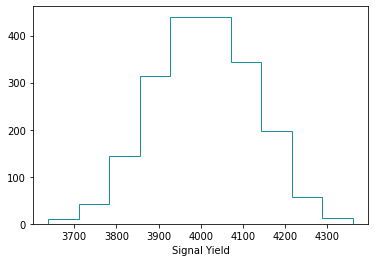

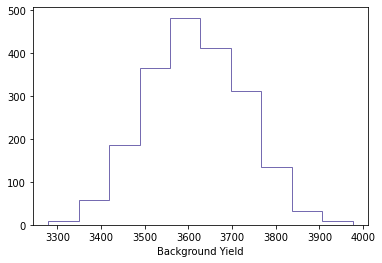

In [28]:
plt.figure()
plt.hist(sig_yield, histtype='step', color="#1c9099")
plt.xlabel('Signal Yield')
plt.plot()

plt.figure()
plt.hist(bkg_yield, histtype='step', color="#756bb1")
plt.xlabel('Background Yield')
plt.plot()
#counts_sig, bin_edges_sig = np.histogram(sig_yield)

In [33]:
sig_yield.max()

4360.668191758548

In [30]:
bkg_yield.max()

3976.1505577833527

In [22]:
len(sig_yield)

2000

In [26]:
np.sum(sig_yield == 0)

976

## Détermination de la moyenne pour les yields à l'aide d'une gaussienne

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1570                      │              Nfcn = 60               │
│ EDM = 6.87e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_sig_[241509]        4008       False
sigma_sig_[297265]    119.3       False


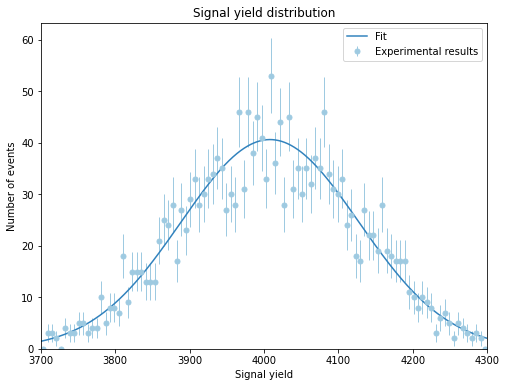

In [72]:
#Espace observable et data
min_sig = 3700 #int(sig_yield.min())
max_sig = 4300 #int(sig_yield.max()) + 1
obs = zfit.Space('x', limits=(min_sig,max_sig))
data = zfit.Data.from_numpy(obs=obs, array=sig_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_sig_ = zfit.Parameter(f"mu_sig_{rand_int}", 4000.)

rand_int = random.randint(0,1000000,size=1)
sigma_sig_ = zfit.Parameter(f"sigma_sig_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_sig_, sigma=sigma_sig_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_sig = minimizer.minimize(nll)

print(result_sig.info['original'])
print(result_sig.params)

#Plots
nb_bins = 100
lower, upper = obs.limits

x_plot_sig = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_sig = zfit.run(gauss.pdf(x_plot_sig, norm_range=obs))

counts_sig, bin_edges_sig = np.histogram(sig_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

plt.figure(figsize = [8,6])
mplhep.histplot((counts_sig,bin_edges_sig), yerr = True, color = "#9ecae1", histtype='errorbar', label="Simulated results")
plt.plot(x_plot_sig, y_plot_sig*len(sig_yield)/nb_bins*obs.area(), color= "#3182bd", label= "Fit")
plt.xlabel("Signal yield")
plt.ylabel("Number of events")
plt.title("Signal yield distribution")
plt.xlim(lower[0][0], upper[0][0])

plt.legend()
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -6681                      │              Nfcn = 55               │
│ EDM = 8.56e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_bkg_[997739]        3616       False
sigma_bkg_[652417]    110.8       False


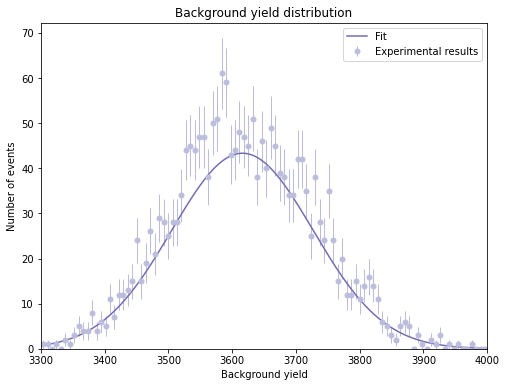

In [71]:
#Espace observable et data
min_bkg = 3300 #int(bkg_yield.min())
max_bkg = 4000#int(bkg_yield.max()) + 1
obs_bkg = zfit.Space('x', limits=(min_bkg,max_bkg))
data = zfit.Data.from_numpy(obs=obs_bkg, array=bkg_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bkg_ = zfit.Parameter(f"mu_bkg_{rand_int}", 3500.)

rand_int = random.randint(0,1000000,size=1)
sigma_bkg_ = zfit.Parameter(f"sigma_bkg_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_bkg_, sigma=sigma_bkg_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_bkg = minimizer.minimize(nll)

print(result_bkg.info['original'])
print(result_bkg.params)

#Plots
nb_bins = 100
lower, upper = obs_bkg.limits

x_plot_bkg = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bkg = zfit.run(gauss.pdf(x_plot_bkg, norm_range=obs_bkg))

counts_bkg, bin_edges_bkg = np.histogram(bkg_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))


plt.figure(figsize=[8,6])
mplhep.histplot((counts_bkg,bin_edges_bkg), yerr = True, color = "#bcbddc", histtype='errorbar', label="Simulated results")
plt.plot(x_plot_bkg, y_plot_bkg*len(bkg_yield)/nb_bins*obs.area(), color= "#756bb1", label= "Fit")
plt.xlabel("Background yield")
plt.ylabel("Number of events")
plt.title("Background yield distribution")
plt.xlim(lower[0][0], upper[0][0])
plt.legend()
plt.show()
